In [1]:
import glob
import os.path as osp
import uproot
import awkward as ak
import torch
import numpy as np
import random
import tqdm
from torch_geometric.data import Data, Dataset

import numpy as np
import subprocess
import tqdm
from tqdm import tqdm
import pandas as pd

import os
import os.path as osp

import glob

import h5py
import uproot

import torch
from torch import nn
from torch_geometric.data import Data
from torch_geometric.data import Dataset
from torch_geometric.data import DataLoader

import awkward as ak
import random
from torch_geometric.nn import knn_graph
import torch.nn.functional as F

In [8]:
import numpy as np
import subprocess
import tqdm
from tqdm import tqdm
import pandas as pd

import os
import os.path as osp

import glob

import h5py
import uproot

import torch
from torch import nn


from torch_geometric.data import Data
from torch_geometric.data import Dataset
from torch_geometric.data import DataLoader

import awkward as ak
import random

#singularity shell --bind /afs/cern.ch/user/p/pkakhand/public/CL/  /afs/cern.ch/user/p/pkakhand/geometricdl.sif

#singularity shell --bind /eos/project/c/contrast/public/solar/  /afs/cern.ch/user/p/pkakhand/geometricdl.sif
#source /cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos9-gcc11-opt/setup.sh

def find_highest_branch(path, base_name):
    with uproot.open(path) as f:
        # Find keys that exactly match the base_name (not containing other variations)
        branches = [k for k in f.keys() if k.startswith(base_name + ';')]
        
        # Sort and select the highest-numbered branch
        sorted_branches = sorted(branches, key=lambda x: int(x.split(';')[-1]))
        return sorted_branches[-1] if sorted_branches else None

def remove_duplicates(A,B):    
    all_masks = []
    for event_idx, event in enumerate(A):
        flat_A = np.array(ak.flatten(A[event_idx]))
        flat_B = np.array(ak.flatten(B[event_idx]))
        
        # Initialize a mask to keep track of which values to keep
        mask = np.zeros_like(flat_A, dtype=bool)

        # Iterate over the unique elements in A
        for elem in np.unique(flat_A):
            # Get the indices where the element occurs in A
            indices = np.where(flat_A == elem)[0]

            # If there's more than one occurrence, keep the one with the max B value
            if len(indices) > 1:
                max_index = indices[np.argmax(flat_B[indices])]
                mask[max_index] = True
            else:
                # If there's only one occurrence, keep it
                mask[indices[0]] = True

        unflattened_mask = ak.unflatten(mask, ak.num(A[event_idx]))
        all_masks.append(unflattened_mask)
        
    return ak.Array(all_masks)

class CCV1(Dataset):
    r'''
        input: layer clusters

    '''

    url = '/dummy/'

    def __init__(self, root, transform=None, max_events=1e8, inp = 'train'):
        super(CCV1, self).__init__(root, transform)
        self.step_size = 500
        self.inp = inp
        self.max_events = max_events
        self.fill_data(max_events)

    def fill_data(self,max_events):
        counter = 0
        arrLens0 = []
        arrLens1 = []

        print("### Loading data")
        for fi,path in enumerate(tqdm(self.raw_paths)):


            if self.inp == 'train':
                cluster_path = find_highest_branch(path, 'clusters')
                sim_path = find_highest_branch(path, 'simtrackstersCP')
            elif self.inp == 'val':
                cluster_path = find_highest_branch(path, 'clusters')
                sim_path = find_highest_branch(path, 'simtrackstersCP')
            else:
                cluster_path = find_highest_branch(path, 'clusters')
                sim_path = find_highest_branch(path, 'simtrackstersCP')
            
            crosstree =  uproot.open(path)[cluster_path]
            crosscounter = 0
            for array in uproot.iterate(f"{path}:{sim_path}", ["vertices_x", "vertices_y", "vertices_z", 
            "vertices_energy", "vertices_multiplicity", "vertices_time", "vertices_indexes", "barycenter_x", "barycenter_y", "barycenter_z"], step_size=self.step_size):
            
                tmp_stsCP_vertices_x = array['vertices_x']
                tmp_stsCP_vertices_y = array['vertices_y']
                tmp_stsCP_vertices_z = array['vertices_z']
                tmp_stsCP_vertices_energy = array['vertices_energy']
                tmp_stsCP_vertices_time = array['vertices_time']
                tmp_stsCP_vertices_indexes = array['vertices_indexes']
                tmp_stsCP_barycenter_x = array['barycenter_x']
                tmp_stsCP_barycenter_y = array['barycenter_y']
                tmp_stsCP_barycenter_z = array['barycenter_z']


                tmp_stsCP_vertices_multiplicity = array['vertices_multiplicity']
                
                # weighted energies (A LC appears in its caloparticle assignment array as the energy it contributes not full energy)
                #tmp_stsCP_vertices_energy = tmp_stsCP_vertices_energy * tmp_stsCP_vertices_multiplicity
                
                self.step_size = min(self.step_size,len(tmp_stsCP_vertices_x))


                # Code block for reading from other tree
                tmp_all_vertices_layer_id = crosstree['cluster_layer_id'].array(entry_start=crosscounter*self.step_size,entry_stop=(crosscounter+1)*self.step_size)
                #tmp_all_vertices_radius = crosstree['cluster_radius'].array(entry_start=crosscounter*self.step_size,entry_stop=(crosscounter+1)*self.step_size)
                tmp_all_vertices_noh = crosstree['cluster_number_of_hits'].array(entry_start=crosscounter*self.step_size,entry_stop=(crosscounter+1)*self.step_size)
                tmp_all_vertices_eta = crosstree['position_eta'].array(entry_start=crosscounter*self.step_size,entry_stop=(crosscounter+1)*self.step_size)
                tmp_all_vertices_phi = crosstree['position_phi'].array(entry_start=crosscounter*self.step_size,entry_stop=(crosscounter+1)*self.step_size)
                crosscounter += 1

                layer_id_list = []
                radius_list = []
                noh_list = []
                eta_list = []
                phi_list = []
                for evt_row in range(len(tmp_all_vertices_noh)):
                    #print("Event no: %i"%evt_row)
                    #print("There are %i particles in this event"%len(tmp_stsCP_vertices_indexes[evt_row]))
                    layer_id_list_one_event = []
                    #radius_list_one_event = []
                    noh_list_one_event = []
                    eta_list_one_event = []
                    phi_list_one_event = []
                    for particle in range(len(tmp_stsCP_vertices_indexes[evt_row])):
                        #print("Particle no: %i"%particle)
                        #print("A")
                        #print(np.array(tmp_all_vertices_radius[evt_row]).shape)
                        #print("B")
                        #print(np.array(tmp_stsCP_vertices_indexes[evt_row][particle]).shape)
                        #print("C")
                        tmp_stsCP_vertices_layer_id_one_particle = tmp_all_vertices_layer_id[evt_row][tmp_stsCP_vertices_indexes[evt_row][particle]]
                        #tmp_stsCP_vertices_radius_one_particle = tmp_all_vertices_radius[evt_row][tmp_stsCP_vertices_indexes[evt_row][particle]]
                        tmp_stsCP_vertices_noh_one_particle = tmp_all_vertices_noh[evt_row][tmp_stsCP_vertices_indexes[evt_row][particle]]
                        tmp_stsCP_vertices_eta_one_particle = tmp_all_vertices_eta[evt_row][tmp_stsCP_vertices_indexes[evt_row][particle]]
                        tmp_stsCP_vertices_phi_one_particle = tmp_all_vertices_phi[evt_row][tmp_stsCP_vertices_indexes[evt_row][particle]]
                        #print(tmp_stsCP_vertices_radius_one_particle)
                        layer_id_list_one_event.append(tmp_stsCP_vertices_layer_id_one_particle)
                        #radius_list_one_event.append(tmp_stsCP_vertices_radius_one_particle)
                        noh_list_one_event.append(tmp_stsCP_vertices_noh_one_particle)
                        eta_list_one_event.append(tmp_stsCP_vertices_eta_one_particle)
                        phi_list_one_event.append(tmp_stsCP_vertices_phi_one_particle)
                    layer_id_list.append(layer_id_list_one_event)
                    #radius_list.append(radius_list_one_event)
                    noh_list.append(noh_list_one_event)
                    eta_list.append(eta_list_one_event)
                    phi_list.append(phi_list_one_event)
                tmp_stsCP_vertices_layer_id = ak.Array(layer_id_list)                
                #tmp_stsCP_vertices_radius = ak.Array(radius_list)                
                tmp_stsCP_vertices_noh = ak.Array(noh_list)                
                tmp_stsCP_vertices_eta = ak.Array(eta_list)                
                tmp_stsCP_vertices_phi = ak.Array(phi_list)                
                
                # Apply filter noh > 1 for the LCs
                skim_mask_noh = tmp_stsCP_vertices_noh > 1.0
                tmp_stsCP_vertices_x = tmp_stsCP_vertices_x[skim_mask_noh]
                tmp_stsCP_vertices_y = tmp_stsCP_vertices_y[skim_mask_noh]
                tmp_stsCP_vertices_z = tmp_stsCP_vertices_z[skim_mask_noh]
                tmp_stsCP_vertices_energy = tmp_stsCP_vertices_energy[skim_mask_noh]
                tmp_stsCP_vertices_time = tmp_stsCP_vertices_time[skim_mask_noh]
                tmp_stsCP_vertices_layer_id = tmp_stsCP_vertices_layer_id[skim_mask_noh]
                #tmp_stsCP_vertices_radius = tmp_stsCP_vertices_radius[skim_mask_energyPercent]
                tmp_stsCP_vertices_noh = tmp_stsCP_vertices_noh[skim_mask_noh]
                tmp_stsCP_vertices_eta = tmp_stsCP_vertices_eta[skim_mask_noh]
                tmp_stsCP_vertices_phi = tmp_stsCP_vertices_phi[skim_mask_noh]
                #tmp_stsCP_vertices_indexes_unmasked = tmp_stsCP_vertices_indexes
                tmp_stsCP_vertices_indexes = tmp_stsCP_vertices_indexes[skim_mask_noh]
                tmp_stsCP_vertices_multiplicity = tmp_stsCP_vertices_multiplicity[skim_mask_noh]
                
                # Remove duplicates by only allowing the caloparticle that contributed the most energy to a LC to actually contribute.
                energyPercent = 1/tmp_stsCP_vertices_multiplicity
                skim_mask_energyPercent = remove_duplicates(tmp_stsCP_vertices_indexes,energyPercent)
                tmp_stsCP_vertices_x = tmp_stsCP_vertices_x[skim_mask_energyPercent]
                tmp_stsCP_vertices_y = tmp_stsCP_vertices_y[skim_mask_energyPercent]
                tmp_stsCP_vertices_z = tmp_stsCP_vertices_z[skim_mask_energyPercent]
                tmp_stsCP_vertices_energy = tmp_stsCP_vertices_energy[skim_mask_energyPercent]
                tmp_stsCP_vertices_time = tmp_stsCP_vertices_time[skim_mask_energyPercent]
                tmp_stsCP_vertices_layer_id = tmp_stsCP_vertices_layer_id[skim_mask_energyPercent]
                #tmp_stsCP_vertices_radius = tmp_stsCP_vertices_radius[skim_mask_energyPercent]
                tmp_stsCP_vertices_noh = tmp_stsCP_vertices_noh[skim_mask_energyPercent]
                tmp_stsCP_vertices_eta = tmp_stsCP_vertices_eta[skim_mask_energyPercent]
                tmp_stsCP_vertices_phi = tmp_stsCP_vertices_phi[skim_mask_energyPercent]
                #tmp_stsCP_vertices_indexes_unmasked = tmp_stsCP_vertices_indexes
                tmp_stsCP_vertices_indexes = tmp_stsCP_vertices_indexes[skim_mask_energyPercent]
                tmp_stsCP_vertices_multiplicity = tmp_stsCP_vertices_multiplicity[skim_mask_energyPercent]
               
                
                
                #SHOULD BE LEN(E) >= 2 for MULTI particles
                skim_mask = []
                for e in tmp_stsCP_vertices_x:
                    if 1 <= len(e) <= 5: #<------ only train on samples with > 1 particle
                        skim_mask.append(True)
                    else:
                        skim_mask.append(False)
                tmp_stsCP_vertices_x = tmp_stsCP_vertices_x[skim_mask]
                tmp_stsCP_vertices_y = tmp_stsCP_vertices_y[skim_mask]
                tmp_stsCP_vertices_z = tmp_stsCP_vertices_z[skim_mask]
                tmp_stsCP_vertices_energy = tmp_stsCP_vertices_energy[skim_mask]
                tmp_stsCP_vertices_time = tmp_stsCP_vertices_time[skim_mask]
                tmp_stsCP_vertices_layer_id = tmp_stsCP_vertices_layer_id[skim_mask]
                #tmp_stsCP_vertices_radius = tmp_stsCP_vertices_radius[skim_mask]
                tmp_stsCP_vertices_noh = tmp_stsCP_vertices_noh[skim_mask]
                tmp_stsCP_vertices_eta = tmp_stsCP_vertices_eta[skim_mask]
                tmp_stsCP_vertices_phi = tmp_stsCP_vertices_phi[skim_mask]
                #tmp_stsCP_vertices_indexes_unmasked = tmp_stsCP_vertices_indexes_unmasked[skim_mask]
                tmp_stsCP_vertices_indexes = tmp_stsCP_vertices_indexes[skim_mask]
                tmp_stsCP_vertices_multiplicity = tmp_stsCP_vertices_multiplicity[skim_mask]

                if counter == 0:
                    self.stsCP_vertices_x = tmp_stsCP_vertices_x
                    self.stsCP_vertices_y = tmp_stsCP_vertices_y
                    self.stsCP_vertices_z = tmp_stsCP_vertices_z
                    self.stsCP_vertices_energy = tmp_stsCP_vertices_energy
                    self.stsCP_vertices_time = tmp_stsCP_vertices_time
                    self.stsCP_vertices_layer_id = tmp_stsCP_vertices_layer_id
                    #self.stsCP_vertices_radius = tmp_stsCP_vertices_radius
                    self.stsCP_vertices_noh = tmp_stsCP_vertices_noh
                    self.stsCP_vertices_eta = tmp_stsCP_vertices_eta
                    self.stsCP_vertices_phi = tmp_stsCP_vertices_phi
                    self.stsCP_vertices_indexes = tmp_stsCP_vertices_indexes
                    #self.stsCP_vertices_indexes_unmasked = tmp_stsCP_vertices_indexes_unmasked
                    self.stsCP_barycenter_x = tmp_stsCP_barycenter_x
                    self.stsCP_barycenter_y = tmp_stsCP_barycenter_y
                    self.stsCP_barycenter_z = tmp_stsCP_barycenter_z
                    self.stsCP_vertices_multiplicity = tmp_stsCP_vertices_multiplicity
                else:
                    self.stsCP_vertices_x = ak.concatenate((self.stsCP_vertices_x,tmp_stsCP_vertices_x))
                    self.stsCP_vertices_y = ak.concatenate((self.stsCP_vertices_y,tmp_stsCP_vertices_y))
                    self.stsCP_vertices_z = ak.concatenate((self.stsCP_vertices_z,tmp_stsCP_vertices_z))
                    self.stsCP_vertices_energy = ak.concatenate((self.stsCP_vertices_energy,tmp_stsCP_vertices_energy))
                    self.stsCP_vertices_time = ak.concatenate((self.stsCP_vertices_time,tmp_stsCP_vertices_time))
                    self.stsCP_vertices_layer_id = ak.concatenate((self.stsCP_vertices_layer_id,tmp_stsCP_vertices_layer_id))
                    #self.stsCP_vertices_radius = ak.concatenate((self.stsCP_vertices_radius,tmp_stsCP_vertices_radius))
                    self.stsCP_vertices_noh = ak.concatenate((self.stsCP_vertices_noh,tmp_stsCP_vertices_noh))
                    self.stsCP_vertices_eta = ak.concatenate((self.stsCP_vertices_eta,tmp_stsCP_vertices_eta))
                    self.stsCP_vertices_phi = ak.concatenate((self.stsCP_vertices_phi,tmp_stsCP_vertices_phi))
                    self.stsCP_vertices_indexes = ak.concatenate((self.stsCP_vertices_indexes,tmp_stsCP_vertices_indexes))
                    #self.stsCP_vertices_indexes_unmasked =  ak.concatenate((self.stsCP_vertices_indexes_unmasked,tmp_stsCP_vertices_indexes_unmasked))
                    self.stsCP_barycenter_x = ak.concatenate((self.stsCP_barycenter_x,tmp_stsCP_barycenter_x))
                    self.stsCP_barycenter_y = ak.concatenate((self.stsCP_barycenter_y,tmp_stsCP_barycenter_y))
                    self.stsCP_barycenter_z = ak.concatenate((self.stsCP_barycenter_z,tmp_stsCP_barycenter_z))
                    self.stsCP_vertices_multiplicity = ak.concatenate((self.stsCP_vertices_multiplicity, tmp_stsCP_vertices_multiplicity))

                #print(len(self.stsCP_vertices_x))
                counter += 1
                if len(self.stsCP_vertices_x) > max_events:
                    print(f"Reached {max_events}!")
                    break
            if len(self.stsCP_vertices_x) > max_events:
                break
     
            
            
    def download(self):
        raise RuntimeError(
            'Dataset not found. Please download it from {} and move all '
            '*.z files to {}'.format(self.url, self.raw_dir))

    def len(self):
        return len(self.stsCP_vertices_x)

    @property
    def raw_file_names(self):
        raw_files = sorted(glob.glob(osp.join(self.raw_dir, '*.root')))
        
        #raw_files = [osp.join(self.raw_dir, 'step3_NTUPLE.root')]

        return raw_files

    @property
    def processed_file_names(self):
        return []


    def get(self, idx):
        def reconstruct_array(grouped_indices):
            # Find the maximum index to determine the array length
            max_index = max(max(indices) for indices in grouped_indices.values())

            # Initialize an array with the correct size, filled with a placeholder (e.g., -1)
            reconstructed = [-1] * (max_index + 1)

            # Populate the array based on the dictionary
            for value, indices in grouped_indices.items():
                for idx in indices:
                    reconstructed[idx] = value

            return reconstructed
        edge_index = torch.empty((2,0), dtype=torch.long)
 
        lc_x = self.stsCP_vertices_x[idx]
        #print(ak.to_numpy(lc_x[0]).shape)
        #print(ak.to_numpy(lc_x[1]).shape)
        flat_lc_x = np.expand_dims(np.array(ak.flatten(lc_x)),axis=1)
        lc_y = self.stsCP_vertices_y[idx]
        flat_lc_y = np.expand_dims(np.array(ak.flatten(lc_y)),axis=1)
        lc_z = self.stsCP_vertices_z[idx]
        flat_lc_z = np.expand_dims(np.array(ak.flatten(lc_z)),axis=1)
        lc_e = self.stsCP_vertices_energy[idx]
        flat_lc_e = np.expand_dims(np.array(ak.flatten(lc_e)),axis=1)     
        lc_t = self.stsCP_vertices_time[idx]
        flat_lc_t = np.expand_dims(np.array(ak.flatten(lc_t)),axis=1)  
        lc_layer_id = self.stsCP_vertices_layer_id[idx]
        flat_lc_layer_id = np.expand_dims(np.array(ak.flatten(lc_layer_id)),axis=1)  
        #lc_radius = self.stsCP_vertices_radius[idx]
        #flat_lc_radius = np.expand_dims(np.array(ak.flatten(lc_radius)),axis=1)  
        lc_noh = self.stsCP_vertices_noh[idx]
        flat_lc_noh = np.expand_dims(np.array(ak.flatten(lc_noh)),axis=1)  
        lc_eta = self.stsCP_vertices_eta[idx]
        flat_lc_eta = np.expand_dims(np.array(ak.flatten(lc_eta)),axis=1)  
        lc_phi = self.stsCP_vertices_phi[idx]
        flat_lc_phi = np.expand_dims(np.array(ak.flatten(lc_phi)),axis=1)  

        #lc_rad = self.stsCP_vertices_radius[idx]
        #flat_lc_rad = np.expand_dims(np.array(ak.flatten(lc_rad)),axis=1)  

        lc_indexes = self.stsCP_vertices_indexes[idx]
        #flat_lc_id = np.expand_dims(np.array(ak.flatten(lc_id)),axis=1)  
        lc_multiplicity = self.stsCP_vertices_multiplicity[idx]


        #flat_lc_feats = np.concatenate((flat_lc_x,flat_lc_y,flat_lc_z,flat_lc_e),axis=-1)
        flat_lc_feats = np.concatenate((flat_lc_x,flat_lc_y,flat_lc_z,flat_lc_e,\
                                        flat_lc_layer_id,flat_lc_noh,flat_lc_eta,flat_lc_phi),axis=-1)        

        # Loop over particles to build positive edges without self-pairs
        pos_edges = []
        idlc = 0
        offset = 0

        # Loop over particles (2-5 particles per event)
        for cp in range(len(lc_x)):
            n_lc_cp = len(lc_x[cp])

            for _ in range(n_lc_cp):
                # Randomly select an LC from the same particle, but not itself
                while True:
                    candidate = offset + int(random.uniform(0, n_lc_cp))
                    if candidate != idlc:
                        pos_edges.append([idlc, candidate])
                        break
                idlc += 1

            offset += n_lc_cp


        # Create the Data object
        x = torch.from_numpy(flat_lc_feats).float()
        x_lc = x
        x_pos_edge = torch.from_numpy(np.array(pos_edges).astype(np.int64))
        
        result = np.concatenate([np.full(len(subarr), i) for i, subarr in enumerate(lc_indexes)])
        result_list = result.tolist()                
        x_counts = lc_x
        y = torch.from_numpy(np.array([0 for u in range(len(flat_lc_feats))])).float()
        return Data(
            x=x_lc, edge_index=edge_index, x_pe = x_pos_edge, y=y,assoc = result_list )

In [9]:
ipath = "/vols/cms/mm1221/Data/100k/5e/train/"
vpath = "/vols/cms/mm1221/Data/100k/5e/val/"
data_train = CCV1(ipath, max_events=10, inp = 'train')
data_val = CCV1(vpath, max_events=10, inp='val')

### Loading data


  0%|                                                     | 0/3 [00:18<?, ?it/s]


Reached 10!
### Loading data


  0%|                                                     | 0/1 [00:17<?, ?it/s]

Reached 10!


In [14]:
print(data_train[0].assoc)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


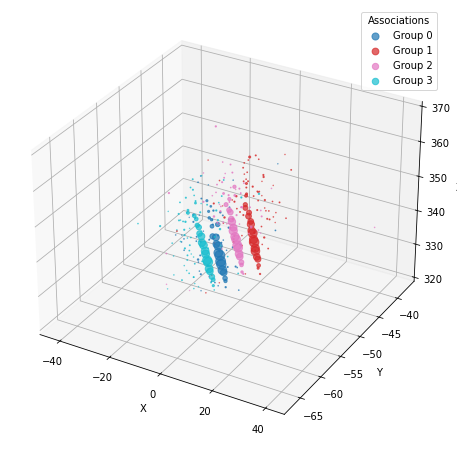

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Assume data_train[0].x is an array with columns [x, y, z, energy]
# and data_train[0].assoc contains the group associations for each point.
data = data_val[0].x
assoc = data_val[0].assoc

# Extract coordinates and energy values
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]
energy = data[:, 3]

# Scale energy values for marker sizes (adjust scaling factor as needed)
scaled_sizes = energy / energy.max() * 100  # maximum size of 100

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Determine unique groups and assign each a distinct color using a discrete colormap
unique_groups = np.unique(assoc)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_groups)))  # returns an array of RGBA colors

# Plot points for each group separately
for group, color in zip(unique_groups, colors):
    mask = (assoc == group)
    # Convert the numpy array color to a tuple
    color = tuple(color)
    ax.scatter(x[mask], y[mask], z[mask],
               s=scaled_sizes[mask],
               color=color,
               label=f"Group {group}",
               alpha=0.7)

# Label axes and add legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend(title="Associations")

plt.show()


In [23]:
# Also load explicitely, used for analysis and plots
data_path = '/vols/cms/mm1221/Data/100k/5e/val/raw/val.root'
data_file = uproot.open(data_path)

ass = data_file['associations']['tsCLUE3D_recoToSim_CP'].array()

Track_ind = data_file['tracksters;1']['vertices_indexes'].array()
GT_ind = data_file['simtrackstersCP;3']['vertices_indexes'].array()
GT_x = data_file['simtrackstersCP;3']['vertices_x'].array()
GT_y = data_file['simtrackstersCP;3']['vertices_y'].array()
GT_z = data_file['simtrackstersCP;3']['vertices_z'].array()


In [24]:
GT_energy = data_file['simtrackstersCP;3']['vertices_energy'].array()

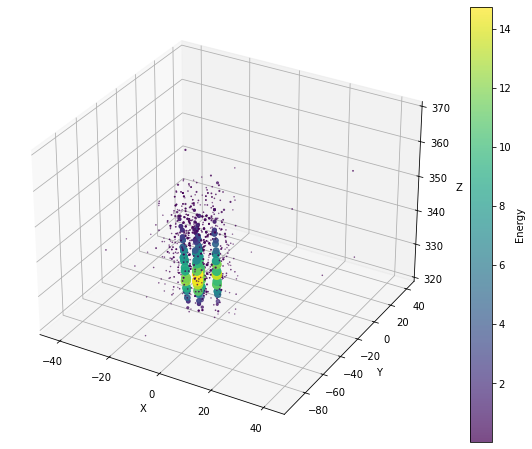

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# For the first event (index 0), each GT_* is assumed to be a list (or array) of arrays.
# We flatten each list using np.concatenate.
# Note: If your arrays are already flat, you can skip concatenation.
GT_x_event = np.concatenate(GT_x[0])
GT_y_event = np.concatenate(GT_y[0])
GT_z_event = np.concatenate(GT_z[0])
GT_energy_event = np.concatenate(GT_energy[0])

# Scale energy values for marker sizes (adjust scaling factor as needed).
# Here, we normalize the energy values and scale them to a maximum size of 100.
scaled_sizes = GT_energy_event / np.max(GT_energy_event) * 100

# Create a 3D scatter plot in detector space.
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the truth points with sizes scaled by energy and color coded by energy.
scatter = ax.scatter(GT_x_event, GT_y_event, GT_z_event,
                     s=scaled_sizes,
                     c=GT_energy_event,
                     cmap='viridis',
                     alpha=0.7)

# Label the axes.
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Add a color bar to show the energy scale.
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Energy')

plt.show()


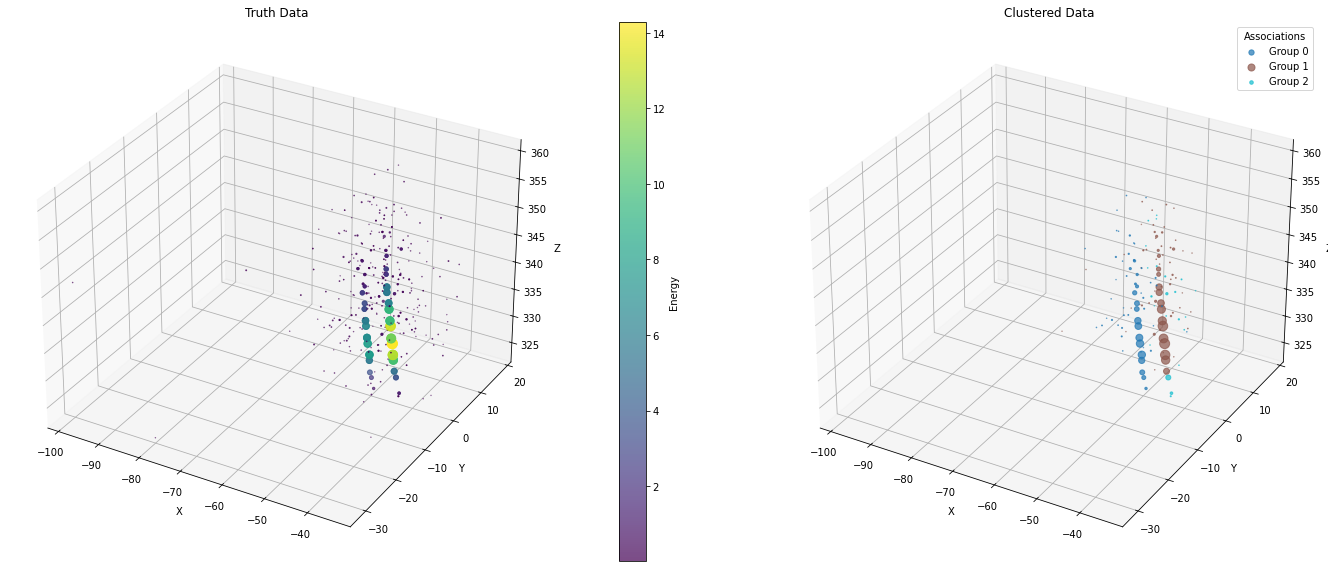

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# ----- Truth Data (convert Awkward arrays to NumPy arrays) -----
GT_x_event = np.concatenate([np.asarray(arr) for arr in GT_x[1]])
GT_y_event = np.concatenate([np.asarray(arr) for arr in GT_y[1]])
GT_z_event = np.concatenate([np.asarray(arr) for arr in GT_z[1]])
GT_energy_event = np.concatenate([np.asarray(arr) for arr in GT_energy[1]])

# Scale energy values for marker sizes (maximum size = 100)
scaled_sizes_truth = GT_energy_event / np.max(GT_energy_event) * 100

# ----- Clustered Data (convert to NumPy arrays if needed) -----
data = np.asarray(data_val[1].x)  # shape (n, 4) where columns are [x, y, z, energy]
assoc = np.asarray(data_val[1].assoc)

x = data[:, 0]
y = data[:, 1]
z = data[:, 2]
energy = data[:, 3]
scaled_sizes_val = energy / np.max(energy) * 100

# ----- Compute Global Axis Limits -----
global_x_min = min(np.min(GT_x_event), np.min(x))
global_x_max = max(np.max(GT_x_event), np.max(x))
global_y_min = min(np.min(GT_y_event), np.min(y))
global_y_max = max(np.max(GT_y_event), np.max(y))
global_z_min = min(np.min(GT_z_event), np.min(z))
global_z_max = max(np.max(GT_z_event), np.max(z))

# ----- Create Subplots -----
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# Plot Truth Data on ax1
scatter1 = ax1.scatter(GT_x_event, GT_y_event, GT_z_event,
                       s=scaled_sizes_truth,
                       c=GT_energy_event,
                       cmap='viridis',
                       alpha=0.7)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Truth Data')
cbar1 = plt.colorbar(scatter1, ax=ax1, pad=0.1)
cbar1.set_label('Energy')

# Plot Clustered Data on ax2, color-coded by group
unique_groups = np.unique(assoc)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_groups)))
for group, color in zip(unique_groups, colors):
    mask = (assoc == group)
    ax2.scatter(x[mask], y[mask], z[mask],
                s=scaled_sizes_val[mask],
                color=tuple(color),
                label=f"Group {group}",
                alpha=0.7)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Clustered Data')
ax2.legend(title="Associations")

# Apply the same axis limits on both plots
for ax in [ax1, ax2]:
    ax.set_xlim([global_x_min, global_x_max])
    ax.set_ylim([global_y_min, global_y_max])
    ax.set_zlim([global_z_min, global_z_max])

plt.tight_layout()
plt.show()


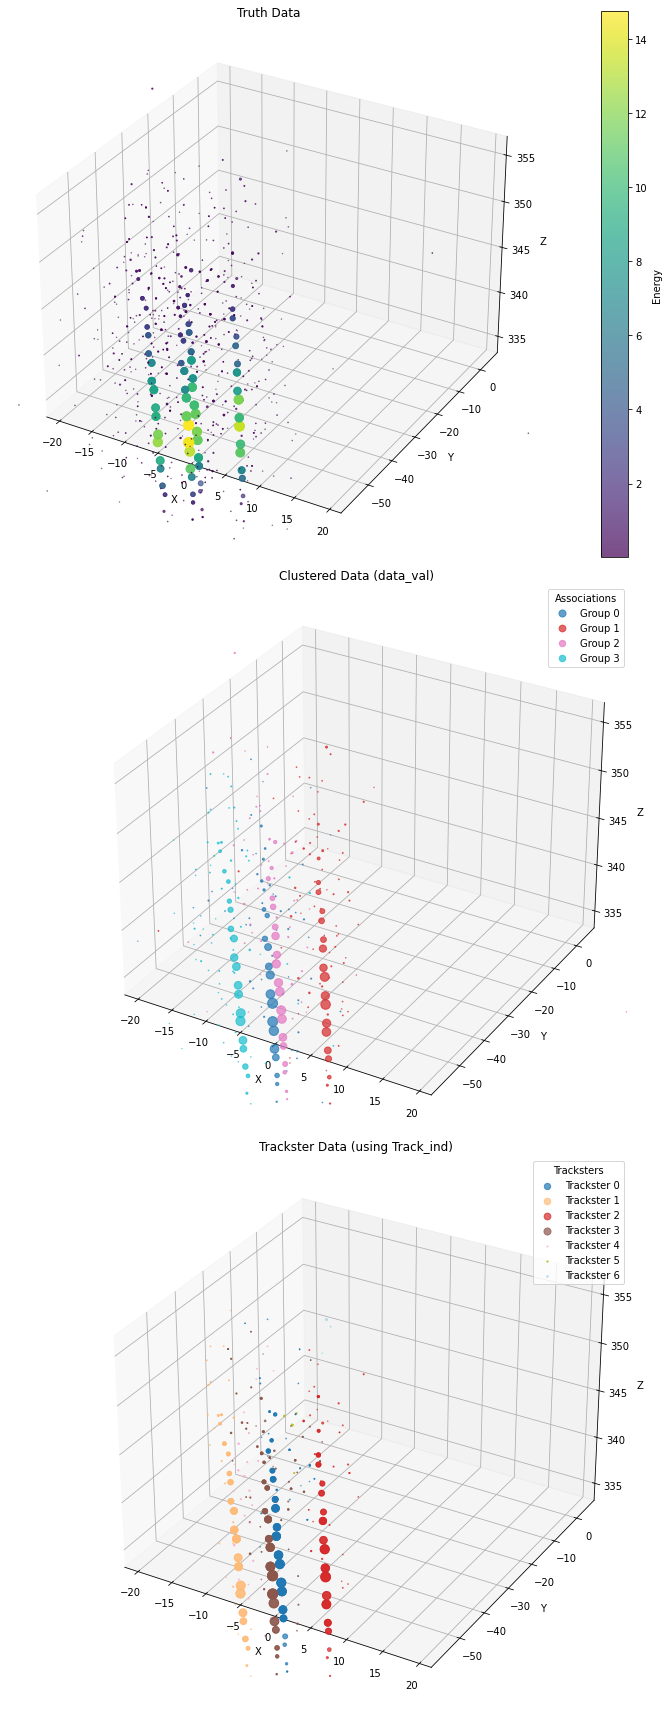

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# ----- Truth Data: Convert Awkward Arrays to NumPy and flatten for event 0 -----
GT_x_event = np.concatenate([np.asarray(arr) for arr in GT_x[0]])
GT_y_event = np.concatenate([np.asarray(arr) for arr in GT_y[0]])
GT_z_event = np.concatenate([np.asarray(arr) for arr in GT_z[0]])
GT_energy_event = np.concatenate([np.asarray(arr) for arr in GT_energy[0]])
GT_ind_event = np.concatenate([np.asarray(arr) for arr in GT_ind[0]])

# Scale energy values for marker sizes (max size = 100)
scaled_sizes_truth = GT_energy_event / np.max(GT_energy_event) * 100

# ----- Clustered Data from data_val -----
# data_val[0].x is an array with columns [x, y, z, energy]
# data_val[0].assoc contains the group associations for each point.
data = np.asarray(data_val[0].x)
assoc = np.asarray(data_val[0].assoc)

x = data[:, 0]
y = data[:, 1]
z = data[:, 2]
energy = data[:, 3]
scaled_sizes_val = energy / np.max(energy) * 100

# ----- Trackster Data: Convert Track_ind for event 0 -----
# Each element in Track_ind[0] is an array of vertex indices (matching values in GT_ind_event)
Track_ind_event = [np.asarray(arr) for arr in Track_ind[0]]

# ----- Compute Global Axis Limits from Truth Data -----
# Full extents:
global_x_min = np.min(GT_x_event)
global_x_max = np.max(GT_x_event)
global_y_min = np.min(GT_y_event)
global_y_max = np.max(GT_y_event)
global_z_min = np.min(GT_z_event)
global_z_max = np.max(GT_z_event)

# Now "zoom in" by taking half the full range, centered on the midpoint.
x_mid = (global_x_min + global_x_max) / 2
y_mid = (global_y_min + global_y_max) / 2
z_mid = (global_z_min + global_z_max) / 2

# Use half the full range
x_range = (global_x_max - global_x_min) / 2
y_range = (global_y_max - global_y_min) / 2
z_range = (global_z_max - global_z_min) / 2

# New limits (half the original range, centered)
new_x_min, new_x_max = x_mid - x_range/2, x_mid + x_range/2
new_y_min, new_y_max = y_mid - y_range/2, y_mid + y_range/2
new_z_min, new_z_max = z_mid - z_range/2, z_mid + z_range/2

# ----- Create a Figure with Three Vertically Stacked 3D Subplots -----
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, subplot_kw={'projection': '3d'}, figsize=(10, 24))

# --- Plot 1: Truth Data ---
scatter1 = ax1.scatter(GT_x_event, GT_y_event, GT_z_event,
                       s=scaled_sizes_truth,
                       c=GT_energy_event,
                       cmap='viridis',
                       alpha=0.7)
ax1.set_title('Truth Data')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
cbar1 = plt.colorbar(scatter1, ax=ax1, pad=0.1)
cbar1.set_label('Energy')

# --- Plot 2: Clustered Data (data_val) ---
unique_groups = np.unique(assoc)
colors_val = plt.cm.tab10(np.linspace(0, 1, len(unique_groups)))
for group, color in zip(unique_groups, colors_val):
    mask = (assoc == group)
    ax2.scatter(x[mask], y[mask], z[mask],
                s=scaled_sizes_val[mask],
                color=tuple(color),
                label=f"Group {group}",
                alpha=0.7)
ax2.set_title('Clustered Data (data_val)')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.legend(title="Associations")

# --- Plot 3: Trackster Data using Track_ind ---
colors_track = plt.cm.tab20(np.linspace(0, 1, len(Track_ind_event)))
for i, cluster in enumerate(Track_ind_event):
    # Mask truth vertices that belong to the current trackster
    mask = np.isin(GT_ind_event, cluster)
    ax3.scatter(GT_x_event[mask], GT_y_event[mask], GT_z_event[mask],
                s=(GT_energy_event[mask] / np.max(GT_energy_event)) * 100,
                color=tuple(colors_track[i]),
                label=f"Trackster {i}",
                alpha=0.7)
ax3.set_title('Trackster Data (using Track_ind)')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')
ax3.legend(title="Tracksters")

# --- Apply the same, zoomed-in axis limits on all subplots ---
for ax in [ax1, ax2, ax3]:
    ax.set_xlim([new_x_min, new_x_max])
    ax.set_ylim([new_y_min, new_y_max])
    ax.set_zlim([new_z_min, new_z_max])

plt.tight_layout()
plt.show()


In [52]:
j = 3

In [53]:
print(len(data_val[j].x))

278


In [54]:
lent = 0
for i in range(len(GT_ind[j])):
    temp = len(GT_ind[j][i])
    lent += temp
print(lent)

826


In [55]:
lent = 0
for i in range(len(Track_ind[j])):
    temp = len(Track_ind[j][i])
    lent += temp
print(lent)

176


In [5]:
train_sample = data_train[5].x  # shape: (num_nodes, 8)

# Compute per-feature statistics
feature_means = train_sample.mean(dim=0)
feature_stds = train_sample.std(dim=0)
mins, _ = train_sample.min(dim=0)
maxs, _ = train_sample.max(dim=0)

print("Feature shape:", train_sample.shape)
for i in range(train_sample.size(1)):
    print(f"Feature {i}: "
          f"mean={feature_means[i].item():.4f}, "
          f"std={feature_stds[i].item():.4f}, "
          f"min={mins[i].item():.4f}, "
          f"max={maxs[i].item():.4f}")


Feature shape: torch.Size([208, 8])
Feature 0: mean=-40.2484, std=6.5828, min=-59.3374, max=-21.8734
Feature 1: mean=69.2636, std=5.4397, min=53.6044, max=82.8248
Feature 2: mean=342.9316, std=10.0705, min=322.1550, max=367.9760
Feature 3: mean=2.1972, std=4.4073, min=0.0213, max=19.3178
Feature 4: mean=14.5769, std=6.3088, min=1.0000, max=27.0000
Feature 5: mean=9.0385, std=11.7883, min=2.0000, max=50.0000
Feature 6: mean=2.1597, std=0.0652, min=1.9697, max=2.4105
Feature 7: mean=2.0964, std=0.0802, min=1.8731, max=2.3627


In [9]:
print(data_train[0].assoc)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [8]:
print(data_train[0].x)

tensor([[4.9710e+01, 7.2998e+01, 3.3133e+02, 6.6692e+00, 7.0000e+00, 2.2000e+01,
         2.0326e+00, 9.7295e-01],
        [4.9652e+01, 7.2662e+01, 3.2926e+02, 5.2063e+00, 6.0000e+00, 1.9000e+01,
         2.0300e+00, 9.7135e-01],
        [4.9326e+01, 7.2373e+01, 3.2827e+02, 4.5394e+00, 5.0000e+00, 1.1000e+01,
         2.0317e+00, 9.7256e-01],
        [5.0340e+01, 7.3100e+01, 3.3232e+02, 4.4912e+00, 8.0000e+00, 2.2000e+01,
         2.0307e+00, 9.6773e-01],
        [5.0311e+01, 7.3756e+01, 3.3438e+02, 3.8750e+00, 9.0000e+00, 1.8000e+01,
         2.0310e+00, 9.7217e-01],
        [5.0682e+01, 7.3808e+01, 3.3538e+02, 3.7872e+00, 1.0000e+01, 2.4000e+01,
         2.0311e+00, 9.6908e-01],
        [4.9180e+01, 7.1873e+01, 3.2621e+02, 3.3884e+00, 4.0000e+00, 6.0000e+00,
         2.0311e+00, 9.7071e-01],
        [5.0747e+01, 7.4661e+01, 3.3744e+02, 3.6183e+00, 1.1000e+01, 2.3000e+01,
         2.0291e+00, 9.7383e-01],
        [5.1318e+01, 7.4661e+01, 3.3843e+02, 2.4244e+00, 1.2000e+01, 2.0000e+01,

In [14]:
import numpy as np

# Convert features and associations to numpy arrays
features = data_train[3].x.numpy()
assoc = np.array(data_train[3].assoc)

# Compute mean per group
unique_groups = np.unique(assoc)
means = {group: np.mean(features[assoc == group], axis=0) for group in unique_groups}

# Print means for each feature per group
for group, mean_values in means.items():
    print(f"Group {group} Means: {mean_values}")


Group 0 Means: [-98.846016   41.865025  340.6055      1.9966475  13.103896    8.584415
   1.8712792   2.7407525]
Group 1 Means: [-87.80829    56.865463  342.4289      1.7169393  14.290698    7.5465117
   1.9012218   2.5674047]


In [6]:
train_sample = data_val[5].x  # shape: (num_nodes, 8)

# Compute per-feature statistics
feature_means = train_sample.mean(dim=0)
feature_stds = train_sample.std(dim=0)
mins, _ = train_sample.min(dim=0)
maxs, _ = train_sample.max(dim=0)

print("Feature shape:", train_sample.shape)
for i in range(train_sample.size(1)):
    print(f"Feature {i}: "
          f"mean={feature_means[i].item():.4f}, "
          f"std={feature_stds[i].item():.4f}, "
          f"min={mins[i].item():.4f}, "
          f"max={maxs[i].item():.4f}")


Feature shape: torch.Size([202, 8])
Feature 0: mean=7.4966, std=7.9703, min=-14.4271, max=24.8996
Feature 1: mean=-53.8538, std=5.1789, min=-74.9655, max=-42.1141
Feature 2: mean=342.0277, std=8.7424, min=323.1490, max=361.1330
Feature 3: mean=1.0113, std=2.4213, min=0.0267, max=15.6973
Feature 4: mean=14.0545, std=5.5630, min=2.0000, max=26.0000
Feature 5: mean=7.1238, std=9.4999, min=2.0000, max=47.0000
Feature 6: mean=2.5350, std=0.1082, min=2.1909, max=2.8033
Feature 7: mean=-1.4389, std=0.1303, min=-1.7975, max=-1.1846


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CustomStaticEdgeConv(nn.Module):
    def __init__(self, nn_module):
        super(CustomStaticEdgeConv, self).__init__()
        self.nn_module = nn_module

    def forward(self, x, edge_index):
        """
        Args:
            x (torch.Tensor): Node features of shape (N, F).
            edge_index (torch.Tensor): Predefined edges [2, E], where E is the number of edges.

        Returns:
            torch.Tensor: Node features after static edge aggregation.
        """
        row, col = edge_index  # Extract row (source) and col (target) nodes
        x_center = x[row]
        x_neighbor = x[col]

        # Compute edge features (relative)
        edge_features = torch.cat([x_center, x_neighbor - x_center], dim=-1)
        edge_features = self.nn_module(edge_features)

        # Aggregate features back to nodes
        num_nodes = x.size(0)
        node_features = torch.zeros(num_nodes, edge_features.size(-1), device=x.device)
        node_features.index_add_(0, row, edge_features)

        # Normalization (Divide by node degrees)
        counts = torch.bincount(row, minlength=num_nodes).clamp(min=1).view(-1, 1)
        node_features = node_features / counts

        return node_features


class CustomGATLayer(nn.Module):
    def __init__(self, in_dim, out_dim, heads=1, concat=True, dropout=0.6, alpha=0.4):
        """
        Initializes the Custom GAT Layer.

        Args:
            in_dim (int): Input feature dimension.
            out_dim (int): Output feature dimension per head.
            heads (int): Number of attention heads.
            concat (bool): Whether to concatenate the heads' output or average them.
            dropout (float): Dropout rate on attention coefficients.
            alpha (float): Negative slope for LeakyReLU.
        """
        super(CustomGATLayer, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.heads = heads
        self.concat = concat

        # Linear transformation for node features
        self.W = nn.Linear(in_dim, heads * out_dim, bias=False)

        # Attention mechanism: a vector for each head
        self.a_src = nn.Parameter(torch.zeros(heads, out_dim))
        self.a_tgt = nn.Parameter(torch.zeros(heads, out_dim))
        nn.init.xavier_uniform_(self.a_src.data, gain=1.414)
        nn.init.xavier_uniform_(self.a_tgt.data, gain=1.414)

        self.leakyrelu = nn.LeakyReLU(alpha)
        self.dropout = nn.Dropout(dropout)

        # Optional batch normalization
        self.batch_norm = nn.BatchNorm1d(heads * out_dim) if concat else nn.BatchNorm1d(out_dim)

    def forward(self, x, edge_index):
        """
        Forward pass of the GAT layer.

        Args:
            x (torch.Tensor): Node features of shape (N, in_dim).
            edge_index (torch.Tensor): Edge indices of shape (2, E).

        Returns:
            torch.Tensor: Updated node features after attention-based aggregation.
        """
        src, tgt = edge_index  # Source and target node indices
        N = x.size(0)

        # Apply linear transformation and reshape for multi-head attention
        h = self.W(x)  # Shape: (N, heads * out_dim)
        h = h.view(N, self.heads, self.out_dim)  # Shape: (N, heads, out_dim)

        # Gather node features for each edge
        h_src = h[src]  # Shape: (E, heads, out_dim)
        h_tgt = h[tgt]  # Shape: (E, heads, out_dim)

        # Compute attention coefficients using separate vectors for source and target
        e_src = (h_src * self.a_src).sum(dim=-1)  # Shape: (E, heads)
        e_tgt = (h_tgt * self.a_tgt).sum(dim=-1)  # Shape: (E, heads)
        e = self.leakyrelu(e_src + e_tgt)  # Shape: (E, heads)

        # Compute softmax normalization for attention coefficients
        # To ensure numerical stability
        e = e - e.max(dim=0, keepdim=True)[0]
        alpha = torch.exp(e)  # Shape: (E, heads)

        # Sum of attention coefficients for each target node and head
        alpha_sum = torch.zeros(N, self.heads, device=x.device).scatter_add_(0, tgt.unsqueeze(-1).expand(-1, self.heads), alpha)

        # Avoid division by zero
        alpha_sum = alpha_sum + 1e-16

        # Normalize attention coefficients
        alpha = alpha / alpha_sum[tgt]  # Shape: (E, heads)
        alpha = self.dropout(alpha)

        # Weighted aggregation of source node features
        h_prime = h_src * alpha.unsqueeze(-1)  # Shape: (E, heads, out_dim)

        # Initialize output tensor and aggregate
        out = torch.zeros(N, self.heads, self.out_dim, device=x.device)
        out.scatter_add_(0, tgt.unsqueeze(-1).unsqueeze(-1).expand(-1, self.heads, self.out_dim), h_prime)  # Shape: (N, heads, out_dim)

        # Concatenate or average the heads
        if self.concat:
            out = out.view(N, self.heads * self.out_dim)  # Shape: (N, heads*out_dim)
        else:
            out = out.mean(dim=1)  # Shape: (N, out_dim)

        # Apply batch normalization
        out = self.batch_norm(out)

        return out

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import DynamicEdgeConv

class Net(nn.Module):
    def __init__(self, hidden_dim=64, num_layers=4, dropout=0.3, contrastive_dim=8, k=20):
        """
        Initializes the neural network with DynamicEdgeConv layers.

        Args:
            hidden_dim (int): Dimension of hidden layers.
            num_layers (int): Total number of DynamicEdgeConv layers.
            dropout (float): Dropout rate.
            contrastive_dim (int): Dimension of the contrastive output.
            k (int): Number of nearest neighbors to use in DynamicEdgeConv.
        """
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.contrastive_dim = contrastive_dim
        self.k = k

        # Input encoder
        self.lc_encode = nn.Sequential(
            nn.Linear(8, 32),
            nn.ELU(),
            nn.Linear(32, hidden_dim),
            nn.ELU()
        )

        # Define the network's convolutional layers using DynamicEdgeConv layers
        self.convs = nn.ModuleList()
        for _ in range(num_layers):
            mlp = nn.Sequential(
                nn.Linear(2 * hidden_dim, hidden_dim),
                nn.ELU(),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(p=dropout)
            )
            conv = DynamicEdgeConv(mlp, k=k, aggr="max")
            self.convs.append(conv)

        # Output layer
        self.output = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ELU(),
            nn.Dropout(p=dropout),
            nn.Linear(64, 32),
            nn.ELU(),
            nn.Dropout(p=dropout),
            nn.Linear(32, contrastive_dim)
        )

    def forward(self, x, batch):
        """
        Forward pass of the network.

        Args:
            x (torch.Tensor): Input node features of shape (N, 8).
            batch (torch.Tensor): Batch vector that assigns each node to an example in the batch.

        Returns:
            torch.Tensor: Output features after processing.
            torch.Tensor: Batch vector.
        """
        # Input encoding
        x_lc_enc = self.lc_encode(x)  # Shape: (N, hidden_dim)

        # Apply DynamicEdgeConv layers with residual connections
        feats = x_lc_enc
        for conv in self.convs:
            feats = conv(feats, batch) 

        # Final output
        out = self.output(feats)
        return out, batch




In [11]:
# Initialize model with passed hyperparameters
model = Net(
    hidden_dim=64,
    num_layers=3,
    dropout=0.3,
    contrastive_dim=128,
    k=16
)

k_value = 4
BS = 1
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)


# Define Loss

In [12]:
def contrastive_loss_curriculum_both(embeddings, pos_indices, group_ids, temperature=0.1, alpha=1.0):
    """
    Computes an NT-Xent style loss that blends both positive and negative mining.
    
    For each anchor i:
      - Provided positive similarity: pos_sim_orig = sim(embeddings[i], embeddings[pos_indices[i]])
      - Blended positive similarity: blended_pos = pos_sim_orig
      - Random negative similarity: rand_neg_sim = similarity from a randomly chosen negative (group_ids differ)
      - Hard negative similarity: hard_neg_sim = max { sim(embeddings[i], embeddings[j]) : group_ids[j] != group_ids[i] }
      - Blended negative similarity: blended_neg = (1 - alpha) * rand_neg_sim + alpha * hard_neg_sim
      
    The loss per anchor is then:
         loss_i = - log( exp(blended_pos/temperature) / [ exp(blended_pos/temperature) + exp((blended_neg - margin)/temperature) ] )
    
    Anchors that lack any valid positives or negatives contribute 0.
    
    Args:
        embeddings: Tensor of shape (N, D) (raw outputs; they will be normalized inside).
        pos_indices: 1D Tensor (length N) giving the index of the provided positive for each anchor.
        group_ids: 1D Tensor (length N) of group identifiers.
        temperature: Temperature scaling factor.
        alpha: Blending parameter between random and hard mining (0: use only provided/random, 1: use only hard).
        margin: A positive scalar to subtract from the negative similarity to create a gap.
        
    Returns:
        Scalar loss (mean over anchors).
    """
    # Normalize embeddings so that cosine similarity is simply the dot product.
    norm_emb = F.normalize(embeddings, p=2, dim=1)  # shape (N, D)
    # Compute full cosine similarity matrix.
    sim_matrix = norm_emb @ norm_emb.t()  # shape (N, N)
    N = embeddings.size(0)
    idx = torch.arange(N, device=embeddings.device)
    
    # --- Positives ---
    # Provided positive similarity.
    pos_sim_orig = sim_matrix[idx, pos_indices.view(-1)]
    # Blended positive similarity.
    blended_pos = pos_sim_orig 
    
    # --- Negatives ---
    # Mask for negatives: group_ids differ.
    neg_mask = (group_ids.unsqueeze(1) != group_ids.unsqueeze(0))
    valid_neg_counts = neg_mask.sum(dim=1)
    no_valid_neg = (valid_neg_counts == 0)
    
    # Random negative: for each anchor, select one random index among negatives.
    rand_vals = torch.rand(sim_matrix.shape, device=embeddings.device)
    rand_vals = rand_vals * neg_mask.float() - (1 - neg_mask.float())
    rand_neg_indices = torch.argmax(rand_vals, dim=1)
    rand_neg_sim = sim_matrix[idx, rand_neg_indices]
    
    # Hard negative: among all negatives, choose the one with maximum similarity.
    sim_matrix_neg = sim_matrix.masked_fill(~neg_mask, -float('inf'))
    hard_neg_sim, _ = sim_matrix_neg.max(dim=1)
    hard_neg_sim = torch.where(no_valid_neg, torch.tensor(-1.0, device=embeddings.device), hard_neg_sim)
    
    # Blended negative similarity.
    blended_neg = (1 - alpha) * rand_neg_sim + alpha * hard_neg_sim
    

    print(blended_pos.mean(), rand_neg_sim.mean())
    
    # --- Loss Computation ---

    loss = -torch.log(torch.exp(blended_pos/ temperature) / (torch.exp(blended_pos/ temperature) + torch.exp(blended_neg / temperature)))
    loss = loss.masked_fill(no_valid_neg, 0.0)
    print(loss.mean())
    return loss.mean()

def contrastive_loss_curriculum(embeddings, pos_indices, group_ids, temperature=0.1, alpha=1.0):
    """
    Curriculum loss that uses both positive and negative blending.
    
    Delegates to contrastive_loss_curriculum_both.
    
    Args:
        embeddings: Tensor of shape (N, D).
        pos_indices: 1D Tensor (length N).
        group_ids: 1D Tensor (length N).
        temperature: Temperature scaling factor.
        alpha: Blending parameter.
        
    Returns:
        Scalar loss.
    """
    return contrastive_loss_curriculum_both(embeddings, pos_indices, group_ids, temperature, alpha)

In [13]:
def train_new(train_loader, model, optimizer, device, k_value, alpha):
    model.train()
    total_loss = torch.zeros(1, device=device)
    for data in tqdm(train_loader, desc="Training"):
        data = data.to(device)
        optimizer.zero_grad()
        
        # Convert data.assoc to tensor if needed.
        if isinstance(data.assoc, list):
            if isinstance(data.assoc[0], list):
                assoc_tensor = torch.cat([torch.tensor(a, dtype=torch.int64, device=data.x.device)
                                          for a in data.assoc])
            else:
                assoc_tensor = torch.tensor(data.assoc, device=data.x.device)
        else:
            assoc_tensor = data.assoc

        #edge_index = knn_graph(data.x[:, :3], k=k_value, batch=data.x_batch)
        embeddings, _ = model(data.x, data.x_batch)
        
        # Partition batch by event.
        batch_np = data.x_batch.detach().cpu().numpy()
        _, counts = np.unique(batch_np, return_counts=True)
        
        loss_event_total = torch.zeros(1, device=device)
        start_idx = 0
        for count in counts:
            end_idx = start_idx + count
            event_embeddings = embeddings[start_idx:end_idx]
            event_group_ids = assoc_tensor[start_idx:end_idx]

            event_pos_indices = data.x_pe[start_idx:end_idx, 1].view(-1)

            loss_event = contrastive_loss_curriculum(event_embeddings, event_pos_indices,
                                                     event_group_ids, temperature=0.1, alpha=alpha)
            loss_event_total += loss_event
            start_idx = end_idx
        
        loss = loss_event_total / len(counts)
        loss.backward()
        total_loss += loss
        optimizer.step()
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test_new(test_loader, model, device, k_value, alpha):
    model.eval()
    total_loss = torch.zeros(1, device=device)
    for data in tqdm(test_loader, desc="Validation"):
        data = data.to(device)
        
        if isinstance(data.assoc, list):
            if isinstance(data.assoc[0], list):
                assoc_tensor = torch.cat([torch.tensor(a, dtype=torch.int64, device=data.x.device)
                                          for a in data.assoc])
            else:
                assoc_tensor = torch.tensor(data.assoc, device=data.x.device)
        else:
            assoc_tensor = data.assoc
        
        #edge_index = knn_graph(data.x[:, :3], k=k_value, batch=data.x_batch)
        embeddings, _ = model(data.x, data.x_batch)
        
        batch_np = data.x_batch.detach().cpu().numpy()
        _, counts = np.unique(batch_np, return_counts=True)
        
        loss_event_total = torch.zeros(1, device=device)
        start_idx = 0
        for count in counts:
            end_idx = start_idx + count
            event_embeddings = embeddings[start_idx:end_idx]
            event_group_ids = assoc_tensor[start_idx:end_idx]

            event_pos_indices = data.x_pe[start_idx:end_idx, 1].view(-1)
            loss_event = contrastive_loss_curriculum(event_embeddings, event_pos_indices,
                                                     event_group_ids, temperature=0.1, alpha=alpha)
            loss_event_total += loss_event
            start_idx = end_idx
        total_loss += loss_event_total / len(counts)
    return total_loss / len(test_loader.dataset)


In [14]:

device = torch.device('cpu')
# Load DataLoader with current batch_size
train_loader = DataLoader(data_train, batch_size=BS, shuffle=True, follow_batch=['x'])
val_loader = DataLoader(data_val, batch_size=BS, shuffle=False, follow_batch=['x'])

# Train and evaluate the model for the specified number of epochs
best_val_loss = float('inf')

# Store train and validation losses for all epochs
train_losses = []
val_losses = []

output_dir = '/vols/cms/mm1221/hgcal/elec5New/LC/NegativeMining/resultstest/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
patience =30    
epochs = 5
for epoch in range(epochs):
    # For epochs 1 to 150, gradually increase alpha from 0 to 1.
    # From epoch 151 onward, set alpha = 1 (fully hard negatives).
    alpha = 0

    print(f"Epoch {epoch+1}/{epochs} | Alpha: {alpha:.2f}")
    train_loss = train_new(train_loader, model, optimizer, device, k_value, alpha)
    val_loss = test_new(val_loader, model, device, k_value, alpha)

    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    scheduler.step()

    # Save best model if validation loss improves.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_epochs = 0
        torch.save(model.state_dict(), os.path.join(output_dir, 'best_model.pt'))
    else:
        no_improvement_epochs += 1

    # Save intermediate checkpoint.
    state_dicts = {'model': model.state_dict(),
                   'opt': optimizer.state_dict(),
                   'lr': scheduler.state_dict()}
    torch.save(state_dicts, os.path.join(output_dir, f'epoch-{epoch+1}.pt'))

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss.item():.8f}, Validation Loss: {val_loss.item():.8f}")
    if no_improvement_epochs >= patience:
        print(f"Early stopping triggered. No improvement for {patience} epochs.")
        break

# Save training history.
import pandas as pd
results_df = pd.DataFrame({
    'epoch': list(range(1, len(train_losses) + 1)),
    'train_loss': train_losses,
    'val_loss': val_losses
})
results_df.to_csv(os.path.join(output_dir, 'continued_training_loss.csv'), index=False)
print(f"Saved loss curves to {os.path.join(output_dir, 'continued_training_loss.csv')}")

# Save final model.
torch.save(model.state_dict(), os.path.join(output_dir, 'final_model.pt'))
print("Training complete. Final model saved.")

/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/5 | Alpha: 0.00


Training:   0%|▊                                                                                                                                                            | 2/418 [00:00<00:28, 14.66it/s]

tensor(0.3156, grad_fn=<MeanBackward0>) tensor(0.2900, grad_fn=<MeanBackward0>)
tensor(1.1212, grad_fn=<MeanBackward0>)
tensor(0.3323, grad_fn=<MeanBackward0>) tensor(0.3124, grad_fn=<MeanBackward0>)
tensor(1.1293, grad_fn=<MeanBackward0>)
tensor(0.3224, grad_fn=<MeanBackward0>) tensor(0.3166, grad_fn=<MeanBackward0>)
tensor(1.1249, grad_fn=<MeanBackward0>)
tensor(0.3238, grad_fn=<MeanBackward0>) tensor(0.3086, grad_fn=<MeanBackward0>)
tensor(1.1558, grad_fn=<MeanBackward0>)


Training:   1%|██▎                                                                                                                                                          | 6/418 [00:00<00:25, 16.03it/s]

tensor(0.3237, grad_fn=<MeanBackward0>) tensor(0.2868, grad_fn=<MeanBackward0>)
tensor(1.0692, grad_fn=<MeanBackward0>)
tensor(0.3336, grad_fn=<MeanBackward0>) tensor(0.3113, grad_fn=<MeanBackward0>)
tensor(1.1090, grad_fn=<MeanBackward0>)
tensor(0.3080, grad_fn=<MeanBackward0>) tensor(0.2831, grad_fn=<MeanBackward0>)
tensor(1.2168, grad_fn=<MeanBackward0>)
tensor(0.3521, grad_fn=<MeanBackward0>) tensor(0.3229, grad_fn=<MeanBackward0>)
tensor(1.0397, grad_fn=<MeanBackward0>)


Training:   3%|████                                                                                                                                                        | 11/418 [00:00<00:23, 17.57it/s]

tensor(0.3160, grad_fn=<MeanBackward0>) tensor(0.3191, grad_fn=<MeanBackward0>)
tensor(1.2203, grad_fn=<MeanBackward0>)
tensor(0.3340, grad_fn=<MeanBackward0>) tensor(0.2868, grad_fn=<MeanBackward0>)
tensor(1.0034, grad_fn=<MeanBackward0>)
tensor(0.3334, grad_fn=<MeanBackward0>) tensor(0.3094, grad_fn=<MeanBackward0>)
tensor(1.0899, grad_fn=<MeanBackward0>)
tensor(0.3353, grad_fn=<MeanBackward0>) tensor(0.3222, grad_fn=<MeanBackward0>)
tensor(1.1566, grad_fn=<MeanBackward0>)
tensor(0.3078, grad_fn=<MeanBackward0>) tensor(0.3034, grad_fn=<MeanBackward0>)
tensor(1.1957, grad_fn=<MeanBackward0>)


Training:   4%|█████▉                                                                                                                                                      | 16/418 [00:00<00:20, 19.91it/s]

tensor(0.3488, grad_fn=<MeanBackward0>) tensor(0.3038, grad_fn=<MeanBackward0>)
tensor(0.9481, grad_fn=<MeanBackward0>)
tensor(0.3267, grad_fn=<MeanBackward0>) tensor(0.2944, grad_fn=<MeanBackward0>)
tensor(1.1022, grad_fn=<MeanBackward0>)
tensor(0.3234, grad_fn=<MeanBackward0>) tensor(0.3049, grad_fn=<MeanBackward0>)
tensor(1.1323, grad_fn=<MeanBackward0>)
tensor(0.3219, grad_fn=<MeanBackward0>) tensor(0.3258, grad_fn=<MeanBackward0>)
tensor(1.2402, grad_fn=<MeanBackward0>)
tensor(0.3785, grad_fn=<MeanBackward0>) tensor(0.3296, grad_fn=<MeanBackward0>)
tensor(0.9599, grad_fn=<MeanBackward0>)


Training:   5%|███████▊                                                                                                                                                    | 21/418 [00:01<00:18, 21.89it/s]

tensor(0.2725, grad_fn=<MeanBackward0>) tensor(0.3194, grad_fn=<MeanBackward0>)
tensor(1.4257, grad_fn=<MeanBackward0>)
tensor(0.2635, grad_fn=<MeanBackward0>) tensor(0.2706, grad_fn=<MeanBackward0>)
tensor(1.1907, grad_fn=<MeanBackward0>)
tensor(0.3517, grad_fn=<MeanBackward0>) tensor(0.3276, grad_fn=<MeanBackward0>)
tensor(1.0545, grad_fn=<MeanBackward0>)
tensor(0.3558, grad_fn=<MeanBackward0>) tensor(0.3447, grad_fn=<MeanBackward0>)
tensor(1.1029, grad_fn=<MeanBackward0>)
tensor(0.3422, grad_fn=<MeanBackward0>) tensor(0.3154, grad_fn=<MeanBackward0>)
tensor(1.0758, grad_fn=<MeanBackward0>)


Training:   6%|████████▉                                                                                                                                                   | 24/418 [00:01<00:19, 20.50it/s]

tensor(0.3331, grad_fn=<MeanBackward0>) tensor(0.3252, grad_fn=<MeanBackward0>)
tensor(1.1056, grad_fn=<MeanBackward0>)
tensor(0.3534, grad_fn=<MeanBackward0>) tensor(0.3262, grad_fn=<MeanBackward0>)
tensor(1.0584, grad_fn=<MeanBackward0>)
tensor(0.3650, grad_fn=<MeanBackward0>) tensor(0.3542, grad_fn=<MeanBackward0>)
tensor(1.2050, grad_fn=<MeanBackward0>)
tensor(0.3194, grad_fn=<MeanBackward0>) tensor(0.2923, grad_fn=<MeanBackward0>)
tensor(1.0796, grad_fn=<MeanBackward0>)


Training:   6%|██████████                                                                                                                                                  | 27/418 [00:01<00:21, 18.47it/s]

tensor(0.3305, grad_fn=<MeanBackward0>) tensor(0.3341, grad_fn=<MeanBackward0>)
tensor(1.2040, grad_fn=<MeanBackward0>)
tensor(0.3532, grad_fn=<MeanBackward0>) tensor(0.2982, grad_fn=<MeanBackward0>)
tensor(0.9084, grad_fn=<MeanBackward0>)


Training:   7%|███████████▏                                                                                                                                                | 30/418 [00:01<00:20, 19.15it/s]

tensor(0.3143, grad_fn=<MeanBackward0>) tensor(0.3005, grad_fn=<MeanBackward0>)
tensor(1.1372, grad_fn=<MeanBackward0>)
tensor(0.3454, grad_fn=<MeanBackward0>) tensor(0.3295, grad_fn=<MeanBackward0>)
tensor(1.1159, grad_fn=<MeanBackward0>)


Training:   8%|███████████▉                                                                                                                                                | 32/418 [00:01<00:22, 17.30it/s]

tensor(0.3320, grad_fn=<MeanBackward0>) tensor(0.3241, grad_fn=<MeanBackward0>)
tensor(1.1853, grad_fn=<MeanBackward0>)


Training:   8%|████████████▋                                                                                                                                               | 34/418 [00:01<00:21, 17.63it/s]

tensor(0.3656, grad_fn=<MeanBackward0>) tensor(0.3174, grad_fn=<MeanBackward0>)
tensor(1.0220, grad_fn=<MeanBackward0>)
tensor(0.3573, grad_fn=<MeanBackward0>) tensor(0.3185, grad_fn=<MeanBackward0>)
tensor(1.0551, grad_fn=<MeanBackward0>)
tensor(0.2770, grad_fn=<MeanBackward0>) tensor(0.2985, grad_fn=<MeanBackward0>)
tensor(1.3317, grad_fn=<MeanBackward0>)


Training:   9%|█████████████▍                                                                                                                                              | 36/418 [00:01<00:21, 17.61it/s]

tensor(0.3590, grad_fn=<MeanBackward0>) tensor(0.3341, grad_fn=<MeanBackward0>)
tensor(1.0116, grad_fn=<MeanBackward0>)


Training:   9%|██████████████▌                                                                                                                                             | 39/418 [00:02<00:20, 18.88it/s]

tensor(0.3207, grad_fn=<MeanBackward0>) tensor(0.2967, grad_fn=<MeanBackward0>)
tensor(1.1106, grad_fn=<MeanBackward0>)
tensor(0.3656, grad_fn=<MeanBackward0>) tensor(0.3020, grad_fn=<MeanBackward0>)
tensor(0.8794, grad_fn=<MeanBackward0>)
tensor(0.3662, grad_fn=<MeanBackward0>) tensor(0.3499, grad_fn=<MeanBackward0>)
tensor(1.0853, grad_fn=<MeanBackward0>)
tensor(0.3247, grad_fn=<MeanBackward0>) tensor(0.3303, grad_fn=<MeanBackward0>)
tensor(1.2769, grad_fn=<MeanBackward0>)
tensor(0.3344, grad_fn=<MeanBackward0>) tensor(0.3259, grad_fn=<MeanBackward0>)
tensor(1.2234, grad_fn=<MeanBackward0>)


Training:  11%|████████████████▊                                                                                                                                           | 45/418 [00:02<00:17, 21.39it/s]

tensor(0.3467, grad_fn=<MeanBackward0>) tensor(0.3159, grad_fn=<MeanBackward0>)
tensor(0.9806, grad_fn=<MeanBackward0>)
tensor(0.3205, grad_fn=<MeanBackward0>) tensor(0.3007, grad_fn=<MeanBackward0>)
tensor(1.1263, grad_fn=<MeanBackward0>)
tensor(0.3443, grad_fn=<MeanBackward0>) tensor(0.3237, grad_fn=<MeanBackward0>)
tensor(1.0925, grad_fn=<MeanBackward0>)
tensor(0.3447, grad_fn=<MeanBackward0>) tensor(0.3500, grad_fn=<MeanBackward0>)
tensor(1.1993, grad_fn=<MeanBackward0>)
tensor(0.3550, grad_fn=<MeanBackward0>) tensor(0.3368, grad_fn=<MeanBackward0>)
tensor(1.0625, grad_fn=<MeanBackward0>)


Training:  11%|█████████████████▉                                                                                                                                          | 48/418 [00:02<00:18, 19.99it/s]

tensor(0.3425, grad_fn=<MeanBackward0>) tensor(0.2917, grad_fn=<MeanBackward0>)
tensor(0.9183, grad_fn=<MeanBackward0>)
tensor(0.3581, grad_fn=<MeanBackward0>) tensor(0.3219, grad_fn=<MeanBackward0>)
tensor(1.0342, grad_fn=<MeanBackward0>)
tensor(0.3097, grad_fn=<MeanBackward0>) tensor(0.3009, grad_fn=<MeanBackward0>)
tensor(1.1044, grad_fn=<MeanBackward0>)
tensor(0.3334, grad_fn=<MeanBackward0>) tensor(0.3186, grad_fn=<MeanBackward0>)
tensor(1.0868, grad_fn=<MeanBackward0>)
tensor(0.3370, grad_fn=<MeanBackward0>) tensor(0.3383, grad_fn=<MeanBackward0>)
tensor(1.1724, grad_fn=<MeanBackward0>)


Training:  12%|███████████████████                                                                                                                                         | 51/418 [00:02<00:17, 20.83it/s]

tensor(0.3484, grad_fn=<MeanBackward0>) tensor(0.3323, grad_fn=<MeanBackward0>)
tensor(1.0779, grad_fn=<MeanBackward0>)
tensor(0.3285, grad_fn=<MeanBackward0>) tensor(0.3223, grad_fn=<MeanBackward0>)
tensor(1.2125, grad_fn=<MeanBackward0>)
tensor(0.3563, grad_fn=<MeanBackward0>) tensor(0.3211, grad_fn=<MeanBackward0>)
tensor(1.0972, grad_fn=<MeanBackward0>)


Training:  13%|████████████████████▏                                                                                                                                       | 54/418 [00:02<00:17, 20.29it/s]

tensor(0.3189, grad_fn=<MeanBackward0>) tensor(0.3036, grad_fn=<MeanBackward0>)
tensor(1.1448, grad_fn=<MeanBackward0>)


Training:  14%|█████████████████████▎                                                                                                                                      | 57/418 [00:02<00:18, 19.94it/s]

tensor(0.3576, grad_fn=<MeanBackward0>) tensor(0.3368, grad_fn=<MeanBackward0>)
tensor(1.0353, grad_fn=<MeanBackward0>)
tensor(0.3786, grad_fn=<MeanBackward0>) tensor(0.3575, grad_fn=<MeanBackward0>)
tensor(1.0271, grad_fn=<MeanBackward0>)
tensor(0.3639, grad_fn=<MeanBackward0>) tensor(0.3223, grad_fn=<MeanBackward0>)
tensor(0.9848, grad_fn=<MeanBackward0>)
tensor(0.3312, grad_fn=<MeanBackward0>) tensor(0.3208, grad_fn=<MeanBackward0>)
tensor(1.1458, grad_fn=<MeanBackward0>)


Training:  15%|███████████████████████▏                                                                                                                                    | 62/418 [00:03<00:19, 18.62it/s]

tensor(0.3366, grad_fn=<MeanBackward0>) tensor(0.3268, grad_fn=<MeanBackward0>)
tensor(1.1445, grad_fn=<MeanBackward0>)
tensor(0.3354, grad_fn=<MeanBackward0>) tensor(0.3525, grad_fn=<MeanBackward0>)
tensor(1.2293, grad_fn=<MeanBackward0>)
tensor(0.3291, grad_fn=<MeanBackward0>) tensor(0.2945, grad_fn=<MeanBackward0>)
tensor(0.9930, grad_fn=<MeanBackward0>)


Training:  15%|███████████████████████▉                                                                                                                                    | 64/418 [00:03<00:21, 16.76it/s]

tensor(0.3443, grad_fn=<MeanBackward0>) tensor(0.3220, grad_fn=<MeanBackward0>)
tensor(1.0809, grad_fn=<MeanBackward0>)
tensor(0.3470, grad_fn=<MeanBackward0>) tensor(0.3312, grad_fn=<MeanBackward0>)
tensor(1.1316, grad_fn=<MeanBackward0>)
tensor(0.3355, grad_fn=<MeanBackward0>) tensor(0.3348, grad_fn=<MeanBackward0>)
tensor(1.2149, grad_fn=<MeanBackward0>)
tensor(0.3389, grad_fn=<MeanBackward0>) tensor(0.3043, grad_fn=<MeanBackward0>)
tensor(0.9524, grad_fn=<MeanBackward0>)
tensor(0.3397, grad_fn=<MeanBackward0>) tensor(0.3155, grad_fn=<MeanBackward0>)
tensor(1.0290, grad_fn=<MeanBackward0>)


Training:  17%|██████████████████████████▍                                                                                                                                 | 71/418 [00:03<00:18, 18.27it/s]

tensor(0.3617, grad_fn=<MeanBackward0>) tensor(0.3416, grad_fn=<MeanBackward0>)
tensor(1.0663, grad_fn=<MeanBackward0>)
tensor(0.3558, grad_fn=<MeanBackward0>) tensor(0.3489, grad_fn=<MeanBackward0>)
tensor(1.0533, grad_fn=<MeanBackward0>)
tensor(0.3580, grad_fn=<MeanBackward0>) tensor(0.3127, grad_fn=<MeanBackward0>)
tensor(0.9432, grad_fn=<MeanBackward0>)
tensor(0.3539, grad_fn=<MeanBackward0>) tensor(0.3290, grad_fn=<MeanBackward0>)
tensor(1.0724, grad_fn=<MeanBackward0>)


Training:  18%|███████████████████████████▌                                                                                                                                | 74/418 [00:03<00:18, 18.77it/s]

tensor(0.3443, grad_fn=<MeanBackward0>) tensor(0.3219, grad_fn=<MeanBackward0>)
tensor(1.0335, grad_fn=<MeanBackward0>)
tensor(0.3472, grad_fn=<MeanBackward0>) tensor(0.3294, grad_fn=<MeanBackward0>)
tensor(1.1314, grad_fn=<MeanBackward0>)
tensor(0.3327, grad_fn=<MeanBackward0>) tensor(0.3484, grad_fn=<MeanBackward0>)
tensor(1.2443, grad_fn=<MeanBackward0>)
tensor(0.3654, grad_fn=<MeanBackward0>) tensor(0.3535, grad_fn=<MeanBackward0>)
tensor(1.1223, grad_fn=<MeanBackward0>)
tensor(0.3298, grad_fn=<MeanBackward0>) 

Training:  19%|█████████████████████████████▊                                                                                                                              | 80/418 [00:04<00:16, 21.04it/s]

tensor(0.3295, grad_fn=<MeanBackward0>)
tensor(1.1350, grad_fn=<MeanBackward0>)
tensor(0.3690, grad_fn=<MeanBackward0>) tensor(0.3360, grad_fn=<MeanBackward0>)
tensor(1.0225, grad_fn=<MeanBackward0>)
tensor(0.3303, grad_fn=<MeanBackward0>) tensor(0.3560, grad_fn=<MeanBackward0>)
tensor(1.3870, grad_fn=<MeanBackward0>)
tensor(0.3512, grad_fn=<MeanBackward0>) tensor(0.3137, grad_fn=<MeanBackward0>)
tensor(1.0267, grad_fn=<MeanBackward0>)
tensor(0.3436, grad_fn=<MeanBackward0>) tensor(0.3220, grad_fn=<MeanBackward0>)
tensor(0.9763, grad_fn=<MeanBackward0>)


Training:  20%|██████████████████████████████▉                                                                                                                             | 83/418 [00:04<00:16, 20.27it/s]

tensor(0.3512, grad_fn=<MeanBackward0>) tensor(0.3073, grad_fn=<MeanBackward0>)
tensor(0.9485, grad_fn=<MeanBackward0>)
tensor(0.3583, grad_fn=<MeanBackward0>) tensor(0.3307, grad_fn=<MeanBackward0>)
tensor(1.0127, grad_fn=<MeanBackward0>)
tensor(0.3628, grad_fn=<MeanBackward0>) tensor(0.3090, grad_fn=<MeanBackward0>)
tensor(0.9089, grad_fn=<MeanBackward0>)
tensor(0.3816, grad_fn=<MeanBackward0>) tensor(0.3460, grad_fn=<MeanBackward0>)
tensor(0.9611, grad_fn=<MeanBackward0>)


Training:  21%|████████████████████████████████                                                                                                                            | 86/418 [00:04<00:15, 20.90it/s]

tensor(0.3537, grad_fn=<MeanBackward0>) tensor(0.3354, grad_fn=<MeanBackward0>)
tensor(1.0550, grad_fn=<MeanBackward0>)
tensor(0.3537, grad_fn=<MeanBackward0>) tensor(0.3366, grad_fn=<MeanBackward0>)
tensor(1.0151, grad_fn=<MeanBackward0>)
tensor(0.3621, grad_fn=<MeanBackward0>) tensor(0.3443, grad_fn=<MeanBackward0>)
tensor(1.0399, grad_fn=<MeanBackward0>)
tensor(0.3306, grad_fn=<MeanBackward0>) tensor(0.3165, grad_fn=<MeanBackward0>)
tensor(1.1849, grad_fn=<MeanBackward0>)


Training:  22%|██████████████████████████████████▎                                                                                                                         | 92/418 [00:04<00:15, 21.23it/s]

tensor(0.3442, grad_fn=<MeanBackward0>) tensor(0.3231, grad_fn=<MeanBackward0>)
tensor(1.0598, grad_fn=<MeanBackward0>)
tensor(0.3235, grad_fn=<MeanBackward0>) tensor(0.3426, grad_fn=<MeanBackward0>)
tensor(1.3092, grad_fn=<MeanBackward0>)
tensor(0.3024, grad_fn=<MeanBackward0>) tensor(0.3200, grad_fn=<MeanBackward0>)
tensor(1.2691, grad_fn=<MeanBackward0>)
tensor(0.3338, grad_fn=<MeanBackward0>) tensor(0.3372, grad_fn=<MeanBackward0>)
tensor(1.2041, grad_fn=<MeanBackward0>)
tensor(0.3377, grad_fn=<MeanBackward0>) tensor(0.3040, grad_fn=<MeanBackward0>)
tensor(1.0080, grad_fn=<MeanBackward0>)
tensor(0.3758, grad_fn=<MeanBackward0>) tensor(0.3537, grad_fn=<MeanBackward0>)
tensor(1.0233, grad_fn=<MeanBackward0>)


Training:  23%|████████████████████████████████████▌                                                                                                                       | 98/418 [00:05<00:14, 21.64it/s]

tensor(0.3660, grad_fn=<MeanBackward0>) tensor(0.3185, grad_fn=<MeanBackward0>)
tensor(0.8946, grad_fn=<MeanBackward0>)
tensor(0.3572, grad_fn=<MeanBackward0>) tensor(0.3295, grad_fn=<MeanBackward0>)
tensor(1.0052, grad_fn=<MeanBackward0>)
tensor(0.3335, grad_fn=<MeanBackward0>) tensor(0.3097, grad_fn=<MeanBackward0>)
tensor(1.1287, grad_fn=<MeanBackward0>)
tensor(0.3766, grad_fn=<MeanBackward0>) tensor(0.3470, grad_fn=<MeanBackward0>)
tensor(1.0364, grad_fn=<MeanBackward0>)
tensor(0.3310, grad_fn=<MeanBackward0>) tensor(0.3172, grad_fn=<MeanBackward0>)
tensor(1.1182, grad_fn=<MeanBackward0>)


Training:  24%|█████████████████████████████████████▍                                                                                                                     | 101/418 [00:05<00:15, 20.94it/s]

tensor(0.3521, grad_fn=<MeanBackward0>) tensor(0.3245, grad_fn=<MeanBackward0>)
tensor(1.0142, grad_fn=<MeanBackward0>)
tensor(0.3664, grad_fn=<MeanBackward0>) tensor(0.3286, grad_fn=<MeanBackward0>)
tensor(1.0074, grad_fn=<MeanBackward0>)
tensor(0.3696, grad_fn=<MeanBackward0>) tensor(0.3518, grad_fn=<MeanBackward0>)
tensor(1.1376, grad_fn=<MeanBackward0>)
tensor(0.3719, grad_fn=<MeanBackward0>) tensor(0.3259, grad_fn=<MeanBackward0>)
tensor(0.9270, grad_fn=<MeanBackward0>)


Training:  26%|███████████████████████████████████████▋                                                                                                                   | 107/418 [00:05<00:15, 20.11it/s]

tensor(0.3711, grad_fn=<MeanBackward0>) tensor(0.3324, grad_fn=<MeanBackward0>)
tensor(0.9934, grad_fn=<MeanBackward0>)
tensor(0.3615, grad_fn=<MeanBackward0>) tensor(0.3353, grad_fn=<MeanBackward0>)
tensor(1.0699, grad_fn=<MeanBackward0>)
tensor(0.3458, grad_fn=<MeanBackward0>) tensor(0.3134, grad_fn=<MeanBackward0>)
tensor(1.0291, grad_fn=<MeanBackward0>)
tensor(0.3594, grad_fn=<MeanBackward0>) tensor(0.3532, grad_fn=<MeanBackward0>)
tensor(1.1433, grad_fn=<MeanBackward0>)
tensor(0.3507, grad_fn=<MeanBackward0>) tensor(0.3427, grad_fn=<MeanBackward0>)
tensor(1.0598, grad_fn=<MeanBackward0>)


Training:  27%|█████████████████████████████████████████▉                                                                                                                 | 113/418 [00:05<00:14, 21.47it/s]

tensor(0.3673, grad_fn=<MeanBackward0>) tensor(0.3324, grad_fn=<MeanBackward0>)
tensor(0.9363, grad_fn=<MeanBackward0>)
tensor(0.3610, grad_fn=<MeanBackward0>) tensor(0.3206, grad_fn=<MeanBackward0>)
tensor(0.9758, grad_fn=<MeanBackward0>)
tensor(0.3572, grad_fn=<MeanBackward0>) tensor(0.3277, grad_fn=<MeanBackward0>)
tensor(1.0497, grad_fn=<MeanBackward0>)
tensor(0.3497, grad_fn=<MeanBackward0>) tensor(0.3415, grad_fn=<MeanBackward0>)
tensor(1.1653, grad_fn=<MeanBackward0>)
tensor(0.3532, grad_fn=<MeanBackward0>) tensor(0.3373, grad_fn=<MeanBackward0>)
tensor(1.0519, grad_fn=<MeanBackward0>)


Training:  28%|███████████████████████████████████████████                                                                                                                | 116/418 [00:05<00:13, 22.35it/s]

tensor(0.3759, grad_fn=<MeanBackward0>) tensor(0.3438, grad_fn=<MeanBackward0>)
tensor(0.9794, grad_fn=<MeanBackward0>)
tensor(0.3369, grad_fn=<MeanBackward0>) tensor(0.3590, grad_fn=<MeanBackward0>)
tensor(1.2725, grad_fn=<MeanBackward0>)
tensor(0.3461, grad_fn=<MeanBackward0>) tensor(0.3296, grad_fn=<MeanBackward0>)
tensor(1.0865, grad_fn=<MeanBackward0>)
tensor(0.3457, grad_fn=<MeanBackward0>) tensor(0.3374, grad_fn=<MeanBackward0>)
tensor(1.2255, grad_fn=<MeanBackward0>)
tensor(0.3464, grad_fn=<MeanBackward0>) tensor(0.3491, grad_fn=<MeanBackward0>)
tensor(1.1751, grad_fn=<MeanBackward0>)


Training:  29%|█████████████████████████████████████████████▏                                                                                                             | 122/418 [00:06<00:13, 21.90it/s]

tensor(0.3719, grad_fn=<MeanBackward0>) tensor(0.3892, grad_fn=<MeanBackward0>)
tensor(1.2205, grad_fn=<MeanBackward0>)
tensor(0.3831, grad_fn=<MeanBackward0>) tensor(0.2836, grad_fn=<MeanBackward0>)
tensor(0.7473, grad_fn=<MeanBackward0>)
tensor(0.3573, grad_fn=<MeanBackward0>) tensor(0.3401, grad_fn=<MeanBackward0>)
tensor(1.0570, grad_fn=<MeanBackward0>)
tensor(0.3961, grad_fn=<MeanBackward0>) tensor(0.3296, grad_fn=<MeanBackward0>)
tensor(0.8592, grad_fn=<MeanBackward0>)
tensor(0.3838, grad_fn=<MeanBackward0>) tensor(0.3571, grad_fn=<MeanBackward0>)
tensor(1.0759, grad_fn=<MeanBackward0>)


Training:  30%|██████████████████████████████████████████████▎                                                                                                            | 125/418 [00:06<00:13, 21.00it/s]

tensor(0.3542, grad_fn=<MeanBackward0>) tensor(0.3334, grad_fn=<MeanBackward0>)
tensor(1.0668, grad_fn=<MeanBackward0>)
tensor(0.4048, grad_fn=<MeanBackward0>) tensor(0.3326, grad_fn=<MeanBackward0>)
tensor(0.8350, grad_fn=<MeanBackward0>)
tensor(0.3505, grad_fn=<MeanBackward0>) tensor(0.3612, grad_fn=<MeanBackward0>)
tensor(1.2820, grad_fn=<MeanBackward0>)
tensor(0.3673, grad_fn=<MeanBackward0>) tensor(0.3285, grad_fn=<MeanBackward0>)
tensor(0.9692, grad_fn=<MeanBackward0>)


Training:  31%|████████████████████████████████████████████████▌                                                                                                          | 131/418 [00:06<00:13, 21.31it/s]

tensor(0.3612, grad_fn=<MeanBackward0>) tensor(0.3429, grad_fn=<MeanBackward0>)
tensor(1.0675, grad_fn=<MeanBackward0>)
tensor(0.3313, grad_fn=<MeanBackward0>) tensor(0.3234, grad_fn=<MeanBackward0>)
tensor(1.2213, grad_fn=<MeanBackward0>)
tensor(0.3535, grad_fn=<MeanBackward0>) tensor(0.3253, grad_fn=<MeanBackward0>)
tensor(0.9602, grad_fn=<MeanBackward0>)
tensor(0.3076, grad_fn=<MeanBackward0>) tensor(0.3777, grad_fn=<MeanBackward0>)
tensor(1.5587, grad_fn=<MeanBackward0>)
tensor(0.3827, grad_fn=<MeanBackward0>) tensor(0.3766, grad_fn=<MeanBackward0>)
tensor(1.0833, grad_fn=<MeanBackward0>)
tensor(0.3271, grad_fn=<MeanBackward0>) tensor(0.3547, grad_fn=<MeanBackward0>)
tensor(1.2918, grad_fn=<MeanBackward0>)


Training:  33%|██████████████████████████████████████████████████▊                                                                                                        | 137/418 [00:06<00:13, 21.40it/s]

tensor(0.3663, grad_fn=<MeanBackward0>) tensor(0.3468, grad_fn=<MeanBackward0>)
tensor(1.0746, grad_fn=<MeanBackward0>)
tensor(0.3282, grad_fn=<MeanBackward0>) tensor(0.3337, grad_fn=<MeanBackward0>)
tensor(1.2153, grad_fn=<MeanBackward0>)
tensor(0.3676, grad_fn=<MeanBackward0>) tensor(0.3399, grad_fn=<MeanBackward0>)
tensor(0.9851, grad_fn=<MeanBackward0>)
tensor(0.3984, grad_fn=<MeanBackward0>) tensor(0.3459, grad_fn=<MeanBackward0>)
tensor(0.8855, grad_fn=<MeanBackward0>)
tensor(0.3599, grad_fn=<MeanBackward0>) tensor(0.3441, grad_fn=<MeanBackward0>)
tensor(1.0951, grad_fn=<MeanBackward0>)


Training:  34%|█████████████████████████████████████████████████████                                                                                                      | 143/418 [00:07<00:12, 22.75it/s]

tensor(0.3772, grad_fn=<MeanBackward0>) tensor(0.3636, grad_fn=<MeanBackward0>)
tensor(1.1086, grad_fn=<MeanBackward0>)
tensor(0.3943, grad_fn=<MeanBackward0>) tensor(0.3472, grad_fn=<MeanBackward0>)
tensor(0.9244, grad_fn=<MeanBackward0>)
tensor(0.3562, grad_fn=<MeanBackward0>) tensor(0.3153, grad_fn=<MeanBackward0>)
tensor(0.9887, grad_fn=<MeanBackward0>)
tensor(0.3794, grad_fn=<MeanBackward0>) tensor(0.3820, grad_fn=<MeanBackward0>)
tensor(1.1773, grad_fn=<MeanBackward0>)
tensor(0.3437, grad_fn=<MeanBackward0>) tensor(0.3228, grad_fn=<MeanBackward0>)
tensor(1.0198, grad_fn=<MeanBackward0>)


Training:  35%|██████████████████████████████████████████████████████▏                                                                                                    | 146/418 [00:07<00:12, 21.60it/s]

tensor(0.3506, grad_fn=<MeanBackward0>) tensor(0.3386, grad_fn=<MeanBackward0>)
tensor(1.1775, grad_fn=<MeanBackward0>)
tensor(0.3847, grad_fn=<MeanBackward0>) tensor(0.3444, grad_fn=<MeanBackward0>)
tensor(0.9525, grad_fn=<MeanBackward0>)
tensor(0.3921, grad_fn=<MeanBackward0>) tensor(0.3454, grad_fn=<MeanBackward0>)
tensor(0.9320, grad_fn=<MeanBackward0>)
tensor(0.3721, grad_fn=<MeanBackward0>) tensor(0.3588, grad_fn=<MeanBackward0>)
tensor(1.0581, grad_fn=<MeanBackward0>)


Training:  36%|███████████████████████████████████████████████████████▎                                                                                                   | 149/418 [00:07<00:13, 20.56it/s]

tensor(0.3853, grad_fn=<MeanBackward0>) tensor(0.3471, grad_fn=<MeanBackward0>)
tensor(0.9506, grad_fn=<MeanBackward0>)
tensor(0.3962, grad_fn=<MeanBackward0>) tensor(0.3605, grad_fn=<MeanBackward0>)
tensor(0.9663, grad_fn=<MeanBackward0>)
tensor(0.3792, grad_fn=<MeanBackward0>) tensor(0.3434, grad_fn=<MeanBackward0>)
tensor(0.9863, grad_fn=<MeanBackward0>)
tensor(0.3837, grad_fn=<MeanBackward0>) 

Training:  36%|████████████████████████████████████████████████████████▎                                                                                                  | 152/418 [00:07<00:14, 18.38it/s]

tensor(0.3473, grad_fn=<MeanBackward0>)
tensor(0.9475, grad_fn=<MeanBackward0>)
tensor(0.3680, grad_fn=<MeanBackward0>) tensor(0.3364, grad_fn=<MeanBackward0>)
tensor(0.9972, grad_fn=<MeanBackward0>)
tensor(0.3758, grad_fn=<MeanBackward0>) tensor(0.3336, grad_fn=<MeanBackward0>)
tensor(0.9055, grad_fn=<MeanBackward0>)
tensor(0.3782, grad_fn=<MeanBackward0>) tensor(0.3210, grad_fn=<MeanBackward0>)
tensor(0.8926, grad_fn=<MeanBackward0>)
tensor(0.3791, grad_fn=<MeanBackward0>) tensor(0.3508, grad_fn=<MeanBackward0>)
tensor(1.0341, grad_fn=<MeanBackward0>)


Training:  38%|██████████████████████████████████████████████████████████▌                                                                                                | 158/418 [00:07<00:12, 21.13it/s]

tensor(0.3901, grad_fn=<MeanBackward0>) tensor(0.3424, grad_fn=<MeanBackward0>)
tensor(0.9092, grad_fn=<MeanBackward0>)
tensor(0.3805, grad_fn=<MeanBackward0>) tensor(0.3234, grad_fn=<MeanBackward0>)
tensor(0.9131, grad_fn=<MeanBackward0>)
tensor(0.3460, grad_fn=<MeanBackward0>) tensor(0.3536, grad_fn=<MeanBackward0>)
tensor(1.2358, grad_fn=<MeanBackward0>)
tensor(0.3696, grad_fn=<MeanBackward0>) tensor(0.3381, grad_fn=<MeanBackward0>)
tensor(0.9791, grad_fn=<MeanBackward0>)


Training:  39%|███████████████████████████████████████████████████████████▋                                                                                               | 161/418 [00:08<00:14, 17.50it/s]

tensor(0.3768, grad_fn=<MeanBackward0>) tensor(0.3603, grad_fn=<MeanBackward0>)
tensor(1.0217, grad_fn=<MeanBackward0>)
tensor(0.3584, grad_fn=<MeanBackward0>) tensor(0.3187, grad_fn=<MeanBackward0>)
tensor(1.0016, grad_fn=<MeanBackward0>)
tensor(0.3679, grad_fn=<MeanBackward0>) tensor(0.3368, grad_fn=<MeanBackward0>)
tensor(1.0426, grad_fn=<MeanBackward0>)


Training:  40%|█████████████████████████████████████████████████████████████▌                                                                                             | 166/418 [00:08<00:14, 17.99it/s]

tensor(0.3722, grad_fn=<MeanBackward0>) tensor(0.3485, grad_fn=<MeanBackward0>)
tensor(1.0102, grad_fn=<MeanBackward0>)
tensor(0.3911, grad_fn=<MeanBackward0>) tensor(0.3837, grad_fn=<MeanBackward0>)
tensor(1.0657, grad_fn=<MeanBackward0>)
tensor(0.3893, grad_fn=<MeanBackward0>) tensor(0.3719, grad_fn=<MeanBackward0>)
tensor(1.0854, grad_fn=<MeanBackward0>)
tensor(0.3367, grad_fn=<MeanBackward0>) tensor(0.3426, grad_fn=<MeanBackward0>)
tensor(1.1263, grad_fn=<MeanBackward0>)
tensor(0.3967, grad_fn=<MeanBackward0>) tensor(0.3711, grad_fn=<MeanBackward0>)
tensor(1.0429, grad_fn=<MeanBackward0>)


Training:  40%|██████████████████████████████████████████████████████████████▋                                                                                            | 169/418 [00:08<00:12, 19.21it/s]

tensor(0.3630, grad_fn=<MeanBackward0>) tensor(0.3326, grad_fn=<MeanBackward0>)
tensor(0.9507, grad_fn=<MeanBackward0>)
tensor(0.3816, grad_fn=<MeanBackward0>) tensor(0.3593, grad_fn=<MeanBackward0>)
tensor(0.9915, grad_fn=<MeanBackward0>)
tensor(0.3300, grad_fn=<MeanBackward0>) tensor(0.3689, grad_fn=<MeanBackward0>)
tensor(1.3092, grad_fn=<MeanBackward0>)
tensor(0.3777, grad_fn=<MeanBackward0>) tensor(0.3369, grad_fn=<MeanBackward0>)
tensor(0.9676, grad_fn=<MeanBackward0>)
tensor(0.3752, grad_fn=<MeanBackward0>) tensor(0.3549, grad_fn=<MeanBackward0>)
tensor(0.9822, grad_fn=<MeanBackward0>)


Training:  42%|████████████████████████████████████████████████████████████████▌                                                                                          | 174/418 [00:08<00:13, 17.95it/s]

tensor(0.3650, grad_fn=<MeanBackward0>) tensor(0.3216, grad_fn=<MeanBackward0>)
tensor(1.0041, grad_fn=<MeanBackward0>)
tensor(0.3874, grad_fn=<MeanBackward0>) tensor(0.3398, grad_fn=<MeanBackward0>)
tensor(0.8897, grad_fn=<MeanBackward0>)
tensor(0.3784, grad_fn=<MeanBackward0>) tensor(0.3477, grad_fn=<MeanBackward0>)
tensor(0.9832, grad_fn=<MeanBackward0>)


Training:  43%|██████████████████████████████████████████████████████████████████                                                                                         | 178/418 [00:09<00:15, 15.76it/s]

tensor(0.3825, grad_fn=<MeanBackward0>) tensor(0.3642, grad_fn=<MeanBackward0>)
tensor(1.0664, grad_fn=<MeanBackward0>)
tensor(0.3672, grad_fn=<MeanBackward0>) tensor(0.3407, grad_fn=<MeanBackward0>)
tensor(1.0477, grad_fn=<MeanBackward0>)
tensor(0.3613, grad_fn=<MeanBackward0>) tensor(0.3605, grad_fn=<MeanBackward0>)
tensor(1.1536, grad_fn=<MeanBackward0>)


Training:  43%|███████████████████████████████████████████████████████████████████                                                                                        | 181/418 [00:09<00:13, 17.25it/s]

tensor(0.3889, grad_fn=<MeanBackward0>) tensor(0.3146, grad_fn=<MeanBackward0>)
tensor(0.7769, grad_fn=<MeanBackward0>)
tensor(0.3598, grad_fn=<MeanBackward0>) tensor(0.3555, grad_fn=<MeanBackward0>)
tensor(1.1378, grad_fn=<MeanBackward0>)
tensor(0.3875, grad_fn=<MeanBackward0>) tensor(0.3458, grad_fn=<MeanBackward0>)
tensor(0.9219, grad_fn=<MeanBackward0>)
tensor(0.3787, grad_fn=<MeanBackward0>) tensor(0.3425, grad_fn=<MeanBackward0>)
tensor(0.9782, grad_fn=<MeanBackward0>)


Training:  44%|████████████████████████████████████████████████████████████████████▌                                                                                      | 185/418 [00:09<00:13, 17.71it/s]

tensor(0.3838, grad_fn=<MeanBackward0>) tensor(0.3458, grad_fn=<MeanBackward0>)
tensor(0.9547, grad_fn=<MeanBackward0>)
tensor(0.3964, grad_fn=<MeanBackward0>) tensor(0.3616, grad_fn=<MeanBackward0>)
tensor(1.0124, grad_fn=<MeanBackward0>)
tensor(0.3635, grad_fn=<MeanBackward0>) tensor(0.3627, grad_fn=<MeanBackward0>)
tensor(1.1116, grad_fn=<MeanBackward0>)
tensor(0.3807, grad_fn=<MeanBackward0>) tensor(0.3579, grad_fn=<MeanBackward0>)
tensor(1.0541, grad_fn=<MeanBackward0>)


Training:  45%|██████████████████████████████████████████████████████████████████████▍                                                                                    | 190/418 [00:09<00:12, 18.45it/s]

tensor(0.3609, grad_fn=<MeanBackward0>) tensor(0.3505, grad_fn=<MeanBackward0>)
tensor(1.1735, grad_fn=<MeanBackward0>)
tensor(0.3764, grad_fn=<MeanBackward0>) tensor(0.3475, grad_fn=<MeanBackward0>)
tensor(0.9642, grad_fn=<MeanBackward0>)
tensor(0.3992, grad_fn=<MeanBackward0>) tensor(0.3508, grad_fn=<MeanBackward0>)
tensor(0.9446, grad_fn=<MeanBackward0>)
tensor(0.3911, grad_fn=<MeanBackward0>) tensor(0.3435, grad_fn=<MeanBackward0>)
tensor(0.9253, grad_fn=<MeanBackward0>)
tensor(0.3841, grad_fn=<MeanBackward0>) tensor(0.3440, grad_fn=<MeanBackward0>)
tensor(0.9707, grad_fn=<MeanBackward0>)


Training:  46%|███████████████████████████████████████████████████████████████████████▉                                                                                   | 194/418 [00:09<00:12, 18.27it/s]

tensor(0.4113, grad_fn=<MeanBackward0>) tensor(0.3396, grad_fn=<MeanBackward0>)
tensor(0.8402, grad_fn=<MeanBackward0>)
tensor(0.3782, grad_fn=<MeanBackward0>) tensor(0.3761, grad_fn=<MeanBackward0>)
tensor(1.1254, grad_fn=<MeanBackward0>)
tensor(0.3828, grad_fn=<MeanBackward0>) tensor(0.3711, grad_fn=<MeanBackward0>)
tensor(1.0550, grad_fn=<MeanBackward0>)
tensor(0.3697, grad_fn=<MeanBackward0>) tensor(0.3783, grad_fn=<MeanBackward0>)
tensor(1.1520, grad_fn=<MeanBackward0>)


Training:  48%|█████████████████████████████████████████████████████████████████████████▊                                                                                 | 199/418 [00:10<00:11, 19.31it/s]

tensor(0.3854, grad_fn=<MeanBackward0>) tensor(0.3715, grad_fn=<MeanBackward0>)
tensor(1.0855, grad_fn=<MeanBackward0>)
tensor(0.3768, grad_fn=<MeanBackward0>) tensor(0.3482, grad_fn=<MeanBackward0>)
tensor(0.9989, grad_fn=<MeanBackward0>)
tensor(0.3677, grad_fn=<MeanBackward0>) tensor(0.3411, grad_fn=<MeanBackward0>)
tensor(1.0097, grad_fn=<MeanBackward0>)
tensor(0.3835, grad_fn=<MeanBackward0>) tensor(0.3773, grad_fn=<MeanBackward0>)
tensor(1.1453, grad_fn=<MeanBackward0>)


Training:  49%|███████████████████████████████████████████████████████████████████████████▎                                                                               | 203/418 [00:10<00:11, 18.38it/s]

tensor(0.3697, grad_fn=<MeanBackward0>) tensor(0.3147, grad_fn=<MeanBackward0>)
tensor(0.9068, grad_fn=<MeanBackward0>)
tensor(0.3898, grad_fn=<MeanBackward0>) tensor(0.3389, grad_fn=<MeanBackward0>)
tensor(0.8555, grad_fn=<MeanBackward0>)
tensor(0.3665, grad_fn=<MeanBackward0>) tensor(0.3361, grad_fn=<MeanBackward0>)
tensor(0.9838, grad_fn=<MeanBackward0>)
tensor(0.3698, grad_fn=<MeanBackward0>) tensor(0.3829, grad_fn=<MeanBackward0>)
tensor(1.2221, grad_fn=<MeanBackward0>)


Training:  49%|████████████████████████████████████████████████████████████████████████████                                                                               | 205/418 [00:10<00:11, 18.01it/s]

tensor(0.3794, grad_fn=<MeanBackward0>) tensor(0.3761, grad_fn=<MeanBackward0>)
tensor(1.0727, grad_fn=<MeanBackward0>)
tensor(0.3554, grad_fn=<MeanBackward0>) tensor(0.3753, grad_fn=<MeanBackward0>)
tensor(1.3040, grad_fn=<MeanBackward0>)
tensor(0.3667, grad_fn=<MeanBackward0>) tensor(0.3448, grad_fn=<MeanBackward0>)
tensor(1.0554, grad_fn=<MeanBackward0>)
tensor(0.3893, grad_fn=<MeanBackward0>) tensor(0.3557, grad_fn=<MeanBackward0>)
tensor(0.9168, grad_fn=<MeanBackward0>)


Training:  50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 209/418 [00:10<00:13, 15.14it/s]

tensor(0.4025, grad_fn=<MeanBackward0>) tensor(0.3644, grad_fn=<MeanBackward0>)
tensor(0.9755, grad_fn=<MeanBackward0>)
tensor(0.3927, grad_fn=<MeanBackward0>) tensor(0.3723, grad_fn=<MeanBackward0>)
tensor(1.0540, grad_fn=<MeanBackward0>)
tensor(0.3749, grad_fn=<MeanBackward0>) tensor(0.3466, grad_fn=<MeanBackward0>)
tensor(0.9570, grad_fn=<MeanBackward0>)


Training:  51%|██████████████████████████████████████████████████████████████████████████████▉                                                                            | 213/418 [00:11<00:13, 15.08it/s]

tensor(0.3832, grad_fn=<MeanBackward0>) tensor(0.3409, grad_fn=<MeanBackward0>)
tensor(0.9310, grad_fn=<MeanBackward0>)
tensor(0.3666, grad_fn=<MeanBackward0>) tensor(0.3577, grad_fn=<MeanBackward0>)
tensor(1.1652, grad_fn=<MeanBackward0>)
tensor(0.3982, grad_fn=<MeanBackward0>) tensor(0.3613, grad_fn=<MeanBackward0>)
tensor(0.9463, grad_fn=<MeanBackward0>)
tensor(0.3890, grad_fn=<MeanBackward0>) tensor(0.3919, grad_fn=<MeanBackward0>)
tensor(1.1774, grad_fn=<MeanBackward0>)


Training:  52%|████████████████████████████████████████████████████████████████████████████████▍                                                                          | 217/418 [00:11<00:12, 16.54it/s]

tensor(0.3982, grad_fn=<MeanBackward0>) tensor(0.3757, grad_fn=<MeanBackward0>)
tensor(1.0286, grad_fn=<MeanBackward0>)
tensor(0.4062, grad_fn=<MeanBackward0>) tensor(0.3637, grad_fn=<MeanBackward0>)
tensor(0.9384, grad_fn=<MeanBackward0>)
tensor(0.3950, grad_fn=<MeanBackward0>) tensor(0.3369, grad_fn=<MeanBackward0>)
tensor(0.8338, grad_fn=<MeanBackward0>)
tensor(0.3989, grad_fn=<MeanBackward0>) tensor(0.3671, grad_fn=<MeanBackward0>)
tensor(0.9977, grad_fn=<MeanBackward0>)


Training:  53%|██████████████████████████████████████████████████████████████████████████████████▎                                                                        | 222/418 [00:11<00:11, 17.22it/s]

tensor(0.3802, grad_fn=<MeanBackward0>) tensor(0.3635, grad_fn=<MeanBackward0>)
tensor(1.0897, grad_fn=<MeanBackward0>)
tensor(0.3846, grad_fn=<MeanBackward0>) tensor(0.3415, grad_fn=<MeanBackward0>)
tensor(0.8928, grad_fn=<MeanBackward0>)
tensor(0.3956, grad_fn=<MeanBackward0>) tensor(0.3379, grad_fn=<MeanBackward0>)
tensor(0.9248, grad_fn=<MeanBackward0>)
tensor(0.3785, grad_fn=<MeanBackward0>) tensor(0.3524, grad_fn=<MeanBackward0>)
tensor(1.0142, grad_fn=<MeanBackward0>)


Training:  54%|███████████████████████████████████████████████████████████████████████████████████▊                                                                       | 226/418 [00:11<00:11, 16.72it/s]

tensor(0.3763, grad_fn=<MeanBackward0>) tensor(0.3492, grad_fn=<MeanBackward0>)
tensor(1.0099, grad_fn=<MeanBackward0>)
tensor(0.3793, grad_fn=<MeanBackward0>) tensor(0.3422, grad_fn=<MeanBackward0>)
tensor(0.9690, grad_fn=<MeanBackward0>)
tensor(0.3725, grad_fn=<MeanBackward0>) tensor(0.3442, grad_fn=<MeanBackward0>)
tensor(0.9767, grad_fn=<MeanBackward0>)
tensor(0.3718, grad_fn=<MeanBackward0>) tensor(0.3463, grad_fn=<MeanBackward0>)
tensor(1.0520, grad_fn=<MeanBackward0>)


Training:  55%|████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 229/418 [00:12<00:10, 17.29it/s]

tensor(0.3757, grad_fn=<MeanBackward0>) tensor(0.3543, grad_fn=<MeanBackward0>)
tensor(1.0797, grad_fn=<MeanBackward0>)
tensor(0.3642, grad_fn=<MeanBackward0>) tensor(0.3518, grad_fn=<MeanBackward0>)
tensor(1.0704, grad_fn=<MeanBackward0>)
tensor(0.4035, grad_fn=<MeanBackward0>) tensor(0.3733, grad_fn=<MeanBackward0>)
tensor(0.9586, grad_fn=<MeanBackward0>)
tensor(0.3863, grad_fn=<MeanBackward0>) tensor(0.3337, grad_fn=<MeanBackward0>)
tensor(0.9167, grad_fn=<MeanBackward0>)


Training:  56%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 234/418 [00:12<00:10, 16.87it/s]

tensor(0.3940, grad_fn=<MeanBackward0>) tensor(0.3637, grad_fn=<MeanBackward0>)
tensor(0.9929, grad_fn=<MeanBackward0>)
tensor(0.4212, grad_fn=<MeanBackward0>) tensor(0.3476, grad_fn=<MeanBackward0>)
tensor(0.7820, grad_fn=<MeanBackward0>)
tensor(0.3731, grad_fn=<MeanBackward0>) tensor(0.3425, grad_fn=<MeanBackward0>)
tensor(0.9881, grad_fn=<MeanBackward0>)
tensor(0.4142, grad_fn=<MeanBackward0>) tensor(0.3651, grad_fn=<MeanBackward0>)
tensor(0.8958, grad_fn=<MeanBackward0>)


Training:  57%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 238/418 [00:12<00:10, 17.37it/s]

tensor(0.3941, grad_fn=<MeanBackward0>) tensor(0.3650, grad_fn=<MeanBackward0>)
tensor(1.0064, grad_fn=<MeanBackward0>)
tensor(0.4024, grad_fn=<MeanBackward0>) tensor(0.3468, grad_fn=<MeanBackward0>)
tensor(0.8291, grad_fn=<MeanBackward0>)
tensor(0.3857, grad_fn=<MeanBackward0>) tensor(0.3910, grad_fn=<MeanBackward0>)
tensor(1.0998, grad_fn=<MeanBackward0>)
tensor(0.3994, grad_fn=<MeanBackward0>) tensor(0.3737, grad_fn=<MeanBackward0>)
tensor(0.9807, grad_fn=<MeanBackward0>)


Training:  57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 240/418 [00:12<00:10, 16.46it/s]

tensor(0.4020, grad_fn=<MeanBackward0>) tensor(0.3947, grad_fn=<MeanBackward0>)
tensor(1.0708, grad_fn=<MeanBackward0>)
tensor(0.3833, grad_fn=<MeanBackward0>) tensor(0.3598, grad_fn=<MeanBackward0>)
tensor(1.0354, grad_fn=<MeanBackward0>)
tensor(0.3726, grad_fn=<MeanBackward0>) tensor(0.3217, grad_fn=<MeanBackward0>)
tensor(0.8626, grad_fn=<MeanBackward0>)
tensor(0.4081, grad_fn=<MeanBackward0>) tensor(0.3504, grad_fn=<MeanBackward0>)
tensor(0.9970, grad_fn=<MeanBackward0>)
tensor(0.3641, grad_fn=<MeanBackward0>) tensor(0.3515, grad_fn=<MeanBackward0>)
tensor(1.1366, grad_fn=<MeanBackward0>)


Training:  59%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 247/418 [00:13<00:09, 18.88it/s]

tensor(0.3714, grad_fn=<MeanBackward0>) tensor(0.3593, grad_fn=<MeanBackward0>)
tensor(1.0941, grad_fn=<MeanBackward0>)
tensor(0.4030, grad_fn=<MeanBackward0>) tensor(0.3650, grad_fn=<MeanBackward0>)
tensor(0.8965, grad_fn=<MeanBackward0>)
tensor(0.3745, grad_fn=<MeanBackward0>) tensor(0.3598, grad_fn=<MeanBackward0>)
tensor(1.0103, grad_fn=<MeanBackward0>)
tensor(0.4160, grad_fn=<MeanBackward0>) tensor(0.4022, grad_fn=<MeanBackward0>)
tensor(1.0278, grad_fn=<MeanBackward0>)


Training:  60%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 249/418 [00:13<00:09, 17.91it/s]

tensor(0.3583, grad_fn=<MeanBackward0>) tensor(0.3741, grad_fn=<MeanBackward0>)
tensor(1.2736, grad_fn=<MeanBackward0>)
tensor(0.4171, grad_fn=<MeanBackward0>) tensor(0.3924, grad_fn=<MeanBackward0>)
tensor(0.9957, grad_fn=<MeanBackward0>)
tensor(0.3974, grad_fn=<MeanBackward0>) tensor(0.4018, grad_fn=<MeanBackward0>)
tensor(1.1059, grad_fn=<MeanBackward0>)
tensor(0.4058, grad_fn=<MeanBackward0>) tensor(0.3959, grad_fn=<MeanBackward0>)
tensor(1.0240, grad_fn=<MeanBackward0>)


Training:  61%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 254/418 [00:13<00:08, 18.55it/s]

tensor(0.3640, grad_fn=<MeanBackward0>) tensor(0.3452, grad_fn=<MeanBackward0>)
tensor(1.0011, grad_fn=<MeanBackward0>)
tensor(0.3670, grad_fn=<MeanBackward0>) tensor(0.3552, grad_fn=<MeanBackward0>)
tensor(1.0161, grad_fn=<MeanBackward0>)
tensor(0.4021, grad_fn=<MeanBackward0>) tensor(0.3524, grad_fn=<MeanBackward0>)
tensor(0.9802, grad_fn=<MeanBackward0>)
tensor(0.4071, grad_fn=<MeanBackward0>) tensor(0.3539, grad_fn=<MeanBackward0>)
tensor(0.9112, grad_fn=<MeanBackward0>)


Training:  61%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 257/418 [00:13<00:08, 18.42it/s]

tensor(0.3997, grad_fn=<MeanBackward0>) tensor(0.3545, grad_fn=<MeanBackward0>)
tensor(0.8718, grad_fn=<MeanBackward0>)
tensor(0.4101, grad_fn=<MeanBackward0>) tensor(0.3981, grad_fn=<MeanBackward0>)
tensor(1.0313, grad_fn=<MeanBackward0>)
tensor(0.3894, grad_fn=<MeanBackward0>) tensor(0.3530, grad_fn=<MeanBackward0>)
tensor(1.0289, grad_fn=<MeanBackward0>)
tensor(0.4147, grad_fn=<MeanBackward0>) tensor(0.3841, grad_fn=<MeanBackward0>)
tensor(0.9367, grad_fn=<MeanBackward0>)


Training:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 262/418 [00:13<00:08, 19.19it/s]

tensor(0.3686, grad_fn=<MeanBackward0>) tensor(0.3780, grad_fn=<MeanBackward0>)
tensor(1.1942, grad_fn=<MeanBackward0>)
tensor(0.3815, grad_fn=<MeanBackward0>) tensor(0.3870, grad_fn=<MeanBackward0>)
tensor(1.1772, grad_fn=<MeanBackward0>)
tensor(0.3606, grad_fn=<MeanBackward0>) tensor(0.3510, grad_fn=<MeanBackward0>)
tensor(1.1191, grad_fn=<MeanBackward0>)
tensor(0.3927, grad_fn=<MeanBackward0>) tensor(0.3557, grad_fn=<MeanBackward0>)
tensor(1.0381, grad_fn=<MeanBackward0>)


Training:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 266/418 [00:14<00:09, 16.61it/s]

tensor(0.3870, grad_fn=<MeanBackward0>) tensor(0.3901, grad_fn=<MeanBackward0>)
tensor(1.1882, grad_fn=<MeanBackward0>)
tensor(0.4128, grad_fn=<MeanBackward0>) tensor(0.3592, grad_fn=<MeanBackward0>)
tensor(0.9019, grad_fn=<MeanBackward0>)
tensor(0.4252, grad_fn=<MeanBackward0>) tensor(0.3742, grad_fn=<MeanBackward0>)
tensor(0.8457, grad_fn=<MeanBackward0>)


Training:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 268/418 [00:14<00:09, 15.05it/s]

tensor(0.4176, grad_fn=<MeanBackward0>) tensor(0.3657, grad_fn=<MeanBackward0>)
tensor(0.9644, grad_fn=<MeanBackward0>)
tensor(0.4145, grad_fn=<MeanBackward0>) tensor(0.3766, grad_fn=<MeanBackward0>)
tensor(0.9675, grad_fn=<MeanBackward0>)
tensor(0.3925, grad_fn=<MeanBackward0>) tensor(0.3778, grad_fn=<MeanBackward0>)
tensor(1.0917, grad_fn=<MeanBackward0>)
tensor(0.3747, grad_fn=<MeanBackward0>) tensor(0.3668, grad_fn=<MeanBackward0>)
tensor(1.1364, grad_fn=<MeanBackward0>)


Training:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 274/418 [00:14<00:08, 17.73it/s]

tensor(0.4027, grad_fn=<MeanBackward0>) tensor(0.3623, grad_fn=<MeanBackward0>)
tensor(0.9391, grad_fn=<MeanBackward0>)
tensor(0.4054, grad_fn=<MeanBackward0>) tensor(0.3889, grad_fn=<MeanBackward0>)
tensor(1.0165, grad_fn=<MeanBackward0>)
tensor(0.3686, grad_fn=<MeanBackward0>) tensor(0.3416, grad_fn=<MeanBackward0>)
tensor(1.0288, grad_fn=<MeanBackward0>)
tensor(0.3962, grad_fn=<MeanBackward0>) tensor(0.3929, grad_fn=<MeanBackward0>)
tensor(1.1827, grad_fn=<MeanBackward0>)
tensor(0.3976, grad_fn=<MeanBackward0>) tensor(0.3743, grad_fn=<MeanBackward0>)
tensor(0.9992, grad_fn=<MeanBackward0>)


Training:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 278/418 [00:14<00:08, 16.74it/s]

tensor(0.3885, grad_fn=<MeanBackward0>) tensor(0.3731, grad_fn=<MeanBackward0>)
tensor(1.0869, grad_fn=<MeanBackward0>)
tensor(0.4110, grad_fn=<MeanBackward0>) tensor(0.3758, grad_fn=<MeanBackward0>)
tensor(0.9540, grad_fn=<MeanBackward0>)
tensor(0.3831, grad_fn=<MeanBackward0>) tensor(0.3785, grad_fn=<MeanBackward0>)
tensor(1.1685, grad_fn=<MeanBackward0>)


Training:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 280/418 [00:15<00:08, 15.84it/s]

tensor(0.4203, grad_fn=<MeanBackward0>) tensor(0.3960, grad_fn=<MeanBackward0>)
tensor(0.9960, grad_fn=<MeanBackward0>)
tensor(0.4015, grad_fn=<MeanBackward0>) tensor(0.3963, grad_fn=<MeanBackward0>)
tensor(1.0576, grad_fn=<MeanBackward0>)
tensor(0.3999, grad_fn=<MeanBackward0>) tensor(0.3445, grad_fn=<MeanBackward0>)
tensor(0.8583, grad_fn=<MeanBackward0>)
tensor(0.3978, grad_fn=<MeanBackward0>) tensor(0.3687, grad_fn=<MeanBackward0>)
tensor(1.0127, grad_fn=<MeanBackward0>)


Training:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 286/418 [00:15<00:07, 16.73it/s]

tensor(0.3882, grad_fn=<MeanBackward0>) tensor(0.3601, grad_fn=<MeanBackward0>)
tensor(1.0934, grad_fn=<MeanBackward0>)
tensor(0.3603, grad_fn=<MeanBackward0>) tensor(0.4103, grad_fn=<MeanBackward0>)
tensor(1.4107, grad_fn=<MeanBackward0>)
tensor(0.4003, grad_fn=<MeanBackward0>) tensor(0.3728, grad_fn=<MeanBackward0>)
tensor(0.9615, grad_fn=<MeanBackward0>)
tensor(0.4049, grad_fn=<MeanBackward0>) tensor(0.3875, grad_fn=<MeanBackward0>)
tensor(1.0544, grad_fn=<MeanBackward0>)


Training:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 288/418 [00:15<00:08, 14.57it/s]

tensor(0.4045, grad_fn=<MeanBackward0>) tensor(0.3534, grad_fn=<MeanBackward0>)
tensor(0.8768, grad_fn=<MeanBackward0>)
tensor(0.4148, grad_fn=<MeanBackward0>) tensor(0.3674, grad_fn=<MeanBackward0>)
tensor(0.9187, grad_fn=<MeanBackward0>)
tensor(0.3762, grad_fn=<MeanBackward0>) tensor(0.3516, grad_fn=<MeanBackward0>)
tensor(1.0320, grad_fn=<MeanBackward0>)


Training:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 292/418 [00:15<00:07, 16.16it/s]

tensor(0.3882, grad_fn=<MeanBackward0>) tensor(0.3916, grad_fn=<MeanBackward0>)
tensor(1.1375, grad_fn=<MeanBackward0>)
tensor(0.3855, grad_fn=<MeanBackward0>) tensor(0.3608, grad_fn=<MeanBackward0>)
tensor(1.0636, grad_fn=<MeanBackward0>)
tensor(0.4302, grad_fn=<MeanBackward0>) tensor(0.3941, grad_fn=<MeanBackward0>)
tensor(0.9150, grad_fn=<MeanBackward0>)
tensor(0.4297, grad_fn=<MeanBackward0>) tensor(0.4031, grad_fn=<MeanBackward0>)
tensor(0.9253, grad_fn=<MeanBackward0>)


Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 296/418 [00:16<00:07, 15.79it/s]

tensor(0.4230, grad_fn=<MeanBackward0>) tensor(0.3893, grad_fn=<MeanBackward0>)
tensor(1.0077, grad_fn=<MeanBackward0>)
tensor(0.4007, grad_fn=<MeanBackward0>) tensor(0.3674, grad_fn=<MeanBackward0>)
tensor(0.9719, grad_fn=<MeanBackward0>)
tensor(0.4141, grad_fn=<MeanBackward0>) tensor(0.3930, grad_fn=<MeanBackward0>)
tensor(1.0238, grad_fn=<MeanBackward0>)
tensor(0.3846, grad_fn=<MeanBackward0>) tensor(0.3562, grad_fn=<MeanBackward0>)
tensor(1.0741, grad_fn=<MeanBackward0>)


Training:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 299/418 [00:16<00:06, 17.39it/s]

tensor(0.3916, grad_fn=<MeanBackward0>) tensor(0.3885, grad_fn=<MeanBackward0>)
tensor(1.0862, grad_fn=<MeanBackward0>)
tensor(0.4179, grad_fn=<MeanBackward0>) tensor(0.4040, grad_fn=<MeanBackward0>)
tensor(0.9755, grad_fn=<MeanBackward0>)
tensor(0.4249, grad_fn=<MeanBackward0>) tensor(0.3760, grad_fn=<MeanBackward0>)
tensor(0.8467, grad_fn=<MeanBackward0>)


Training:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 303/418 [00:16<00:07, 15.61it/s]

tensor(0.4059, grad_fn=<MeanBackward0>) tensor(0.3830, grad_fn=<MeanBackward0>)
tensor(0.9592, grad_fn=<MeanBackward0>)
tensor(0.4160, grad_fn=<MeanBackward0>) tensor(0.3762, grad_fn=<MeanBackward0>)
tensor(0.9342, grad_fn=<MeanBackward0>)
tensor(0.4142, grad_fn=<MeanBackward0>) tensor(0.3994, grad_fn=<MeanBackward0>)
tensor(1.0472, grad_fn=<MeanBackward0>)
tensor(0.4243, grad_fn=<MeanBackward0>) tensor(0.3939, grad_fn=<MeanBackward0>)
tensor(0.9466, grad_fn=<MeanBackward0>)


Training:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 307/418 [00:16<00:06, 16.09it/s]

tensor(0.4112, grad_fn=<MeanBackward0>) tensor(0.3629, grad_fn=<MeanBackward0>)
tensor(0.8683, grad_fn=<MeanBackward0>)
tensor(0.4135, grad_fn=<MeanBackward0>) tensor(0.3906, grad_fn=<MeanBackward0>)
tensor(1.0247, grad_fn=<MeanBackward0>)
tensor(0.3948, grad_fn=<MeanBackward0>) tensor(0.3654, grad_fn=<MeanBackward0>)
tensor(0.9915, grad_fn=<MeanBackward0>)
tensor(0.4046, grad_fn=<MeanBackward0>) tensor(0.3948, grad_fn=<MeanBackward0>)
tensor(1.0380, grad_fn=<MeanBackward0>)


Training:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 311/418 [00:16<00:07, 15.16it/s]

tensor(0.3940, grad_fn=<MeanBackward0>) tensor(0.3616, grad_fn=<MeanBackward0>)
tensor(0.9980, grad_fn=<MeanBackward0>)
tensor(0.3900, grad_fn=<MeanBackward0>) tensor(0.3641, grad_fn=<MeanBackward0>)
tensor(0.9576, grad_fn=<MeanBackward0>)
tensor(0.4074, grad_fn=<MeanBackward0>) tensor(0.3891, grad_fn=<MeanBackward0>)
tensor(0.9882, grad_fn=<MeanBackward0>)


Training:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 313/418 [00:17<00:06, 15.98it/s]

tensor(0.4302, grad_fn=<MeanBackward0>) tensor(0.3755, grad_fn=<MeanBackward0>)
tensor(0.8766, grad_fn=<MeanBackward0>)
tensor(0.4323, grad_fn=<MeanBackward0>) tensor(0.4089, grad_fn=<MeanBackward0>)
tensor(1.0743, grad_fn=<MeanBackward0>)
tensor(0.4140, grad_fn=<MeanBackward0>) tensor(0.3690, grad_fn=<MeanBackward0>)
tensor(0.8905, grad_fn=<MeanBackward0>)
tensor(0.4239, grad_fn=<MeanBackward0>) tensor(0.3957, grad_fn=<MeanBackward0>)
tensor(0.9703, grad_fn=<MeanBackward0>)
tensor(0.4125, grad_fn=<MeanBackward0>) tensor(0.3927, grad_fn=<MeanBackward0>)
tensor(1.0103, grad_fn=<MeanBackward0>)


Training:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 318/418 [00:17<00:06, 16.17it/s]

tensor(0.4177, grad_fn=<MeanBackward0>) tensor(0.3715, grad_fn=<MeanBackward0>)
tensor(0.9341, grad_fn=<MeanBackward0>)
tensor(0.4150, grad_fn=<MeanBackward0>) tensor(0.3893, grad_fn=<MeanBackward0>)
tensor(0.9367, grad_fn=<MeanBackward0>)
tensor(0.4038, grad_fn=<MeanBackward0>) tensor(0.3698, grad_fn=<MeanBackward0>)
tensor(0.9436, grad_fn=<MeanBackward0>)
tensor(0.4107, grad_fn=<MeanBackward0>) tensor(0.3739, grad_fn=<MeanBackward0>)
tensor(0.9706, grad_fn=<MeanBackward0>)


Training:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 323/418 [00:17<00:05, 17.56it/s]

tensor(0.4003, grad_fn=<MeanBackward0>) tensor(0.4043, grad_fn=<MeanBackward0>)
tensor(1.1048, grad_fn=<MeanBackward0>)
tensor(0.3935, grad_fn=<MeanBackward0>) tensor(0.3688, grad_fn=<MeanBackward0>)
tensor(0.9804, grad_fn=<MeanBackward0>)
tensor(0.4139, grad_fn=<MeanBackward0>) tensor(0.3857, grad_fn=<MeanBackward0>)
tensor(0.9589, grad_fn=<MeanBackward0>)
tensor(0.4298, grad_fn=<MeanBackward0>) tensor(0.3921, grad_fn=<MeanBackward0>)
tensor(0.9262, grad_fn=<MeanBackward0>)


Training:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 327/418 [00:17<00:05, 16.35it/s]

tensor(0.4100, grad_fn=<MeanBackward0>) tensor(0.3920, grad_fn=<MeanBackward0>)
tensor(1.0020, grad_fn=<MeanBackward0>)
tensor(0.4248, grad_fn=<MeanBackward0>) tensor(0.3997, grad_fn=<MeanBackward0>)
tensor(1.0089, grad_fn=<MeanBackward0>)
tensor(0.3993, grad_fn=<MeanBackward0>) tensor(0.3892, grad_fn=<MeanBackward0>)
tensor(1.0478, grad_fn=<MeanBackward0>)
tensor(0.3974, grad_fn=<MeanBackward0>) tensor(0.3951, grad_fn=<MeanBackward0>)
tensor(1.0795, grad_fn=<MeanBackward0>)


Training:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 331/418 [00:18<00:05, 16.11it/s]

tensor(0.4150, grad_fn=<MeanBackward0>) tensor(0.3684, grad_fn=<MeanBackward0>)
tensor(0.8686, grad_fn=<MeanBackward0>)
tensor(0.4062, grad_fn=<MeanBackward0>) tensor(0.3853, grad_fn=<MeanBackward0>)
tensor(1.0201, grad_fn=<MeanBackward0>)
tensor(0.3940, grad_fn=<MeanBackward0>) tensor(0.3673, grad_fn=<MeanBackward0>)
tensor(1.0035, grad_fn=<MeanBackward0>)
tensor(0.3807, grad_fn=<MeanBackward0>) tensor(0.3868, grad_fn=<MeanBackward0>)
tensor(1.1642, grad_fn=<MeanBackward0>)


Training:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 334/418 [00:18<00:04, 16.89it/s]

tensor(0.4311, grad_fn=<MeanBackward0>) tensor(0.3827, grad_fn=<MeanBackward0>)
tensor(0.8534, grad_fn=<MeanBackward0>)
tensor(0.3951, grad_fn=<MeanBackward0>) tensor(0.3494, grad_fn=<MeanBackward0>)
tensor(0.9363, grad_fn=<MeanBackward0>)
tensor(0.4338, grad_fn=<MeanBackward0>) tensor(0.3831, grad_fn=<MeanBackward0>)
tensor(0.8200, grad_fn=<MeanBackward0>)
tensor(0.4096, grad_fn=<MeanBackward0>) tensor(0.3439, grad_fn=<MeanBackward0>)
tensor(0.7416, grad_fn=<MeanBackward0>)


Training:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 338/418 [00:18<00:04, 16.71it/s]

tensor(0.4196, grad_fn=<MeanBackward0>) tensor(0.3561, grad_fn=<MeanBackward0>)
tensor(0.8234, grad_fn=<MeanBackward0>)
tensor(0.4121, grad_fn=<MeanBackward0>) tensor(0.3753, grad_fn=<MeanBackward0>)
tensor(0.8939, grad_fn=<MeanBackward0>)
tensor(0.4114, grad_fn=<MeanBackward0>) tensor(0.3823, grad_fn=<MeanBackward0>)
tensor(0.9718, grad_fn=<MeanBackward0>)
tensor(0.4341, grad_fn=<MeanBackward0>) tensor(0.4099, grad_fn=<MeanBackward0>)
tensor(0.9634, grad_fn=<MeanBackward0>)
tensor(0.3991, grad_fn=<MeanBackward0>) tensor(0.4111, grad_fn=<MeanBackward0>)
tensor(1.1853, grad_fn=<MeanBackward0>)


Training:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 343/418 [00:18<00:04, 16.84it/s]

tensor(0.4318, grad_fn=<MeanBackward0>) tensor(0.3752, grad_fn=<MeanBackward0>)
tensor(0.8791, grad_fn=<MeanBackward0>)
tensor(0.4131, grad_fn=<MeanBackward0>) tensor(0.3876, grad_fn=<MeanBackward0>)
tensor(0.9814, grad_fn=<MeanBackward0>)
tensor(0.4307, grad_fn=<MeanBackward0>) tensor(0.3965, grad_fn=<MeanBackward0>)
tensor(0.9433, grad_fn=<MeanBackward0>)


Training:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 347/418 [00:19<00:04, 16.33it/s]

tensor(0.4301, grad_fn=<MeanBackward0>) tensor(0.3877, grad_fn=<MeanBackward0>)
tensor(0.9460, grad_fn=<MeanBackward0>)
tensor(0.4217, grad_fn=<MeanBackward0>) tensor(0.3748, grad_fn=<MeanBackward0>)
tensor(0.9190, grad_fn=<MeanBackward0>)
tensor(0.4097, grad_fn=<MeanBackward0>) tensor(0.3736, grad_fn=<MeanBackward0>)
tensor(0.9240, grad_fn=<MeanBackward0>)
tensor(0.4254, grad_fn=<MeanBackward0>) tensor(0.3792, grad_fn=<MeanBackward0>)
tensor(0.9206, grad_fn=<MeanBackward0>)


Training:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 351/418 [00:19<00:04, 16.53it/s]

tensor(0.4036, grad_fn=<MeanBackward0>) tensor(0.3910, grad_fn=<MeanBackward0>)
tensor(1.0573, grad_fn=<MeanBackward0>)
tensor(0.4130, grad_fn=<MeanBackward0>) tensor(0.4046, grad_fn=<MeanBackward0>)
tensor(1.0348, grad_fn=<MeanBackward0>)
tensor(0.4260, grad_fn=<MeanBackward0>) tensor(0.3845, grad_fn=<MeanBackward0>)
tensor(0.9015, grad_fn=<MeanBackward0>)
tensor(0.4018, grad_fn=<MeanBackward0>) tensor(0.3827, grad_fn=<MeanBackward0>)
tensor(1.0274, grad_fn=<MeanBackward0>)


Training:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 355/418 [00:19<00:03, 17.00it/s]

tensor(0.4216, grad_fn=<MeanBackward0>) tensor(0.3767, grad_fn=<MeanBackward0>)
tensor(0.8925, grad_fn=<MeanBackward0>)
tensor(0.4065, grad_fn=<MeanBackward0>) tensor(0.3692, grad_fn=<MeanBackward0>)
tensor(1.0099, grad_fn=<MeanBackward0>)
tensor(0.4104, grad_fn=<MeanBackward0>) tensor(0.3722, grad_fn=<MeanBackward0>)
tensor(0.9337, grad_fn=<MeanBackward0>)
tensor(0.4081, grad_fn=<MeanBackward0>) tensor(0.4063, grad_fn=<MeanBackward0>)
tensor(1.0872, grad_fn=<MeanBackward0>)


Training:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 360/418 [00:19<00:03, 18.69it/s]

tensor(0.4225, grad_fn=<MeanBackward0>) tensor(0.4195, grad_fn=<MeanBackward0>)
tensor(1.0349, grad_fn=<MeanBackward0>)
tensor(0.3864, grad_fn=<MeanBackward0>) tensor(0.3730, grad_fn=<MeanBackward0>)
tensor(1.0443, grad_fn=<MeanBackward0>)
tensor(0.4336, grad_fn=<MeanBackward0>) tensor(0.3645, grad_fn=<MeanBackward0>)
tensor(0.8487, grad_fn=<MeanBackward0>)
tensor(0.4076, grad_fn=<MeanBackward0>) tensor(0.3986, grad_fn=<MeanBackward0>)
tensor(1.0397, grad_fn=<MeanBackward0>)


Training:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 362/418 [00:19<00:03, 16.80it/s]

tensor(0.4279, grad_fn=<MeanBackward0>) tensor(0.3971, grad_fn=<MeanBackward0>)
tensor(0.9823, grad_fn=<MeanBackward0>)
tensor(0.4256, grad_fn=<MeanBackward0>) tensor(0.3494, grad_fn=<MeanBackward0>)
tensor(0.7809, grad_fn=<MeanBackward0>)
tensor(0.3979, grad_fn=<MeanBackward0>) tensor(0.3773, grad_fn=<MeanBackward0>)
tensor(0.9656, grad_fn=<MeanBackward0>)
tensor(0.4198, grad_fn=<MeanBackward0>) tensor(0.3956, grad_fn=<MeanBackward0>)
tensor(0.9846, grad_fn=<MeanBackward0>)


Training:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 367/418 [00:20<00:02, 17.01it/s]

tensor(0.4308, grad_fn=<MeanBackward0>) tensor(0.3930, grad_fn=<MeanBackward0>)
tensor(0.9065, grad_fn=<MeanBackward0>)
tensor(0.4313, grad_fn=<MeanBackward0>) tensor(0.3722, grad_fn=<MeanBackward0>)
tensor(0.8698, grad_fn=<MeanBackward0>)
tensor(0.4110, grad_fn=<MeanBackward0>) tensor(0.4058, grad_fn=<MeanBackward0>)
tensor(1.0575, grad_fn=<MeanBackward0>)


Training:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 371/418 [00:20<00:02, 16.72it/s]

tensor(0.4353, grad_fn=<MeanBackward0>) tensor(0.3964, grad_fn=<MeanBackward0>)
tensor(0.9240, grad_fn=<MeanBackward0>)
tensor(0.4034, grad_fn=<MeanBackward0>) tensor(0.3974, grad_fn=<MeanBackward0>)
tensor(1.0523, grad_fn=<MeanBackward0>)
tensor(0.4320, grad_fn=<MeanBackward0>) tensor(0.4039, grad_fn=<MeanBackward0>)
tensor(0.9581, grad_fn=<MeanBackward0>)
tensor(0.4031, grad_fn=<MeanBackward0>) tensor(0.3902, grad_fn=<MeanBackward0>)
tensor(1.0944, grad_fn=<MeanBackward0>)


Training:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 375/418 [00:20<00:02, 16.93it/s]

tensor(0.4334, grad_fn=<MeanBackward0>) tensor(0.3913, grad_fn=<MeanBackward0>)
tensor(0.8655, grad_fn=<MeanBackward0>)
tensor(0.4300, grad_fn=<MeanBackward0>) tensor(0.3789, grad_fn=<MeanBackward0>)
tensor(0.8021, grad_fn=<MeanBackward0>)
tensor(0.4114, grad_fn=<MeanBackward0>) tensor(0.4147, grad_fn=<MeanBackward0>)
tensor(1.0966, grad_fn=<MeanBackward0>)
tensor(0.4187, grad_fn=<MeanBackward0>) tensor(0.3989, grad_fn=<MeanBackward0>)
tensor(1.0346, grad_fn=<MeanBackward0>)


Training:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 377/418 [00:20<00:02, 16.30it/s]

tensor(0.3949, grad_fn=<MeanBackward0>) tensor(0.3931, grad_fn=<MeanBackward0>)
tensor(1.1159, grad_fn=<MeanBackward0>)
tensor(0.4537, grad_fn=<MeanBackward0>) tensor(0.3996, grad_fn=<MeanBackward0>)
tensor(0.8616, grad_fn=<MeanBackward0>)
tensor(0.4246, grad_fn=<MeanBackward0>) tensor(0.4173, grad_fn=<MeanBackward0>)
tensor(1.0964, grad_fn=<MeanBackward0>)
tensor(0.3934, grad_fn=<MeanBackward0>) tensor(0.3823, grad_fn=<MeanBackward0>)
tensor(1.1164, grad_fn=<MeanBackward0>)


Training:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 382/418 [00:21<00:02, 17.86it/s]

tensor(0.4431, grad_fn=<MeanBackward0>) tensor(0.3544, grad_fn=<MeanBackward0>)
tensor(0.7392, grad_fn=<MeanBackward0>)
tensor(0.3952, grad_fn=<MeanBackward0>) tensor(0.4060, grad_fn=<MeanBackward0>)
tensor(1.1049, grad_fn=<MeanBackward0>)
tensor(0.4103, grad_fn=<MeanBackward0>) tensor(0.3709, grad_fn=<MeanBackward0>)
tensor(0.9496, grad_fn=<MeanBackward0>)
tensor(0.3988, grad_fn=<MeanBackward0>) tensor(0.3962, grad_fn=<MeanBackward0>)
tensor(1.1303, grad_fn=<MeanBackward0>)


Training:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 386/418 [00:21<00:02, 15.88it/s]

tensor(0.4036, grad_fn=<MeanBackward0>) tensor(0.3823, grad_fn=<MeanBackward0>)
tensor(0.9710, grad_fn=<MeanBackward0>)
tensor(0.4080, grad_fn=<MeanBackward0>) tensor(0.3839, grad_fn=<MeanBackward0>)
tensor(0.9686, grad_fn=<MeanBackward0>)
tensor(0.4276, grad_fn=<MeanBackward0>) tensor(0.3870, grad_fn=<MeanBackward0>)
tensor(0.9337, grad_fn=<MeanBackward0>)


Training:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 388/418 [00:21<00:01, 15.84it/s]

tensor(0.4334, grad_fn=<MeanBackward0>) tensor(0.3893, grad_fn=<MeanBackward0>)
tensor(0.9030, grad_fn=<MeanBackward0>)
tensor(0.4358, grad_fn=<MeanBackward0>) tensor(0.3971, grad_fn=<MeanBackward0>)
tensor(0.9225, grad_fn=<MeanBackward0>)
tensor(0.4141, grad_fn=<MeanBackward0>) tensor(0.3913, grad_fn=<MeanBackward0>)
tensor(1.0033, grad_fn=<MeanBackward0>)
tensor(0.4111, grad_fn=<MeanBackward0>) tensor(0.3733, grad_fn=<MeanBackward0>)
tensor(0.9026, grad_fn=<MeanBackward0>)


Training:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 392/418 [00:21<00:01, 16.15it/s]

tensor(0.4169, grad_fn=<MeanBackward0>) tensor(0.3949, grad_fn=<MeanBackward0>)
tensor(0.9548, grad_fn=<MeanBackward0>)
tensor(0.4208, grad_fn=<MeanBackward0>) tensor(0.4086, grad_fn=<MeanBackward0>)
tensor(1.0680, grad_fn=<MeanBackward0>)
tensor(0.4128, grad_fn=<MeanBackward0>) tensor(0.3969, grad_fn=<MeanBackward0>)
tensor(1.0074, grad_fn=<MeanBackward0>)
tensor(0.4206, grad_fn=<MeanBackward0>) tensor(0.3597, grad_fn=<MeanBackward0>)
tensor(0.8526, grad_fn=<MeanBackward0>)


Training:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 397/418 [00:22<00:01, 16.64it/s]

tensor(0.4139, grad_fn=<MeanBackward0>) tensor(0.4014, grad_fn=<MeanBackward0>)
tensor(1.0332, grad_fn=<MeanBackward0>)
tensor(0.4263, grad_fn=<MeanBackward0>) tensor(0.3963, grad_fn=<MeanBackward0>)
tensor(0.8881, grad_fn=<MeanBackward0>)
tensor(0.4458, grad_fn=<MeanBackward0>) tensor(0.4254, grad_fn=<MeanBackward0>)
tensor(0.9739, grad_fn=<MeanBackward0>)


Training:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 401/418 [00:22<00:00, 17.36it/s]

tensor(0.4437, grad_fn=<MeanBackward0>) tensor(0.3612, grad_fn=<MeanBackward0>)
tensor(0.7877, grad_fn=<MeanBackward0>)
tensor(0.3852, grad_fn=<MeanBackward0>) tensor(0.4023, grad_fn=<MeanBackward0>)
tensor(1.1947, grad_fn=<MeanBackward0>)
tensor(0.4028, grad_fn=<MeanBackward0>) tensor(0.3653, grad_fn=<MeanBackward0>)
tensor(0.9958, grad_fn=<MeanBackward0>)
tensor(0.4156, grad_fn=<MeanBackward0>) tensor(0.4385, grad_fn=<MeanBackward0>)
tensor(1.1311, grad_fn=<MeanBackward0>)


Training:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 403/418 [00:22<00:00, 16.66it/s]

tensor(0.4436, grad_fn=<MeanBackward0>) tensor(0.4112, grad_fn=<MeanBackward0>)
tensor(0.9535, grad_fn=<MeanBackward0>)
tensor(0.4258, grad_fn=<MeanBackward0>) tensor(0.4099, grad_fn=<MeanBackward0>)
tensor(1.0274, grad_fn=<MeanBackward0>)
tensor(0.4449, grad_fn=<MeanBackward0>) tensor(0.3907, grad_fn=<MeanBackward0>)
tensor(0.8650, grad_fn=<MeanBackward0>)


Training:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 407/418 [00:22<00:00, 14.42it/s]

tensor(0.4221, grad_fn=<MeanBackward0>) tensor(0.4009, grad_fn=<MeanBackward0>)
tensor(1.0134, grad_fn=<MeanBackward0>)
tensor(0.4227, grad_fn=<MeanBackward0>) tensor(0.3999, grad_fn=<MeanBackward0>)
tensor(0.9846, grad_fn=<MeanBackward0>)
tensor(0.4118, grad_fn=<MeanBackward0>) tensor(0.3990, grad_fn=<MeanBackward0>)
tensor(0.9905, grad_fn=<MeanBackward0>)
tensor(0.4154, grad_fn=<MeanBackward0>) tensor(0.3952, grad_fn=<MeanBackward0>)
tensor(0.9657, grad_fn=<MeanBackward0>)


Training:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 412/418 [00:23<00:00, 16.62it/s]

tensor(0.4342, grad_fn=<MeanBackward0>) tensor(0.3958, grad_fn=<MeanBackward0>)
tensor(0.9287, grad_fn=<MeanBackward0>)
tensor(0.4503, grad_fn=<MeanBackward0>) tensor(0.3880, grad_fn=<MeanBackward0>)
tensor(0.7590, grad_fn=<MeanBackward0>)
tensor(0.4445, grad_fn=<MeanBackward0>) tensor(0.4039, grad_fn=<MeanBackward0>)
tensor(0.9257, grad_fn=<MeanBackward0>)
tensor(0.4309, grad_fn=<MeanBackward0>) tensor(0.3944, grad_fn=<MeanBackward0>)
tensor(0.9325, grad_fn=<MeanBackward0>)


Training:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 414/418 [00:23<00:00, 16.56it/s]

tensor(0.4129, grad_fn=<MeanBackward0>) tensor(0.4031, grad_fn=<MeanBackward0>)
tensor(1.0397, grad_fn=<MeanBackward0>)
tensor(0.4564, grad_fn=<MeanBackward0>) tensor(0.4068, grad_fn=<MeanBackward0>)
tensor(0.8256, grad_fn=<MeanBackward0>)
tensor(0.4398, grad_fn=<MeanBackward0>) tensor(0.4106, grad_fn=<MeanBackward0>)
tensor(0.9583, grad_fn=<MeanBackward0>)


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 418/418 [00:23<00:00, 17.86it/s]


tensor(0.4186, grad_fn=<MeanBackward0>) tensor(0.4119, grad_fn=<MeanBackward0>)
tensor(1.0740, grad_fn=<MeanBackward0>)
tensor(0.3994, grad_fn=<MeanBackward0>) tensor(0.3958, grad_fn=<MeanBackward0>)
tensor(1.0915, grad_fn=<MeanBackward0>)
tensor(0.4419, grad_fn=<MeanBackward0>) tensor(0.3892, grad_fn=<MeanBackward0>)
tensor(0.9259, grad_fn=<MeanBackward0>)


Validation:   2%|███                                                                                                                                                        | 8/408 [00:00<00:11, 35.40it/s]

tensor(0.9498) tensor(0.9406)
tensor(0.6844)
tensor(0.9483) tensor(0.9399)
tensor(0.6938)
tensor(0.9504) tensor(0.9331)
tensor(0.6591)
tensor(0.9487) tensor(0.9323)
tensor(0.6505)
tensor(0.9329) tensor(0.9137)
tensor(0.6528)
tensor(0.9436) tensor(0.9380)
tensor(0.6973)
tensor(0.9678) tensor(0.9672)
tensor(0.7018)
tensor(0.9264) tensor(0.9155)
tensor(0.7063)


Validation:   4%|██████▊                                                                                                                                                   | 18/408 [00:00<00:09, 42.76it/s]

tensor(0.9511) tensor(0.9501)
tensor(0.7208)
tensor(0.9377) tensor(0.9218)
tensor(0.6667)
tensor(0.9038) tensor(0.8984)
tensor(0.7548)
tensor(0.9380) tensor(0.9242)
tensor(0.6772)
tensor(0.9369) tensor(0.9241)
tensor(0.6746)
tensor(0.9642) tensor(0.9595)
tensor(0.6869)
tensor(0.8986) tensor(0.8814)
tensor(0.7570)
tensor(0.9456) tensor(0.9407)
tensor(0.7104)
tensor(0.9522) tensor(0.9442)
tensor(0.6847)
tensor(0.9400) tensor(0.9316)
tensor(0.6927)


Validation:   6%|████████▋                                                                                                                                                 | 23/408 [00:00<00:09, 40.60it/s]

tensor(0.9459) tensor(0.9206)
tensor(0.6157)
tensor(0.9431) tensor(0.9400)
tensor(0.7381)
tensor(0.9401) tensor(0.9371)
tensor(0.7604)
tensor(0.9494) tensor(0.9390)
tensor(0.6729)
tensor(0.9249) tensor(0.9129)
tensor(0.7557)
tensor(0.8960) tensor(0.8855)
tensor(0.7472)
tensor(0.9561) tensor(0.9513)
tensor(0.7032)
tensor(0.9560) tensor(0.9544)
tensor(0.7197)
tensor(0.9588) tensor(0.9610)
tensor(0.7269)
tensor(0.9468) tensor(0.9396)
tensor(0.6975)


Validation:   8%|████████████▊                                                                                                                                             | 34/408 [00:00<00:09, 39.52it/s]

tensor(0.9298) tensor(0.9222)
tensor(0.7757)
tensor(0.9417) tensor(0.9338)
tensor(0.6897)
tensor(0.9359) tensor(0.9186)
tensor(0.6729)
tensor(0.9594) tensor(0.9555)
tensor(0.6970)
tensor(0.9095) tensor(0.8321)
tensor(0.4807)
tensor(0.9444) tensor(0.9320)
tensor(0.6752)
tensor(0.9573) tensor(0.9527)
tensor(0.6892)
tensor(0.9641) tensor(0.9579)
tensor(0.6851)


Validation:  11%|████████████████▌                                                                                                                                         | 44/408 [00:01<00:09, 40.40it/s]

tensor(0.9470) tensor(0.9414)
tensor(0.7038)
tensor(0.9612) tensor(0.9531)
tensor(0.6764)
tensor(0.9420) tensor(0.9398)
tensor(0.7183)
tensor(0.9075) tensor(0.8891)
tensor(0.7250)
tensor(0.9537) tensor(0.9389)
tensor(0.6744)
tensor(0.9415) tensor(0.9371)
tensor(0.7182)
tensor(0.8799) tensor(0.8405)
tensor(0.6848)
tensor(0.9019) tensor(0.8547)
tensor(0.6278)
tensor(0.9401) tensor(0.9209)
tensor(0.6369)


Validation:  13%|████████████████████▍                                                                                                                                     | 54/408 [00:01<00:08, 41.24it/s]

tensor(0.9021) tensor(0.8820)
tensor(0.7129)
tensor(0.9518) tensor(0.9456)
tensor(0.6970)
tensor(0.9520) tensor(0.9494)
tensor(0.7043)
tensor(0.9454) tensor(0.9284)
tensor(0.6554)
tensor(0.8997) tensor(0.8973)
tensor(0.8043)
tensor(0.9381) tensor(0.9342)
tensor(0.7386)
tensor(0.9461) tensor(0.9399)
tensor(0.7039)
tensor(0.9633) tensor(0.9576)
tensor(0.6850)
tensor(0.9618) tensor(0.9517)
tensor(0.6647)


Validation:  14%|██████████████████████▎                                                                                                                                   | 59/408 [00:01<00:08, 41.01it/s]

tensor(0.9438) tensor(0.9357)
tensor(0.7212)
tensor(0.9400) tensor(0.9263)
tensor(0.6800)
tensor(0.9265) tensor(0.9233)
tensor(0.7257)
tensor(0.9431) tensor(0.9317)
tensor(0.6970)
tensor(0.9470) tensor(0.9386)
tensor(0.7053)
tensor(0.9503) tensor(0.9461)
tensor(0.7319)
tensor(0.9380) tensor(0.9357)
tensor(0.7515)
tensor(0.9586) tensor(0.9463)
tensor(0.6638)
tensor(0.9448) tensor(0.9321)
tensor(0.6649)


Validation:  17%|██████████████████████████▍                                                                                                                               | 70/408 [00:01<00:07, 44.53it/s]

tensor(0.9518) tensor(0.9421)
tensor(0.6848)
tensor(0.9453) tensor(0.9345)
tensor(0.6757)
tensor(0.9348) tensor(0.9403)
tensor(0.7847)
tensor(0.9479) tensor(0.9393)
tensor(0.6881)
tensor(0.9604) tensor(0.9505)
tensor(0.6666)
tensor(0.9342) tensor(0.9299)
tensor(0.7464)
tensor(0.9258) tensor(0.9080)
tensor(0.8059)
tensor(0.9637) tensor(0.9631)
tensor(0.7009)
tensor(0.9379) tensor(0.9115)
tensor(0.6381)
tensor(0.9263) tensor(0.9125)
tensor(0.6719)


Validation:  20%|██████████████████████████████▏                                                                                                                           | 80/408 [00:01<00:08, 39.07it/s]

tensor(0.9681) tensor(0.9609)
tensor(0.6730)
tensor(0.9127) tensor(0.9054)
tensor(0.7819)
tensor(0.9522) tensor(0.9336)
tensor(0.6496)
tensor(0.9346) tensor(0.9264)
tensor(0.7377)
tensor(0.9490) tensor(0.9463)
tensor(0.7149)
tensor(0.9221) tensor(0.9231)
tensor(0.7601)
tensor(0.9472) tensor(0.9366)
tensor(0.7021)


Validation:  21%|████████████████████████████████                                                                                                                          | 85/408 [00:02<00:07, 41.04it/s]

tensor(0.9492) tensor(0.9478)
tensor(0.7257)
tensor(0.9233) tensor(0.9058)
tensor(0.6535)
tensor(0.9494) tensor(0.9393)
tensor(0.6752)
tensor(0.9392) tensor(0.9459)
tensor(0.7792)
tensor(0.9487) tensor(0.9481)
tensor(0.7302)
tensor(0.9722) tensor(0.9593)
tensor(0.6424)
tensor(0.9459) tensor(0.9403)
tensor(0.7038)
tensor(0.9740) tensor(0.9716)
tensor(0.6914)
tensor(0.9503) tensor(0.9373)
tensor(0.6645)
tensor(0.9569) tensor(0.9537)
tensor(0.7019)


Validation:  24%|████████████████████████████████████▌                                                                                                                     | 97/408 [00:02<00:07, 44.09it/s]

tensor(0.9465) tensor(0.9404)
tensor(0.7153)
tensor(0.9655) tensor(0.9613)
tensor(0.6904)
tensor(0.9256) tensor(0.8928)
tensor(0.6038)
tensor(0.9437) tensor(0.9329)
tensor(0.6924)
tensor(0.9316) tensor(0.9303)
tensor(0.7508)
tensor(0.9597) tensor(0.9560)
tensor(0.7068)
tensor(0.9704) tensor(0.9636)
tensor(0.6688)
tensor(0.9041) tensor(0.8929)
tensor(0.7610)
tensor(0.9418) tensor(0.9320)
tensor(0.6910)
tensor(0.9325) tensor(0.9229)
tensor(0.7106)


Validation:  26%|████████████████████████████████████████▏                                                                                                                | 107/408 [00:02<00:07, 38.21it/s]

tensor(0.9155) tensor(0.9107)
tensor(0.7577)
tensor(0.9478) tensor(0.9333)
tensor(0.6818)
tensor(0.9395) tensor(0.9371)
tensor(0.7207)
tensor(0.9433) tensor(0.9313)
tensor(0.6708)
tensor(0.9617) tensor(0.9527)
tensor(0.6726)
tensor(0.9502) tensor(0.9416)
tensor(0.6937)
tensor(0.9299) tensor(0.9158)
tensor(0.7027)


Validation:  29%|███████████████████████████████████████████▉                                                                                                             | 117/408 [00:02<00:06, 43.21it/s]

tensor(0.9296) tensor(0.9293)
tensor(0.7672)
tensor(0.8894) tensor(0.8725)
tensor(0.7283)
tensor(0.9385) tensor(0.9434)
tensor(0.7924)
tensor(0.9249) tensor(0.9089)
tensor(0.7066)
tensor(0.8867) tensor(0.8948)
tensor(0.8435)
tensor(0.9585) tensor(0.9518)
tensor(0.6839)
tensor(0.8705) tensor(0.8687)
tensor(0.9859)
tensor(0.9393) tensor(0.9311)
tensor(0.7168)
tensor(0.9426) tensor(0.9268)
tensor(0.6495)
tensor(0.9057) tensor(0.8753)
tensor(0.6753)


Validation:  30%|█████████████████████████████████████████████▊                                                                                                           | 122/408 [00:02<00:06, 41.66it/s]

tensor(0.9586) tensor(0.9515)
tensor(0.6731)
tensor(0.9542) tensor(0.9414)
tensor(0.6712)
tensor(0.9026) tensor(0.8966)
tensor(0.7517)
tensor(0.9555) tensor(0.9524)
tensor(0.7132)
tensor(0.9632) tensor(0.9514)
tensor(0.6524)
tensor(0.9405) tensor(0.9363)
tensor(0.7180)
tensor(0.8970) tensor(0.8604)
tensor(0.6523)


Validation:  32%|█████████████████████████████████████████████████▏                                                                                                       | 131/408 [00:03<00:07, 37.95it/s]

tensor(0.9624) tensor(0.9606)
tensor(0.7061)
tensor(0.9587) tensor(0.9504)
tensor(0.6833)
tensor(0.9270) tensor(0.9174)
tensor(0.7067)
tensor(0.9642) tensor(0.9592)
tensor(0.6886)
tensor(0.9473) tensor(0.9322)
tensor(0.6705)
tensor(0.9282) tensor(0.9407)
tensor(0.8178)
tensor(0.9551) tensor(0.9505)
tensor(0.7113)
tensor(0.9716) tensor(0.9703)
tensor(0.6964)
tensor(0.8972) tensor(0.8873)
tensor(0.7865)


Validation:  34%|████████████████████████████████████████████████████▌                                                                                                    | 140/408 [00:03<00:07, 36.21it/s]

tensor(0.9627) tensor(0.9614)
tensor(0.7122)
tensor(0.9358) tensor(0.9195)
tensor(0.6679)
tensor(0.9536) tensor(0.9485)
tensor(0.7094)
tensor(0.9040) tensor(0.8711)
tensor(0.6360)
tensor(0.9434) tensor(0.9368)
tensor(0.6979)
tensor(0.9144) tensor(0.8950)
tensor(0.6793)
tensor(0.9463) tensor(0.9375)
tensor(0.6969)


Validation:  37%|████████████████████████████████████████████████████████▎                                                                                                | 150/408 [00:03<00:06, 40.59it/s]

tensor(0.9647) tensor(0.9593)
tensor(0.6786)
tensor(0.9045) tensor(0.8990)
tensor(0.7443)
tensor(0.9294) tensor(0.9273)
tensor(0.7828)
tensor(0.9378) tensor(0.9244)
tensor(0.6722)
tensor(0.9281) tensor(0.9128)
tensor(0.7357)
tensor(0.9405) tensor(0.9338)
tensor(0.7032)
tensor(0.9164) tensor(0.8931)
tensor(0.6680)
tensor(0.9324) tensor(0.9340)
tensor(0.7639)
tensor(0.9391) tensor(0.9123)
tensor(0.6216)
tensor(0.9494) tensor(0.9419)
tensor(0.6942)


Validation:  38%|██████████████████████████████████████████████████████████▏                                                                                              | 155/408 [00:03<00:06, 39.14it/s]

tensor(0.9401) tensor(0.9290)
tensor(0.7147)
tensor(0.9121) tensor(0.9141)
tensor(0.7576)
tensor(0.9432) tensor(0.9482)
tensor(0.7565)
tensor(0.9151) tensor(0.8901)
tensor(0.6674)
tensor(0.9244) tensor(0.9164)
tensor(0.7408)
tensor(0.9136) tensor(0.8948)
tensor(0.6795)
tensor(0.9464) tensor(0.9374)
tensor(0.7001)


Validation:  40%|█████████████████████████████████████████████████████████████▌                                                                                           | 164/408 [00:04<00:06, 36.79it/s]

tensor(0.9417) tensor(0.9349)
tensor(0.7202)
tensor(0.9265) tensor(0.9205)
tensor(0.7506)
tensor(0.9386) tensor(0.9304)
tensor(0.6941)
tensor(0.9585) tensor(0.9566)
tensor(0.7084)
tensor(0.9479) tensor(0.9350)
tensor(0.6648)
tensor(0.9326) tensor(0.9195)
tensor(0.6906)
tensor(0.9111) tensor(0.8947)
tensor(0.7107)
tensor(0.8880) tensor(0.8785)
tensor(0.8472)


Validation:  42%|████████████████████████████████████████████████████████████████▉                                                                                        | 173/408 [00:04<00:06, 37.96it/s]

tensor(0.9170) tensor(0.9023)
tensor(0.6912)
tensor(0.9322) tensor(0.9169)
tensor(0.7362)
tensor(0.9499) tensor(0.9448)
tensor(0.6962)
tensor(0.9456) tensor(0.9284)
tensor(0.6427)
tensor(0.8964) tensor(0.8906)
tensor(0.7495)
tensor(0.9066) tensor(0.8968)
tensor(0.7345)
tensor(0.9420) tensor(0.9167)
tensor(0.6263)
tensor(0.9537) tensor(0.9454)
tensor(0.6893)
tensor(0.9558) tensor(0.9545)
tensor(0.7075)


Validation:  45%|████████████████████████████████████████████████████████████████████▋                                                                                    | 183/408 [00:04<00:05, 42.49it/s]

tensor(0.9369) tensor(0.9330)
tensor(0.7515)
tensor(0.9258) tensor(0.9050)
tensor(0.7020)
tensor(0.9336) tensor(0.9163)
tensor(0.6872)
tensor(0.9540) tensor(0.9429)
tensor(0.6725)
tensor(0.9521) tensor(0.9563)
tensor(0.7295)
tensor(0.9605) tensor(0.9548)
tensor(0.6980)
tensor(0.9492) tensor(0.9500)
tensor(0.7305)
tensor(0.9456) tensor(0.9266)
tensor(0.6334)
tensor(0.9045) tensor(0.9098)
tensor(0.8077)
tensor(0.9487) tensor(0.9400)
tensor(0.7109)
tensor(0.9168) tensor(0.8555)
tensor(0.5266)


Validation:  47%|████████████████████████████████████████████████████████████████████████▍                                                                                | 193/408 [00:04<00:04, 43.35it/s]

tensor(0.9615) tensor(0.9551)
tensor(0.6777)
tensor(0.9507) tensor(0.9431)
tensor(0.7055)
tensor(0.9498) tensor(0.9358)
tensor(0.6569)
tensor(0.9548) tensor(0.9496)
tensor(0.6906)
tensor(0.9534) tensor(0.9458)
tensor(0.6905)
tensor(0.9701) tensor(0.9660)
tensor(0.6804)
tensor(0.9100) tensor(0.8911)
tensor(0.7115)
tensor(0.9402) tensor(0.9330)
tensor(0.7083)
tensor(0.9501) tensor(0.9318)
tensor(0.6525)


Validation:  50%|████████████████████████████████████████████████████████████████████████████▏                                                                            | 203/408 [00:05<00:04, 42.56it/s]

tensor(0.9437) tensor(0.9221)
tensor(0.6553)
tensor(0.9460) tensor(0.9431)
tensor(0.7211)
tensor(0.9509) tensor(0.9426)
tensor(0.6903)
tensor(0.9456) tensor(0.9413)
tensor(0.7200)
tensor(0.9572) tensor(0.9480)
tensor(0.6759)
tensor(0.9491) tensor(0.9432)
tensor(0.7116)
tensor(0.9429) tensor(0.9386)
tensor(0.7112)
tensor(0.9283) tensor(0.9063)
tensor(0.6724)
tensor(0.9465) tensor(0.9408)
tensor(0.7024)


Validation:  51%|██████████████████████████████████████████████████████████████████████████████▍                                                                          | 209/408 [00:05<00:04, 43.21it/s]

tensor(0.8933) tensor(0.9034)
tensor(0.9828)
tensor(0.9366) tensor(0.9296)
tensor(0.7111)
tensor(0.8968) tensor(0.8940)
tensor(0.8034)
tensor(0.9572) tensor(0.9450)
tensor(0.6585)
tensor(0.9460) tensor(0.9391)
tensor(0.6933)
tensor(0.9128) tensor(0.8658)
tensor(0.5739)
tensor(0.9627) tensor(0.9518)
tensor(0.6661)
tensor(0.9262) tensor(0.9235)
tensor(0.7415)
tensor(0.9532) tensor(0.9461)
tensor(0.7023)
tensor(0.8985) tensor(0.8960)
tensor(0.8347)


Validation:  54%|██████████████████████████████████████████████████████████████████████████████████▌                                                                      | 220/408 [00:05<00:04, 44.78it/s]

tensor(0.9452) tensor(0.9413)
tensor(0.7095)
tensor(0.9399) tensor(0.9326)
tensor(0.7082)
tensor(0.9559) tensor(0.9494)
tensor(0.6860)
tensor(0.9133) tensor(0.8890)
tensor(0.6721)
tensor(0.9507) tensor(0.9457)
tensor(0.6936)
tensor(0.9308) tensor(0.9183)
tensor(0.7410)
tensor(0.9412) tensor(0.9256)
tensor(0.6808)
tensor(0.9471) tensor(0.9422)
tensor(0.7026)
tensor(0.9267) tensor(0.9211)
tensor(0.7640)


Validation:  56%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 230/408 [00:05<00:04, 43.71it/s]

tensor(0.9395) tensor(0.9280)
tensor(0.6974)
tensor(0.9391) tensor(0.9218)
tensor(0.7026)
tensor(0.9187) tensor(0.9084)
tensor(0.7041)
tensor(0.9309) tensor(0.9183)
tensor(0.6921)
tensor(0.9533) tensor(0.9454)
tensor(0.6853)
tensor(0.9262) tensor(0.8988)
tensor(0.6502)
tensor(0.9204) tensor(0.9106)
tensor(0.6992)
tensor(0.9517) tensor(0.9462)
tensor(0.7021)
tensor(0.9424) tensor(0.9318)
tensor(0.6776)
tensor(0.9288) tensor(0.9223)
tensor(0.7039)


Validation:  59%|██████████████████████████████████████████████████████████████████████████████████████████                                                               | 240/408 [00:05<00:03, 44.30it/s]

tensor(0.9505) tensor(0.9496)
tensor(0.7181)
tensor(0.9608) tensor(0.9482)
tensor(0.6581)
tensor(0.9582) tensor(0.9469)
tensor(0.6638)
tensor(0.9532) tensor(0.9444)
tensor(0.6818)
tensor(0.9298) tensor(0.9230)
tensor(0.7116)
tensor(0.9564) tensor(0.9518)
tensor(0.7030)
tensor(0.9061) tensor(0.8951)
tensor(0.7648)
tensor(0.9622) tensor(0.9569)
tensor(0.6791)
tensor(0.9413) tensor(0.9273)
tensor(0.6686)


Validation:  61%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 250/408 [00:06<00:03, 43.65it/s]

tensor(0.9121) tensor(0.8956)
tensor(0.7057)
tensor(0.9722) tensor(0.9677)
tensor(0.6824)
tensor(0.9307) tensor(0.9208)
tensor(0.7220)
tensor(0.9606) tensor(0.9548)
tensor(0.6936)
tensor(0.9464) tensor(0.9437)
tensor(0.7340)
tensor(0.9285) tensor(0.9193)
tensor(0.7182)
tensor(0.9410) tensor(0.9133)
tensor(0.6149)
tensor(0.9591) tensor(0.9493)
tensor(0.6805)
tensor(0.9289) tensor(0.9251)
tensor(0.7456)


Validation:  62%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 255/408 [00:06<00:03, 39.36it/s]

tensor(0.9258) tensor(0.9207)
tensor(0.7245)
tensor(0.9456) tensor(0.9375)
tensor(0.6919)
tensor(0.9444) tensor(0.9235)
tensor(0.6271)
tensor(0.9508) tensor(0.9528)
tensor(0.7490)
tensor(0.9303) tensor(0.9169)
tensor(0.7405)
tensor(0.9647) tensor(0.9618)
tensor(0.6914)
tensor(0.9687) tensor(0.9581)
tensor(0.6533)
tensor(0.9250) tensor(0.9340)
tensor(0.8369)


Validation:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 265/408 [00:06<00:03, 42.54it/s]

tensor(0.9650) tensor(0.9633)
tensor(0.6895)
tensor(0.9513) tensor(0.9515)
tensor(0.7155)
tensor(0.9383) tensor(0.9382)
tensor(0.7265)
tensor(0.9548) tensor(0.9462)
tensor(0.6798)
tensor(0.9543) tensor(0.9445)
tensor(0.6782)
tensor(0.9248) tensor(0.9196)
tensor(0.7378)
tensor(0.9533) tensor(0.9465)
tensor(0.6840)
tensor(0.9443) tensor(0.9317)
tensor(0.6743)
tensor(0.9424) tensor(0.9288)
tensor(0.6713)


Validation:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 275/408 [00:06<00:03, 40.10it/s]

tensor(0.9520) tensor(0.9518)
tensor(0.7210)
tensor(0.9446) tensor(0.9302)
tensor(0.6776)
tensor(0.9473) tensor(0.9493)
tensor(0.7306)
tensor(0.9643) tensor(0.9602)
tensor(0.6882)
tensor(0.9489) tensor(0.9496)
tensor(0.7231)
tensor(0.9175) tensor(0.9030)
tensor(0.6847)
tensor(0.8946) tensor(0.8718)
tensor(0.7256)
tensor(0.9489) tensor(0.9386)
tensor(0.6963)
tensor(0.8953) tensor(0.9004)
tensor(0.8540)


Validation:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 285/408 [00:06<00:02, 41.60it/s]

tensor(0.9202) tensor(0.9133)
tensor(0.7342)
tensor(0.9248) tensor(0.9070)
tensor(0.7204)
tensor(0.9588) tensor(0.9510)
tensor(0.6774)
tensor(0.9280) tensor(0.9240)
tensor(0.7434)
tensor(0.9100) tensor(0.8907)
tensor(0.6773)
tensor(0.9154) tensor(0.8663)
tensor(0.6049)
tensor(0.9628) tensor(0.9564)
tensor(0.6808)
tensor(0.8824) tensor(0.8490)
tensor(0.6815)
tensor(0.9423) tensor(0.9318)
tensor(0.6810)


Validation:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 290/408 [00:07<00:03, 37.97it/s]

tensor(0.9569) tensor(0.9549)
tensor(0.7087)
tensor(0.9545) tensor(0.9465)
tensor(0.6939)
tensor(0.9437) tensor(0.9429)
tensor(0.7383)
tensor(0.9339) tensor(0.9286)
tensor(0.7411)
tensor(0.9209) tensor(0.9267)
tensor(0.8001)
tensor(0.9235) tensor(0.9095)
tensor(0.7059)
tensor(0.9509) tensor(0.9521)
tensor(0.7229)
tensor(0.9633) tensor(0.9698)
tensor(0.7355)
tensor(0.9469) tensor(0.9417)
tensor(0.6967)


Validation:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 303/408 [00:07<00:02, 47.25it/s]

tensor(0.9446) tensor(0.9437)
tensor(0.7518)
tensor(0.9315) tensor(0.9108)
tensor(0.6555)
tensor(0.9532) tensor(0.9321)
tensor(0.6207)
tensor(0.9033) tensor(0.9263)
tensor(0.9448)
tensor(0.9675) tensor(0.9602)
tensor(0.6698)
tensor(0.9561) tensor(0.9372)
tensor(0.6367)
tensor(0.9430) tensor(0.9383)
tensor(0.7095)
tensor(0.9331) tensor(0.9304)
tensor(0.7606)
tensor(0.9443) tensor(0.9307)
tensor(0.6916)
tensor(0.9555) tensor(0.9508)
tensor(0.6974)


Validation:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 313/408 [00:07<00:02, 43.24it/s]

tensor(0.9451) tensor(0.9321)
tensor(0.6771)
tensor(0.9604) tensor(0.9601)
tensor(0.7164)
tensor(0.9410) tensor(0.9407)
tensor(0.7395)
tensor(0.9177) tensor(0.9024)
tensor(0.6832)
tensor(0.9336) tensor(0.9338)
tensor(0.7670)
tensor(0.9676) tensor(0.9625)
tensor(0.6802)
tensor(0.9563) tensor(0.9448)
tensor(0.6643)
tensor(0.9253) tensor(0.9243)
tensor(0.7442)
tensor(0.9519) tensor(0.9316)
tensor(0.6366)


Validation:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 318/408 [00:07<00:02, 39.38it/s]

tensor(0.9619) tensor(0.9498)
tensor(0.6529)
tensor(0.9529) tensor(0.9481)
tensor(0.7002)
tensor(0.9414) tensor(0.9174)
tensor(0.6604)
tensor(0.9384) tensor(0.9319)
tensor(0.7172)
tensor(0.9234) tensor(0.9055)
tensor(0.7163)
tensor(0.9417) tensor(0.9338)
tensor(0.6863)
tensor(0.9288) tensor(0.9222)
tensor(0.7335)
tensor(0.8983) tensor(0.8923)
tensor(0.7727)


Validation:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 329/408 [00:07<00:01, 44.43it/s]

tensor(0.9533) tensor(0.9402)
tensor(0.6538)
tensor(0.9378) tensor(0.9308)
tensor(0.7374)
tensor(0.9461) tensor(0.9445)
tensor(0.7315)
tensor(0.9555) tensor(0.9502)
tensor(0.6889)
tensor(0.9168) tensor(0.8930)
tensor(0.7407)
tensor(0.9655) tensor(0.9696)
tensor(0.7237)
tensor(0.9197) tensor(0.9112)
tensor(0.7488)
tensor(0.9535) tensor(0.9374)
tensor(0.6442)
tensor(0.9327) tensor(0.9457)
tensor(0.7984)
tensor(0.9392) 

Validation:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 334/408 [00:08<00:01, 40.90it/s]

tensor(0.9366)
tensor(0.7287)
tensor(0.9421) tensor(0.9242)
tensor(0.6715)
tensor(0.9290) tensor(0.9072)
tensor(0.6649)
tensor(0.9077) tensor(0.8883)
tensor(0.6943)
tensor(0.9739) tensor(0.9710)
tensor(0.6852)
tensor(0.9614) tensor(0.9500)
tensor(0.6557)
tensor(0.9297) tensor(0.9203)
tensor(0.7150)
tensor(0.9492) tensor(0.9364)
tensor(0.6816)


Validation:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 345/408 [00:08<00:01, 42.63it/s]

tensor(0.9087) tensor(0.8968)
tensor(0.7488)
tensor(0.9661) tensor(0.9649)
tensor(0.6987)
tensor(0.9295) tensor(0.9306)
tensor(0.7600)
tensor(0.9479) tensor(0.9422)
tensor(0.6918)
tensor(0.9654) tensor(0.9679)
tensor(0.7160)
tensor(0.9523) tensor(0.9548)
tensor(0.7392)
tensor(0.9401) tensor(0.9252)
tensor(0.6693)
tensor(0.9670) tensor(0.9612)
tensor(0.6754)
tensor(0.9494) tensor(0.9444)
tensor(0.7102)
tensor(0.9516) tensor(0.9293)
tensor(0.6121)
tensor(0.9467) tensor(0.9398)
tensor(0.7096)


Validation:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 356/408 [00:08<00:01, 47.01it/s]

tensor(0.9450) tensor(0.9445)
tensor(0.7250)
tensor(0.8818) tensor(0.8912)
tensor(0.8962)
tensor(0.9436) tensor(0.9311)
tensor(0.6709)
tensor(0.9340) tensor(0.9219)
tensor(0.6919)
tensor(0.9522) tensor(0.9397)
tensor(0.6712)
tensor(0.9498) tensor(0.9486)
tensor(0.7220)
tensor(0.8676) tensor(0.8776)
tensor(0.9523)
tensor(0.9517) tensor(0.9431)
tensor(0.6820)
tensor(0.9211) tensor(0.8773)
tensor(0.6401)


Validation:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 361/408 [00:08<00:01, 40.83it/s]

tensor(0.9271) tensor(0.9134)
tensor(0.6791)
tensor(0.9415) tensor(0.9195)
tensor(0.6414)
tensor(0.9455) tensor(0.9410)
tensor(0.7345)
tensor(0.9483) tensor(0.9469)
tensor(0.7252)
tensor(0.9408) tensor(0.9352)
tensor(0.7069)
tensor(0.9389) tensor(0.9340)
tensor(0.7298)
tensor(0.9247) tensor(0.8941)
tensor(0.6436)


Validation:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 371/408 [00:09<00:00, 37.43it/s]

tensor(0.9352) tensor(0.9314)
tensor(0.7386)
tensor(0.9558) tensor(0.9512)
tensor(0.6975)
tensor(0.9444) tensor(0.9466)
tensor(0.7354)
tensor(0.9343) tensor(0.9123)
tensor(0.6445)
tensor(0.9247) tensor(0.9312)
tensor(0.7910)
tensor(0.9338) tensor(0.9263)
tensor(0.7502)
tensor(0.9308) tensor(0.9201)
tensor(0.7013)
tensor(0.8936) tensor(0.8787)
tensor(0.7611)


Validation:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 381/408 [00:09<00:00, 41.03it/s]

tensor(0.9351) tensor(0.9305)
tensor(0.7488)
tensor(0.9399) tensor(0.9314)
tensor(0.7085)
tensor(0.9447) tensor(0.9435)
tensor(0.7181)
tensor(0.9535) tensor(0.9483)
tensor(0.7050)
tensor(0.9325) tensor(0.9405)
tensor(0.8053)
tensor(0.9538) tensor(0.9308)
tensor(0.6190)
tensor(0.9395) tensor(0.9307)
tensor(0.6818)
tensor(0.9276) tensor(0.9355)
tensor(0.7990)
tensor(0.9572) tensor(0.9557)
tensor(0.7158)


Validation:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 390/408 [00:09<00:00, 37.33it/s]

tensor(0.9494) tensor(0.9512)
tensor(0.7344)
tensor(0.9443) tensor(0.9409)
tensor(0.7311)
tensor(0.9018) tensor(0.8863)
tensor(0.7201)
tensor(0.9615) tensor(0.9523)
tensor(0.6673)
tensor(0.9494) tensor(0.9465)
tensor(0.7230)
tensor(0.9545) tensor(0.9475)
tensor(0.6881)
tensor(0.9014) tensor(0.8923)
tensor(0.8909)
tensor(0.9196) tensor(0.8990)
tensor(0.6875)


Validation:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 396/408 [00:09<00:00, 40.02it/s]

tensor(0.9353) tensor(0.9315)
tensor(0.7365)
tensor(0.9658) tensor(0.9620)
tensor(0.6879)
tensor(0.9071) tensor(0.8850)
tensor(0.6513)
tensor(0.9329) tensor(0.9383)
tensor(0.7995)
tensor(0.9478) tensor(0.9413)
tensor(0.6925)
tensor(0.9426) tensor(0.9398)
tensor(0.7172)
tensor(0.9429) tensor(0.9326)
tensor(0.7030)
tensor(0.9387) tensor(0.9318)
tensor(0.6954)
tensor(0.9478) tensor(0.9274)
tensor(0.6343)


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 406/408 [00:09<00:00, 39.96it/s]

tensor(0.9168) tensor(0.8984)
tensor(0.6801)
tensor(0.9516) tensor(0.9408)
tensor(0.6948)
tensor(0.9508) tensor(0.9414)
tensor(0.6924)
tensor(0.9125) tensor(0.9110)
tensor(0.8686)
tensor(0.8917) tensor(0.8674)
tensor(0.7356)
tensor(0.9492) tensor(0.9407)
tensor(0.6806)
tensor(0.9639) tensor(0.9619)
tensor(0.6975)
tensor(0.9429) tensor(0.9301)
tensor(0.7064)


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 408/408 [00:09<00:00, 40.90it/s]


tensor(0.9450) tensor(0.9372)
tensor(0.7080)
Epoch 1/5 - Train Loss: 1.02717996, Validation Loss: 0.70662254
Epoch 2/5 | Alpha: 0.00


Training:   1%|█▏                                                                                                                                                           | 3/418 [00:00<00:25, 16.40it/s]

tensor(0.4163, grad_fn=<MeanBackward0>) tensor(0.3953, grad_fn=<MeanBackward0>)
tensor(1.0115, grad_fn=<MeanBackward0>)
tensor(0.4331, grad_fn=<MeanBackward0>) tensor(0.4100, grad_fn=<MeanBackward0>)
tensor(0.9389, grad_fn=<MeanBackward0>)
tensor(0.4471, grad_fn=<MeanBackward0>) tensor(0.4142, grad_fn=<MeanBackward0>)
tensor(0.9518, grad_fn=<MeanBackward0>)
tensor(0.4589, grad_fn=<MeanBackward0>) tensor(0.3963, grad_fn=<MeanBackward0>)
tensor(0.7958, grad_fn=<MeanBackward0>)


Training:   1%|█▉                                                                                                                                                           | 5/418 [00:00<00:28, 14.67it/s]

tensor(0.4337, grad_fn=<MeanBackward0>) tensor(0.3920, grad_fn=<MeanBackward0>)
tensor(0.9294, grad_fn=<MeanBackward0>)
tensor(0.4441, grad_fn=<MeanBackward0>) tensor(0.4187, grad_fn=<MeanBackward0>)
tensor(0.9572, grad_fn=<MeanBackward0>)
tensor(0.4139, grad_fn=<MeanBackward0>) tensor(0.3972, grad_fn=<MeanBackward0>)
tensor(0.9980, grad_fn=<MeanBackward0>)


Training:   2%|███                                                                                                                                                          | 8/418 [00:00<00:22, 17.89it/s]

tensor(0.4531, grad_fn=<MeanBackward0>) tensor(0.4259, grad_fn=<MeanBackward0>)
tensor(0.8703, grad_fn=<MeanBackward0>)


Training:   2%|███▋                                                                                                                                                        | 10/418 [00:00<00:23, 17.41it/s]

tensor(0.4501, grad_fn=<MeanBackward0>) tensor(0.4094, grad_fn=<MeanBackward0>)
tensor(0.9401, grad_fn=<MeanBackward0>)
tensor(0.4311, grad_fn=<MeanBackward0>) tensor(0.4385, grad_fn=<MeanBackward0>)
tensor(1.0811, grad_fn=<MeanBackward0>)
tensor(0.4476, grad_fn=<MeanBackward0>) tensor(0.4333, grad_fn=<MeanBackward0>)
tensor(1.0152, grad_fn=<MeanBackward0>)


Training:   3%|████▊                                                                                                                                                       | 13/418 [00:00<00:21, 19.10it/s]

tensor(0.4090, grad_fn=<MeanBackward0>) tensor(0.3952, grad_fn=<MeanBackward0>)
tensor(0.9679, grad_fn=<MeanBackward0>)
tensor(0.4586, grad_fn=<MeanBackward0>) tensor(0.4052, grad_fn=<MeanBackward0>)
tensor(0.8687, grad_fn=<MeanBackward0>)


Training:   4%|█████▌                                                                                                                                                      | 15/418 [00:00<00:21, 18.87it/s]

tensor(0.4392, grad_fn=<MeanBackward0>) tensor(0.4009, grad_fn=<MeanBackward0>)
tensor(0.9681, grad_fn=<MeanBackward0>)
tensor(0.4385, grad_fn=<MeanBackward0>) tensor(0.3941, grad_fn=<MeanBackward0>)
tensor(0.8689, grad_fn=<MeanBackward0>)


Training:   4%|██████▎                                                                                                                                                     | 17/418 [00:00<00:21, 18.49it/s]

tensor(0.4243, grad_fn=<MeanBackward0>) tensor(0.3958, grad_fn=<MeanBackward0>)
tensor(0.9920, grad_fn=<MeanBackward0>)
tensor(0.4206, grad_fn=<MeanBackward0>) tensor(0.3917, grad_fn=<MeanBackward0>)
tensor(0.9977, grad_fn=<MeanBackward0>)


Training:   5%|███████                                                                                                                                                     | 19/418 [00:01<00:22, 17.91it/s]

tensor(0.4197, grad_fn=<MeanBackward0>) tensor(0.4101, grad_fn=<MeanBackward0>)
tensor(1.0477, grad_fn=<MeanBackward0>)
tensor(0.4399, grad_fn=<MeanBackward0>) tensor(0.3948, grad_fn=<MeanBackward0>)
tensor(0.9156, grad_fn=<MeanBackward0>)


Training:   5%|███████▊                                                                                                                                                    | 21/418 [00:01<00:22, 17.55it/s]

tensor(0.4237, grad_fn=<MeanBackward0>) tensor(0.4121, grad_fn=<MeanBackward0>)
tensor(1.0769, grad_fn=<MeanBackward0>)
tensor(0.4377, grad_fn=<MeanBackward0>) tensor(0.4160, grad_fn=<MeanBackward0>)
tensor(0.9780, grad_fn=<MeanBackward0>)


Training:   6%|████████▌                                                                                                                                                   | 23/418 [00:01<00:22, 17.95it/s]

tensor(0.4306, grad_fn=<MeanBackward0>) tensor(0.4330, grad_fn=<MeanBackward0>)
tensor(1.1196, grad_fn=<MeanBackward0>)
tensor(0.4544, grad_fn=<MeanBackward0>) tensor(0.3959, grad_fn=<MeanBackward0>)
tensor(0.8334, grad_fn=<MeanBackward0>)


Training:   6%|█████████▎                                                                                                                                                  | 25/418 [00:01<00:21, 17.94it/s]

tensor(0.4701, grad_fn=<MeanBackward0>) tensor(0.4243, grad_fn=<MeanBackward0>)
tensor(0.9127, grad_fn=<MeanBackward0>)
tensor(0.4685, grad_fn=<MeanBackward0>) tensor(0.4359, grad_fn=<MeanBackward0>)
tensor(0.8883, grad_fn=<MeanBackward0>)
tensor(0.4509, grad_fn=<MeanBackward0>) tensor(0.4168, grad_fn=<MeanBackward0>)
tensor(0.9287, grad_fn=<MeanBackward0>)
tensor(0.4547, grad_fn=<MeanBackward0>) tensor(0.4105, grad_fn=<MeanBackward0>)
tensor(0.9230, grad_fn=<MeanBackward0>)


Training:   6%|██████████                                                                                                                                                  | 27/418 [00:01<00:23, 16.64it/s]

tensor(0.4365, grad_fn=<MeanBackward0>) tensor(0.4092, grad_fn=<MeanBackward0>)
tensor(0.9176, grad_fn=<MeanBackward0>)
tensor(0.4495, grad_fn=<MeanBackward0>) tensor(0.4013, grad_fn=<MeanBackward0>)
tensor(0.9304, grad_fn=<MeanBackward0>)


Training:   7%|██████████▊                                                                                                                                                 | 29/418 [00:01<00:23, 16.64it/s]

tensor(0.4563, grad_fn=<MeanBackward0>) tensor(0.3894, grad_fn=<MeanBackward0>)
tensor(0.7746, grad_fn=<MeanBackward0>)
tensor(0.4347, grad_fn=<MeanBackward0>) tensor(0.4060, grad_fn=<MeanBackward0>)
tensor(0.9580, grad_fn=<MeanBackward0>)


Training:   7%|███████████▌                                                                                                                                                | 31/418 [00:01<00:23, 16.71it/s]

tensor(0.4270, grad_fn=<MeanBackward0>) tensor(0.3949, grad_fn=<MeanBackward0>)
tensor(0.9654, grad_fn=<MeanBackward0>)
tensor(0.4310, grad_fn=<MeanBackward0>) tensor(0.3202, grad_fn=<MeanBackward0>)
tensor(0.7339, grad_fn=<MeanBackward0>)


Training:   8%|████████████▋                                                                                                                                               | 34/418 [00:01<00:21, 17.54it/s]

tensor(0.4221, grad_fn=<MeanBackward0>) tensor(0.4158, grad_fn=<MeanBackward0>)
tensor(1.0230, grad_fn=<MeanBackward0>)
tensor(0.4603, grad_fn=<MeanBackward0>) tensor(0.4075, grad_fn=<MeanBackward0>)
tensor(0.9369, grad_fn=<MeanBackward0>)


Training:   9%|█████████████▍                                                                                                                                              | 36/418 [00:02<00:21, 17.77it/s]

tensor(0.4322, grad_fn=<MeanBackward0>) tensor(0.3801, grad_fn=<MeanBackward0>)
tensor(0.8005, grad_fn=<MeanBackward0>)
tensor(0.4294, grad_fn=<MeanBackward0>) tensor(0.4260, grad_fn=<MeanBackward0>)
tensor(1.0416, grad_fn=<MeanBackward0>)


Training:   9%|██████████████▏                                                                                                                                             | 38/418 [00:02<00:22, 16.97it/s]

tensor(0.4556, grad_fn=<MeanBackward0>) tensor(0.4048, grad_fn=<MeanBackward0>)
tensor(0.8202, grad_fn=<MeanBackward0>)
tensor(0.4483, grad_fn=<MeanBackward0>) tensor(0.4100, grad_fn=<MeanBackward0>)
tensor(0.8482, grad_fn=<MeanBackward0>)


Training:  10%|██████████████▉                                                                                                                                             | 40/418 [00:02<00:23, 16.37it/s]

tensor(0.4490, grad_fn=<MeanBackward0>) tensor(0.4255, grad_fn=<MeanBackward0>)
tensor(0.9897, grad_fn=<MeanBackward0>)
tensor(0.4634, grad_fn=<MeanBackward0>) 

Training:  10%|███████████████▋                                                                                                                                            | 42/418 [00:02<00:24, 15.65it/s]

tensor(0.4433, grad_fn=<MeanBackward0>)
tensor(0.9827, grad_fn=<MeanBackward0>)
tensor(0.4559, grad_fn=<MeanBackward0>) tensor(0.4182, grad_fn=<MeanBackward0>)
tensor(0.9223, grad_fn=<MeanBackward0>)
tensor(0.4356, grad_fn=<MeanBackward0>) tensor(0.3940, grad_fn=<MeanBackward0>)
tensor(0.9348, grad_fn=<MeanBackward0>)


Training:  11%|████████████████▍                                                                                                                                           | 44/418 [00:02<00:27, 13.71it/s]

tensor(0.4583, grad_fn=<MeanBackward0>) tensor(0.4093, grad_fn=<MeanBackward0>)
tensor(0.8597, grad_fn=<MeanBackward0>)
tensor(0.4413, grad_fn=<MeanBackward0>) tensor(0.3940, grad_fn=<MeanBackward0>)
tensor(0.9154, grad_fn=<MeanBackward0>)


Training:  11%|█████████████████▌                                                                                                                                          | 47/418 [00:02<00:24, 15.30it/s]

tensor(0.4136, grad_fn=<MeanBackward0>) tensor(0.3665, grad_fn=<MeanBackward0>)
tensor(0.9124, grad_fn=<MeanBackward0>)
tensor(0.4862, grad_fn=<MeanBackward0>) tensor(0.4177, grad_fn=<MeanBackward0>)
tensor(0.8132, grad_fn=<MeanBackward0>)
tensor(0.4449, grad_fn=<MeanBackward0>) tensor(0.4001, grad_fn=<MeanBackward0>)
tensor(0.8756, grad_fn=<MeanBackward0>)
tensor(0.4440, grad_fn=<MeanBackward0>) tensor(0.3971, grad_fn=<MeanBackward0>)
tensor(0.8587, grad_fn=<MeanBackward0>)


Training:  12%|██████████████████▋                                                                                                                                         | 50/418 [00:02<00:23, 15.73it/s]

tensor(0.4639, grad_fn=<MeanBackward0>) tensor(0.4138, grad_fn=<MeanBackward0>)
tensor(0.8171, grad_fn=<MeanBackward0>)
tensor(0.4652, grad_fn=<MeanBackward0>) tensor(0.4035, grad_fn=<MeanBackward0>)
tensor(0.8156, grad_fn=<MeanBackward0>)


Training:  13%|███████████████████▊                                                                                                                                        | 53/418 [00:03<00:21, 16.89it/s]

tensor(0.4506, grad_fn=<MeanBackward0>) tensor(0.4088, grad_fn=<MeanBackward0>)
tensor(0.8933, grad_fn=<MeanBackward0>)
tensor(0.4076, grad_fn=<MeanBackward0>) tensor(0.3870, grad_fn=<MeanBackward0>)
tensor(1.0297, grad_fn=<MeanBackward0>)
tensor(0.4271, grad_fn=<MeanBackward0>) tensor(0.3877, grad_fn=<MeanBackward0>)
tensor(0.8956, grad_fn=<MeanBackward0>)
tensor(0.4417, grad_fn=<MeanBackward0>) tensor(0.4078, grad_fn=<MeanBackward0>)
tensor(0.9761, grad_fn=<MeanBackward0>)


Training:  13%|████████████████████▌                                                                                                                                       | 55/418 [00:03<00:22, 16.44it/s]

tensor(0.4499, grad_fn=<MeanBackward0>) tensor(0.3799, grad_fn=<MeanBackward0>)
tensor(0.8566, grad_fn=<MeanBackward0>)
tensor(0.4687, grad_fn=<MeanBackward0>) tensor(0.4083, grad_fn=<MeanBackward0>)
tensor(0.8100, grad_fn=<MeanBackward0>)


Training:  14%|█████████████████████▋                                                                                                                                      | 58/418 [00:03<00:21, 16.88it/s]

tensor(0.4319, grad_fn=<MeanBackward0>) tensor(0.4119, grad_fn=<MeanBackward0>)
tensor(1.0505, grad_fn=<MeanBackward0>)
tensor(0.4095, grad_fn=<MeanBackward0>) tensor(0.4192, grad_fn=<MeanBackward0>)
tensor(1.0795, grad_fn=<MeanBackward0>)


Training:  15%|██████████████████████▊                                                                                                                                     | 61/418 [00:03<00:19, 18.26it/s]

tensor(0.4175, grad_fn=<MeanBackward0>) tensor(0.4281, grad_fn=<MeanBackward0>)
tensor(1.1104, grad_fn=<MeanBackward0>)
tensor(0.4378, grad_fn=<MeanBackward0>) tensor(0.4380, grad_fn=<MeanBackward0>)
tensor(1.0895, grad_fn=<MeanBackward0>)
tensor(0.4535, grad_fn=<MeanBackward0>) tensor(0.4156, grad_fn=<MeanBackward0>)
tensor(0.9149, grad_fn=<MeanBackward0>)
tensor(0.4498, grad_fn=<MeanBackward0>) tensor(0.4159, grad_fn=<MeanBackward0>)
tensor(0.9322, grad_fn=<MeanBackward0>)


Training:  16%|████████████████████████▋                                                                                                                                   | 66/418 [00:03<00:20, 17.54it/s]

tensor(0.4409, grad_fn=<MeanBackward0>) tensor(0.4001, grad_fn=<MeanBackward0>)
tensor(0.9582, grad_fn=<MeanBackward0>)
tensor(0.4539, grad_fn=<MeanBackward0>) tensor(0.4028, grad_fn=<MeanBackward0>)
tensor(0.8911, grad_fn=<MeanBackward0>)
tensor(0.4362, grad_fn=<MeanBackward0>) tensor(0.4136, grad_fn=<MeanBackward0>)
tensor(0.9952, grad_fn=<MeanBackward0>)
tensor(0.4434, grad_fn=<MeanBackward0>) tensor(0.4273, grad_fn=<MeanBackward0>)
tensor(0.9879, grad_fn=<MeanBackward0>)


Training:  17%|██████████████████████████                                                                                                                                  | 70/418 [00:04<00:20, 17.32it/s]

tensor(0.4593, grad_fn=<MeanBackward0>) tensor(0.4167, grad_fn=<MeanBackward0>)
tensor(0.8674, grad_fn=<MeanBackward0>)
tensor(0.4530, grad_fn=<MeanBackward0>) tensor(0.4070, grad_fn=<MeanBackward0>)
tensor(0.8466, grad_fn=<MeanBackward0>)
tensor(0.4653, grad_fn=<MeanBackward0>) tensor(0.4236, grad_fn=<MeanBackward0>)
tensor(0.8720, grad_fn=<MeanBackward0>)
tensor(0.4399, grad_fn=<MeanBackward0>) tensor(0.3921, grad_fn=<MeanBackward0>)
tensor(0.8696, grad_fn=<MeanBackward0>)


Training:  17%|██████████████████████████▊                                                                                                                                 | 72/418 [00:04<00:21, 16.08it/s]

tensor(0.4445, grad_fn=<MeanBackward0>) tensor(0.4024, grad_fn=<MeanBackward0>)
tensor(0.9309, grad_fn=<MeanBackward0>)
tensor(0.4414, grad_fn=<MeanBackward0>) tensor(0.4277, grad_fn=<MeanBackward0>)
tensor(1.0256, grad_fn=<MeanBackward0>)
tensor(0.4566, grad_fn=<MeanBackward0>) tensor(0.4148, grad_fn=<MeanBackward0>)
tensor(0.8946, grad_fn=<MeanBackward0>)


Training:  18%|███████████████████████████▌                                                                                                                                | 74/418 [00:04<00:20, 16.42it/s]

tensor(0.4644, grad_fn=<MeanBackward0>) tensor(0.4174, grad_fn=<MeanBackward0>)
tensor(0.8944, grad_fn=<MeanBackward0>)


Training:  19%|█████████████████████████████                                                                                                                               | 78/418 [00:04<00:19, 17.47it/s]

tensor(0.4450, grad_fn=<MeanBackward0>) tensor(0.3973, grad_fn=<MeanBackward0>)
tensor(0.8385, grad_fn=<MeanBackward0>)
tensor(0.4721, grad_fn=<MeanBackward0>) tensor(0.3647, grad_fn=<MeanBackward0>)
tensor(0.6842, grad_fn=<MeanBackward0>)
tensor(0.4333, grad_fn=<MeanBackward0>) tensor(0.3963, grad_fn=<MeanBackward0>)
tensor(0.9176, grad_fn=<MeanBackward0>)
tensor(0.4474, grad_fn=<MeanBackward0>) tensor(0.3973, grad_fn=<MeanBackward0>)
tensor(0.8459, grad_fn=<MeanBackward0>)


Training:  20%|██████████████████████████████▌                                                                                                                             | 82/418 [00:04<00:18, 17.95it/s]

tensor(0.4409, grad_fn=<MeanBackward0>) tensor(0.3988, grad_fn=<MeanBackward0>)
tensor(0.9120, grad_fn=<MeanBackward0>)
tensor(0.3986, grad_fn=<MeanBackward0>) tensor(0.4070, grad_fn=<MeanBackward0>)
tensor(1.1212, grad_fn=<MeanBackward0>)
tensor(0.4418, grad_fn=<MeanBackward0>) tensor(0.4130, grad_fn=<MeanBackward0>)
tensor(0.9870, grad_fn=<MeanBackward0>)
tensor(0.4404, grad_fn=<MeanBackward0>) tensor(0.4401, grad_fn=<MeanBackward0>)
tensor(1.1107, grad_fn=<MeanBackward0>)


Training:  20%|███████████████████████████████▎                                                                                                                            | 84/418 [00:04<00:19, 17.01it/s]

tensor(0.4650, grad_fn=<MeanBackward0>) tensor(0.4214, grad_fn=<MeanBackward0>)
tensor(0.8970, grad_fn=<MeanBackward0>)
tensor(0.4608, grad_fn=<MeanBackward0>) tensor(0.4375, grad_fn=<MeanBackward0>)
tensor(0.9551, grad_fn=<MeanBackward0>)
tensor(0.4404, grad_fn=<MeanBackward0>) tensor(0.4290, grad_fn=<MeanBackward0>)
tensor(1.0171, grad_fn=<MeanBackward0>)


Training:  21%|████████████████████████████████                                                                                                                            | 86/418 [00:05<00:19, 17.45it/s]

tensor(0.4950, grad_fn=<MeanBackward0>) tensor(0.4185, grad_fn=<MeanBackward0>)
tensor(0.7428, grad_fn=<MeanBackward0>)


Training:  22%|█████████████████████████████████▌                                                                                                                          | 90/418 [00:05<00:18, 17.85it/s]

tensor(0.4255, grad_fn=<MeanBackward0>) tensor(0.4254, grad_fn=<MeanBackward0>)
tensor(1.1399, grad_fn=<MeanBackward0>)
tensor(0.4667, grad_fn=<MeanBackward0>) tensor(0.4184, grad_fn=<MeanBackward0>)
tensor(0.8243, grad_fn=<MeanBackward0>)
tensor(0.4545, grad_fn=<MeanBackward0>) tensor(0.4383, grad_fn=<MeanBackward0>)
tensor(0.9081, grad_fn=<MeanBackward0>)
tensor(0.4317, grad_fn=<MeanBackward0>) tensor(0.4036, grad_fn=<MeanBackward0>)
tensor(0.9480, grad_fn=<MeanBackward0>)
tensor(0.4543, grad_fn=<MeanBackward0>) tensor(0.4153, grad_fn=<MeanBackward0>)
tensor(0.8899, grad_fn=<MeanBackward0>)


Training:  22%|██████████████████████████████████▋                                                                                                                         | 93/418 [00:05<00:16, 20.11it/s]

tensor(0.4110, grad_fn=<MeanBackward0>) tensor(0.4008, grad_fn=<MeanBackward0>)
tensor(1.0569, grad_fn=<MeanBackward0>)
tensor(0.4384, grad_fn=<MeanBackward0>) tensor(0.4113, grad_fn=<MeanBackward0>)
tensor(0.8698, grad_fn=<MeanBackward0>)
tensor(0.4525, grad_fn=<MeanBackward0>) tensor(0.4214, grad_fn=<MeanBackward0>)
tensor(0.9008, grad_fn=<MeanBackward0>)
tensor(0.4426, grad_fn=<MeanBackward0>) tensor(0.4047, grad_fn=<MeanBackward0>)
tensor(0.9240, grad_fn=<MeanBackward0>)


Training:  23%|████████████████████████████████████▌                                                                                                                       | 98/418 [00:05<00:18, 17.32it/s]

tensor(0.4454, grad_fn=<MeanBackward0>) tensor(0.4197, grad_fn=<MeanBackward0>)
tensor(1.0013, grad_fn=<MeanBackward0>)
tensor(0.4848, grad_fn=<MeanBackward0>) tensor(0.4465, grad_fn=<MeanBackward0>)
tensor(0.8842, grad_fn=<MeanBackward0>)
tensor(0.4438, grad_fn=<MeanBackward0>) tensor(0.4099, grad_fn=<MeanBackward0>)
tensor(0.9114, grad_fn=<MeanBackward0>)
tensor(0.4468, grad_fn=<MeanBackward0>) tensor(0.4004, grad_fn=<MeanBackward0>)
tensor(0.8533, grad_fn=<MeanBackward0>)


Training:  24%|█████████████████████████████████████▊                                                                                                                     | 102/418 [00:05<00:19, 16.15it/s]

tensor(0.4575, grad_fn=<MeanBackward0>) tensor(0.4248, grad_fn=<MeanBackward0>)
tensor(0.9409, grad_fn=<MeanBackward0>)
tensor(0.4250, grad_fn=<MeanBackward0>) tensor(0.4346, grad_fn=<MeanBackward0>)
tensor(1.1138, grad_fn=<MeanBackward0>)
tensor(0.4616, grad_fn=<MeanBackward0>) tensor(0.4179, grad_fn=<MeanBackward0>)
tensor(0.8646, grad_fn=<MeanBackward0>)


Training:  25%|██████████████████████████████████████▌                                                                                                                    | 104/418 [00:06<00:19, 16.50it/s]

tensor(0.4513, grad_fn=<MeanBackward0>) tensor(0.4195, grad_fn=<MeanBackward0>)
tensor(0.8963, grad_fn=<MeanBackward0>)


Training:  25%|███████████████████████████████████████▎                                                                                                                   | 106/418 [00:06<00:20, 15.56it/s]

tensor(0.4873, grad_fn=<MeanBackward0>) tensor(0.4300, grad_fn=<MeanBackward0>)
tensor(0.7910, grad_fn=<MeanBackward0>)
tensor(0.4670, grad_fn=<MeanBackward0>) tensor(0.4159, grad_fn=<MeanBackward0>)
tensor(0.8031, grad_fn=<MeanBackward0>)
tensor(0.4654, grad_fn=<MeanBackward0>) tensor(0.4180, grad_fn=<MeanBackward0>)
tensor(0.8875, grad_fn=<MeanBackward0>)


Training:  26%|████████████████████████████████████████                                                                                                                   | 108/418 [00:06<00:22, 13.63it/s]

tensor(0.4413, grad_fn=<MeanBackward0>) tensor(0.4229, grad_fn=<MeanBackward0>)
tensor(0.9692, grad_fn=<MeanBackward0>)
tensor(0.4723, grad_fn=<MeanBackward0>) tensor(0.4375, grad_fn=<MeanBackward0>)
tensor(0.9120, grad_fn=<MeanBackward0>)


Training:  26%|████████████████████████████████████████▊                                                                                                                  | 110/418 [00:06<00:22, 13.68it/s]

tensor(0.4424, grad_fn=<MeanBackward0>) tensor(0.3925, grad_fn=<MeanBackward0>)
tensor(0.8495, grad_fn=<MeanBackward0>)
tensor(0.4536, grad_fn=<MeanBackward0>) tensor(0.4357, grad_fn=<MeanBackward0>)
tensor(0.9638, grad_fn=<MeanBackward0>)


Training:  27%|█████████████████████████████████████████▉                                                                                                                 | 113/418 [00:06<00:18, 16.28it/s]

tensor(0.4011, grad_fn=<MeanBackward0>) tensor(0.4132, grad_fn=<MeanBackward0>)
tensor(1.1718, grad_fn=<MeanBackward0>)
tensor(0.4423, grad_fn=<MeanBackward0>) tensor(0.4143, grad_fn=<MeanBackward0>)
tensor(0.9568, grad_fn=<MeanBackward0>)
tensor(0.4683, grad_fn=<MeanBackward0>) tensor(0.3909, grad_fn=<MeanBackward0>)
tensor(0.7874, grad_fn=<MeanBackward0>)


Training:  28%|██████████████████████████████████████████▋                                                                                                                | 115/418 [00:06<00:20, 14.92it/s]

tensor(0.4589, grad_fn=<MeanBackward0>) tensor(0.4091, grad_fn=<MeanBackward0>)
tensor(0.8486, grad_fn=<MeanBackward0>)
tensor(0.4486, grad_fn=<MeanBackward0>) tensor(0.4166, grad_fn=<MeanBackward0>)
tensor(0.8749, grad_fn=<MeanBackward0>)
tensor(0.4334, grad_fn=<MeanBackward0>) tensor(0.4282, grad_fn=<MeanBackward0>)
tensor(1.0143, grad_fn=<MeanBackward0>)


Training:  28%|███████████████████████████████████████████▊                                                                                                               | 118/418 [00:07<00:17, 17.43it/s]

tensor(0.4586, grad_fn=<MeanBackward0>) tensor(0.3967, grad_fn=<MeanBackward0>)
tensor(0.8590, grad_fn=<MeanBackward0>)
tensor(0.4452, grad_fn=<MeanBackward0>) tensor(0.4404, grad_fn=<MeanBackward0>)
tensor(1.0885, grad_fn=<MeanBackward0>)


Training:  29%|████████████████████████████████████████████▊                                                                                                              | 121/418 [00:07<00:16, 18.35it/s]

tensor(0.4464, grad_fn=<MeanBackward0>) tensor(0.4359, grad_fn=<MeanBackward0>)
tensor(1.0407, grad_fn=<MeanBackward0>)
tensor(0.4520, grad_fn=<MeanBackward0>) tensor(0.4341, grad_fn=<MeanBackward0>)
tensor(0.9849, grad_fn=<MeanBackward0>)
tensor(0.4516, grad_fn=<MeanBackward0>) tensor(0.4209, grad_fn=<MeanBackward0>)
tensor(0.9773, grad_fn=<MeanBackward0>)


Training:  29%|█████████████████████████████████████████████▌                                                                                                             | 123/418 [00:07<00:18, 15.56it/s]

tensor(0.4571, grad_fn=<MeanBackward0>) tensor(0.4295, grad_fn=<MeanBackward0>)
tensor(0.9476, grad_fn=<MeanBackward0>)
tensor(0.4581, grad_fn=<MeanBackward0>) tensor(0.3928, grad_fn=<MeanBackward0>)
tensor(0.7981, grad_fn=<MeanBackward0>)


Training:  30%|██████████████████████████████████████████████▎                                                                                                            | 125/418 [00:07<00:18, 15.77it/s]

tensor(0.4276, grad_fn=<MeanBackward0>) tensor(0.4647, grad_fn=<MeanBackward0>)
tensor(1.1871, grad_fn=<MeanBackward0>)


Training:  30%|███████████████████████████████████████████████                                                                                                            | 127/418 [00:07<00:19, 14.72it/s]

tensor(0.4673, grad_fn=<MeanBackward0>) tensor(0.4377, grad_fn=<MeanBackward0>)
tensor(1.0004, grad_fn=<MeanBackward0>)
tensor(0.4566, grad_fn=<MeanBackward0>) tensor(0.3918, grad_fn=<MeanBackward0>)
tensor(0.8199, grad_fn=<MeanBackward0>)
tensor(0.4610, grad_fn=<MeanBackward0>) tensor(0.4208, grad_fn=<MeanBackward0>)
tensor(0.8673, grad_fn=<MeanBackward0>)


Training:  31%|███████████████████████████████████████████████▊                                                                                                           | 129/418 [00:07<00:19, 15.04it/s]

tensor(0.4653, grad_fn=<MeanBackward0>) tensor(0.4249, grad_fn=<MeanBackward0>)
tensor(0.8887, grad_fn=<MeanBackward0>)
tensor(0.4710, grad_fn=<MeanBackward0>) tensor(0.3599, grad_fn=<MeanBackward0>)
tensor(0.6479, grad_fn=<MeanBackward0>)
tensor(0.4614, grad_fn=<MeanBackward0>) tensor(0.4168, grad_fn=<MeanBackward0>)
tensor(0.9220, grad_fn=<MeanBackward0>)


Training:  31%|████████████████████████████████████████████████▌                                                                                                          | 131/418 [00:07<00:18, 15.41it/s]

tensor(0.4451, grad_fn=<MeanBackward0>) tensor(0.3910, grad_fn=<MeanBackward0>)
tensor(0.7821, grad_fn=<MeanBackward0>)


Training:  32%|█████████████████████████████████████████████████▎                                                                                                         | 133/418 [00:08<00:19, 14.92it/s]

tensor(0.4772, grad_fn=<MeanBackward0>) tensor(0.4166, grad_fn=<MeanBackward0>)
tensor(0.8164, grad_fn=<MeanBackward0>)
tensor(0.4562, grad_fn=<MeanBackward0>) tensor(0.4283, grad_fn=<MeanBackward0>)
tensor(1.0010, grad_fn=<MeanBackward0>)


Training:  32%|██████████████████████████████████████████████████                                                                                                         | 135/418 [00:08<00:18, 15.27it/s]

tensor(0.4592, grad_fn=<MeanBackward0>) tensor(0.3978, grad_fn=<MeanBackward0>)
tensor(0.8501, grad_fn=<MeanBackward0>)
tensor(0.4523, grad_fn=<MeanBackward0>) tensor(0.4077, grad_fn=<MeanBackward0>)
tensor(0.8757, grad_fn=<MeanBackward0>)


Training:  33%|██████████████████████████████████████████████████▊                                                                                                        | 137/418 [00:08<00:17, 15.86it/s]

tensor(0.4681, grad_fn=<MeanBackward0>) tensor(0.4136, grad_fn=<MeanBackward0>)
tensor(0.8355, grad_fn=<MeanBackward0>)
tensor(0.4699, grad_fn=<MeanBackward0>) tensor(0.4042, grad_fn=<MeanBackward0>)
tensor(0.8050, grad_fn=<MeanBackward0>)


Training:  33%|███████████████████████████████████████████████████▌                                                                                                       | 139/418 [00:08<00:17, 16.06it/s]

tensor(0.4480, grad_fn=<MeanBackward0>) tensor(0.3981, grad_fn=<MeanBackward0>)
tensor(0.8178, grad_fn=<MeanBackward0>)
tensor(0.4493, grad_fn=<MeanBackward0>) tensor(0.4265, grad_fn=<MeanBackward0>)
tensor(0.9296, grad_fn=<MeanBackward0>)


Training:  34%|████████████████████████████████████████████████████▎                                                                                                      | 141/418 [00:08<00:17, 16.24it/s]

tensor(0.4521, grad_fn=<MeanBackward0>) tensor(0.4270, grad_fn=<MeanBackward0>)
tensor(0.9800, grad_fn=<MeanBackward0>)
tensor(0.4465, grad_fn=<MeanBackward0>) tensor(0.4051, grad_fn=<MeanBackward0>)
tensor(0.9148, grad_fn=<MeanBackward0>)


Training:  34%|█████████████████████████████████████████████████████                                                                                                      | 143/418 [00:08<00:16, 16.21it/s]

tensor(0.4612, grad_fn=<MeanBackward0>) tensor(0.4170, grad_fn=<MeanBackward0>)
tensor(0.8435, grad_fn=<MeanBackward0>)
tensor(0.4762, grad_fn=<MeanBackward0>) tensor(0.4315, grad_fn=<MeanBackward0>)
tensor(0.8950, grad_fn=<MeanBackward0>)


Training:  35%|█████████████████████████████████████████████████████▊                                                                                                     | 145/418 [00:08<00:16, 16.95it/s]

tensor(0.4502, grad_fn=<MeanBackward0>) tensor(0.4276, grad_fn=<MeanBackward0>)
tensor(0.9277, grad_fn=<MeanBackward0>)
tensor(0.4387, grad_fn=<MeanBackward0>) tensor(0.4162, grad_fn=<MeanBackward0>)
tensor(0.9955, grad_fn=<MeanBackward0>)


Training:  35%|██████████████████████████████████████████████████████▌                                                                                                    | 147/418 [00:08<00:15, 17.38it/s]

tensor(0.4295, grad_fn=<MeanBackward0>) tensor(0.4067, grad_fn=<MeanBackward0>)
tensor(1.0304, grad_fn=<MeanBackward0>)
tensor(0.4639, grad_fn=<MeanBackward0>) tensor(0.4191, grad_fn=<MeanBackward0>)
tensor(0.8511, grad_fn=<MeanBackward0>)


Training:  36%|███████████████████████████████████████████████████████▌                                                                                                   | 150/418 [00:08<00:14, 18.98it/s]

tensor(0.4453, grad_fn=<MeanBackward0>) tensor(0.4083, grad_fn=<MeanBackward0>)
tensor(0.8937, grad_fn=<MeanBackward0>)
tensor(0.4441, grad_fn=<MeanBackward0>) tensor(0.4130, grad_fn=<MeanBackward0>)
tensor(0.9365, grad_fn=<MeanBackward0>)
tensor(0.4529, grad_fn=<MeanBackward0>) tensor(0.3898, grad_fn=<MeanBackward0>)
tensor(0.7984, grad_fn=<MeanBackward0>)
tensor(0.4430, grad_fn=<MeanBackward0>) tensor(0.4521, grad_fn=<MeanBackward0>)
tensor(1.0608, grad_fn=<MeanBackward0>)
tensor(0.4638, grad_fn=<MeanBackward0>) tensor(0.3967, grad_fn=<MeanBackward0>)
tensor(0.8123, grad_fn=<MeanBackward0>)


Training:  37%|████████████████████████████████████████████████████████▋                                                                                                  | 153/418 [00:09<00:13, 19.37it/s]

tensor(0.4945, grad_fn=<MeanBackward0>) tensor(0.4128, grad_fn=<MeanBackward0>)
tensor(0.7252, grad_fn=<MeanBackward0>)
tensor(0.4559, grad_fn=<MeanBackward0>) tensor(0.4201, grad_fn=<MeanBackward0>)
tensor(0.8934, grad_fn=<MeanBackward0>)


Training:  37%|█████████████████████████████████████████████████████████▊                                                                                                 | 156/418 [00:09<00:13, 19.08it/s]

tensor(0.4653, grad_fn=<MeanBackward0>) tensor(0.4049, grad_fn=<MeanBackward0>)
tensor(0.8243, grad_fn=<MeanBackward0>)
tensor(0.4970, grad_fn=<MeanBackward0>) tensor(0.4204, grad_fn=<MeanBackward0>)
tensor(0.7169, grad_fn=<MeanBackward0>)


Training:  38%|██████████████████████████████████████████████████████████▌                                                                                                | 158/418 [00:09<00:14, 18.48it/s]

tensor(0.4144, grad_fn=<MeanBackward0>) tensor(0.4076, grad_fn=<MeanBackward0>)
tensor(1.1200, grad_fn=<MeanBackward0>)
tensor(0.4724, grad_fn=<MeanBackward0>) tensor(0.4430, grad_fn=<MeanBackward0>)
tensor(0.8656, grad_fn=<MeanBackward0>)


Training:  39%|███████████████████████████████████████████████████████████▋                                                                                               | 161/418 [00:09<00:14, 18.18it/s]

tensor(0.4618, grad_fn=<MeanBackward0>) tensor(0.4015, grad_fn=<MeanBackward0>)
tensor(0.8013, grad_fn=<MeanBackward0>)
tensor(0.4539, grad_fn=<MeanBackward0>) tensor(0.4168, grad_fn=<MeanBackward0>)
tensor(0.8784, grad_fn=<MeanBackward0>)
tensor(0.4696, grad_fn=<MeanBackward0>) tensor(0.4027, grad_fn=<MeanBackward0>)
tensor(0.7287, grad_fn=<MeanBackward0>)
tensor(0.4843, grad_fn=<MeanBackward0>) tensor(0.4152, grad_fn=<MeanBackward0>)
tensor(0.7164, grad_fn=<MeanBackward0>)


Training:  39%|████████████████████████████████████████████████████████████▊                                                                                              | 164/418 [00:09<00:13, 18.52it/s]

tensor(0.4507, grad_fn=<MeanBackward0>) tensor(0.4365, grad_fn=<MeanBackward0>)
tensor(1.0164, grad_fn=<MeanBackward0>)
tensor(0.4736, grad_fn=<MeanBackward0>) tensor(0.4129, grad_fn=<MeanBackward0>)
tensor(0.8093, grad_fn=<MeanBackward0>)


Training:  40%|█████████████████████████████████████████████████████████████▌                                                                                             | 166/418 [00:09<00:14, 17.12it/s]

tensor(0.4889, grad_fn=<MeanBackward0>) tensor(0.4456, grad_fn=<MeanBackward0>)
tensor(0.8431, grad_fn=<MeanBackward0>)
tensor(0.4177, grad_fn=<MeanBackward0>) tensor(0.4187, grad_fn=<MeanBackward0>)
tensor(1.0747, grad_fn=<MeanBackward0>)


Training:  40%|██████████████████████████████████████████████████████████████▋                                                                                            | 169/418 [00:09<00:13, 18.73it/s]

tensor(0.4878, grad_fn=<MeanBackward0>) tensor(0.4333, grad_fn=<MeanBackward0>)
tensor(0.7778, grad_fn=<MeanBackward0>)
tensor(0.4697, grad_fn=<MeanBackward0>) tensor(0.4066, grad_fn=<MeanBackward0>)
tensor(0.7756, grad_fn=<MeanBackward0>)
tensor(0.4699, grad_fn=<MeanBackward0>) tensor(0.4333, grad_fn=<MeanBackward0>)
tensor(0.9460, grad_fn=<MeanBackward0>)
tensor(0.4580, grad_fn=<MeanBackward0>) tensor(0.4414, grad_fn=<MeanBackward0>)
tensor(0.9814, grad_fn=<MeanBackward0>)


Training:  41%|███████████████████████████████████████████████████████████████▊                                                                                           | 172/418 [00:10<00:13, 17.74it/s]

tensor(0.4844, grad_fn=<MeanBackward0>) tensor(0.4449, grad_fn=<MeanBackward0>)
tensor(0.9111, grad_fn=<MeanBackward0>)
tensor(0.4426, grad_fn=<MeanBackward0>) tensor(0.4423, grad_fn=<MeanBackward0>)
tensor(1.0518, grad_fn=<MeanBackward0>)


Training:  42%|████████████████████████████████████████████████████████████████▌                                                                                          | 174/418 [00:10<00:14, 16.56it/s]

tensor(0.4661, grad_fn=<MeanBackward0>) tensor(0.4379, grad_fn=<MeanBackward0>)
tensor(0.9719, grad_fn=<MeanBackward0>)


Training:  42%|█████████████████████████████████████████████████████████████████▎                                                                                         | 176/418 [00:10<00:15, 15.49it/s]

tensor(0.4737, grad_fn=<MeanBackward0>) tensor(0.4164, grad_fn=<MeanBackward0>)
tensor(0.7899, grad_fn=<MeanBackward0>)
tensor(0.4602, grad_fn=<MeanBackward0>) tensor(0.4293, grad_fn=<MeanBackward0>)
tensor(0.9480, grad_fn=<MeanBackward0>)
tensor(0.4679, grad_fn=<MeanBackward0>) tensor(0.4483, grad_fn=<MeanBackward0>)
tensor(0.9511, grad_fn=<MeanBackward0>)


Training:  43%|██████████████████████████████████████████████████████████████████                                                                                         | 178/418 [00:10<00:15, 15.35it/s]

tensor(0.4828, grad_fn=<MeanBackward0>) tensor(0.4284, grad_fn=<MeanBackward0>)
tensor(0.7921, grad_fn=<MeanBackward0>)
tensor(0.4950, grad_fn=<MeanBackward0>) tensor(0.4115, grad_fn=<MeanBackward0>)
tensor(0.7364, grad_fn=<MeanBackward0>)
tensor(0.4801, grad_fn=<MeanBackward0>) tensor(0.4248, grad_fn=<MeanBackward0>)
tensor(0.8193, grad_fn=<MeanBackward0>)


Training:  43%|███████████████████████████████████████████████████████████████████                                                                                        | 181/418 [00:10<00:13, 17.07it/s]

tensor(0.4550, grad_fn=<MeanBackward0>) tensor(0.4348, grad_fn=<MeanBackward0>)
tensor(0.9222, grad_fn=<MeanBackward0>)


Training:  44%|███████████████████████████████████████████████████████████████████▊                                                                                       | 183/418 [00:10<00:13, 17.31it/s]

tensor(0.4656, grad_fn=<MeanBackward0>) tensor(0.4132, grad_fn=<MeanBackward0>)
tensor(0.8224, grad_fn=<MeanBackward0>)
tensor(0.4719, grad_fn=<MeanBackward0>) tensor(0.4109, grad_fn=<MeanBackward0>)
tensor(0.7344, grad_fn=<MeanBackward0>)
tensor(0.4633, grad_fn=<MeanBackward0>) tensor(0.4342, grad_fn=<MeanBackward0>)
tensor(0.8773, grad_fn=<MeanBackward0>)
tensor(0.4408, grad_fn=<MeanBackward0>) tensor(0.4155, grad_fn=<MeanBackward0>)
tensor(0.9825, grad_fn=<MeanBackward0>)


Training:  44%|████████████████████████████████████████████████████████████████████▉                                                                                      | 186/418 [00:10<00:11, 20.23it/s]

tensor(0.4810, grad_fn=<MeanBackward0>) tensor(0.3886, grad_fn=<MeanBackward0>)
tensor(0.6384, grad_fn=<MeanBackward0>)
tensor(0.5303, grad_fn=<MeanBackward0>) tensor(0.4460, grad_fn=<MeanBackward0>)
tensor(0.6668, grad_fn=<MeanBackward0>)


Training:  45%|██████████████████████████████████████████████████████████████████████                                                                                     | 189/418 [00:11<00:11, 20.52it/s]

tensor(0.4629, grad_fn=<MeanBackward0>) tensor(0.4353, grad_fn=<MeanBackward0>)
tensor(0.9220, grad_fn=<MeanBackward0>)
tensor(0.4528, grad_fn=<MeanBackward0>) tensor(0.4208, grad_fn=<MeanBackward0>)
tensor(0.9763, grad_fn=<MeanBackward0>)
tensor(0.4801, grad_fn=<MeanBackward0>) tensor(0.4465, grad_fn=<MeanBackward0>)
tensor(0.8397, grad_fn=<MeanBackward0>)
tensor(0.4990, grad_fn=<MeanBackward0>) tensor(0.4437, grad_fn=<MeanBackward0>)
tensor(0.8230, grad_fn=<MeanBackward0>)


Training:  46%|███████████████████████████████████████████████████████████████████████▉                                                                                   | 194/418 [00:11<00:12, 18.07it/s]

tensor(0.4590, grad_fn=<MeanBackward0>) tensor(0.3753, grad_fn=<MeanBackward0>)
tensor(0.7047, grad_fn=<MeanBackward0>)
tensor(0.4855, grad_fn=<MeanBackward0>) tensor(0.4296, grad_fn=<MeanBackward0>)
tensor(0.8553, grad_fn=<MeanBackward0>)
tensor(0.4550, grad_fn=<MeanBackward0>) tensor(0.4105, grad_fn=<MeanBackward0>)
tensor(0.9009, grad_fn=<MeanBackward0>)
tensor(0.4751, grad_fn=<MeanBackward0>) tensor(0.4386, grad_fn=<MeanBackward0>)
tensor(0.8815, grad_fn=<MeanBackward0>)


Training:  47%|█████████████████████████████████████████████████████████████████████████▍                                                                                 | 198/418 [00:11<00:12, 17.83it/s]

tensor(0.4409, grad_fn=<MeanBackward0>) tensor(0.4277, grad_fn=<MeanBackward0>)
tensor(0.9877, grad_fn=<MeanBackward0>)
tensor(0.4396, grad_fn=<MeanBackward0>) tensor(0.4142, grad_fn=<MeanBackward0>)
tensor(1.0030, grad_fn=<MeanBackward0>)
tensor(0.4828, grad_fn=<MeanBackward0>) tensor(0.4466, grad_fn=<MeanBackward0>)
tensor(0.8752, grad_fn=<MeanBackward0>)
tensor(0.4629, grad_fn=<MeanBackward0>) tensor(0.4106, grad_fn=<MeanBackward0>)
tensor(0.7591, grad_fn=<MeanBackward0>)


Training:  48%|██████████████████████████████████████████████████████████████████████████▏                                                                                | 200/418 [00:11<00:12, 17.15it/s]

tensor(0.4842, grad_fn=<MeanBackward0>) tensor(0.4121, grad_fn=<MeanBackward0>)
tensor(0.7561, grad_fn=<MeanBackward0>)
tensor(0.4524, grad_fn=<MeanBackward0>) tensor(0.4202, grad_fn=<MeanBackward0>)
tensor(0.9356, grad_fn=<MeanBackward0>)


Training:  48%|██████████████████████████████████████████████████████████████████████████▉                                                                                | 202/418 [00:11<00:13, 16.40it/s]

tensor(0.4537, grad_fn=<MeanBackward0>) tensor(0.4070, grad_fn=<MeanBackward0>)
tensor(0.8431, grad_fn=<MeanBackward0>)
tensor(0.4683, grad_fn=<MeanBackward0>) tensor(0.4069, grad_fn=<MeanBackward0>)
tensor(0.8280, grad_fn=<MeanBackward0>)


Training:  49%|███████████████████████████████████████████████████████████████████████████▋                                                                               | 204/418 [00:12<00:12, 16.85it/s]

tensor(0.4888, grad_fn=<MeanBackward0>) tensor(0.4379, grad_fn=<MeanBackward0>)
tensor(0.8200, grad_fn=<MeanBackward0>)
tensor(0.4781, grad_fn=<MeanBackward0>) tensor(0.4469, grad_fn=<MeanBackward0>)
tensor(0.8924, grad_fn=<MeanBackward0>)


Training:  49%|████████████████████████████████████████████████████████████████████████████▍                                                                              | 206/418 [00:12<00:14, 14.82it/s]

tensor(0.4748, grad_fn=<MeanBackward0>) tensor(0.4537, grad_fn=<MeanBackward0>)
tensor(1.0132, grad_fn=<MeanBackward0>)


Training:  50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 209/418 [00:12<00:12, 17.19it/s]

tensor(0.4692, grad_fn=<MeanBackward0>) tensor(0.4474, grad_fn=<MeanBackward0>)
tensor(0.9232, grad_fn=<MeanBackward0>)
tensor(0.4967, grad_fn=<MeanBackward0>) tensor(0.4693, grad_fn=<MeanBackward0>)
tensor(0.9140, grad_fn=<MeanBackward0>)
tensor(0.4847, grad_fn=<MeanBackward0>) tensor(0.4442, grad_fn=<MeanBackward0>)
tensor(0.8498, grad_fn=<MeanBackward0>)
tensor(0.4509, grad_fn=<MeanBackward0>) tensor(0.4206, grad_fn=<MeanBackward0>)
tensor(1.0100, grad_fn=<MeanBackward0>)


Training:  50%|██████████████████████████████████████████████████████████████████████████████▏                                                                            | 211/418 [00:12<00:12, 16.15it/s]

tensor(0.4826, grad_fn=<MeanBackward0>) tensor(0.4292, grad_fn=<MeanBackward0>)
tensor(0.8255, grad_fn=<MeanBackward0>)
tensor(0.4504, grad_fn=<MeanBackward0>) tensor(0.4380, grad_fn=<MeanBackward0>)
tensor(0.9732, grad_fn=<MeanBackward0>)
tensor(0.4681, grad_fn=<MeanBackward0>) tensor(0.4598, grad_fn=<MeanBackward0>)
tensor(1.0275, grad_fn=<MeanBackward0>)
tensor(0.4700, grad_fn=<MeanBackward0>) tensor(0.4290, grad_fn=<MeanBackward0>)
tensor(0.8966, grad_fn=<MeanBackward0>)


Training:  52%|████████████████████████████████████████████████████████████████████████████████                                                                           | 216/418 [00:12<00:12, 15.92it/s]

tensor(0.4801, grad_fn=<MeanBackward0>) tensor(0.4249, grad_fn=<MeanBackward0>)
tensor(0.7843, grad_fn=<MeanBackward0>)
tensor(0.4726, grad_fn=<MeanBackward0>) tensor(0.4475, grad_fn=<MeanBackward0>)
tensor(0.9294, grad_fn=<MeanBackward0>)
tensor(0.4962, grad_fn=<MeanBackward0>) tensor(0.4460, grad_fn=<MeanBackward0>)
tensor(0.8238, grad_fn=<MeanBackward0>)


Training:  52%|████████████████████████████████████████████████████████████████████████████████▊                                                                          | 218/418 [00:12<00:12, 16.17it/s]

tensor(0.4793, grad_fn=<MeanBackward0>) tensor(0.4333, grad_fn=<MeanBackward0>)
tensor(0.8853, grad_fn=<MeanBackward0>)


Training:  53%|█████████████████████████████████████████████████████████████████████████████████▌                                                                         | 220/418 [00:13<00:12, 16.40it/s]

tensor(0.4889, grad_fn=<MeanBackward0>) tensor(0.4276, grad_fn=<MeanBackward0>)
tensor(0.7921, grad_fn=<MeanBackward0>)
tensor(0.4525, grad_fn=<MeanBackward0>) tensor(0.4313, grad_fn=<MeanBackward0>)
tensor(0.9564, grad_fn=<MeanBackward0>)
tensor(0.4622, grad_fn=<MeanBackward0>) tensor(0.4090, grad_fn=<MeanBackward0>)
tensor(0.8332, grad_fn=<MeanBackward0>)
tensor(0.4682, grad_fn=<MeanBackward0>) tensor(0.3986, grad_fn=<MeanBackward0>)
tensor(0.7721, grad_fn=<MeanBackward0>)
tensor(0.4669, grad_fn=<MeanBackward0>) tensor(0.4429, grad_fn=<MeanBackward0>)
tensor(0.9723, grad_fn=<MeanBackward0>)


Training:  53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                        | 223/418 [00:13<00:10, 17.80it/s]

tensor(0.4732, grad_fn=<MeanBackward0>) tensor(0.4375, grad_fn=<MeanBackward0>)
tensor(0.8898, grad_fn=<MeanBackward0>)
tensor(0.4590, grad_fn=<MeanBackward0>) tensor(0.4114, grad_fn=<MeanBackward0>)
tensor(0.8435, grad_fn=<MeanBackward0>)


Training:  54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 227/418 [00:13<00:11, 17.36it/s]

tensor(0.4620, grad_fn=<MeanBackward0>) tensor(0.4183, grad_fn=<MeanBackward0>)
tensor(0.8283, grad_fn=<MeanBackward0>)
tensor(0.5048, grad_fn=<MeanBackward0>) tensor(0.4230, grad_fn=<MeanBackward0>)
tensor(0.7238, grad_fn=<MeanBackward0>)
tensor(0.4314, grad_fn=<MeanBackward0>) tensor(0.4040, grad_fn=<MeanBackward0>)
tensor(0.9465, grad_fn=<MeanBackward0>)
tensor(0.4371, grad_fn=<MeanBackward0>) tensor(0.4312, grad_fn=<MeanBackward0>)
tensor(1.0250, grad_fn=<MeanBackward0>)
tensor(0.4596, grad_fn=<MeanBackward0>) tensor(0.4542, grad_fn=<MeanBackward0>)
tensor(1.0744, grad_fn=<MeanBackward0>)


Training:  55%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 230/418 [00:13<00:09, 18.95it/s]

tensor(0.4808, grad_fn=<MeanBackward0>) tensor(0.4504, grad_fn=<MeanBackward0>)
tensor(0.9157, grad_fn=<MeanBackward0>)
tensor(0.4465, grad_fn=<MeanBackward0>) tensor(0.4359, grad_fn=<MeanBackward0>)
tensor(1.0190, grad_fn=<MeanBackward0>)


Training:  56%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 233/418 [00:13<00:09, 18.93it/s]

tensor(0.4645, grad_fn=<MeanBackward0>) tensor(0.4154, grad_fn=<MeanBackward0>)
tensor(0.8845, grad_fn=<MeanBackward0>)
tensor(0.4791, grad_fn=<MeanBackward0>) tensor(0.3700, grad_fn=<MeanBackward0>)
tensor(0.7024, grad_fn=<MeanBackward0>)
tensor(0.4616, grad_fn=<MeanBackward0>) tensor(0.4404, grad_fn=<MeanBackward0>)
tensor(0.9551, grad_fn=<MeanBackward0>)


Training:  56%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 236/418 [00:13<00:08, 20.22it/s]

tensor(0.4786, grad_fn=<MeanBackward0>) tensor(0.4695, grad_fn=<MeanBackward0>)
tensor(1.0428, grad_fn=<MeanBackward0>)
tensor(0.4644, grad_fn=<MeanBackward0>) tensor(0.4359, grad_fn=<MeanBackward0>)
tensor(0.9221, grad_fn=<MeanBackward0>)


Training:  57%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 239/418 [00:13<00:08, 20.15it/s]

tensor(0.4846, grad_fn=<MeanBackward0>) tensor(0.4254, grad_fn=<MeanBackward0>)
tensor(0.7610, grad_fn=<MeanBackward0>)
tensor(0.4701, grad_fn=<MeanBackward0>) tensor(0.3591, grad_fn=<MeanBackward0>)
tensor(0.5458, grad_fn=<MeanBackward0>)
tensor(0.4848, grad_fn=<MeanBackward0>) tensor(0.4618, grad_fn=<MeanBackward0>)
tensor(0.9446, grad_fn=<MeanBackward0>)


Training:  58%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 242/418 [00:14<00:08, 20.77it/s]

tensor(0.4866, grad_fn=<MeanBackward0>) tensor(0.4724, grad_fn=<MeanBackward0>)
tensor(1.0309, grad_fn=<MeanBackward0>)
tensor(0.4513, grad_fn=<MeanBackward0>) tensor(0.4667, grad_fn=<MeanBackward0>)
tensor(1.1780, grad_fn=<MeanBackward0>)
tensor(0.4969, grad_fn=<MeanBackward0>) tensor(0.4535, grad_fn=<MeanBackward0>)
tensor(0.8308, grad_fn=<MeanBackward0>)
tensor(0.4730, grad_fn=<MeanBackward0>) tensor(0.4450, grad_fn=<MeanBackward0>)
tensor(0.8999, grad_fn=<MeanBackward0>)


Training:  59%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 245/418 [00:14<00:08, 19.42it/s]

tensor(0.4352, grad_fn=<MeanBackward0>) tensor(0.4405, grad_fn=<MeanBackward0>)
tensor(1.1151, grad_fn=<MeanBackward0>)
tensor(0.5054, grad_fn=<MeanBackward0>) tensor(0.4007, grad_fn=<MeanBackward0>)
tensor(0.7310, grad_fn=<MeanBackward0>)
tensor(0.4958, grad_fn=<MeanBackward0>) tensor(0.4265, grad_fn=<MeanBackward0>)
tensor(0.7779, grad_fn=<MeanBackward0>)


Training:  59%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 248/418 [00:14<00:08, 20.59it/s]

tensor(0.4851, grad_fn=<MeanBackward0>) tensor(0.4473, grad_fn=<MeanBackward0>)
tensor(0.9025, grad_fn=<MeanBackward0>)
tensor(0.4812, grad_fn=<MeanBackward0>) tensor(0.4350, grad_fn=<MeanBackward0>)
tensor(0.8839, grad_fn=<MeanBackward0>)


Training:  60%|█████████████████████████████████████████████████████████████████████████████████████████████                                                              | 251/418 [00:14<00:08, 20.34it/s]

tensor(0.4927, grad_fn=<MeanBackward0>) tensor(0.4609, grad_fn=<MeanBackward0>)
tensor(0.9297, grad_fn=<MeanBackward0>)
tensor(0.4799, grad_fn=<MeanBackward0>) tensor(0.4196, grad_fn=<MeanBackward0>)
tensor(0.7827, grad_fn=<MeanBackward0>)
tensor(0.4777, grad_fn=<MeanBackward0>) tensor(0.4123, grad_fn=<MeanBackward0>)
tensor(0.7771, grad_fn=<MeanBackward0>)
tensor(0.4428, grad_fn=<MeanBackward0>) tensor(0.4034, grad_fn=<MeanBackward0>)
tensor(0.8869, grad_fn=<MeanBackward0>)


Training:  61%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 254/418 [00:14<00:08, 19.40it/s]

tensor(0.4773, grad_fn=<MeanBackward0>) tensor(0.4703, grad_fn=<MeanBackward0>)
tensor(0.9991, grad_fn=<MeanBackward0>)
tensor(0.4943, grad_fn=<MeanBackward0>) tensor(0.4490, grad_fn=<MeanBackward0>)
tensor(0.8103, grad_fn=<MeanBackward0>)


Training:  61%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 257/418 [00:14<00:08, 18.95it/s]

tensor(0.4623, grad_fn=<MeanBackward0>) tensor(0.4763, grad_fn=<MeanBackward0>)
tensor(1.0991, grad_fn=<MeanBackward0>)
tensor(0.4585, grad_fn=<MeanBackward0>) tensor(0.4278, grad_fn=<MeanBackward0>)
tensor(0.9427, grad_fn=<MeanBackward0>)


Training:  62%|████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 259/418 [00:15<00:08, 18.80it/s]

tensor(0.4735, grad_fn=<MeanBackward0>) tensor(0.4394, grad_fn=<MeanBackward0>)
tensor(0.8954, grad_fn=<MeanBackward0>)
tensor(0.4759, grad_fn=<MeanBackward0>) tensor(0.4226, grad_fn=<MeanBackward0>)
tensor(0.8089, grad_fn=<MeanBackward0>)


Training:  62%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 261/418 [00:15<00:08, 17.96it/s]

tensor(0.4862, grad_fn=<MeanBackward0>) tensor(0.3967, grad_fn=<MeanBackward0>)
tensor(0.7331, grad_fn=<MeanBackward0>)
tensor(0.4730, grad_fn=<MeanBackward0>) tensor(0.4343, grad_fn=<MeanBackward0>)
tensor(0.8700, grad_fn=<MeanBackward0>)
tensor(0.4882, grad_fn=<MeanBackward0>) tensor(0.4582, grad_fn=<MeanBackward0>)
tensor(0.8786, grad_fn=<MeanBackward0>)
tensor(0.5023, grad_fn=<MeanBackward0>) tensor(0.4325, grad_fn=<MeanBackward0>)
tensor(0.7483, grad_fn=<MeanBackward0>)


Training:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 265/418 [00:15<00:08, 18.20it/s]

tensor(0.4944, grad_fn=<MeanBackward0>) tensor(0.4365, grad_fn=<MeanBackward0>)
tensor(0.7622, grad_fn=<MeanBackward0>)
tensor(0.4749, grad_fn=<MeanBackward0>) tensor(0.4284, grad_fn=<MeanBackward0>)
tensor(0.8710, grad_fn=<MeanBackward0>)


Training:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 267/418 [00:15<00:08, 18.50it/s]

tensor(0.4741, grad_fn=<MeanBackward0>) tensor(0.4528, grad_fn=<MeanBackward0>)
tensor(0.9777, grad_fn=<MeanBackward0>)
tensor(0.4824, grad_fn=<MeanBackward0>) tensor(0.4583, grad_fn=<MeanBackward0>)
tensor(0.8720, grad_fn=<MeanBackward0>)


Training:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 269/418 [00:15<00:08, 17.96it/s]

tensor(0.4892, grad_fn=<MeanBackward0>) tensor(0.4193, grad_fn=<MeanBackward0>)
tensor(0.7448, grad_fn=<MeanBackward0>)
tensor(0.4789, grad_fn=<MeanBackward0>) tensor(0.4309, grad_fn=<MeanBackward0>)
tensor(0.8474, grad_fn=<MeanBackward0>)


Training:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 271/418 [00:15<00:08, 18.19it/s]

tensor(0.4469, grad_fn=<MeanBackward0>) tensor(0.4561, grad_fn=<MeanBackward0>)
tensor(1.0868, grad_fn=<MeanBackward0>)
tensor(0.4692, grad_fn=<MeanBackward0>) tensor(0.4470, grad_fn=<MeanBackward0>)
tensor(0.9635, grad_fn=<MeanBackward0>)


Training:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 273/418 [00:15<00:08, 17.83it/s]

tensor(0.4877, grad_fn=<MeanBackward0>) tensor(0.4466, grad_fn=<MeanBackward0>)
tensor(0.8770, grad_fn=<MeanBackward0>)
tensor(0.5055, grad_fn=<MeanBackward0>) tensor(0.4424, grad_fn=<MeanBackward0>)
tensor(0.8201, grad_fn=<MeanBackward0>)
tensor(0.4726, grad_fn=<MeanBackward0>) tensor(0.4445, grad_fn=<MeanBackward0>)
tensor(0.9384, grad_fn=<MeanBackward0>)
tensor(0.4877, grad_fn=<MeanBackward0>) tensor(0.4487, grad_fn=<MeanBackward0>)
tensor(0.8969, grad_fn=<MeanBackward0>)


Training:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 277/418 [00:16<00:08, 17.26it/s]

tensor(0.4930, grad_fn=<MeanBackward0>) tensor(0.4399, grad_fn=<MeanBackward0>)
tensor(0.8711, grad_fn=<MeanBackward0>)
tensor(0.4955, grad_fn=<MeanBackward0>) tensor(0.4507, grad_fn=<MeanBackward0>)
tensor(0.8704, grad_fn=<MeanBackward0>)


Training:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 279/418 [00:16<00:07, 17.59it/s]

tensor(0.4577, grad_fn=<MeanBackward0>) tensor(0.4253, grad_fn=<MeanBackward0>)
tensor(0.9457, grad_fn=<MeanBackward0>)
tensor(0.4598, grad_fn=<MeanBackward0>) tensor(0.4087, grad_fn=<MeanBackward0>)
tensor(0.8559, grad_fn=<MeanBackward0>)


Training:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 281/418 [00:16<00:07, 17.86it/s]

tensor(0.4721, grad_fn=<MeanBackward0>) tensor(0.4336, grad_fn=<MeanBackward0>)
tensor(0.9265, grad_fn=<MeanBackward0>)
tensor(0.4742, grad_fn=<MeanBackward0>) tensor(0.4790, grad_fn=<MeanBackward0>)
tensor(1.0419, grad_fn=<MeanBackward0>)


Training:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 283/418 [00:16<00:07, 17.35it/s]

tensor(0.4784, grad_fn=<MeanBackward0>) tensor(0.4151, grad_fn=<MeanBackward0>)
tensor(0.7714, grad_fn=<MeanBackward0>)
tensor(0.4725, grad_fn=<MeanBackward0>) tensor(0.4064, grad_fn=<MeanBackward0>)
tensor(0.8158, grad_fn=<MeanBackward0>)
tensor(0.4716, grad_fn=<MeanBackward0>) tensor(0.4392, grad_fn=<MeanBackward0>)
tensor(0.9487, grad_fn=<MeanBackward0>)
tensor(0.4748, grad_fn=<MeanBackward0>) tensor(0.4487, grad_fn=<MeanBackward0>)
tensor(1.0238, grad_fn=<MeanBackward0>)


Training:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 286/418 [00:16<00:07, 17.88it/s]

tensor(0.4757, grad_fn=<MeanBackward0>) tensor(0.4478, grad_fn=<MeanBackward0>)
tensor(0.8990, grad_fn=<MeanBackward0>)
tensor(0.4448, grad_fn=<MeanBackward0>) tensor(0.4742, grad_fn=<MeanBackward0>)
tensor(1.1988, grad_fn=<MeanBackward0>)
tensor(0.4700, grad_fn=<MeanBackward0>) tensor(0.4586, grad_fn=<MeanBackward0>)
tensor(1.0060, grad_fn=<MeanBackward0>)


Training:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 289/418 [00:16<00:06, 19.61it/s]

tensor(0.4676, grad_fn=<MeanBackward0>) tensor(0.4386, grad_fn=<MeanBackward0>)
tensor(0.9255, grad_fn=<MeanBackward0>)
tensor(0.4786, grad_fn=<MeanBackward0>) tensor(0.4162, grad_fn=<MeanBackward0>)
tensor(0.8747, grad_fn=<MeanBackward0>)


Training:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 291/418 [00:16<00:06, 18.90it/s]

tensor(0.4989, grad_fn=<MeanBackward0>) tensor(0.4555, grad_fn=<MeanBackward0>)
tensor(0.8277, grad_fn=<MeanBackward0>)
tensor(0.4752, grad_fn=<MeanBackward0>) tensor(0.4361, grad_fn=<MeanBackward0>)
tensor(0.8901, grad_fn=<MeanBackward0>)


Training:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 293/418 [00:16<00:07, 17.76it/s]

tensor(0.4748, grad_fn=<MeanBackward0>) tensor(0.4538, grad_fn=<MeanBackward0>)
tensor(0.9592, grad_fn=<MeanBackward0>)
tensor(0.4979, grad_fn=<MeanBackward0>) tensor(0.4365, grad_fn=<MeanBackward0>)
tensor(0.8457, grad_fn=<MeanBackward0>)


Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 295/418 [00:17<00:07, 16.65it/s]

tensor(0.4698, grad_fn=<MeanBackward0>) tensor(0.4271, grad_fn=<MeanBackward0>)
tensor(0.8659, grad_fn=<MeanBackward0>)


Training:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 297/418 [00:17<00:07, 16.28it/s]

tensor(0.4874, grad_fn=<MeanBackward0>) tensor(0.4489, grad_fn=<MeanBackward0>)
tensor(0.8768, grad_fn=<MeanBackward0>)
tensor(0.4807, grad_fn=<MeanBackward0>) tensor(0.4449, grad_fn=<MeanBackward0>)
tensor(0.9002, grad_fn=<MeanBackward0>)


Training:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 299/418 [00:17<00:07, 16.78it/s]

tensor(0.5148, grad_fn=<MeanBackward0>) tensor(0.4294, grad_fn=<MeanBackward0>)
tensor(0.7510, grad_fn=<MeanBackward0>)
tensor(0.4818, grad_fn=<MeanBackward0>) tensor(0.4375, grad_fn=<MeanBackward0>)
tensor(0.8511, grad_fn=<MeanBackward0>)


Training:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 301/418 [00:17<00:07, 16.34it/s]

tensor(0.4926, grad_fn=<MeanBackward0>) tensor(0.4263, grad_fn=<MeanBackward0>)
tensor(0.7769, grad_fn=<MeanBackward0>)
tensor(0.4718, grad_fn=<MeanBackward0>) tensor(0.4389, grad_fn=<MeanBackward0>)
tensor(0.9602, grad_fn=<MeanBackward0>)
tensor(0.4858, grad_fn=<MeanBackward0>) tensor(0.4711, grad_fn=<MeanBackward0>)
tensor(1.0253, grad_fn=<MeanBackward0>)
tensor(0.4936, grad_fn=<MeanBackward0>) tensor(0.5086, grad_fn=<MeanBackward0>)
tensor(1.1773, grad_fn=<MeanBackward0>)


Training:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 304/418 [00:17<00:06, 17.53it/s]

tensor(0.4835, grad_fn=<MeanBackward0>) tensor(0.4503, grad_fn=<MeanBackward0>)
tensor(0.9403, grad_fn=<MeanBackward0>)
tensor(0.4787, grad_fn=<MeanBackward0>) tensor(0.4327, grad_fn=<MeanBackward0>)
tensor(0.8168, grad_fn=<MeanBackward0>)


Training:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 306/418 [00:17<00:06, 17.72it/s]

tensor(0.5159, grad_fn=<MeanBackward0>) tensor(0.4377, grad_fn=<MeanBackward0>)
tensor(0.7356, grad_fn=<MeanBackward0>)
tensor(0.4841, grad_fn=<MeanBackward0>) tensor(0.4617, grad_fn=<MeanBackward0>)
tensor(0.9487, grad_fn=<MeanBackward0>)


Training:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 309/418 [00:17<00:05, 20.06it/s]

tensor(0.4795, grad_fn=<MeanBackward0>) tensor(0.4336, grad_fn=<MeanBackward0>)
tensor(0.8348, grad_fn=<MeanBackward0>)
tensor(0.4942, grad_fn=<MeanBackward0>) tensor(0.4810, grad_fn=<MeanBackward0>)
tensor(0.8786, grad_fn=<MeanBackward0>)
tensor(0.5019, grad_fn=<MeanBackward0>) tensor(0.4347, grad_fn=<MeanBackward0>)
tensor(0.8366, grad_fn=<MeanBackward0>)


Training:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 312/418 [00:17<00:05, 20.67it/s]

tensor(0.4963, grad_fn=<MeanBackward0>) tensor(0.4378, grad_fn=<MeanBackward0>)
tensor(0.7679, grad_fn=<MeanBackward0>)
tensor(0.4836, grad_fn=<MeanBackward0>) tensor(0.4658, grad_fn=<MeanBackward0>)
tensor(1.0013, grad_fn=<MeanBackward0>)
tensor(0.4897, grad_fn=<MeanBackward0>) tensor(0.4450, grad_fn=<MeanBackward0>)
tensor(0.8225, grad_fn=<MeanBackward0>)
tensor(0.4643, grad_fn=<MeanBackward0>) tensor(0.4298, grad_fn=<MeanBackward0>)
tensor(0.9366, grad_fn=<MeanBackward0>)


Training:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 315/418 [00:18<00:05, 19.32it/s]

tensor(0.4675, grad_fn=<MeanBackward0>) tensor(0.4492, grad_fn=<MeanBackward0>)
tensor(0.9628, grad_fn=<MeanBackward0>)
tensor(0.5187, grad_fn=<MeanBackward0>) tensor(0.4990, grad_fn=<MeanBackward0>)
tensor(0.9522, grad_fn=<MeanBackward0>)


Training:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 317/418 [00:18<00:05, 18.35it/s]

tensor(0.5016, grad_fn=<MeanBackward0>) tensor(0.4520, grad_fn=<MeanBackward0>)
tensor(0.8792, grad_fn=<MeanBackward0>)
tensor(0.4847, grad_fn=<MeanBackward0>) tensor(0.4499, grad_fn=<MeanBackward0>)
tensor(0.9216, grad_fn=<MeanBackward0>)


Training:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 319/418 [00:18<00:05, 17.95it/s]

tensor(0.4862, grad_fn=<MeanBackward0>) tensor(0.4433, grad_fn=<MeanBackward0>)
tensor(0.8768, grad_fn=<MeanBackward0>)


Training:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 321/418 [00:18<00:05, 16.18it/s]

tensor(0.5064, grad_fn=<MeanBackward0>) tensor(0.4520, grad_fn=<MeanBackward0>)
tensor(0.7997, grad_fn=<MeanBackward0>)
tensor(0.5169, grad_fn=<MeanBackward0>) tensor(0.4560, grad_fn=<MeanBackward0>)
tensor(0.7717, grad_fn=<MeanBackward0>)
tensor(0.5058, grad_fn=<MeanBackward0>) tensor(0.4548, grad_fn=<MeanBackward0>)
tensor(0.8258, grad_fn=<MeanBackward0>)
tensor(0.5191, grad_fn=<MeanBackward0>) tensor(0.4593, grad_fn=<MeanBackward0>)
tensor(0.7502, grad_fn=<MeanBackward0>)


Training:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 325/418 [00:18<00:05, 16.25it/s]

tensor(0.4779, grad_fn=<MeanBackward0>) tensor(0.4542, grad_fn=<MeanBackward0>)
tensor(0.9357, grad_fn=<MeanBackward0>)
tensor(0.5245, grad_fn=<MeanBackward0>) tensor(0.4571, grad_fn=<MeanBackward0>)
tensor(0.7379, grad_fn=<MeanBackward0>)
tensor(0.4832, grad_fn=<MeanBackward0>) tensor(0.4933, grad_fn=<MeanBackward0>)
tensor(1.1242, grad_fn=<MeanBackward0>)
tensor(0.4952, grad_fn=<MeanBackward0>) tensor(0.4507, grad_fn=<MeanBackward0>)
tensor(0.8899, grad_fn=<MeanBackward0>)


Training:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 327/418 [00:18<00:05, 16.39it/s]

tensor(0.5228, grad_fn=<MeanBackward0>) tensor(0.4788, grad_fn=<MeanBackward0>)
tensor(0.8019, grad_fn=<MeanBackward0>)
tensor(0.5090, grad_fn=<MeanBackward0>) tensor(0.4726, grad_fn=<MeanBackward0>)
tensor(0.8523, grad_fn=<MeanBackward0>)


Training:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 331/418 [00:19<00:05, 16.37it/s]

tensor(0.4790, grad_fn=<MeanBackward0>) tensor(0.4434, grad_fn=<MeanBackward0>)
tensor(0.8470, grad_fn=<MeanBackward0>)
tensor(0.4666, grad_fn=<MeanBackward0>) tensor(0.4252, grad_fn=<MeanBackward0>)
tensor(0.8354, grad_fn=<MeanBackward0>)


Training:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 333/418 [00:19<00:05, 16.98it/s]

tensor(0.4932, grad_fn=<MeanBackward0>) tensor(0.4548, grad_fn=<MeanBackward0>)
tensor(0.8632, grad_fn=<MeanBackward0>)
tensor(0.4689, grad_fn=<MeanBackward0>) tensor(0.4401, grad_fn=<MeanBackward0>)
tensor(0.9937, grad_fn=<MeanBackward0>)
tensor(0.5148, grad_fn=<MeanBackward0>) tensor(0.4570, grad_fn=<MeanBackward0>)
tensor(0.7784, grad_fn=<MeanBackward0>)


Training:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 335/418 [00:19<00:05, 15.27it/s]

tensor(0.4841, grad_fn=<MeanBackward0>) tensor(0.4267, grad_fn=<MeanBackward0>)
tensor(0.8230, grad_fn=<MeanBackward0>)
tensor(0.5014, grad_fn=<MeanBackward0>) tensor(0.4286, grad_fn=<MeanBackward0>)
tensor(0.8159, grad_fn=<MeanBackward0>)
tensor(0.4793, grad_fn=<MeanBackward0>) tensor(0.4148, grad_fn=<MeanBackward0>)
tensor(0.8594, grad_fn=<MeanBackward0>)


Training:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 337/418 [00:19<00:05, 16.17it/s]

tensor(0.4820, grad_fn=<MeanBackward0>) tensor(0.4376, grad_fn=<MeanBackward0>)
tensor(0.8090, grad_fn=<MeanBackward0>)


Training:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 341/418 [00:19<00:04, 17.50it/s]

tensor(0.4750, grad_fn=<MeanBackward0>) tensor(0.4694, grad_fn=<MeanBackward0>)
tensor(1.0778, grad_fn=<MeanBackward0>)
tensor(0.5001, grad_fn=<MeanBackward0>) tensor(0.4839, grad_fn=<MeanBackward0>)
tensor(0.9120, grad_fn=<MeanBackward0>)
tensor(0.5160, grad_fn=<MeanBackward0>) tensor(0.4623, grad_fn=<MeanBackward0>)
tensor(0.7874, grad_fn=<MeanBackward0>)
tensor(0.4786, grad_fn=<MeanBackward0>) tensor(0.4644, grad_fn=<MeanBackward0>)
tensor(0.9844, grad_fn=<MeanBackward0>)


Training:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 344/418 [00:19<00:03, 18.53it/s]

tensor(0.4893, grad_fn=<MeanBackward0>) tensor(0.4473, grad_fn=<MeanBackward0>)
tensor(0.8865, grad_fn=<MeanBackward0>)
tensor(0.4866, grad_fn=<MeanBackward0>) tensor(0.4457, grad_fn=<MeanBackward0>)
tensor(0.8285, grad_fn=<MeanBackward0>)
tensor(0.4880, grad_fn=<MeanBackward0>) tensor(0.4413, grad_fn=<MeanBackward0>)
tensor(0.8628, grad_fn=<MeanBackward0>)
tensor(0.4727, grad_fn=<MeanBackward0>) tensor(0.4591, grad_fn=<MeanBackward0>)
tensor(0.9807, grad_fn=<MeanBackward0>)


Training:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 347/418 [00:20<00:03, 19.83it/s]

tensor(0.4736, grad_fn=<MeanBackward0>) tensor(0.4196, grad_fn=<MeanBackward0>)
tensor(0.8798, grad_fn=<MeanBackward0>)


Training:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 350/418 [00:20<00:03, 20.31it/s]

tensor(0.5085, grad_fn=<MeanBackward0>) tensor(0.4577, grad_fn=<MeanBackward0>)
tensor(0.8739, grad_fn=<MeanBackward0>)
tensor(0.4592, grad_fn=<MeanBackward0>) tensor(0.4478, grad_fn=<MeanBackward0>)
tensor(1.0098, grad_fn=<MeanBackward0>)
tensor(0.4883, grad_fn=<MeanBackward0>) tensor(0.4481, grad_fn=<MeanBackward0>)
tensor(0.9726, grad_fn=<MeanBackward0>)
tensor(0.4881, grad_fn=<MeanBackward0>) tensor(0.4520, grad_fn=<MeanBackward0>)
tensor(0.9037, grad_fn=<MeanBackward0>)


Training:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 353/418 [00:20<00:03, 17.88it/s]

tensor(0.5030, grad_fn=<MeanBackward0>) tensor(0.4423, grad_fn=<MeanBackward0>)
tensor(0.7883, grad_fn=<MeanBackward0>)
tensor(0.4988, grad_fn=<MeanBackward0>) tensor(0.4498, grad_fn=<MeanBackward0>)
tensor(0.8543, grad_fn=<MeanBackward0>)
tensor(0.4985, grad_fn=<MeanBackward0>) tensor(0.4230, grad_fn=<MeanBackward0>)
tensor(0.7206, grad_fn=<MeanBackward0>)
tensor(0.5106, grad_fn=<MeanBackward0>) tensor(0.4572, grad_fn=<MeanBackward0>)
tensor(0.7976, grad_fn=<MeanBackward0>)


Training:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 356/418 [00:20<00:03, 17.52it/s]

tensor(0.4867, grad_fn=<MeanBackward0>) tensor(0.4538, grad_fn=<MeanBackward0>)
tensor(0.9235, grad_fn=<MeanBackward0>)
tensor(0.4767, grad_fn=<MeanBackward0>) tensor(0.4280, grad_fn=<MeanBackward0>)
tensor(0.8569, grad_fn=<MeanBackward0>)


Training:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 358/418 [00:20<00:03, 16.59it/s]

tensor(0.5094, grad_fn=<MeanBackward0>) tensor(0.4397, grad_fn=<MeanBackward0>)
tensor(0.7902, grad_fn=<MeanBackward0>)


Training:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 360/418 [00:20<00:03, 15.52it/s]

tensor(0.5052, grad_fn=<MeanBackward0>) tensor(0.4722, grad_fn=<MeanBackward0>)
tensor(0.8545, grad_fn=<MeanBackward0>)
tensor(0.4925, grad_fn=<MeanBackward0>) tensor(0.4522, grad_fn=<MeanBackward0>)
tensor(0.8437, grad_fn=<MeanBackward0>)
tensor(0.5009, grad_fn=<MeanBackward0>) tensor(0.4819, grad_fn=<MeanBackward0>)
tensor(0.9593, grad_fn=<MeanBackward0>)


Training:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 362/418 [00:20<00:03, 15.31it/s]

tensor(0.5117, grad_fn=<MeanBackward0>) tensor(0.4532, grad_fn=<MeanBackward0>)
tensor(0.8110, grad_fn=<MeanBackward0>)
tensor(0.5053, grad_fn=<MeanBackward0>) tensor(0.4468, grad_fn=<MeanBackward0>)
tensor(0.8118, grad_fn=<MeanBackward0>)
tensor(0.5196, grad_fn=<MeanBackward0>) tensor(0.4310, grad_fn=<MeanBackward0>)
tensor(0.6568, grad_fn=<MeanBackward0>)


Training:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 365/418 [00:21<00:03, 16.53it/s]

tensor(0.5147, grad_fn=<MeanBackward0>) tensor(0.4506, grad_fn=<MeanBackward0>)
tensor(0.7884, grad_fn=<MeanBackward0>)


Training:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 367/418 [00:21<00:03, 16.49it/s]

tensor(0.4685, grad_fn=<MeanBackward0>) tensor(0.4490, grad_fn=<MeanBackward0>)
tensor(1.0425, grad_fn=<MeanBackward0>)
tensor(0.4987, grad_fn=<MeanBackward0>) tensor(0.4507, grad_fn=<MeanBackward0>)
tensor(0.8320, grad_fn=<MeanBackward0>)
tensor(0.4968, grad_fn=<MeanBackward0>) tensor(0.4467, grad_fn=<MeanBackward0>)
tensor(0.7821, grad_fn=<MeanBackward0>)


Training:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 371/418 [00:21<00:03, 15.66it/s]

tensor(0.5102, grad_fn=<MeanBackward0>) tensor(0.4428, grad_fn=<MeanBackward0>)
tensor(0.7372, grad_fn=<MeanBackward0>)
tensor(0.5055, grad_fn=<MeanBackward0>) tensor(0.4514, grad_fn=<MeanBackward0>)
tensor(0.8369, grad_fn=<MeanBackward0>)
tensor(0.4924, grad_fn=<MeanBackward0>) tensor(0.4436, grad_fn=<MeanBackward0>)
tensor(0.8302, grad_fn=<MeanBackward0>)
tensor(0.5172, grad_fn=<MeanBackward0>) tensor(0.4724, grad_fn=<MeanBackward0>)
tensor(0.8399, grad_fn=<MeanBackward0>)


Training:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 376/418 [00:21<00:02, 17.50it/s]

tensor(0.4707, grad_fn=<MeanBackward0>) tensor(0.4510, grad_fn=<MeanBackward0>)
tensor(0.9306, grad_fn=<MeanBackward0>)
tensor(0.4638, grad_fn=<MeanBackward0>) tensor(0.4365, grad_fn=<MeanBackward0>)
tensor(0.9844, grad_fn=<MeanBackward0>)
tensor(0.5043, grad_fn=<MeanBackward0>) tensor(0.4680, grad_fn=<MeanBackward0>)
tensor(0.9129, grad_fn=<MeanBackward0>)
tensor(0.4912, grad_fn=<MeanBackward0>) tensor(0.4688, grad_fn=<MeanBackward0>)
tensor(0.9221, grad_fn=<MeanBackward0>)
tensor(0.5084, grad_fn=<MeanBackward0>) tensor(0.4908, grad_fn=<MeanBackward0>)
tensor(0.9872, grad_fn=<MeanBackward0>)


Training:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 381/418 [00:22<00:01, 18.91it/s]

tensor(0.5202, grad_fn=<MeanBackward0>) tensor(0.4372, grad_fn=<MeanBackward0>)
tensor(0.7139, grad_fn=<MeanBackward0>)
tensor(0.5165, grad_fn=<MeanBackward0>) tensor(0.4162, grad_fn=<MeanBackward0>)
tensor(0.6608, grad_fn=<MeanBackward0>)
tensor(0.5039, grad_fn=<MeanBackward0>) tensor(0.4739, grad_fn=<MeanBackward0>)
tensor(0.9010, grad_fn=<MeanBackward0>)
tensor(0.5183, grad_fn=<MeanBackward0>) tensor(0.4408, grad_fn=<MeanBackward0>)
tensor(0.6509, grad_fn=<MeanBackward0>)


Training:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 385/418 [00:22<00:01, 18.75it/s]

tensor(0.5306, grad_fn=<MeanBackward0>) tensor(0.4630, grad_fn=<MeanBackward0>)
tensor(0.7568, grad_fn=<MeanBackward0>)
tensor(0.4667, grad_fn=<MeanBackward0>) tensor(0.4403, grad_fn=<MeanBackward0>)
tensor(0.9769, grad_fn=<MeanBackward0>)
tensor(0.4791, grad_fn=<MeanBackward0>) tensor(0.4526, grad_fn=<MeanBackward0>)
tensor(0.9745, grad_fn=<MeanBackward0>)
tensor(0.4723, grad_fn=<MeanBackward0>) tensor(0.4424, grad_fn=<MeanBackward0>)
tensor(0.8902, grad_fn=<MeanBackward0>)
tensor(0.4843, grad_fn=<MeanBackward0>) tensor(0.4358, grad_fn=<MeanBackward0>)
tensor(0.7953, grad_fn=<MeanBackward0>)


Training:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 390/418 [00:22<00:01, 19.23it/s]

tensor(0.4441, grad_fn=<MeanBackward0>) tensor(0.4687, grad_fn=<MeanBackward0>)
tensor(1.1210, grad_fn=<MeanBackward0>)
tensor(0.5092, grad_fn=<MeanBackward0>) tensor(0.4419, grad_fn=<MeanBackward0>)
tensor(0.7550, grad_fn=<MeanBackward0>)
tensor(0.5192, grad_fn=<MeanBackward0>) tensor(0.4118, grad_fn=<MeanBackward0>)
tensor(0.6127, grad_fn=<MeanBackward0>)
tensor(0.4966, grad_fn=<MeanBackward0>) tensor(0.4603, grad_fn=<MeanBackward0>)
tensor(0.8444, grad_fn=<MeanBackward0>)


Training:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 393/418 [00:22<00:01, 20.52it/s]

tensor(0.5174, grad_fn=<MeanBackward0>) tensor(0.4146, grad_fn=<MeanBackward0>)
tensor(0.6353, grad_fn=<MeanBackward0>)
tensor(0.4949, grad_fn=<MeanBackward0>) tensor(0.4925, grad_fn=<MeanBackward0>)
tensor(1.0055, grad_fn=<MeanBackward0>)
tensor(0.4869, grad_fn=<MeanBackward0>) tensor(0.4205, grad_fn=<MeanBackward0>)
tensor(0.7851, grad_fn=<MeanBackward0>)
tensor(0.5120, grad_fn=<MeanBackward0>) tensor(0.4427, grad_fn=<MeanBackward0>)
tensor(0.7341, grad_fn=<MeanBackward0>)


Training:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 398/418 [00:22<00:01, 17.98it/s]

tensor(0.5081, grad_fn=<MeanBackward0>) tensor(0.4322, grad_fn=<MeanBackward0>)
tensor(0.7077, grad_fn=<MeanBackward0>)
tensor(0.4827, grad_fn=<MeanBackward0>) tensor(0.4646, grad_fn=<MeanBackward0>)
tensor(0.9038, grad_fn=<MeanBackward0>)
tensor(0.5478, grad_fn=<MeanBackward0>) tensor(0.4350, grad_fn=<MeanBackward0>)
tensor(0.5930, grad_fn=<MeanBackward0>)
tensor(0.4894, grad_fn=<MeanBackward0>) tensor(0.4432, grad_fn=<MeanBackward0>)
tensor(0.8468, grad_fn=<MeanBackward0>)


Training:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 402/418 [00:23<00:00, 16.90it/s]

tensor(0.5026, grad_fn=<MeanBackward0>) tensor(0.4241, grad_fn=<MeanBackward0>)
tensor(0.7902, grad_fn=<MeanBackward0>)
tensor(0.5137, grad_fn=<MeanBackward0>) tensor(0.4362, grad_fn=<MeanBackward0>)
tensor(0.6638, grad_fn=<MeanBackward0>)
tensor(0.4985, grad_fn=<MeanBackward0>) tensor(0.4483, grad_fn=<MeanBackward0>)
tensor(0.8542, grad_fn=<MeanBackward0>)
tensor(0.5015, grad_fn=<MeanBackward0>) tensor(0.4586, grad_fn=<MeanBackward0>)
tensor(0.8590, grad_fn=<MeanBackward0>)


Training:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 404/418 [00:23<00:00, 17.15it/s]

tensor(0.5107, grad_fn=<MeanBackward0>) tensor(0.4712, grad_fn=<MeanBackward0>)
tensor(0.8946, grad_fn=<MeanBackward0>)
tensor(0.4951, grad_fn=<MeanBackward0>) tensor(0.4539, grad_fn=<MeanBackward0>)
tensor(0.8603, grad_fn=<MeanBackward0>)
tensor(0.5123, grad_fn=<MeanBackward0>) tensor(0.4578, grad_fn=<MeanBackward0>)
tensor(0.8117, grad_fn=<MeanBackward0>)
tensor(0.4910, grad_fn=<MeanBackward0>) tensor(0.4712, grad_fn=<MeanBackward0>)
tensor(0.9238, grad_fn=<MeanBackward0>)


Training:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 408/418 [00:23<00:00, 16.74it/s]

tensor(0.5053, grad_fn=<MeanBackward0>) tensor(0.4697, grad_fn=<MeanBackward0>)
tensor(0.8607, grad_fn=<MeanBackward0>)
tensor(0.4909, grad_fn=<MeanBackward0>) tensor(0.4725, grad_fn=<MeanBackward0>)
tensor(0.9075, grad_fn=<MeanBackward0>)
tensor(0.5025, grad_fn=<MeanBackward0>) tensor(0.4250, grad_fn=<MeanBackward0>)
tensor(0.7472, grad_fn=<MeanBackward0>)


Training:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 412/418 [00:23<00:00, 14.40it/s]

tensor(0.5113, grad_fn=<MeanBackward0>) tensor(0.4533, grad_fn=<MeanBackward0>)
tensor(0.7986, grad_fn=<MeanBackward0>)
tensor(0.5094, grad_fn=<MeanBackward0>) tensor(0.4767, grad_fn=<MeanBackward0>)
tensor(0.8836, grad_fn=<MeanBackward0>)
tensor(0.5011, grad_fn=<MeanBackward0>) tensor(0.4493, grad_fn=<MeanBackward0>)
tensor(0.8476, grad_fn=<MeanBackward0>)


Training:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 414/418 [00:24<00:00, 13.16it/s]

tensor(0.5269, grad_fn=<MeanBackward0>) tensor(0.4669, grad_fn=<MeanBackward0>)
tensor(0.7767, grad_fn=<MeanBackward0>)
tensor(0.4888, grad_fn=<MeanBackward0>) tensor(0.4496, grad_fn=<MeanBackward0>)
tensor(0.8456, grad_fn=<MeanBackward0>)
tensor(0.4848, grad_fn=<MeanBackward0>) tensor(0.4203, grad_fn=<MeanBackward0>)
tensor(0.7659, grad_fn=<MeanBackward0>)
tensor(0.5016, grad_fn=<MeanBackward0>) tensor(0.4578, grad_fn=<MeanBackward0>)
tensor(0.8866, grad_fn=<MeanBackward0>)


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 418/418 [00:24<00:00, 17.23it/s]


tensor(0.5084, grad_fn=<MeanBackward0>) tensor(0.4234, grad_fn=<MeanBackward0>)
tensor(0.7208, grad_fn=<MeanBackward0>)
tensor(0.4842, grad_fn=<MeanBackward0>) tensor(0.4507, grad_fn=<MeanBackward0>)
tensor(0.9164, grad_fn=<MeanBackward0>)


Validation:   0%|                                                                                                                                                                   | 0/408 [00:00<?, ?it/s]

tensor(0.9706) tensor(0.9642)
tensor(0.6864)
tensor(0.9703) tensor(0.9712)
tensor(0.7081)
tensor(0.9754) tensor(0.9637)
tensor(0.6532)


Validation:   2%|███                                                                                                                                                        | 8/408 [00:00<00:11, 35.42it/s]

tensor(0.9765) tensor(0.9724)
tensor(0.6808)
tensor(0.9344) tensor(0.9149)
tensor(0.6610)
tensor(0.9703) tensor(0.9651)
tensor(0.6774)
tensor(0.9848) tensor(0.9853)
tensor(0.6987)
tensor(0.9538) tensor(0.9428)
tensor(0.6641)
tensor(0.9754) tensor(0.9722)
tensor(0.6860)
tensor(0.9619) tensor(0.9561)
tensor(0.6834)
tensor(0.9572) tensor(0.9548)
tensor(0.7096)
tensor(0.9725) tensor(0.9591)
tensor(0.6428)


Validation:   4%|██████▊                                                                                                                                                   | 18/408 [00:00<00:09, 41.35it/s]

tensor(0.9654) tensor(0.9610)
tensor(0.6858)
tensor(0.9769) tensor(0.9735)
tensor(0.6823)
tensor(0.9264) tensor(0.9113)
tensor(0.7068)
tensor(0.9678) tensor(0.9617)
tensor(0.6812)
tensor(0.9726) tensor(0.9650)
tensor(0.6670)
tensor(0.9558) tensor(0.9468)
tensor(0.6736)
tensor(0.9689) tensor(0.9530)
tensor(0.6376)
tensor(0.9650) tensor(0.9559)
tensor(0.6969)


Validation:   6%|████████▋                                                                                                                                                 | 23/408 [00:00<00:09, 38.51it/s]

tensor(0.9741) tensor(0.9654)
tensor(0.6787)
tensor(0.9728) tensor(0.9646)
tensor(0.6689)
tensor(0.9476) tensor(0.9376)
tensor(0.7154)
tensor(0.9042) tensor(0.9017)
tensor(0.7504)
tensor(0.9761) tensor(0.9769)
tensor(0.7057)
tensor(0.9769) tensor(0.9768)
tensor(0.7030)


Validation:   7%|██████████▉                                                                                                                                               | 29/408 [00:00<00:09, 41.55it/s]

tensor(0.9797) tensor(0.9786)
tensor(0.6942)
tensor(0.9724) tensor(0.9661)
tensor(0.6731)
tensor(0.9608) tensor(0.9596)
tensor(0.7283)


Validation:   8%|████████████▊                                                                                                                                             | 34/408 [00:00<00:09, 37.95it/s]

tensor(0.9736) tensor(0.9602)
tensor(0.6413)
tensor(0.9599) tensor(0.9428)
tensor(0.6429)
tensor(0.9825) tensor(0.9781)
tensor(0.6763)
tensor(0.9431) tensor(0.8604)
tensor(0.4277)
tensor(0.9699) tensor(0.9594)
tensor(0.6592)
tensor(0.9808) tensor(0.9763)
tensor(0.6755)
tensor(0.9792) tensor(0.9733)
tensor(0.6686)


Validation:  10%|███████████████▊                                                                                                                                          | 42/408 [00:01<00:09, 38.42it/s]

tensor(0.9684) tensor(0.9610)
tensor(0.6736)
tensor(0.9812) tensor(0.9761)
tensor(0.6725)
tensor(0.9595) tensor(0.9527)
tensor(0.6826)
tensor(0.9250) tensor(0.9155)
tensor(0.7251)
tensor(0.9709) tensor(0.9639)
tensor(0.6783)
tensor(0.9715) tensor(0.9690)
tensor(0.6900)
tensor(0.8794) tensor(0.8396)
tensor(0.6632)
tensor(0.9317) tensor(0.8941)
tensor(0.6048)
tensor(0.9743) tensor(0.9649)
tensor(0.6535)


Validation:  12%|█████████████████▋                                                                                                                                        | 47/408 [00:01<00:09, 40.05it/s]

tensor(0.9350) tensor(0.9146)
tensor(0.6549)
tensor(0.9751) tensor(0.9695)
tensor(0.6763)
tensor(0.9721) tensor(0.9678)
tensor(0.6794)
tensor(0.9723) tensor(0.9556)
tensor(0.6277)
tensor(0.9274) tensor(0.9229)
tensor(0.7202)
tensor(0.9723) tensor(0.9666)
tensor(0.6796)


Validation:  13%|███████████████████▋                                                                                                                                      | 52/408 [00:01<00:08, 41.11it/s]

tensor(0.9653) tensor(0.9615)
tensor(0.6916)
tensor(0.9822) tensor(0.9780)
tensor(0.6774)
tensor(0.9786) 

Validation:  14%|█████████████████████▌                                                                                                                                    | 57/408 [00:01<00:08, 42.95it/s]

tensor(0.9783)
tensor(0.6990)
tensor(0.9680) tensor(0.9673)
tensor(0.7158)
tensor(0.9689) tensor(0.9557)
tensor(0.6507)
tensor(0.9396) tensor(0.9320)
tensor(0.6902)
tensor(0.9640) tensor(0.9599)
tensor(0.6962)
tensor(0.9707) tensor(0.9644)
tensor(0.6811)
tensor(0.9613) tensor(0.9603)
tensor(0.7174)


Validation:  15%|███████████████████████▍                                                                                                                                  | 62/408 [00:01<00:08, 40.47it/s]

tensor(0.9685) tensor(0.9656)
tensor(0.6910)
tensor(0.9797) tensor(0.9744)
tensor(0.6718)


Validation:  16%|█████████████████████████▎                                                                                                                                | 67/408 [00:01<00:08, 42.47it/s]

tensor(0.9665) tensor(0.9556)
tensor(0.6598)
tensor(0.9735) tensor(0.9687)
tensor(0.6786)
tensor(0.9699) tensor(0.9655)
tensor(0.6847)
tensor(0.9587) tensor(0.9729)
tensor(0.7885)
tensor(0.9714) tensor(0.9670)
tensor(0.6794)
tensor(0.9788) tensor(0.9758)
tensor(0.6857)
tensor(0.9703) tensor(0.9601)
tensor(0.6627)
tensor(0.9573) tensor(0.9407)
tensor(0.7093)


Validation:  18%|███████████████████████████▏                                                                                                                              | 72/408 [00:01<00:07, 42.69it/s]

tensor(0.9800) tensor(0.9801)
tensor(0.6954)
tensor(0.9613) tensor(0.9471)
tensor(0.6493)


Validation:  19%|█████████████████████████████                                                                                                                             | 77/408 [00:01<00:08, 41.29it/s]

tensor(0.9374) tensor(0.9166)
tensor(0.6321)
tensor(0.9856) tensor(0.9826)
tensor(0.6797)
tensor(0.9206) tensor(0.9025)
tensor(0.7528)
tensor(0.9724) tensor(0.9626)
tensor(0.6607)
tensor(0.9591) tensor(0.9514)
tensor(0.7070)
tensor(0.9738) tensor(0.9677)
tensor(0.6766)
tensor(0.9561) tensor(0.9507)
tensor(0.6914)


Validation:  20%|██████████████████████████████▉                                                                                                                           | 82/408 [00:02<00:08, 40.11it/s]

tensor(0.9706) tensor(0.9644)
tensor(0.6929)
tensor(0.9762) tensor(0.9718)
tensor(0.6818)
tensor(0.9411) tensor(0.9179)
tensor(0.6183)
tensor(0.9685) tensor(0.9642)
tensor(0.6851)
tensor(0.9701) tensor(0.9737)
tensor(0.7249)
tensor(0.9785) tensor(0.9743)
tensor(0.6790)
tensor(0.9882) tensor(0.9830)
tensor(0.6689)


Validation:  21%|████████████████████████████████▊                                                                                                                         | 87/408 [00:02<00:07, 41.42it/s]

tensor(0.9766) tensor(0.9718)
tensor(0.6758)
tensor(0.9858) tensor(0.9872)
tensor(0.7031)
tensor(0.9732) tensor(0.9666)
tensor(0.6749)


Validation:  23%|██████████████████████████████████▋                                                                                                                       | 92/408 [00:02<00:07, 41.71it/s]

tensor(0.9814) tensor(0.9766)
tensor(0.6755)
tensor(0.9755) tensor(0.9683)
tensor(0.6708)
tensor(0.9850) tensor(0.9795)
tensor(0.6710)
tensor(0.9642) tensor(0.9563)
tensor(0.6698)
tensor(0.9759) tensor(0.9749)
tensor(0.6972)
tensor(0.9535) tensor(0.9520)
tensor(0.7191)
tensor(0.9816) tensor(0.9769)
tensor(0.6773)


Validation:  24%|████████████████████████████████████▌                                                                                                                     | 97/408 [00:02<00:07, 42.96it/s]

tensor(0.9812) tensor(0.9775)
tensor(0.6783)
tensor(0.9336) tensor(0.9272)
tensor(0.7309)


Validation:  25%|██████████████████████████████████████▎                                                                                                                  | 102/408 [00:02<00:07, 41.57it/s]

tensor(0.9615) tensor(0.9534)
tensor(0.6806)
tensor(0.9596) tensor(0.9497)
tensor(0.7015)
tensor(0.9606) tensor(0.9588)
tensor(0.7121)
tensor(0.9666) tensor(0.9616)
tensor(0.6882)
tensor(0.9818) tensor(0.9763)
tensor(0.6698)
tensor(0.9606) tensor(0.9554)
tensor(0.6855)
tensor(0.9789) tensor(0.9734)
tensor(0.6802)


Validation:  27%|██████████████████████████████████████████                                                                                                               | 112/408 [00:02<00:07, 39.34it/s]

tensor(0.9723) tensor(0.9665)
tensor(0.6791)
tensor(0.9638) tensor(0.9554)
tensor(0.6791)
tensor(0.9590) tensor(0.9559)
tensor(0.7067)
tensor(0.8957) tensor(0.8778)
tensor(0.7084)
tensor(0.9630) tensor(0.9725)
tensor(0.7648)
tensor(0.9519) tensor(0.9333)
tensor(0.6668)
tensor(0.9140) tensor(0.9285)
tensor(0.8283)
tensor(0.9832) tensor(0.9788)
tensor(0.6748)
tensor(0.9341) tensor(0.9242)
tensor(0.7527)


Validation:  29%|████████████████████████████████████████████▎                                                                                                            | 118/408 [00:02<00:07, 41.29it/s]

tensor(0.9672) tensor(0.9686)
tensor(0.7170)
tensor(0.9723) tensor(0.9549)
tensor(0.6221)
tensor(0.9453) tensor(0.9072)
tensor(0.5949)
tensor(0.9767) tensor(0.9694)
tensor(0.6643)
tensor(0.9735) tensor(0.9660)
tensor(0.6648)
tensor(0.9116) tensor(0.9041)
tensor(0.7189)
tensor(0.9780) tensor(0.9712)
tensor(0.6722)
tensor(0.9801) tensor(0.9690)
tensor(0.6446)


Validation:  30%|██████████████████████████████████████████████▏                                                                                                          | 123/408 [00:03<00:06, 41.55it/s]

tensor(0.9706) tensor(0.9636)
tensor(0.6867)


Validation:  31%|████████████████████████████████████████████████                                                                                                         | 128/408 [00:03<00:07, 36.98it/s]

tensor(0.9035) tensor(0.8528)
tensor(0.5995)
tensor(0.9831) tensor(0.9787)
tensor(0.6762)
tensor(0.9783) tensor(0.9733)
tensor(0.6763)
tensor(0.9650) tensor(0.9558)
tensor(0.6655)
tensor(0.9801) tensor(0.9769)
tensor(0.6827)
tensor(0.9733) tensor(0.9643)
tensor(0.6657)
tensor(0.9558) tensor(0.9572)
tensor(0.7468)
tensor(0.9739) tensor(0.9768)
tensor(0.7196)
tensor(0.9888) 

Validation:  33%|█████████████████████████████████████████████████▉                                                                                                       | 133/408 [00:03<00:07, 38.93it/s]

tensor(0.9840)
tensor(0.6711)
tensor(0.9273) tensor(0.9149)
tensor(0.7251)
tensor(0.9807) tensor(0.9785)
tensor(0.6909)
tensor(0.9621) tensor(0.9443)
tensor(0.6354)
tensor(0.9740) tensor(0.9659)
tensor(0.6693)
tensor(0.9393) 

Validation:  34%|███████████████████████████████████████████████████▊                                                                                                     | 138/408 [00:03<00:07, 36.69it/s]

tensor(0.8967)
tensor(0.5631)
tensor(0.9659) tensor(0.9558)
tensor(0.6675)
tensor(0.9204) tensor(0.9119)
tensor(0.7277)


Validation:  35%|█████████████████████████████████████████████████████▎                                                                                                   | 142/408 [00:03<00:07, 35.36it/s]

tensor(0.9713) tensor(0.9633)
tensor(0.6704)
tensor(0.9795) tensor(0.9737)
tensor(0.6694)
tensor(0.9211) tensor(0.9132)
tensor(0.7120)
tensor(0.9446) tensor(0.9360)
tensor(0.7236)
tensor(0.9690) tensor(0.9521)
tensor(0.6362)


Validation:  36%|███████████████████████████████████████████████████████▏                                                                                                 | 147/408 [00:03<00:07, 36.77it/s]

tensor(0.9538) tensor(0.9463)
tensor(0.6964)
tensor(0.9678) tensor(0.9554)
tensor(0.6539)
tensor(0.9564) tensor(0.9465)
tensor(0.6806)


Validation:  37%|████████████████████████████████████████████████████████▋                                                                                                | 151/408 [00:03<00:07, 36.60it/s]

tensor(0.9637) tensor(0.9645)
tensor(0.7188)
tensor(0.9560) tensor(0.9390)
tensor(0.6324)
tensor(0.9662) tensor(0.9671)
tensor(0.7138)
tensor(0.9742) tensor(0.9597)
tensor(0.6408)
tensor(0.9508) tensor(0.9392)
tensor(0.6694)
tensor(0.9728) tensor(0.9714)
tensor(0.6998)
tensor(0.9210) tensor(0.8957)
tensor(0.6508)
tensor(0.9669) tensor(0.9614)
tensor(0.6851)
tensor(0.9577) 

Validation:  39%|████████████████████████████████████████████████████████████                                                                                             | 160/408 [00:04<00:07, 34.58it/s]

tensor(0.9530)
tensor(0.7035)
tensor(0.9715) tensor(0.9666)
tensor(0.6842)
tensor(0.9665) tensor(0.9587)
tensor(0.6838)
tensor(0.9633) tensor(0.9603)
tensor(0.7139)
tensor(0.9565) tensor(0.9422)
tensor(0.6516)
tensor(0.9739) tensor(0.9770)
tensor(0.7172)
tensor(0.9749) tensor(0.9661)
tensor(0.6614)


Validation:  40%|█████████████████████████████████████████████████████████████▌                                                                                           | 164/408 [00:04<00:06, 35.65it/s]

tensor(0.9537) tensor(0.9434)
tensor(0.7208)
tensor(0.9138) tensor(0.8898)
tensor(0.6730)
tensor(0.9151) tensor(0.8960)
tensor(0.8074)
tensor(0.9256) tensor(0.8974)
tensor(0.6302)
tensor(0.9638) tensor(0.9531)
tensor(0.6743)


Validation:  41%|███████████████████████████████████████████████████████████████                                                                                          | 168/408 [00:04<00:06, 34.40it/s]

tensor(0.9684) tensor(0.9612)
tensor(0.6691)
tensor(0.9572) tensor(0.9425)
tensor(0.6515)


Validation:  42%|████████████████████████████████████████████████████████████████▉                                                                                        | 173/408 [00:04<00:06, 37.39it/s]

tensor(0.9163) tensor(0.9111)
tensor(0.7247)
tensor(0.9584) tensor(0.9444)
tensor(0.6507)
tensor(0.9641) tensor(0.9550)
tensor(0.6723)
tensor(0.9747) tensor(0.9702)
tensor(0.6839)
tensor(0.9781) tensor(0.9789)
tensor(0.7035)
tensor(0.9699) tensor(0.9593)
tensor(0.6694)
tensor(0.9370) tensor(0.9134)
tensor(0.6656)


Validation:  43%|██████████████████████████████████████████████████████████████████▍                                                                                      | 177/408 [00:04<00:06, 37.24it/s]

tensor(0.9566) tensor(0.9522)
tensor(0.7005)
tensor(0.9699) tensor(0.9641)
tensor(0.7005)


Validation:  45%|████████████████████████████████████████████████████████████████████▋                                                                                    | 183/408 [00:04<00:05, 41.92it/s]

tensor(0.9764) tensor(0.9755)
tensor(0.6981)
tensor(0.9783) tensor(0.9707)
tensor(0.6666)
tensor(0.9809) tensor(0.9806)
tensor(0.6964)
tensor(0.9685) tensor(0.9562)
tensor(0.6495)
tensor(0.9452) tensor(0.9510)
tensor(0.7614)
tensor(0.9621) tensor(0.9667)
tensor(0.7384)
tensor(0.9291) tensor(0.8645)
tensor(0.5081)
tensor(0.9762) tensor(0.9709)
tensor(0.6727)
tensor(0.9753) tensor(0.9726)
tensor(0.6882)


Validation:  46%|██████████████████████████████████████████████████████████████████████▌                                                                                  | 188/408 [00:04<00:05, 43.81it/s]

tensor(0.9735) tensor(0.9581)
tensor(0.6296)
tensor(0.9791) tensor(0.9787)
tensor(0.6950)


Validation:  47%|████████████████████████████████████████████████████████████████████████▍                                                                                | 193/408 [00:04<00:05, 42.69it/s]

tensor(0.9789) tensor(0.9703)
tensor(0.6602)
tensor(0.9876) tensor(0.9846)
tensor(0.6795)
tensor(0.9255) tensor(0.9076)
tensor(0.7102)
tensor(0.9726) tensor(0.9665)
tensor(0.6783)
tensor(0.9691) tensor(0.9580)
tensor(0.6568)
tensor(0.9692) tensor(0.9556)
tensor(0.6457)
tensor(0.9614) tensor(0.9576)
tensor(0.7035)
tensor(0.9722) tensor(0.9706)
tensor(0.6981)


Validation:  50%|████████████████████████████████████████████████████████████████████████████▏                                                                            | 203/408 [00:05<00:04, 41.81it/s]

tensor(0.9760) tensor(0.9720)
tensor(0.6832)
tensor(0.9783) tensor(0.9771)
tensor(0.6946)
tensor(0.9553) tensor(0.9593)
tensor(0.7478)
tensor(0.9745) tensor(0.9717)
tensor(0.6893)
tensor(0.9690) tensor(0.9593)
tensor(0.6696)
tensor(0.9660) tensor(0.9628)
tensor(0.6983)
tensor(0.9314) tensor(0.9390)
tensor(0.8598)
tensor(0.9649) tensor(0.9603)
tensor(0.6899)
tensor(0.9508) tensor(0.9407)
tensor(0.6781)
tensor(0.9762) tensor(0.9679)
tensor(0.6620)


Validation:  52%|███████████████████████████████████████████████████████████████████████████████▉                                                                         | 213/408 [00:05<00:04, 44.01it/s]

tensor(0.9746) tensor(0.9695)
tensor(0.6752)
tensor(0.9090) tensor(0.8376)
tensor(0.5536)
tensor(0.9797) tensor(0.9737)
tensor(0.6715)
tensor(0.9614) tensor(0.9548)
tensor(0.6840)
tensor(0.9778) tensor(0.9707)
tensor(0.6693)
tensor(0.9462) tensor(0.9273)
tensor(0.6514)
tensor(0.9758) tensor(0.9701)
tensor(0.6759)
tensor(0.9626) tensor(0.9530)
tensor(0.6667)
tensor(0.9791) tensor(0.9711)
tensor(0.6632)


Validation:  53%|█████████████████████████████████████████████████████████████████████████████████▊                                                                       | 218/408 [00:05<00:04, 44.74it/s]

tensor(0.9305) tensor(0.9056)
tensor(0.6452)
tensor(0.9756) tensor(0.9700)
tensor(0.6743)
tensor(0.9587) tensor(0.9580)
tensor(0.7359)
tensor(0.9711) tensor(0.9620)
tensor(0.6627)
tensor(0.9599) tensor(0.9598)
tensor(0.7127)
tensor(0.9513) tensor(0.9444)
tensor(0.7151)


Validation:  55%|███████████████████████████████████████████████████████████████████████████████████▌                                                                     | 223/408 [00:05<00:04, 42.95it/s]

tensor(0.9693) tensor(0.9636)
tensor(0.6802)
tensor(0.9664) tensor(0.9568)
tensor(0.6784)
tensor(0.9683) tensor(0.9586)
tensor(0.6610)


Validation:  56%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 228/408 [00:05<00:04, 42.14it/s]

tensor(0.9546) tensor(0.9415)
tensor(0.6600)
tensor(0.9777) tensor(0.9699)
tensor(0.6687)
tensor(0.9350) tensor(0.8895)
tensor(0.5681)
tensor(0.9429) tensor(0.9287)
tensor(0.6673)
tensor(0.9765) tensor(0.9711)
tensor(0.6756)
tensor(0.9706) tensor(0.9691)
tensor(0.6928)
tensor(0.9551) 

Validation:  57%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 234/408 [00:05<00:03, 44.04it/s]

tensor(0.9490)
tensor(0.6839)
tensor(0.9766) tensor(0.9751)
tensor(0.6965)
tensor(0.9784) tensor(0.9712)
tensor(0.6667)
tensor(0.9801) tensor(0.9753)
tensor(0.6755)


Validation:  59%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 239/408 [00:05<00:03, 42.60it/s]

tensor(0.9756) tensor(0.9669)
tensor(0.6577)
tensor(0.9503) tensor(0.9378)
tensor(0.6677)
tensor(0.9762) tensor(0.9716)
tensor(0.6801)
tensor(0.9506) tensor(0.9390)
tensor(0.6764)
tensor(0.9800) tensor(0.9792)
tensor(0.6930)
tensor(0.9529) tensor(0.9351)
tensor(0.6358)
tensor(0.9179) tensor(0.9121)
tensor(0.7105)
tensor(0.9860) tensor(0.9853)
tensor(0.6919)
tensor(0.9548) tensor(0.9466)
tensor(0.6916)


Validation:  60%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 245/408 [00:06<00:03, 43.39it/s]

tensor(0.9807) tensor(0.9723)
tensor(0.6606)
tensor(0.9753) tensor(0.9660)
tensor(0.6600)
tensor(0.9618) tensor(0.9553)
tensor(0.6866)
tensor(0.9687) tensor(0.9391)
tensor(0.5790)
tensor(0.9795) tensor(0.9706)
tensor(0.6602)


Validation:  61%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 250/408 [00:06<00:03, 43.14it/s]

tensor(0.9607) tensor(0.9566)
tensor(0.7000)
tensor(0.9504) tensor(0.9414)
tensor(0.6786)
tensor(0.9700) tensor(0.9630)
tensor(0.6750)


Validation:  62%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 255/408 [00:06<00:03, 39.01it/s]

tensor(0.9597) tensor(0.9435)
tensor(0.6656)
tensor(0.9770) tensor(0.9747)
tensor(0.6912)
tensor(0.9662) tensor(0.9606)
tensor(0.6946)
tensor(0.9863) tensor(0.9825)
tensor(0.6764)
tensor(0.9879) 

Validation:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 260/408 [00:06<00:03, 41.52it/s]

tensor(0.9831)
tensor(0.6711)
tensor(0.9708) tensor(0.9641)
tensor(0.6740)
tensor(0.9842) tensor(0.9835)
tensor(0.6915)
tensor(0.9744) tensor(0.9699)
tensor(0.6768)
tensor(0.9673) tensor(0.9585)
tensor(0.6656)


Validation:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 265/408 [00:06<00:03, 42.03it/s]

tensor(0.9799) tensor(0.9679)
tensor(0.6424)
tensor(0.9671) tensor(0.9622)
tensor(0.6885)
tensor(0.9636) tensor(0.9563)
tensor(0.6770)
tensor(0.9745) tensor(0.9693)
tensor(0.6768)
tensor(0.9611) tensor(0.9551)
tensor(0.6860)
tensor(0.9690) tensor(0.9600)
tensor(0.6637)
tensor(0.9765) tensor(0.9722)
tensor(0.6801)
tensor(0.9612) tensor(0.9529)
tensor(0.6855)


Validation:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 270/408 [00:06<00:03, 38.15it/s]

tensor(0.9768) tensor(0.9697)
tensor(0.6662)
tensor(0.9796) tensor(0.9760)
tensor(0.6797)
tensor(0.9655) tensor(0.9658)
tensor(0.7098)
tensor(0.9274) tensor(0.9155)
tensor(0.6939)


Validation:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 275/408 [00:06<00:03, 39.48it/s]

tensor(0.9145) tensor(0.9029)
tensor(0.8002)
tensor(0.9752) tensor(0.9742)
tensor(0.6993)
tensor(0.9344) tensor(0.9326)
tensor(0.7675)
tensor(0.9620) tensor(0.9555)
tensor(0.6853)
tensor(0.9561) tensor(0.9350)
tensor(0.6406)


Validation:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 280/408 [00:06<00:03, 40.10it/s]

tensor(0.9818) tensor(0.9807)
tensor(0.6918)
tensor(0.9679) tensor(0.9613)
tensor(0.6814)
tensor(0.9546) tensor(0.9548)
tensor(0.7157)
tensor(0.9440) tensor(0.9073)
tensor(0.6066)


Validation:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 285/408 [00:07<00:03, 40.75it/s]

tensor(0.9830) tensor(0.9727)
tensor(0.6500)
tensor(0.9008) tensor(0.8616)
tensor(0.6229)
tensor(0.9734) tensor(0.9629)
tensor(0.6481)
tensor(0.9774) tensor(0.9770)
tensor(0.6994)
tensor(0.9787) tensor(0.9732)
tensor(0.6741)
tensor(0.9737) tensor(0.9678)
tensor(0.6773)
tensor(0.9588) tensor(0.9519)
tensor(0.6885)


Validation:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 290/408 [00:07<00:03, 37.14it/s]

tensor(0.9514) tensor(0.9440)
tensor(0.7049)
tensor(0.9647) tensor(0.9579)
tensor(0.6774)
tensor(0.9784) tensor(0.9769)
tensor(0.6928)
tensor(0.9842) tensor(0.9838)
tensor(0.6936)
tensor(0.9690) tensor(0.9654)
tensor(0.6859)
tensor(0.9706) tensor(0.9675)
tensor(0.6905)


Validation:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 296/408 [00:07<00:02, 42.35it/s]

tensor(0.9726) tensor(0.9596)
tensor(0.6467)
tensor(0.9729) tensor(0.9591)
tensor(0.6395)
tensor(0.9455) tensor(0.9411)
tensor(0.7269)
tensor(0.9778) tensor(0.9728)
tensor(0.6745)
tensor(0.9757) tensor(0.9636)
tensor(0.6410)
tensor(0.9717) tensor(0.9715)
tensor(0.7014)


Validation:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 302/408 [00:07<00:02, 45.60it/s]

tensor(0.9653) tensor(0.9649)
tensor(0.7116)
tensor(0.9671) tensor(0.9637)
tensor(0.6958)
tensor(0.9779) tensor(0.9691)
tensor(0.6631)
tensor(0.9712) tensor(0.9608)
tensor(0.6582)


Validation:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 307/408 [00:07<00:02, 42.82it/s]

tensor(0.9823) tensor(0.9750)
tensor(0.6642)
tensor(0.9579) tensor(0.9545)
tensor(0.7023)
tensor(0.9388) tensor(0.9207)
tensor(0.6664)
tensor(0.9563) tensor(0.9457)
tensor(0.6909)
tensor(0.9777) tensor(0.9752)
tensor(0.6871)


Validation:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 312/408 [00:07<00:02, 43.81it/s]

tensor(0.9725) tensor(0.9694)
tensor(0.6853)
tensor(0.9710) tensor(0.9677)
tensor(0.6881)
tensor(0.9712) tensor(0.9571)
tensor(0.6380)
tensor(0.9783) tensor(0.9691)
tensor(0.6557)


Validation:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 317/408 [00:07<00:02, 39.92it/s]

tensor(0.9788) tensor(0.9704)
tensor(0.6599)
tensor(0.9673) tensor(0.9431)
tensor(0.6202)
tensor(0.9697) tensor(0.9653)
tensor(0.6862)


Validation:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 322/408 [00:07<00:02, 41.78it/s]

tensor(0.9447) tensor(0.9389)
tensor(0.7327)
tensor(0.9703) tensor(0.9669)
tensor(0.6896)
tensor(0.9561) tensor(0.9423)
tensor(0.6613)
tensor(0.9299) tensor(0.9333)
tensor(0.7777)
tensor(0.9818) tensor(0.9686)
tensor(0.6346)


Validation:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 327/408 [00:08<00:01, 43.04it/s]

tensor(0.9650) tensor(0.9561)
tensor(0.6737)
tensor(0.9581) tensor(0.9632)
tensor(0.7827)
tensor(0.9684) tensor(0.9673)
tensor(0.7036)
tensor(0.9542) tensor(0.9486)
tensor(0.7284)
tensor(0.9874) tensor(0.9861)
tensor(0.6886)
tensor(0.9534) tensor(0.9484)
tensor(0.6977)
tensor(0.9740) tensor(0.9577)
tensor(0.6280)
tensor(0.9627) tensor(0.9638)
tensor(0.7142)
tensor(0.9531) tensor(0.9506)
tensor(0.7102)
tensor(0.9617) tensor(0.9481)
tensor(0.6611)


Validation:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 332/408 [00:08<00:01, 41.80it/s]

tensor(0.9506) tensor(0.9351)
tensor(0.6618)
tensor(0.9470) tensor(0.9396)
tensor(0.7081)
tensor(0.9885) tensor(0.9868)
tensor(0.6862)


Validation:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 337/408 [00:08<00:01, 39.94it/s]

tensor(0.9769) tensor(0.9679)
tensor(0.6573)
tensor(0.9569) tensor(0.9542)
tensor(0.7153)
tensor(0.9573) tensor(0.9525)
tensor(0.7080)
tensor(0.9436) tensor(0.9300)
tensor(0.6751)
tensor(0.9850) tensor(0.9803)
tensor(0.6721)
tensor(0.9487) tensor(0.9476)
tensor(0.7299)


Validation:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 342/408 [00:08<00:01, 40.89it/s]

tensor(0.9801) tensor(0.9754)
tensor(0.6751)
tensor(0.9851) tensor(0.9812)
tensor(0.6768)
tensor(0.9720) tensor(0.9795)
tensor(0.7435)


Validation:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 347/408 [00:08<00:01, 42.78it/s]

tensor(0.9540) tensor(0.9469)
tensor(0.6852)
tensor(0.9809) tensor(0.9764)
tensor(0.6749)
tensor(0.9700) tensor(0.9646)
tensor(0.6808)
tensor(0.9828) tensor(0.9766)
tensor(0.6665)
tensor(0.9686) tensor(0.9659)
tensor(0.7048)
tensor(0.9653) tensor(0.9618)
tensor(0.6921)
tensor(0.9134) tensor(0.9076)
tensor(0.7177)
tensor(0.9717) tensor(0.9608)
tensor(0.6550)


Validation:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 354/408 [00:08<00:01, 46.88it/s]

tensor(0.9643) tensor(0.9638)
tensor(0.7109)
tensor(0.9786) tensor(0.9673)
tensor(0.6492)
tensor(0.9779) tensor(0.9765)
tensor(0.6933)


Validation:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 359/408 [00:08<00:01, 44.23it/s]

tensor(0.8935) tensor(0.9012)
tensor(0.8298)
tensor(0.9741) tensor(0.9641)
tensor(0.6580)
tensor(0.9386) tensor(0.9060)
tensor(0.6217)
tensor(0.9493) tensor(0.9282)
tensor(0.6286)
tensor(0.9656) tensor(0.9496)
tensor(0.6386)
tensor(0.9752) tensor(0.9713)
tensor(0.6860)
tensor(0.9741) tensor(0.9718)
tensor(0.6921)
tensor(0.9791) tensor(0.9772)
tensor(0.6891)


Validation:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 364/408 [00:08<00:01, 40.40it/s]

tensor(0.9691) tensor(0.9600)
tensor(0.6682)
tensor(0.9573) tensor(0.9245)
tensor(0.5817)
tensor(0.9618) tensor(0.9612)
tensor(0.7158)
tensor(0.9752) tensor(0.9715)
tensor(0.6870)
tensor(0.9644) tensor(0.9576)
tensor(0.6757)


Validation:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 369/408 [00:09<00:01, 36.40it/s]

tensor(0.9524) tensor(0.9285)
tensor(0.6262)
tensor(0.9506) tensor(0.9512)
tensor(0.7370)


Validation:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 374/408 [00:09<00:00, 38.59it/s]

tensor(0.9601) tensor(0.9621)
tensor(0.7243)
tensor(0.9695) tensor(0.9638)
tensor(0.6877)
tensor(0.9283) tensor(0.9121)
tensor(0.6799)
tensor(0.9505) tensor(0.9460)
tensor(0.7088)
tensor(0.9731) tensor(0.9684)
tensor(0.6812)
tensor(0.9718) tensor(0.9643)
tensor(0.6680)


Validation:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 378/408 [00:09<00:00, 37.62it/s]

tensor(0.9760) tensor(0.9713)
tensor(0.6872)
tensor(0.9524) tensor(0.9565)
tensor(0.7492)
tensor(0.9729) tensor(0.9586)
tensor(0.6375)


Validation:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 383/408 [00:09<00:00, 39.36it/s]

tensor(0.9791) tensor(0.9733)
tensor(0.6713)
tensor(0.9629) tensor(0.9563)
tensor(0.6810)
tensor(0.9818) tensor(0.9767)
tensor(0.6760)
tensor(0.9725) tensor(0.9675)
tensor(0.6804)
tensor(0.9704) tensor(0.9687)
tensor(0.6963)
tensor(0.8989) tensor(0.8713)
tensor(0.6776)
tensor(0.9843) tensor(0.9825)
tensor(0.6864)
tensor(0.9748) tensor(0.9684)


Validation:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 393/408 [00:09<00:00, 39.94it/s]

tensor(0.6750)
tensor(0.9786) tensor(0.9709)
tensor(0.6624)
tensor(0.9450) tensor(0.9459)
tensor(0.7634)
tensor(0.9393) tensor(0.9094)
tensor(0.6151)
tensor(0.9729) tensor(0.9636)
tensor(0.6634)
tensor(0.9800) tensor(0.9796)
tensor(0.6950)
tensor(0.9159) tensor(0.8991)
tensor(0.6584)
tensor(0.9624) tensor(0.9649)
tensor(0.7352)
tensor(0.9796) tensor(0.9740)
tensor(0.6724)


Validation:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 398/408 [00:09<00:00, 38.58it/s]

tensor(0.9677) tensor(0.9600)
tensor(0.6719)
tensor(0.9638) tensor(0.9573)
tensor(0.6842)
tensor(0.9567) tensor(0.9516)
tensor(0.6929)
tensor(0.9711) tensor(0.9556)
tensor(0.6306)
tensor(0.9410) tensor(0.9029)
tensor(0.5755)
tensor(0.9782) tensor(0.9718)
tensor(0.6722)
tensor(0.9673) tensor(0.9625)
tensor(0.6886)


Validation:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 403/408 [00:09<00:00, 39.88it/s]

tensor(0.9531) tensor(0.9539)
tensor(0.7638)


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 408/408 [00:10<00:00, 40.22it/s]


tensor(0.9208) tensor(0.8815)
tensor(0.6270)
tensor(0.9785) tensor(0.9728)
tensor(0.6723)
tensor(0.9791) tensor(0.9760)
tensor(0.6827)
tensor(0.9551) tensor(0.9502)
tensor(0.7111)
tensor(0.9758) tensor(0.9651)
tensor(0.6583)
Epoch 2/5 - Train Loss: 0.88970721, Validation Loss: 0.68107837
Epoch 3/5 | Alpha: 0.00


Training:   0%|                                                                                                                                                                     | 0/418 [00:00<?, ?it/s]

tensor(0.4937, grad_fn=<MeanBackward0>) tensor(0.4386, grad_fn=<MeanBackward0>)
tensor(0.8314, grad_fn=<MeanBackward0>)


Training:   1%|█▏                                                                                                                                                           | 3/418 [00:00<00:21, 19.25it/s]

tensor(0.5028, grad_fn=<MeanBackward0>) tensor(0.4674, grad_fn=<MeanBackward0>)
tensor(0.8189, grad_fn=<MeanBackward0>)
tensor(0.4862, grad_fn=<MeanBackward0>) tensor(0.4314, grad_fn=<MeanBackward0>)
tensor(0.8345, grad_fn=<MeanBackward0>)
tensor(0.4901, grad_fn=<MeanBackward0>) tensor(0.4718, grad_fn=<MeanBackward0>)
tensor(0.9811, grad_fn=<MeanBackward0>)


Training:   1%|█▉                                                                                                                                                           | 5/418 [00:00<00:21, 18.99it/s]

tensor(0.5338, grad_fn=<MeanBackward0>) tensor(0.4552, grad_fn=<MeanBackward0>)
tensor(0.7077, grad_fn=<MeanBackward0>)


Training:   2%|██▋                                                                                                                                                          | 7/418 [00:00<00:22, 17.92it/s]

tensor(0.5038, grad_fn=<MeanBackward0>) tensor(0.4394, grad_fn=<MeanBackward0>)
tensor(0.7671, grad_fn=<MeanBackward0>)
tensor(0.5537, grad_fn=<MeanBackward0>) tensor(0.3986, grad_fn=<MeanBackward0>)
tensor(0.4803, grad_fn=<MeanBackward0>)
tensor(0.5175, grad_fn=<MeanBackward0>) tensor(0.4594, grad_fn=<MeanBackward0>)
tensor(0.7544, grad_fn=<MeanBackward0>)


Training:   2%|███▍                                                                                                                                                         | 9/418 [00:00<00:22, 18.20it/s]

tensor(0.4833, grad_fn=<MeanBackward0>) tensor(0.4881, grad_fn=<MeanBackward0>)
tensor(1.0390, grad_fn=<MeanBackward0>)


Training:   3%|████                                                                                                                                                        | 11/418 [00:00<00:23, 17.49it/s]

tensor(0.5070, grad_fn=<MeanBackward0>) tensor(0.4635, grad_fn=<MeanBackward0>)
tensor(0.7868, grad_fn=<MeanBackward0>)
tensor(0.5077, grad_fn=<MeanBackward0>) tensor(0.4598, grad_fn=<MeanBackward0>)
tensor(0.8078, grad_fn=<MeanBackward0>)
tensor(0.4936, grad_fn=<MeanBackward0>) tensor(0.4663, grad_fn=<MeanBackward0>)
tensor(0.8977, grad_fn=<MeanBackward0>)
tensor(0.4760, grad_fn=<MeanBackward0>) tensor(0.4412, grad_fn=<MeanBackward0>)
tensor(0.8661, grad_fn=<MeanBackward0>)


Training:   4%|█████▉                                                                                                                                                      | 16/418 [00:00<00:23, 17.14it/s]

tensor(0.5041, grad_fn=<MeanBackward0>) tensor(0.4997, grad_fn=<MeanBackward0>)
tensor(1.0935, grad_fn=<MeanBackward0>)
tensor(0.5149, grad_fn=<MeanBackward0>) tensor(0.4767, grad_fn=<MeanBackward0>)
tensor(0.9007, grad_fn=<MeanBackward0>)
tensor(0.5197, grad_fn=<MeanBackward0>) tensor(0.4608, grad_fn=<MeanBackward0>)
tensor(0.8220, grad_fn=<MeanBackward0>)
tensor(0.5224, grad_fn=<MeanBackward0>) tensor(0.4287, grad_fn=<MeanBackward0>)
tensor(0.6623, grad_fn=<MeanBackward0>)


Training:   4%|██████▋                                                                                                                                                     | 18/418 [00:01<00:24, 16.60it/s]

tensor(0.5315, grad_fn=<MeanBackward0>) tensor(0.4452, grad_fn=<MeanBackward0>)
tensor(0.7428, grad_fn=<MeanBackward0>)
tensor(0.5199, grad_fn=<MeanBackward0>) tensor(0.5014, grad_fn=<MeanBackward0>)
tensor(0.9219, grad_fn=<MeanBackward0>)
tensor(0.4960, grad_fn=<MeanBackward0>) tensor(0.4686, grad_fn=<MeanBackward0>)
tensor(0.9259, grad_fn=<MeanBackward0>)


Training:   5%|███████▊                                                                                                                                                    | 21/418 [00:01<00:22, 17.63it/s]

tensor(0.4920, grad_fn=<MeanBackward0>) tensor(0.4433, grad_fn=<MeanBackward0>)
tensor(0.8166, grad_fn=<MeanBackward0>)


Training:   6%|████████▌                                                                                                                                                   | 23/418 [00:01<00:22, 17.21it/s]

tensor(0.5036, grad_fn=<MeanBackward0>) tensor(0.4570, grad_fn=<MeanBackward0>)
tensor(0.8489, grad_fn=<MeanBackward0>)
tensor(0.5054, grad_fn=<MeanBackward0>) tensor(0.4756, grad_fn=<MeanBackward0>)
tensor(0.9162, grad_fn=<MeanBackward0>)
tensor(0.5025, grad_fn=<MeanBackward0>) tensor(0.4842, grad_fn=<MeanBackward0>)
tensor(0.9332, grad_fn=<MeanBackward0>)
tensor(0.5123, grad_fn=<MeanBackward0>) tensor(0.4594, grad_fn=<MeanBackward0>)
tensor(0.8214, grad_fn=<MeanBackward0>)


Training:   6%|██████████                                                                                                                                                  | 27/418 [00:01<00:25, 15.10it/s]

tensor(0.5000, grad_fn=<MeanBackward0>) tensor(0.4792, grad_fn=<MeanBackward0>)
tensor(0.9635, grad_fn=<MeanBackward0>)
tensor(0.5208, grad_fn=<MeanBackward0>) tensor(0.4490, grad_fn=<MeanBackward0>)
tensor(0.7615, grad_fn=<MeanBackward0>)
tensor(0.4875, grad_fn=<MeanBackward0>) tensor(0.4653, grad_fn=<MeanBackward0>)
tensor(0.9234, grad_fn=<MeanBackward0>)


Training:   7%|██████████▊                                                                                                                                                 | 29/418 [00:01<00:25, 15.01it/s]

tensor(0.4988, grad_fn=<MeanBackward0>) tensor(0.4619, grad_fn=<MeanBackward0>)
tensor(0.8890, grad_fn=<MeanBackward0>)
tensor(0.4949, grad_fn=<MeanBackward0>) tensor(0.4127, grad_fn=<MeanBackward0>)
tensor(0.7432, grad_fn=<MeanBackward0>)


Training:   7%|███████████▌                                                                                                                                                | 31/418 [00:01<00:25, 15.24it/s]

tensor(0.4919, grad_fn=<MeanBackward0>) tensor(0.4294, grad_fn=<MeanBackward0>)
tensor(0.7949, grad_fn=<MeanBackward0>)
tensor(0.5106, grad_fn=<MeanBackward0>) 

Training:   8%|████████████▎                                                                                                                                               | 33/418 [00:01<00:24, 15.52it/s]

tensor(0.4616, grad_fn=<MeanBackward0>)
tensor(0.8041, grad_fn=<MeanBackward0>)
tensor(0.5007, grad_fn=<MeanBackward0>) tensor(0.4337, grad_fn=<MeanBackward0>)
tensor(0.7998, grad_fn=<MeanBackward0>)
tensor(0.4843, grad_fn=<MeanBackward0>) tensor(0.4686, grad_fn=<MeanBackward0>)
tensor(0.9359, grad_fn=<MeanBackward0>)
tensor(0.5140, grad_fn=<MeanBackward0>) tensor(0.4683, grad_fn=<MeanBackward0>)
tensor(0.8140, grad_fn=<MeanBackward0>)


Training:   9%|█████████████▊                                                                                                                                              | 37/418 [00:02<00:23, 16.29it/s]

tensor(0.4933, grad_fn=<MeanBackward0>) tensor(0.4688, grad_fn=<MeanBackward0>)
tensor(0.9597, grad_fn=<MeanBackward0>)
tensor(0.5320, grad_fn=<MeanBackward0>) tensor(0.3949, grad_fn=<MeanBackward0>)
tensor(0.5396, grad_fn=<MeanBackward0>)
tensor(0.5154, grad_fn=<MeanBackward0>) tensor(0.4550, grad_fn=<MeanBackward0>)
tensor(0.8063, grad_fn=<MeanBackward0>)


Training:   9%|██████████████▌                                                                                                                                             | 39/418 [00:02<00:22, 16.89it/s]

tensor(0.5045, grad_fn=<MeanBackward0>) tensor(0.4443, grad_fn=<MeanBackward0>)
tensor(0.7789, grad_fn=<MeanBackward0>)
tensor(0.5266, grad_fn=<MeanBackward0>) tensor(0.4920, grad_fn=<MeanBackward0>)
tensor(0.9756, grad_fn=<MeanBackward0>)


Training:  10%|███████████████▋                                                                                                                                            | 42/418 [00:02<00:20, 18.13it/s]

tensor(0.4997, grad_fn=<MeanBackward0>) tensor(0.4659, grad_fn=<MeanBackward0>)
tensor(0.8851, grad_fn=<MeanBackward0>)
tensor(0.4894, grad_fn=<MeanBackward0>) tensor(0.4646, grad_fn=<MeanBackward0>)
tensor(0.9614, grad_fn=<MeanBackward0>)
tensor(0.4913, grad_fn=<MeanBackward0>) tensor(0.4576, grad_fn=<MeanBackward0>)
tensor(0.9455, grad_fn=<MeanBackward0>)
tensor(0.5246, grad_fn=<MeanBackward0>) tensor(0.4992, grad_fn=<MeanBackward0>)
tensor(0.8897, grad_fn=<MeanBackward0>)


Training:  11%|████████████████▊                                                                                                                                           | 45/418 [00:02<00:20, 18.31it/s]

tensor(0.5133, grad_fn=<MeanBackward0>) tensor(0.4681, grad_fn=<MeanBackward0>)
tensor(0.8002, grad_fn=<MeanBackward0>)
tensor(0.5234, grad_fn=<MeanBackward0>) tensor(0.4606, grad_fn=<MeanBackward0>)
tensor(0.7648, grad_fn=<MeanBackward0>)


Training:  11%|█████████████████▌                                                                                                                                          | 47/418 [00:02<00:20, 18.48it/s]

tensor(0.5512, grad_fn=<MeanBackward0>) tensor(0.4071, grad_fn=<MeanBackward0>)
tensor(0.5013, grad_fn=<MeanBackward0>)
tensor(0.5225, grad_fn=<MeanBackward0>) tensor(0.4369, grad_fn=<MeanBackward0>)
tensor(0.6992, grad_fn=<MeanBackward0>)


Training:  12%|██████████████████▎                                                                                                                                         | 49/418 [00:02<00:20, 17.75it/s]

tensor(0.5288, grad_fn=<MeanBackward0>) tensor(0.4590, grad_fn=<MeanBackward0>)
tensor(0.6978, grad_fn=<MeanBackward0>)
tensor(0.5119, grad_fn=<MeanBackward0>) tensor(0.4747, grad_fn=<MeanBackward0>)
tensor(0.8482, grad_fn=<MeanBackward0>)


Training:  12%|███████████████████                                                                                                                                         | 51/418 [00:03<00:22, 16.32it/s]

tensor(0.5109, grad_fn=<MeanBackward0>) tensor(0.4627, grad_fn=<MeanBackward0>)
tensor(0.8962, grad_fn=<MeanBackward0>)


Training:  13%|███████████████████▊                                                                                                                                        | 53/418 [00:03<00:22, 16.59it/s]

tensor(0.5031, grad_fn=<MeanBackward0>) tensor(0.4479, grad_fn=<MeanBackward0>)
tensor(0.7797, grad_fn=<MeanBackward0>)
tensor(0.4983, grad_fn=<MeanBackward0>) tensor(0.4796, grad_fn=<MeanBackward0>)
tensor(0.9697, grad_fn=<MeanBackward0>)
tensor(0.5054, grad_fn=<MeanBackward0>) tensor(0.4331, grad_fn=<MeanBackward0>)
tensor(0.7679, grad_fn=<MeanBackward0>)


Training:  13%|████████████████████▌                                                                                                                                       | 55/418 [00:03<00:20, 17.36it/s]

tensor(0.5321, grad_fn=<MeanBackward0>) tensor(0.4691, grad_fn=<MeanBackward0>)
tensor(0.7494, grad_fn=<MeanBackward0>)


Training:  14%|█████████████████████▎                                                                                                                                      | 57/418 [00:03<00:20, 17.88it/s]

tensor(0.4926, grad_fn=<MeanBackward0>) tensor(0.4339, grad_fn=<MeanBackward0>)
tensor(0.8566, grad_fn=<MeanBackward0>)
tensor(0.4838, grad_fn=<MeanBackward0>) tensor(0.4772, grad_fn=<MeanBackward0>)
tensor(1.0290, grad_fn=<MeanBackward0>)
tensor(0.5347, grad_fn=<MeanBackward0>) tensor(0.4625, grad_fn=<MeanBackward0>)
tensor(0.7226, grad_fn=<MeanBackward0>)
tensor(0.5181, grad_fn=<MeanBackward0>) tensor(0.4773, grad_fn=<MeanBackward0>)
tensor(0.8820, grad_fn=<MeanBackward0>)


Training:  15%|██████████████████████▊                                                                                                                                     | 61/418 [00:03<00:22, 15.82it/s]

tensor(0.4851, grad_fn=<MeanBackward0>) tensor(0.4261, grad_fn=<MeanBackward0>)
tensor(0.8001, grad_fn=<MeanBackward0>)
tensor(0.5103, grad_fn=<MeanBackward0>) tensor(0.4745, grad_fn=<MeanBackward0>)
tensor(0.8570, grad_fn=<MeanBackward0>)
tensor(0.5109, grad_fn=<MeanBackward0>) tensor(0.4566, grad_fn=<MeanBackward0>)
tensor(0.7687, grad_fn=<MeanBackward0>)
tensor(0.4915, grad_fn=<MeanBackward0>) tensor(0.4726, grad_fn=<MeanBackward0>)
tensor(0.9437, grad_fn=<MeanBackward0>)


Training:  16%|████████████████████████▎                                                                                                                                   | 65/418 [00:03<00:24, 14.64it/s]

tensor(0.5063, grad_fn=<MeanBackward0>) tensor(0.4531, grad_fn=<MeanBackward0>)
tensor(0.8541, grad_fn=<MeanBackward0>)
tensor(0.5126, grad_fn=<MeanBackward0>) tensor(0.4801, grad_fn=<MeanBackward0>)
tensor(0.9230, grad_fn=<MeanBackward0>)
tensor(0.5430, grad_fn=<MeanBackward0>) tensor(0.4597, grad_fn=<MeanBackward0>)
tensor(0.6898, grad_fn=<MeanBackward0>)


Training:  17%|█████████████████████████▊                                                                                                                                  | 69/418 [00:04<00:22, 15.59it/s]

tensor(0.5124, grad_fn=<MeanBackward0>) tensor(0.4697, grad_fn=<MeanBackward0>)
tensor(0.9163, grad_fn=<MeanBackward0>)
tensor(0.5193, grad_fn=<MeanBackward0>) tensor(0.4501, grad_fn=<MeanBackward0>)
tensor(0.7335, grad_fn=<MeanBackward0>)
tensor(0.5267, grad_fn=<MeanBackward0>) tensor(0.4761, grad_fn=<MeanBackward0>)
tensor(0.7797, grad_fn=<MeanBackward0>)
tensor(0.5021, grad_fn=<MeanBackward0>) tensor(0.4653, grad_fn=<MeanBackward0>)
tensor(0.8251, grad_fn=<MeanBackward0>)


Training:  18%|███████████████████████████▌                                                                                                                                | 74/418 [00:04<00:18, 18.52it/s]

tensor(0.5414, grad_fn=<MeanBackward0>) tensor(0.4787, grad_fn=<MeanBackward0>)
tensor(0.7862, grad_fn=<MeanBackward0>)
tensor(0.4812, grad_fn=<MeanBackward0>) tensor(0.4641, grad_fn=<MeanBackward0>)
tensor(1.0101, grad_fn=<MeanBackward0>)
tensor(0.5285, grad_fn=<MeanBackward0>) tensor(0.4573, grad_fn=<MeanBackward0>)
tensor(0.7086, grad_fn=<MeanBackward0>)
tensor(0.5304, grad_fn=<MeanBackward0>) tensor(0.4427, grad_fn=<MeanBackward0>)
tensor(0.6274, grad_fn=<MeanBackward0>)
tensor(0.5331, grad_fn=<MeanBackward0>) tensor(0.4146, grad_fn=<MeanBackward0>)
tensor(0.5951, grad_fn=<MeanBackward0>)


Training:  18%|████████████████████████████▎                                                                                                                               | 76/418 [00:04<00:18, 18.25it/s]

tensor(0.5318, grad_fn=<MeanBackward0>) tensor(0.4634, grad_fn=<MeanBackward0>)
tensor(0.7419, grad_fn=<MeanBackward0>)
tensor(0.4949, grad_fn=<MeanBackward0>) tensor(0.4507, grad_fn=<MeanBackward0>)
tensor(0.8501, grad_fn=<MeanBackward0>)


Training:  19%|█████████████████████████████                                                                                                                               | 78/418 [00:04<00:21, 16.09it/s]

tensor(0.5184, grad_fn=<MeanBackward0>) tensor(0.4543, grad_fn=<MeanBackward0>)
tensor(0.7770, grad_fn=<MeanBackward0>)


Training:  19%|██████████████████████████████▏                                                                                                                             | 81/418 [00:04<00:18, 18.37it/s]

tensor(0.5044, grad_fn=<MeanBackward0>) tensor(0.4632, grad_fn=<MeanBackward0>)
tensor(0.8465, grad_fn=<MeanBackward0>)
tensor(0.5041, grad_fn=<MeanBackward0>) tensor(0.5010, grad_fn=<MeanBackward0>)
tensor(0.9779, grad_fn=<MeanBackward0>)
tensor(0.4954, grad_fn=<MeanBackward0>) tensor(0.4471, grad_fn=<MeanBackward0>)
tensor(0.8328, grad_fn=<MeanBackward0>)
tensor(0.5173, grad_fn=<MeanBackward0>) tensor(0.4507, grad_fn=<MeanBackward0>)
tensor(0.7690, grad_fn=<MeanBackward0>)


Training:  20%|███████████████████████████████▋                                                                                                                            | 85/418 [00:05<00:19, 17.29it/s]

tensor(0.5070, grad_fn=<MeanBackward0>) tensor(0.4671, grad_fn=<MeanBackward0>)
tensor(0.9124, grad_fn=<MeanBackward0>)
tensor(0.5332, grad_fn=<MeanBackward0>) tensor(0.4890, grad_fn=<MeanBackward0>)
tensor(0.8644, grad_fn=<MeanBackward0>)
tensor(0.5030, grad_fn=<MeanBackward0>) tensor(0.4532, grad_fn=<MeanBackward0>)
tensor(0.8482, grad_fn=<MeanBackward0>)
tensor(0.5037, grad_fn=<MeanBackward0>) tensor(0.4561, grad_fn=<MeanBackward0>)
tensor(0.8439, grad_fn=<MeanBackward0>)


Training:  21%|████████████████████████████████▍                                                                                                                           | 87/418 [00:05<00:18, 17.51it/s]

tensor(0.5330, grad_fn=<MeanBackward0>) tensor(0.4531, grad_fn=<MeanBackward0>)
tensor(0.7381, grad_fn=<MeanBackward0>)
tensor(0.4850, grad_fn=<MeanBackward0>) tensor(0.4448, grad_fn=<MeanBackward0>)
tensor(0.9065, grad_fn=<MeanBackward0>)
tensor(0.5209, grad_fn=<MeanBackward0>) tensor(0.4522, grad_fn=<MeanBackward0>)
tensor(0.7488, grad_fn=<MeanBackward0>)


Training:  22%|█████████████████████████████████▉                                                                                                                          | 91/418 [00:05<00:22, 14.42it/s]

tensor(0.5185, grad_fn=<MeanBackward0>) tensor(0.4699, grad_fn=<MeanBackward0>)
tensor(0.8629, grad_fn=<MeanBackward0>)
tensor(0.5244, grad_fn=<MeanBackward0>) tensor(0.4456, grad_fn=<MeanBackward0>)
tensor(0.7133, grad_fn=<MeanBackward0>)
tensor(0.4810, grad_fn=<MeanBackward0>) tensor(0.4453, grad_fn=<MeanBackward0>)
tensor(0.8804, grad_fn=<MeanBackward0>)


Training:  23%|███████████████████████████████████▊                                                                                                                        | 96/418 [00:05<00:19, 16.63it/s]

tensor(0.5153, grad_fn=<MeanBackward0>) tensor(0.5144, grad_fn=<MeanBackward0>)
tensor(1.0430, grad_fn=<MeanBackward0>)
tensor(0.4953, grad_fn=<MeanBackward0>) tensor(0.4049, grad_fn=<MeanBackward0>)
tensor(0.6141, grad_fn=<MeanBackward0>)
tensor(0.5377, grad_fn=<MeanBackward0>) tensor(0.4438, grad_fn=<MeanBackward0>)
tensor(0.6608, grad_fn=<MeanBackward0>)
tensor(0.5074, grad_fn=<MeanBackward0>) tensor(0.4627, grad_fn=<MeanBackward0>)
tensor(0.8866, grad_fn=<MeanBackward0>)
tensor(0.5092, grad_fn=<MeanBackward0>) 

Training:  23%|████████████████████████████████████▌                                                                                                                       | 98/418 [00:05<00:18, 17.25it/s]

tensor(0.4619, grad_fn=<MeanBackward0>)
tensor(0.8450, grad_fn=<MeanBackward0>)
tensor(0.4977, grad_fn=<MeanBackward0>) tensor(0.4425, grad_fn=<MeanBackward0>)
tensor(0.8161, grad_fn=<MeanBackward0>)
tensor(0.5226, grad_fn=<MeanBackward0>) tensor(0.4814, grad_fn=<MeanBackward0>)
tensor(0.8405, grad_fn=<MeanBackward0>)
tensor(0.5127, grad_fn=<MeanBackward0>) tensor(0.4591, grad_fn=<MeanBackward0>)
tensor(0.8348, grad_fn=<MeanBackward0>)


Training:  25%|██████████████████████████████████████▌                                                                                                                    | 104/418 [00:06<00:19, 16.24it/s]

tensor(0.5213, grad_fn=<MeanBackward0>) tensor(0.4633, grad_fn=<MeanBackward0>)
tensor(0.7690, grad_fn=<MeanBackward0>)
tensor(0.5051, grad_fn=<MeanBackward0>) tensor(0.4541, grad_fn=<MeanBackward0>)
tensor(0.8784, grad_fn=<MeanBackward0>)
tensor(0.5557, grad_fn=<MeanBackward0>) tensor(0.4408, grad_fn=<MeanBackward0>)
tensor(0.6129, grad_fn=<MeanBackward0>)
tensor(0.5162, grad_fn=<MeanBackward0>) tensor(0.4538, grad_fn=<MeanBackward0>)
tensor(0.7967, grad_fn=<MeanBackward0>)


Training:  25%|███████████████████████████████████████▎                                                                                                                   | 106/418 [00:06<00:21, 14.69it/s]

tensor(0.5127, grad_fn=<MeanBackward0>) tensor(0.4437, grad_fn=<MeanBackward0>)
tensor(0.7533, grad_fn=<MeanBackward0>)
tensor(0.5234, grad_fn=<MeanBackward0>) tensor(0.4541, grad_fn=<MeanBackward0>)
tensor(0.7902, grad_fn=<MeanBackward0>)
tensor(0.5372, grad_fn=<MeanBackward0>) tensor(0.4687, grad_fn=<MeanBackward0>)
tensor(0.6894, grad_fn=<MeanBackward0>)


Training:  26%|████████████████████████████████████████▊                                                                                                                  | 110/418 [00:06<00:19, 15.61it/s]

tensor(0.5165, grad_fn=<MeanBackward0>) tensor(0.4784, grad_fn=<MeanBackward0>)
tensor(0.8703, grad_fn=<MeanBackward0>)
tensor(0.5149, grad_fn=<MeanBackward0>) tensor(0.4602, grad_fn=<MeanBackward0>)
tensor(0.7902, grad_fn=<MeanBackward0>)
tensor(0.5087, grad_fn=<MeanBackward0>) tensor(0.4542, grad_fn=<MeanBackward0>)
tensor(0.7761, grad_fn=<MeanBackward0>)
tensor(0.5201, grad_fn=<MeanBackward0>) tensor(0.4904, grad_fn=<MeanBackward0>)
tensor(0.8249, grad_fn=<MeanBackward0>)


Training:  27%|█████████████████████████████████████████▉                                                                                                                 | 113/418 [00:06<00:17, 17.42it/s]

tensor(0.5327, grad_fn=<MeanBackward0>) tensor(0.4800, grad_fn=<MeanBackward0>)
tensor(0.8079, grad_fn=<MeanBackward0>)
tensor(0.5084, grad_fn=<MeanBackward0>) tensor(0.4715, grad_fn=<MeanBackward0>)
tensor(0.9050, grad_fn=<MeanBackward0>)
tensor(0.5040, grad_fn=<MeanBackward0>) tensor(0.4670, grad_fn=<MeanBackward0>)
tensor(0.8848, grad_fn=<MeanBackward0>)
tensor(0.5275, grad_fn=<MeanBackward0>) tensor(0.4337, grad_fn=<MeanBackward0>)
tensor(0.7117, grad_fn=<MeanBackward0>)


Training:  28%|███████████████████████████████████████████▊                                                                                                               | 118/418 [00:07<00:16, 17.92it/s]

tensor(0.5134, grad_fn=<MeanBackward0>) tensor(0.4805, grad_fn=<MeanBackward0>)
tensor(0.8986, grad_fn=<MeanBackward0>)
tensor(0.5181, grad_fn=<MeanBackward0>) tensor(0.4525, grad_fn=<MeanBackward0>)
tensor(0.7837, grad_fn=<MeanBackward0>)
tensor(0.5242, grad_fn=<MeanBackward0>) tensor(0.4911, grad_fn=<MeanBackward0>)
tensor(0.8303, grad_fn=<MeanBackward0>)
tensor(0.5154, grad_fn=<MeanBackward0>) tensor(0.4584, grad_fn=<MeanBackward0>)
tensor(0.8132, grad_fn=<MeanBackward0>)


Training:  30%|█████████████████████████████████████████████▉                                                                                                             | 124/418 [00:07<00:14, 20.38it/s]

tensor(0.4838, grad_fn=<MeanBackward0>) tensor(0.4783, grad_fn=<MeanBackward0>)
tensor(0.9472, grad_fn=<MeanBackward0>)
tensor(0.5448, grad_fn=<MeanBackward0>) tensor(0.4725, grad_fn=<MeanBackward0>)
tensor(0.6759, grad_fn=<MeanBackward0>)
tensor(0.5002, grad_fn=<MeanBackward0>) tensor(0.4866, grad_fn=<MeanBackward0>)
tensor(0.9737, grad_fn=<MeanBackward0>)
tensor(0.5138, grad_fn=<MeanBackward0>) tensor(0.4493, grad_fn=<MeanBackward0>)
tensor(0.7610, grad_fn=<MeanBackward0>)
tensor(0.5269, grad_fn=<MeanBackward0>) tensor(0.4610, grad_fn=<MeanBackward0>)
tensor(0.7133, grad_fn=<MeanBackward0>)


Training:  30%|███████████████████████████████████████████████                                                                                                            | 127/418 [00:07<00:15, 18.80it/s]

tensor(0.5152, grad_fn=<MeanBackward0>) tensor(0.4941, grad_fn=<MeanBackward0>)
tensor(0.9350, grad_fn=<MeanBackward0>)
tensor(0.5580, grad_fn=<MeanBackward0>) tensor(0.4936, grad_fn=<MeanBackward0>)
tensor(0.7633, grad_fn=<MeanBackward0>)
tensor(0.5429, grad_fn=<MeanBackward0>) tensor(0.4550, grad_fn=<MeanBackward0>)
tensor(0.6234, grad_fn=<MeanBackward0>)
tensor(0.5061, grad_fn=<MeanBackward0>) tensor(0.4617, grad_fn=<MeanBackward0>)
tensor(0.9266, grad_fn=<MeanBackward0>)
tensor(0.5055, grad_fn=<MeanBackward0>) tensor(0.4651, grad_fn=<MeanBackward0>)
tensor(0.8388, grad_fn=<MeanBackward0>)


Training:  32%|█████████████████████████████████████████████████▎                                                                                                         | 133/418 [00:07<00:13, 20.54it/s]

tensor(0.5053, grad_fn=<MeanBackward0>) tensor(0.4597, grad_fn=<MeanBackward0>)
tensor(0.8364, grad_fn=<MeanBackward0>)
tensor(0.5201, grad_fn=<MeanBackward0>) tensor(0.4781, grad_fn=<MeanBackward0>)
tensor(0.8790, grad_fn=<MeanBackward0>)
tensor(0.4984, grad_fn=<MeanBackward0>) tensor(0.4981, grad_fn=<MeanBackward0>)
tensor(1.0711, grad_fn=<MeanBackward0>)
tensor(0.5094, grad_fn=<MeanBackward0>) tensor(0.4703, grad_fn=<MeanBackward0>)
tensor(0.8468, grad_fn=<MeanBackward0>)
tensor(0.5246, grad_fn=<MeanBackward0>) tensor(0.4922, grad_fn=<MeanBackward0>)
tensor(0.8864, grad_fn=<MeanBackward0>)


Training:  33%|██████████████████████████████████████████████████▍                                                                                                        | 136/418 [00:07<00:14, 19.77it/s]

tensor(0.5154, grad_fn=<MeanBackward0>) tensor(0.4909, grad_fn=<MeanBackward0>)
tensor(0.9370, grad_fn=<MeanBackward0>)
tensor(0.5404, grad_fn=<MeanBackward0>) tensor(0.4475, grad_fn=<MeanBackward0>)
tensor(0.7008, grad_fn=<MeanBackward0>)
tensor(0.5253, grad_fn=<MeanBackward0>) tensor(0.4889, grad_fn=<MeanBackward0>)
tensor(0.8395, grad_fn=<MeanBackward0>)
tensor(0.5218, grad_fn=<MeanBackward0>) tensor(0.4810, grad_fn=<MeanBackward0>)
tensor(0.8923, grad_fn=<MeanBackward0>)


Training:  34%|████████████████████████████████████████████████████▋                                                                                                      | 142/418 [00:08<00:13, 20.66it/s]

tensor(0.5131, grad_fn=<MeanBackward0>) tensor(0.4753, grad_fn=<MeanBackward0>)
tensor(0.8314, grad_fn=<MeanBackward0>)
tensor(0.5166, grad_fn=<MeanBackward0>) tensor(0.4711, grad_fn=<MeanBackward0>)
tensor(0.8042, grad_fn=<MeanBackward0>)
tensor(0.5249, grad_fn=<MeanBackward0>) tensor(0.4743, grad_fn=<MeanBackward0>)
tensor(0.8122, grad_fn=<MeanBackward0>)
tensor(0.4936, grad_fn=<MeanBackward0>) tensor(0.4823, grad_fn=<MeanBackward0>)
tensor(0.9658, grad_fn=<MeanBackward0>)
tensor(0.5138, grad_fn=<MeanBackward0>) tensor(0.4888, grad_fn=<MeanBackward0>)
tensor(0.8999, grad_fn=<MeanBackward0>)


Training:  35%|█████████████████████████████████████████████████████▊                                                                                                     | 145/418 [00:08<00:12, 21.28it/s]

tensor(0.5294, grad_fn=<MeanBackward0>) tensor(0.5058, grad_fn=<MeanBackward0>)
tensor(0.9409, grad_fn=<MeanBackward0>)
tensor(0.5426, grad_fn=<MeanBackward0>) tensor(0.4827, grad_fn=<MeanBackward0>)
tensor(0.7860, grad_fn=<MeanBackward0>)
tensor(0.4889, grad_fn=<MeanBackward0>) tensor(0.4815, grad_fn=<MeanBackward0>)
tensor(1.0155, grad_fn=<MeanBackward0>)
tensor(0.5305, grad_fn=<MeanBackward0>) tensor(0.4820, grad_fn=<MeanBackward0>)
tensor(0.8046, grad_fn=<MeanBackward0>)


Training:  36%|███████████████████████████████████████████████████████▉                                                                                                   | 151/418 [00:08<00:13, 19.82it/s]

tensor(0.5386, grad_fn=<MeanBackward0>) tensor(0.4917, grad_fn=<MeanBackward0>)
tensor(0.8016, grad_fn=<MeanBackward0>)
tensor(0.5168, grad_fn=<MeanBackward0>) tensor(0.4607, grad_fn=<MeanBackward0>)
tensor(0.7873, grad_fn=<MeanBackward0>)
tensor(0.5430, grad_fn=<MeanBackward0>) tensor(0.4663, grad_fn=<MeanBackward0>)
tensor(0.7662, grad_fn=<MeanBackward0>)
tensor(0.5524, grad_fn=<MeanBackward0>) tensor(0.4068, grad_fn=<MeanBackward0>)
tensor(0.4936, grad_fn=<MeanBackward0>)


Training:  37%|█████████████████████████████████████████████████████████                                                                                                  | 154/418 [00:08<00:12, 20.90it/s]

tensor(0.5484, grad_fn=<MeanBackward0>) tensor(0.4673, grad_fn=<MeanBackward0>)
tensor(0.6767, grad_fn=<MeanBackward0>)
tensor(0.5284, grad_fn=<MeanBackward0>) tensor(0.4499, grad_fn=<MeanBackward0>)
tensor(0.7186, grad_fn=<MeanBackward0>)
tensor(0.5054, grad_fn=<MeanBackward0>) tensor(0.4746, grad_fn=<MeanBackward0>)
tensor(0.9261, grad_fn=<MeanBackward0>)
tensor(0.5280, grad_fn=<MeanBackward0>) tensor(0.4529, grad_fn=<MeanBackward0>)
tensor(0.7503, grad_fn=<MeanBackward0>)
tensor(0.5124, grad_fn=<MeanBackward0>) tensor(0.5037, grad_fn=<MeanBackward0>)
tensor(0.9842, grad_fn=<MeanBackward0>)


Training:  38%|███████████████████████████████████████████████████████████▎                                                                                               | 160/418 [00:09<00:12, 20.06it/s]

tensor(0.5129, grad_fn=<MeanBackward0>) tensor(0.5124, grad_fn=<MeanBackward0>)
tensor(0.9803, grad_fn=<MeanBackward0>)
tensor(0.5257, grad_fn=<MeanBackward0>) tensor(0.4833, grad_fn=<MeanBackward0>)
tensor(0.8369, grad_fn=<MeanBackward0>)
tensor(0.5291, grad_fn=<MeanBackward0>) tensor(0.4609, grad_fn=<MeanBackward0>)
tensor(0.7137, grad_fn=<MeanBackward0>)
tensor(0.4824, grad_fn=<MeanBackward0>) tensor(0.4568, grad_fn=<MeanBackward0>)
tensor(0.9802, grad_fn=<MeanBackward0>)


Training:  39%|████████████████████████████████████████████████████████████▍                                                                                              | 163/418 [00:09<00:13, 19.21it/s]

tensor(0.5070, grad_fn=<MeanBackward0>) tensor(0.4700, grad_fn=<MeanBackward0>)
tensor(0.8053, grad_fn=<MeanBackward0>)
tensor(0.5124, grad_fn=<MeanBackward0>) tensor(0.4601, grad_fn=<MeanBackward0>)
tensor(0.8115, grad_fn=<MeanBackward0>)
tensor(0.5168, grad_fn=<MeanBackward0>) tensor(0.4596, grad_fn=<MeanBackward0>)
tensor(0.8095, grad_fn=<MeanBackward0>)


Training:  40%|█████████████████████████████████████████████████████████████▉                                                                                             | 167/418 [00:09<00:13, 17.94it/s]

tensor(0.5282, grad_fn=<MeanBackward0>) tensor(0.5141, grad_fn=<MeanBackward0>)
tensor(0.9885, grad_fn=<MeanBackward0>)
tensor(0.5240, grad_fn=<MeanBackward0>) tensor(0.5089, grad_fn=<MeanBackward0>)
tensor(0.9068, grad_fn=<MeanBackward0>)
tensor(0.5342, grad_fn=<MeanBackward0>) tensor(0.5329, grad_fn=<MeanBackward0>)
tensor(0.9830, grad_fn=<MeanBackward0>)
tensor(0.5222, grad_fn=<MeanBackward0>) tensor(0.4732, grad_fn=<MeanBackward0>)
tensor(0.8480, grad_fn=<MeanBackward0>)


Training:  40%|██████████████████████████████████████████████████████████████▋                                                                                            | 169/418 [00:09<00:15, 15.84it/s]

tensor(0.5393, grad_fn=<MeanBackward0>) tensor(0.4733, grad_fn=<MeanBackward0>)
tensor(0.7121, grad_fn=<MeanBackward0>)
tensor(0.5297, grad_fn=<MeanBackward0>) tensor(0.4777, grad_fn=<MeanBackward0>)
tensor(0.8247, grad_fn=<MeanBackward0>)
tensor(0.5077, grad_fn=<MeanBackward0>) tensor(0.4515, grad_fn=<MeanBackward0>)
tensor(0.9010, grad_fn=<MeanBackward0>)


Training:  42%|████████████████████████████████████████████████████████████████▌                                                                                          | 174/418 [00:09<00:13, 18.60it/s]

tensor(0.5429, grad_fn=<MeanBackward0>) tensor(0.4824, grad_fn=<MeanBackward0>)
tensor(0.7535, grad_fn=<MeanBackward0>)
tensor(0.5218, grad_fn=<MeanBackward0>) tensor(0.4668, grad_fn=<MeanBackward0>)
tensor(0.8110, grad_fn=<MeanBackward0>)
tensor(0.4866, grad_fn=<MeanBackward0>) tensor(0.4782, grad_fn=<MeanBackward0>)
tensor(1.0005, grad_fn=<MeanBackward0>)
tensor(0.5315, grad_fn=<MeanBackward0>) tensor(0.5126, grad_fn=<MeanBackward0>)
tensor(0.9312, grad_fn=<MeanBackward0>)
tensor(0.5564, grad_fn=<MeanBackward0>) tensor(0.4523, grad_fn=<MeanBackward0>)
tensor(0.5902, grad_fn=<MeanBackward0>)


Training:  43%|██████████████████████████████████████████████████████████████████▋                                                                                        | 180/418 [00:10<00:11, 21.03it/s]

tensor(0.5158, grad_fn=<MeanBackward0>) tensor(0.4591, grad_fn=<MeanBackward0>)
tensor(0.8933, grad_fn=<MeanBackward0>)
tensor(0.5569, grad_fn=<MeanBackward0>) tensor(0.4375, grad_fn=<MeanBackward0>)
tensor(0.4608, grad_fn=<MeanBackward0>)
tensor(0.5316, grad_fn=<MeanBackward0>) tensor(0.5055, grad_fn=<MeanBackward0>)
tensor(0.9003, grad_fn=<MeanBackward0>)
tensor(0.5375, grad_fn=<MeanBackward0>) tensor(0.4729, grad_fn=<MeanBackward0>)
tensor(0.7844, grad_fn=<MeanBackward0>)
tensor(0.5003, grad_fn=<MeanBackward0>) tensor(0.4914, grad_fn=<MeanBackward0>)
tensor(0.9104, grad_fn=<MeanBackward0>)


Training:  44%|███████████████████████████████████████████████████████████████████▊                                                                                       | 183/418 [00:10<00:12, 18.33it/s]

tensor(0.5291, grad_fn=<MeanBackward0>) tensor(0.4903, grad_fn=<MeanBackward0>)
tensor(0.8557, grad_fn=<MeanBackward0>)
tensor(0.5327, grad_fn=<MeanBackward0>) tensor(0.4582, grad_fn=<MeanBackward0>)
tensor(0.7238, grad_fn=<MeanBackward0>)
tensor(0.5338, grad_fn=<MeanBackward0>) tensor(0.5014, grad_fn=<MeanBackward0>)
tensor(0.8590, grad_fn=<MeanBackward0>)


Training:  44%|████████████████████████████████████████████████████████████████████▌                                                                                      | 185/418 [00:10<00:13, 17.04it/s]

tensor(0.5271, grad_fn=<MeanBackward0>) tensor(0.4660, grad_fn=<MeanBackward0>)
tensor(0.7983, grad_fn=<MeanBackward0>)
tensor(0.5205, grad_fn=<MeanBackward0>) tensor(0.4647, grad_fn=<MeanBackward0>)
tensor(0.7825, grad_fn=<MeanBackward0>)
tensor(0.4898, grad_fn=<MeanBackward0>) tensor(0.4713, grad_fn=<MeanBackward0>)
tensor(1.0001, grad_fn=<MeanBackward0>)
tensor(0.5786, grad_fn=<MeanBackward0>) tensor(0.4512, grad_fn=<MeanBackward0>)
tensor(0.5004, grad_fn=<MeanBackward0>)


Training:  46%|██████████████████████████████████████████████████████████████████████▊                                                                                    | 191/418 [00:10<00:12, 18.40it/s]

tensor(0.5401, grad_fn=<MeanBackward0>) tensor(0.4782, grad_fn=<MeanBackward0>)
tensor(0.7529, grad_fn=<MeanBackward0>)
tensor(0.5157, grad_fn=<MeanBackward0>) tensor(0.4833, grad_fn=<MeanBackward0>)
tensor(0.8684, grad_fn=<MeanBackward0>)
tensor(0.5134, grad_fn=<MeanBackward0>) tensor(0.4967, grad_fn=<MeanBackward0>)
tensor(0.8877, grad_fn=<MeanBackward0>)
tensor(0.5442, grad_fn=<MeanBackward0>) tensor(0.4798, grad_fn=<MeanBackward0>)
tensor(0.7384, grad_fn=<MeanBackward0>)
tensor(0.5205, grad_fn=<MeanBackward0>) tensor(0.4852, grad_fn=<MeanBackward0>)
tensor(0.8349, grad_fn=<MeanBackward0>)


Training:  47%|████████████████████████████████████████████████████████████████████████▎                                                                                  | 195/418 [00:11<00:12, 18.57it/s]

tensor(0.5477, grad_fn=<MeanBackward0>) tensor(0.4578, grad_fn=<MeanBackward0>)
tensor(0.6373, grad_fn=<MeanBackward0>)
tensor(0.5263, grad_fn=<MeanBackward0>) tensor(0.4592, grad_fn=<MeanBackward0>)
tensor(0.7801, grad_fn=<MeanBackward0>)
tensor(0.5489, grad_fn=<MeanBackward0>) tensor(0.5122, grad_fn=<MeanBackward0>)
tensor(0.9144, grad_fn=<MeanBackward0>)
tensor(0.5358, grad_fn=<MeanBackward0>) tensor(0.4898, grad_fn=<MeanBackward0>)
tensor(0.8184, grad_fn=<MeanBackward0>)


Training:  48%|█████████████████████████████████████████████████████████████████████████▊                                                                                 | 199/418 [00:11<00:12, 17.11it/s]

tensor(0.5224, grad_fn=<MeanBackward0>) tensor(0.5007, grad_fn=<MeanBackward0>)
tensor(0.9376, grad_fn=<MeanBackward0>)
tensor(0.5205, grad_fn=<MeanBackward0>) tensor(0.4764, grad_fn=<MeanBackward0>)
tensor(0.8750, grad_fn=<MeanBackward0>)
tensor(0.5233, grad_fn=<MeanBackward0>) tensor(0.4737, grad_fn=<MeanBackward0>)
tensor(0.7870, grad_fn=<MeanBackward0>)
tensor(0.5339, grad_fn=<MeanBackward0>) tensor(0.5355, grad_fn=<MeanBackward0>)
tensor(0.9883, grad_fn=<MeanBackward0>)


Training:  49%|███████████████████████████████████████████████████████████████████████████▋                                                                               | 204/418 [00:11<00:11, 18.87it/s]

tensor(0.5145, grad_fn=<MeanBackward0>) tensor(0.4509, grad_fn=<MeanBackward0>)
tensor(0.7899, grad_fn=<MeanBackward0>)
tensor(0.5174, grad_fn=<MeanBackward0>) tensor(0.4925, grad_fn=<MeanBackward0>)
tensor(0.9435, grad_fn=<MeanBackward0>)
tensor(0.5178, grad_fn=<MeanBackward0>) tensor(0.4674, grad_fn=<MeanBackward0>)
tensor(0.7968, grad_fn=<MeanBackward0>)
tensor(0.5272, grad_fn=<MeanBackward0>) tensor(0.4664, grad_fn=<MeanBackward0>)
tensor(0.7578, grad_fn=<MeanBackward0>)


Training:  50%|████████████████████████████████████████████████████████████████████████████▊                                                                              | 207/418 [00:11<00:10, 20.03it/s]

tensor(0.5037, grad_fn=<MeanBackward0>) tensor(0.4681, grad_fn=<MeanBackward0>)
tensor(0.8923, grad_fn=<MeanBackward0>)
tensor(0.5152, grad_fn=<MeanBackward0>) tensor(0.4927, grad_fn=<MeanBackward0>)
tensor(0.8838, grad_fn=<MeanBackward0>)
tensor(0.5258, grad_fn=<MeanBackward0>) tensor(0.4871, grad_fn=<MeanBackward0>)
tensor(0.9118, grad_fn=<MeanBackward0>)
tensor(0.5366, grad_fn=<MeanBackward0>) tensor(0.4844, grad_fn=<MeanBackward0>)
tensor(0.7762, grad_fn=<MeanBackward0>)
tensor(0.5555, grad_fn=<MeanBackward0>) tensor(0.4287, grad_fn=<MeanBackward0>)
tensor(0.5667, grad_fn=<MeanBackward0>)


Training:  51%|██████████████████████████████████████████████████████████████████████████████▉                                                                            | 213/418 [00:12<00:10, 18.64it/s]

tensor(0.5307, grad_fn=<MeanBackward0>) tensor(0.4300, grad_fn=<MeanBackward0>)
tensor(0.6000, grad_fn=<MeanBackward0>)
tensor(0.5115, grad_fn=<MeanBackward0>) tensor(0.5045, grad_fn=<MeanBackward0>)
tensor(0.9674, grad_fn=<MeanBackward0>)
tensor(0.5181, grad_fn=<MeanBackward0>) tensor(0.4627, grad_fn=<MeanBackward0>)
tensor(0.7629, grad_fn=<MeanBackward0>)
tensor(0.5367, grad_fn=<MeanBackward0>) tensor(0.4662, grad_fn=<MeanBackward0>)
tensor(0.7060, grad_fn=<MeanBackward0>)


Training:  51%|███████████████████████████████████████████████████████████████████████████████▋                                                                           | 215/418 [00:12<00:11, 17.80it/s]

tensor(0.5403, grad_fn=<MeanBackward0>) tensor(0.4644, grad_fn=<MeanBackward0>)
tensor(0.7420, grad_fn=<MeanBackward0>)
tensor(0.5238, grad_fn=<MeanBackward0>) tensor(0.4617, grad_fn=<MeanBackward0>)
tensor(0.7627, grad_fn=<MeanBackward0>)
tensor(0.5189, grad_fn=<MeanBackward0>) tensor(0.4909, grad_fn=<MeanBackward0>)
tensor(0.9030, grad_fn=<MeanBackward0>)


Training:  52%|█████████████████████████████████████████████████████████████████████████████████▏                                                                         | 219/418 [00:12<00:12, 15.41it/s]

tensor(0.5377, grad_fn=<MeanBackward0>) tensor(0.4853, grad_fn=<MeanBackward0>)
tensor(0.8141, grad_fn=<MeanBackward0>)
tensor(0.5336, grad_fn=<MeanBackward0>) tensor(0.4857, grad_fn=<MeanBackward0>)
tensor(0.8452, grad_fn=<MeanBackward0>)
tensor(0.5234, grad_fn=<MeanBackward0>) tensor(0.4752, grad_fn=<MeanBackward0>)
tensor(0.8322, grad_fn=<MeanBackward0>)


Training:  53%|█████████████████████████████████████████████████████████████████████████████████▉                                                                         | 221/418 [00:12<00:12, 15.21it/s]

tensor(0.5189, grad_fn=<MeanBackward0>) tensor(0.4958, grad_fn=<MeanBackward0>)
tensor(0.9023, grad_fn=<MeanBackward0>)
tensor(0.5519, grad_fn=<MeanBackward0>) tensor(0.4785, grad_fn=<MeanBackward0>)
tensor(0.7512, grad_fn=<MeanBackward0>)
tensor(0.5322, grad_fn=<MeanBackward0>) tensor(0.4633, grad_fn=<MeanBackward0>)
tensor(0.7127, grad_fn=<MeanBackward0>)
tensor(0.5376, grad_fn=<MeanBackward0>) tensor(0.4036, grad_fn=<MeanBackward0>)


Training:  54%|███████████████████████████████████████████████████████████████████████████████████▊                                                                       | 226/418 [00:12<00:12, 15.81it/s]

tensor(0.5599, grad_fn=<MeanBackward0>)
tensor(0.5093, grad_fn=<MeanBackward0>) tensor(0.4944, grad_fn=<MeanBackward0>)
tensor(0.9348, grad_fn=<MeanBackward0>)
tensor(0.5324, grad_fn=<MeanBackward0>) tensor(0.4651, grad_fn=<MeanBackward0>)
tensor(0.7146, grad_fn=<MeanBackward0>)
tensor(0.5462, grad_fn=<MeanBackward0>) tensor(0.4424, grad_fn=<MeanBackward0>)
tensor(0.6406, grad_fn=<MeanBackward0>)


Training:  55%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 230/418 [00:13<00:11, 16.81it/s]

tensor(0.5296, grad_fn=<MeanBackward0>) tensor(0.4492, grad_fn=<MeanBackward0>)
tensor(0.7256, grad_fn=<MeanBackward0>)
tensor(0.5335, grad_fn=<MeanBackward0>) tensor(0.4694, grad_fn=<MeanBackward0>)
tensor(0.7473, grad_fn=<MeanBackward0>)
tensor(0.5340, grad_fn=<MeanBackward0>) tensor(0.4925, grad_fn=<MeanBackward0>)
tensor(0.8938, grad_fn=<MeanBackward0>)
tensor(0.5318, grad_fn=<MeanBackward0>) tensor(0.4952, grad_fn=<MeanBackward0>)
tensor(0.8778, grad_fn=<MeanBackward0>)


Training:  56%|██████████████████████████████████████████████████████████████████████████████████████                                                                     | 232/418 [00:13<00:10, 17.35it/s]

tensor(0.5049, grad_fn=<MeanBackward0>) tensor(0.4785, grad_fn=<MeanBackward0>)
tensor(0.9344, grad_fn=<MeanBackward0>)
tensor(0.5297, grad_fn=<MeanBackward0>) tensor(0.4746, grad_fn=<MeanBackward0>)
tensor(0.7891, grad_fn=<MeanBackward0>)
tensor(0.5187, grad_fn=<MeanBackward0>) tensor(0.4775, grad_fn=<MeanBackward0>)
tensor(0.8338, grad_fn=<MeanBackward0>)
tensor(0.5409, grad_fn=<MeanBackward0>) tensor(0.4767, grad_fn=<MeanBackward0>)
tensor(0.7460, grad_fn=<MeanBackward0>)


Training:  57%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 238/418 [00:13<00:10, 16.94it/s]

tensor(0.5354, grad_fn=<MeanBackward0>) tensor(0.4836, grad_fn=<MeanBackward0>)
tensor(0.7800, grad_fn=<MeanBackward0>)
tensor(0.5412, grad_fn=<MeanBackward0>) tensor(0.4894, grad_fn=<MeanBackward0>)
tensor(0.7636, grad_fn=<MeanBackward0>)
tensor(0.5330, grad_fn=<MeanBackward0>) tensor(0.5000, grad_fn=<MeanBackward0>)
tensor(0.8283, grad_fn=<MeanBackward0>)
tensor(0.5292, grad_fn=<MeanBackward0>) tensor(0.5016, grad_fn=<MeanBackward0>)
tensor(0.8521, grad_fn=<MeanBackward0>)


Training:  58%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 241/418 [00:13<00:09, 19.41it/s]

tensor(0.4924, grad_fn=<MeanBackward0>) tensor(0.4973, grad_fn=<MeanBackward0>)
tensor(1.0782, grad_fn=<MeanBackward0>)
tensor(0.5507, grad_fn=<MeanBackward0>) tensor(0.4899, grad_fn=<MeanBackward0>)
tensor(0.8143, grad_fn=<MeanBackward0>)
tensor(0.5290, grad_fn=<MeanBackward0>) tensor(0.5185, grad_fn=<MeanBackward0>)
tensor(0.9496, grad_fn=<MeanBackward0>)
tensor(0.5551, grad_fn=<MeanBackward0>) tensor(0.5088, grad_fn=<MeanBackward0>)
tensor(0.8168, grad_fn=<MeanBackward0>)
tensor(0.5130, grad_fn=<MeanBackward0>) tensor(0.5426, grad_fn=<MeanBackward0>)
tensor(1.1676, grad_fn=<MeanBackward0>)


Training:  59%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 246/418 [00:13<00:09, 17.48it/s]

tensor(0.5456, grad_fn=<MeanBackward0>) tensor(0.4772, grad_fn=<MeanBackward0>)
tensor(0.6985, grad_fn=<MeanBackward0>)
tensor(0.5106, grad_fn=<MeanBackward0>) tensor(0.4509, grad_fn=<MeanBackward0>)
tensor(0.8161, grad_fn=<MeanBackward0>)
tensor(0.5531, grad_fn=<MeanBackward0>) tensor(0.4948, grad_fn=<MeanBackward0>)
tensor(0.7714, grad_fn=<MeanBackward0>)


Training:  59%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 248/418 [00:14<00:09, 17.87it/s]

tensor(0.5065, grad_fn=<MeanBackward0>) tensor(0.4890, grad_fn=<MeanBackward0>)
tensor(0.9513, grad_fn=<MeanBackward0>)
tensor(0.5332, grad_fn=<MeanBackward0>) tensor(0.4843, grad_fn=<MeanBackward0>)
tensor(0.7947, grad_fn=<MeanBackward0>)
tensor(0.5348, grad_fn=<MeanBackward0>) tensor(0.4751, grad_fn=<MeanBackward0>)
tensor(0.8030, grad_fn=<MeanBackward0>)
tensor(0.5261, grad_fn=<MeanBackward0>) tensor(0.4857, grad_fn=<MeanBackward0>)
tensor(0.8418, grad_fn=<MeanBackward0>)


Training:  61%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 253/418 [00:14<00:08, 18.62it/s]

tensor(0.5128, grad_fn=<MeanBackward0>) tensor(0.4745, grad_fn=<MeanBackward0>)
tensor(0.8846, grad_fn=<MeanBackward0>)
tensor(0.5247, grad_fn=<MeanBackward0>) tensor(0.4781, grad_fn=<MeanBackward0>)
tensor(0.8368, grad_fn=<MeanBackward0>)
tensor(0.5420, grad_fn=<MeanBackward0>) tensor(0.5129, grad_fn=<MeanBackward0>)
tensor(0.8367, grad_fn=<MeanBackward0>)
tensor(0.5323, grad_fn=<MeanBackward0>) tensor(0.4765, grad_fn=<MeanBackward0>)
tensor(0.7726, grad_fn=<MeanBackward0>)


Training:  61%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 257/418 [00:14<00:08, 18.41it/s]

tensor(0.5440, grad_fn=<MeanBackward0>) tensor(0.4811, grad_fn=<MeanBackward0>)
tensor(0.7613, grad_fn=<MeanBackward0>)
tensor(0.5444, grad_fn=<MeanBackward0>) tensor(0.4825, grad_fn=<MeanBackward0>)
tensor(0.7171, grad_fn=<MeanBackward0>)
tensor(0.5292, grad_fn=<MeanBackward0>) tensor(0.4632, grad_fn=<MeanBackward0>)
tensor(0.8417, grad_fn=<MeanBackward0>)
tensor(0.5371, grad_fn=<MeanBackward0>) tensor(0.4748, grad_fn=<MeanBackward0>)
tensor(0.7855, grad_fn=<MeanBackward0>)


Training:  62%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 261/418 [00:14<00:09, 16.84it/s]

tensor(0.5691, grad_fn=<MeanBackward0>) tensor(0.4936, grad_fn=<MeanBackward0>)
tensor(0.6576, grad_fn=<MeanBackward0>)
tensor(0.5345, grad_fn=<MeanBackward0>) tensor(0.5031, grad_fn=<MeanBackward0>)
tensor(0.8801, grad_fn=<MeanBackward0>)
tensor(0.5344, grad_fn=<MeanBackward0>) tensor(0.4826, grad_fn=<MeanBackward0>)
tensor(0.8243, grad_fn=<MeanBackward0>)
tensor(0.5084, grad_fn=<MeanBackward0>) tensor(0.4564, grad_fn=<MeanBackward0>)
tensor(0.8313, grad_fn=<MeanBackward0>)


Training:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 265/418 [00:15<00:09, 15.78it/s]

tensor(0.5589, grad_fn=<MeanBackward0>) tensor(0.4517, grad_fn=<MeanBackward0>)
tensor(0.6278, grad_fn=<MeanBackward0>)
tensor(0.5503, grad_fn=<MeanBackward0>) tensor(0.4571, grad_fn=<MeanBackward0>)
tensor(0.6930, grad_fn=<MeanBackward0>)
tensor(0.5259, grad_fn=<MeanBackward0>) tensor(0.4747, grad_fn=<MeanBackward0>)
tensor(0.7694, grad_fn=<MeanBackward0>)
tensor(0.5117, grad_fn=<MeanBackward0>) tensor(0.4885, grad_fn=<MeanBackward0>)
tensor(0.9133, grad_fn=<MeanBackward0>)


Training:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 268/418 [00:15<00:08, 17.25it/s]

tensor(0.5276, grad_fn=<MeanBackward0>) tensor(0.4844, grad_fn=<MeanBackward0>)
tensor(0.8387, grad_fn=<MeanBackward0>)
tensor(0.5513, grad_fn=<MeanBackward0>) tensor(0.4748, grad_fn=<MeanBackward0>)
tensor(0.7300, grad_fn=<MeanBackward0>)
tensor(0.5281, grad_fn=<MeanBackward0>) tensor(0.5039, grad_fn=<MeanBackward0>)
tensor(0.8714, grad_fn=<MeanBackward0>)
tensor(0.5575, grad_fn=<MeanBackward0>) tensor(0.4906, grad_fn=<MeanBackward0>)
tensor(0.7457, grad_fn=<MeanBackward0>)


Training:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 271/418 [00:15<00:08, 16.89it/s]

tensor(0.5524, grad_fn=<MeanBackward0>) tensor(0.4509, grad_fn=<MeanBackward0>)
tensor(0.6542, grad_fn=<MeanBackward0>)
tensor(0.5322, grad_fn=<MeanBackward0>) tensor(0.4862, grad_fn=<MeanBackward0>)
tensor(0.7657, grad_fn=<MeanBackward0>)
tensor(0.5189, grad_fn=<MeanBackward0>) tensor(0.4847, grad_fn=<MeanBackward0>)
tensor(0.8939, grad_fn=<MeanBackward0>)
tensor(0.5256, grad_fn=<MeanBackward0>) tensor(0.4939, grad_fn=<MeanBackward0>)
tensor(0.8925, grad_fn=<MeanBackward0>)


Training:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 278/418 [00:15<00:08, 16.80it/s]

tensor(0.5369, grad_fn=<MeanBackward0>) tensor(0.4679, grad_fn=<MeanBackward0>)
tensor(0.7816, grad_fn=<MeanBackward0>)
tensor(0.5612, grad_fn=<MeanBackward0>) tensor(0.4695, grad_fn=<MeanBackward0>)
tensor(0.6834, grad_fn=<MeanBackward0>)
tensor(0.5280, grad_fn=<MeanBackward0>) tensor(0.4909, grad_fn=<MeanBackward0>)
tensor(0.8959, grad_fn=<MeanBackward0>)
tensor(0.5397, grad_fn=<MeanBackward0>) tensor(0.5078, grad_fn=<MeanBackward0>)
tensor(0.9166, grad_fn=<MeanBackward0>)


Training:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 282/418 [00:16<00:08, 16.67it/s]

tensor(0.5551, grad_fn=<MeanBackward0>) tensor(0.4927, grad_fn=<MeanBackward0>)
tensor(0.7370, grad_fn=<MeanBackward0>)
tensor(0.5610, grad_fn=<MeanBackward0>) tensor(0.4560, grad_fn=<MeanBackward0>)
tensor(0.6169, grad_fn=<MeanBackward0>)
tensor(0.5552, grad_fn=<MeanBackward0>) tensor(0.4865, grad_fn=<MeanBackward0>)
tensor(0.7302, grad_fn=<MeanBackward0>)
tensor(0.5438, grad_fn=<MeanBackward0>) tensor(0.5101, grad_fn=<MeanBackward0>)
tensor(0.8844, grad_fn=<MeanBackward0>)


Training:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 284/418 [00:16<00:08, 15.80it/s]

tensor(0.5549, grad_fn=<MeanBackward0>) tensor(0.4864, grad_fn=<MeanBackward0>)
tensor(0.7345, grad_fn=<MeanBackward0>)
tensor(0.5401, grad_fn=<MeanBackward0>) tensor(0.5035, grad_fn=<MeanBackward0>)
tensor(0.8760, grad_fn=<MeanBackward0>)
tensor(0.4989, grad_fn=<MeanBackward0>) tensor(0.4695, grad_fn=<MeanBackward0>)
tensor(0.9170, grad_fn=<MeanBackward0>)
tensor(0.5416, grad_fn=<MeanBackward0>) tensor(0.4566, grad_fn=<MeanBackward0>)
tensor(0.6933, grad_fn=<MeanBackward0>)


Training:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 290/418 [00:16<00:07, 16.23it/s]

tensor(0.5446, grad_fn=<MeanBackward0>) tensor(0.5080, grad_fn=<MeanBackward0>)
tensor(0.8447, grad_fn=<MeanBackward0>)
tensor(0.5354, grad_fn=<MeanBackward0>) tensor(0.4825, grad_fn=<MeanBackward0>)
tensor(0.8166, grad_fn=<MeanBackward0>)
tensor(0.5307, grad_fn=<MeanBackward0>) tensor(0.4151, grad_fn=<MeanBackward0>)
tensor(0.6178, grad_fn=<MeanBackward0>)
tensor(0.5413, grad_fn=<MeanBackward0>) tensor(0.4824, grad_fn=<MeanBackward0>)
tensor(0.7766, grad_fn=<MeanBackward0>)


Training:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 292/418 [00:16<00:07, 16.63it/s]

tensor(0.5451, grad_fn=<MeanBackward0>) tensor(0.5020, grad_fn=<MeanBackward0>)
tensor(0.8072, grad_fn=<MeanBackward0>)
tensor(0.5319, grad_fn=<MeanBackward0>) tensor(0.4860, grad_fn=<MeanBackward0>)
tensor(0.8304, grad_fn=<MeanBackward0>)
tensor(0.5261, grad_fn=<MeanBackward0>) tensor(0.4762, grad_fn=<MeanBackward0>)
tensor(0.8233, grad_fn=<MeanBackward0>)
tensor(0.5646, grad_fn=<MeanBackward0>) tensor(0.4947, grad_fn=<MeanBackward0>)
tensor(0.6848, grad_fn=<MeanBackward0>)


Training:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 297/418 [00:16<00:06, 18.15it/s]

tensor(0.5537, grad_fn=<MeanBackward0>) tensor(0.4952, grad_fn=<MeanBackward0>)
tensor(0.7909, grad_fn=<MeanBackward0>)
tensor(0.5300, grad_fn=<MeanBackward0>) tensor(0.4971, grad_fn=<MeanBackward0>)
tensor(0.8652, grad_fn=<MeanBackward0>)
tensor(0.4987, grad_fn=<MeanBackward0>) tensor(0.4856, grad_fn=<MeanBackward0>)
tensor(1.0007, grad_fn=<MeanBackward0>)
tensor(0.5299, grad_fn=<MeanBackward0>) tensor(0.4414, grad_fn=<MeanBackward0>)
tensor(0.6986, grad_fn=<MeanBackward0>)
tensor(0.5083, grad_fn=<MeanBackward0>) tensor(0.4529, grad_fn=<MeanBackward0>)
tensor(0.8066, grad_fn=<MeanBackward0>)


Training:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 302/418 [00:17<00:06, 19.25it/s]

tensor(0.5257, grad_fn=<MeanBackward0>) tensor(0.4856, grad_fn=<MeanBackward0>)
tensor(0.7753, grad_fn=<MeanBackward0>)
tensor(0.5216, grad_fn=<MeanBackward0>) tensor(0.4725, grad_fn=<MeanBackward0>)
tensor(0.7453, grad_fn=<MeanBackward0>)
tensor(0.5428, grad_fn=<MeanBackward0>) tensor(0.4655, grad_fn=<MeanBackward0>)
tensor(0.7320, grad_fn=<MeanBackward0>)
tensor(0.5379, grad_fn=<MeanBackward0>) tensor(0.4907, grad_fn=<MeanBackward0>)
tensor(0.8110, grad_fn=<MeanBackward0>)
tensor(0.5433, grad_fn=<MeanBackward0>) tensor(0.5336, grad_fn=<MeanBackward0>)
tensor(0.9457, grad_fn=<MeanBackward0>)


Training:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 305/418 [00:17<00:05, 20.75it/s]

tensor(0.5358, grad_fn=<MeanBackward0>) tensor(0.4688, grad_fn=<MeanBackward0>)
tensor(0.7397, grad_fn=<MeanBackward0>)
tensor(0.5659, grad_fn=<MeanBackward0>) tensor(0.5052, grad_fn=<MeanBackward0>)
tensor(0.7623, grad_fn=<MeanBackward0>)
tensor(0.5434, grad_fn=<MeanBackward0>) tensor(0.4734, grad_fn=<MeanBackward0>)
tensor(0.7292, grad_fn=<MeanBackward0>)


Training:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 310/418 [00:17<00:06, 16.05it/s]

tensor(0.5141, grad_fn=<MeanBackward0>) tensor(0.4947, grad_fn=<MeanBackward0>)
tensor(0.9149, grad_fn=<MeanBackward0>)
tensor(0.5221, grad_fn=<MeanBackward0>) tensor(0.4802, grad_fn=<MeanBackward0>)
tensor(0.8477, grad_fn=<MeanBackward0>)
tensor(0.5416, grad_fn=<MeanBackward0>) tensor(0.4848, grad_fn=<MeanBackward0>)
tensor(0.7718, grad_fn=<MeanBackward0>)


Training:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 313/418 [00:17<00:06, 16.92it/s]

tensor(0.5338, grad_fn=<MeanBackward0>) tensor(0.5060, grad_fn=<MeanBackward0>)
tensor(0.8847, grad_fn=<MeanBackward0>)
tensor(0.5333, grad_fn=<MeanBackward0>) tensor(0.5015, grad_fn=<MeanBackward0>)
tensor(0.8816, grad_fn=<MeanBackward0>)
tensor(0.5369, grad_fn=<MeanBackward0>) tensor(0.4857, grad_fn=<MeanBackward0>)
tensor(0.7938, grad_fn=<MeanBackward0>)
tensor(0.5498, grad_fn=<MeanBackward0>) tensor(0.4705, grad_fn=<MeanBackward0>)
tensor(0.7101, grad_fn=<MeanBackward0>)


Training:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 317/418 [00:18<00:06, 16.64it/s]

tensor(0.5506, grad_fn=<MeanBackward0>) tensor(0.4592, grad_fn=<MeanBackward0>)
tensor(0.6554, grad_fn=<MeanBackward0>)
tensor(0.5260, grad_fn=<MeanBackward0>) tensor(0.4585, grad_fn=<MeanBackward0>)
tensor(0.7681, grad_fn=<MeanBackward0>)
tensor(0.5556, grad_fn=<MeanBackward0>) tensor(0.4813, grad_fn=<MeanBackward0>)
tensor(0.7955, grad_fn=<MeanBackward0>)
tensor(0.5546, grad_fn=<MeanBackward0>) tensor(0.4940, grad_fn=<MeanBackward0>)
tensor(0.7551, grad_fn=<MeanBackward0>)


Training:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 321/418 [00:18<00:05, 16.91it/s]

tensor(0.5283, grad_fn=<MeanBackward0>) tensor(0.5212, grad_fn=<MeanBackward0>)
tensor(0.9408, grad_fn=<MeanBackward0>)
tensor(0.5853, grad_fn=<MeanBackward0>) tensor(0.4600, grad_fn=<MeanBackward0>)
tensor(0.5720, grad_fn=<MeanBackward0>)
tensor(0.5584, grad_fn=<MeanBackward0>) tensor(0.4981, grad_fn=<MeanBackward0>)
tensor(0.7427, grad_fn=<MeanBackward0>)
tensor(0.5505, grad_fn=<MeanBackward0>) tensor(0.5104, grad_fn=<MeanBackward0>)
tensor(0.8691, grad_fn=<MeanBackward0>)


Training:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 325/418 [00:18<00:05, 15.65it/s]

tensor(0.5461, grad_fn=<MeanBackward0>) tensor(0.4613, grad_fn=<MeanBackward0>)
tensor(0.6978, grad_fn=<MeanBackward0>)
tensor(0.5508, grad_fn=<MeanBackward0>) tensor(0.4441, grad_fn=<MeanBackward0>)
tensor(0.6383, grad_fn=<MeanBackward0>)
tensor(0.5496, grad_fn=<MeanBackward0>) tensor(0.4934, grad_fn=<MeanBackward0>)
tensor(0.8558, grad_fn=<MeanBackward0>)


Training:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 327/418 [00:18<00:06, 14.84it/s]

tensor(0.5701, grad_fn=<MeanBackward0>) tensor(0.4569, grad_fn=<MeanBackward0>)
tensor(0.5494, grad_fn=<MeanBackward0>)
tensor(0.5572, grad_fn=<MeanBackward0>) tensor(0.4736, grad_fn=<MeanBackward0>)
tensor(0.6778, grad_fn=<MeanBackward0>)
tensor(0.5562, grad_fn=<MeanBackward0>) tensor(0.4686, grad_fn=<MeanBackward0>)
tensor(0.6969, grad_fn=<MeanBackward0>)


Training:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 331/418 [00:19<00:05, 14.87it/s]

tensor(0.5467, grad_fn=<MeanBackward0>) tensor(0.4913, grad_fn=<MeanBackward0>)
tensor(0.7622, grad_fn=<MeanBackward0>)
tensor(0.5206, grad_fn=<MeanBackward0>) tensor(0.4768, grad_fn=<MeanBackward0>)
tensor(0.8267, grad_fn=<MeanBackward0>)
tensor(0.5401, grad_fn=<MeanBackward0>) tensor(0.4987, grad_fn=<MeanBackward0>)
tensor(0.8600, grad_fn=<MeanBackward0>)
tensor(0.5475, grad_fn=<MeanBackward0>) tensor(0.4765, grad_fn=<MeanBackward0>)
tensor(0.7485, grad_fn=<MeanBackward0>)


Training:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 336/418 [00:19<00:04, 17.13it/s]

tensor(0.5486, grad_fn=<MeanBackward0>) tensor(0.4696, grad_fn=<MeanBackward0>)
tensor(0.6728, grad_fn=<MeanBackward0>)
tensor(0.5621, grad_fn=<MeanBackward0>) tensor(0.4917, grad_fn=<MeanBackward0>)
tensor(0.7371, grad_fn=<MeanBackward0>)
tensor(0.5074, grad_fn=<MeanBackward0>) tensor(0.4620, grad_fn=<MeanBackward0>)
tensor(0.8817, grad_fn=<MeanBackward0>)
tensor(0.4946, grad_fn=<MeanBackward0>) tensor(0.5001, grad_fn=<MeanBackward0>)
tensor(1.0722, grad_fn=<MeanBackward0>)
tensor(0.5057, grad_fn=<MeanBackward0>) tensor(0.4727, grad_fn=<MeanBackward0>)
tensor(0.8499, grad_fn=<MeanBackward0>)


Training:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 341/418 [00:19<00:04, 18.86it/s]

tensor(0.5356, grad_fn=<MeanBackward0>) tensor(0.5109, grad_fn=<MeanBackward0>)
tensor(0.8922, grad_fn=<MeanBackward0>)
tensor(0.5645, grad_fn=<MeanBackward0>) tensor(0.5179, grad_fn=<MeanBackward0>)
tensor(0.7799, grad_fn=<MeanBackward0>)
tensor(0.5530, grad_fn=<MeanBackward0>) tensor(0.5225, grad_fn=<MeanBackward0>)
tensor(0.8480, grad_fn=<MeanBackward0>)
tensor(0.5499, grad_fn=<MeanBackward0>) tensor(0.4767, grad_fn=<MeanBackward0>)
tensor(0.6743, grad_fn=<MeanBackward0>)


Training:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 343/418 [00:19<00:04, 18.03it/s]

tensor(0.5103, grad_fn=<MeanBackward0>) tensor(0.4831, grad_fn=<MeanBackward0>)
tensor(0.8733, grad_fn=<MeanBackward0>)
tensor(0.5342, grad_fn=<MeanBackward0>) tensor(0.4720, grad_fn=<MeanBackward0>)
tensor(0.7894, grad_fn=<MeanBackward0>)
tensor(0.5358, grad_fn=<MeanBackward0>) tensor(0.4928, grad_fn=<MeanBackward0>)
tensor(0.8468, grad_fn=<MeanBackward0>)
tensor(0.5710, grad_fn=<MeanBackward0>) tensor(0.5027, grad_fn=<MeanBackward0>)
tensor(0.7332, grad_fn=<MeanBackward0>)


Training:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 347/418 [00:20<00:04, 15.06it/s]

tensor(0.5443, grad_fn=<MeanBackward0>) tensor(0.5005, grad_fn=<MeanBackward0>)
tensor(0.8876, grad_fn=<MeanBackward0>)
tensor(0.5569, grad_fn=<MeanBackward0>) tensor(0.4686, grad_fn=<MeanBackward0>)
tensor(0.6800, grad_fn=<MeanBackward0>)
tensor(0.5424, grad_fn=<MeanBackward0>) tensor(0.4793, grad_fn=<MeanBackward0>)
tensor(0.7483, grad_fn=<MeanBackward0>)


Training:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 352/418 [00:20<00:03, 16.81it/s]

tensor(0.5431, grad_fn=<MeanBackward0>) tensor(0.5008, grad_fn=<MeanBackward0>)
tensor(0.8344, grad_fn=<MeanBackward0>)
tensor(0.5051, grad_fn=<MeanBackward0>) tensor(0.4936, grad_fn=<MeanBackward0>)
tensor(0.9850, grad_fn=<MeanBackward0>)
tensor(0.5593, grad_fn=<MeanBackward0>) tensor(0.4951, grad_fn=<MeanBackward0>)
tensor(0.7273, grad_fn=<MeanBackward0>)
tensor(0.5481, grad_fn=<MeanBackward0>) tensor(0.4792, grad_fn=<MeanBackward0>)
tensor(0.7869, grad_fn=<MeanBackward0>)


Training:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 354/418 [00:20<00:04, 14.45it/s]

tensor(0.5319, grad_fn=<MeanBackward0>) tensor(0.4733, grad_fn=<MeanBackward0>)
tensor(0.7934, grad_fn=<MeanBackward0>)
tensor(0.5509, grad_fn=<MeanBackward0>) tensor(0.4604, grad_fn=<MeanBackward0>)
tensor(0.6844, grad_fn=<MeanBackward0>)
tensor(0.5491, grad_fn=<MeanBackward0>) tensor(0.4993, grad_fn=<MeanBackward0>)
tensor(0.8195, grad_fn=<MeanBackward0>)


Training:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 359/418 [00:20<00:03, 16.08it/s]

tensor(0.5343, grad_fn=<MeanBackward0>) tensor(0.4667, grad_fn=<MeanBackward0>)
tensor(0.6955, grad_fn=<MeanBackward0>)
tensor(0.5361, grad_fn=<MeanBackward0>) tensor(0.5196, grad_fn=<MeanBackward0>)
tensor(0.9092, grad_fn=<MeanBackward0>)
tensor(0.5573, grad_fn=<MeanBackward0>) tensor(0.4983, grad_fn=<MeanBackward0>)
tensor(0.7487, grad_fn=<MeanBackward0>)
tensor(0.5697, grad_fn=<MeanBackward0>) tensor(0.4956, grad_fn=<MeanBackward0>)
tensor(0.7274, grad_fn=<MeanBackward0>)


Training:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 361/418 [00:20<00:03, 16.32it/s]

tensor(0.5514, grad_fn=<MeanBackward0>) tensor(0.4816, grad_fn=<MeanBackward0>)
tensor(0.7597, grad_fn=<MeanBackward0>)
tensor(0.5384, grad_fn=<MeanBackward0>) tensor(0.5093, grad_fn=<MeanBackward0>)
tensor(0.8766, grad_fn=<MeanBackward0>)
tensor(0.5583, grad_fn=<MeanBackward0>) tensor(0.4949, grad_fn=<MeanBackward0>)
tensor(0.7422, grad_fn=<MeanBackward0>)


Training:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 365/418 [00:21<00:03, 14.26it/s]

tensor(0.5521, grad_fn=<MeanBackward0>) tensor(0.4623, grad_fn=<MeanBackward0>)
tensor(0.6702, grad_fn=<MeanBackward0>)
tensor(0.5518, grad_fn=<MeanBackward0>) tensor(0.4906, grad_fn=<MeanBackward0>)
tensor(0.8298, grad_fn=<MeanBackward0>)
tensor(0.5727, grad_fn=<MeanBackward0>) tensor(0.4504, grad_fn=<MeanBackward0>)
tensor(0.5565, grad_fn=<MeanBackward0>)


Training:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 369/418 [00:21<00:03, 15.31it/s]

tensor(0.5419, grad_fn=<MeanBackward0>) tensor(0.4833, grad_fn=<MeanBackward0>)
tensor(0.7614, grad_fn=<MeanBackward0>)
tensor(0.5367, grad_fn=<MeanBackward0>) tensor(0.4958, grad_fn=<MeanBackward0>)
tensor(0.8330, grad_fn=<MeanBackward0>)
tensor(0.5506, grad_fn=<MeanBackward0>) tensor(0.4520, grad_fn=<MeanBackward0>)
tensor(0.5967, grad_fn=<MeanBackward0>)
tensor(0.5621, grad_fn=<MeanBackward0>) tensor(0.5006, grad_fn=<MeanBackward0>)
tensor(0.7821, grad_fn=<MeanBackward0>)


Training:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 371/418 [00:21<00:02, 16.41it/s]

tensor(0.5519, grad_fn=<MeanBackward0>) tensor(0.4857, grad_fn=<MeanBackward0>)
tensor(0.7336, grad_fn=<MeanBackward0>)
tensor(0.5033, grad_fn=<MeanBackward0>) tensor(0.4955, grad_fn=<MeanBackward0>)
tensor(0.9715, grad_fn=<MeanBackward0>)
tensor(0.5459, grad_fn=<MeanBackward0>) tensor(0.4968, grad_fn=<MeanBackward0>)
tensor(0.8105, grad_fn=<MeanBackward0>)
tensor(0.5358, grad_fn=<MeanBackward0>) tensor(0.4454, grad_fn=<MeanBackward0>)
tensor(0.6865, grad_fn=<MeanBackward0>)


Training:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 376/418 [00:21<00:02, 17.07it/s]

tensor(0.5518, grad_fn=<MeanBackward0>) tensor(0.5186, grad_fn=<MeanBackward0>)
tensor(0.8596, grad_fn=<MeanBackward0>)
tensor(0.5459, grad_fn=<MeanBackward0>) tensor(0.5048, grad_fn=<MeanBackward0>)
tensor(0.8401, grad_fn=<MeanBackward0>)
tensor(0.5568, grad_fn=<MeanBackward0>) tensor(0.5044, grad_fn=<MeanBackward0>)
tensor(0.7757, grad_fn=<MeanBackward0>)
tensor(0.5378, grad_fn=<MeanBackward0>) tensor(0.5105, grad_fn=<MeanBackward0>)
tensor(0.8568, grad_fn=<MeanBackward0>)


Training:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 380/418 [00:22<00:02, 16.55it/s]

tensor(0.5690, grad_fn=<MeanBackward0>) tensor(0.5019, grad_fn=<MeanBackward0>)
tensor(0.7041, grad_fn=<MeanBackward0>)
tensor(0.5482, grad_fn=<MeanBackward0>) tensor(0.4838, grad_fn=<MeanBackward0>)
tensor(0.7509, grad_fn=<MeanBackward0>)
tensor(0.5569, grad_fn=<MeanBackward0>) tensor(0.4497, grad_fn=<MeanBackward0>)
tensor(0.6473, grad_fn=<MeanBackward0>)
tensor(0.5467, grad_fn=<MeanBackward0>) tensor(0.5112, grad_fn=<MeanBackward0>)
tensor(0.8200, grad_fn=<MeanBackward0>)


Training:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 384/418 [00:22<00:02, 15.25it/s]

tensor(0.5559, grad_fn=<MeanBackward0>) tensor(0.5141, grad_fn=<MeanBackward0>)
tensor(0.8022, grad_fn=<MeanBackward0>)
tensor(0.5542, grad_fn=<MeanBackward0>) tensor(0.5015, grad_fn=<MeanBackward0>)
tensor(0.8098, grad_fn=<MeanBackward0>)
tensor(0.5573, grad_fn=<MeanBackward0>) tensor(0.4934, grad_fn=<MeanBackward0>)
tensor(0.7452, grad_fn=<MeanBackward0>)


Training:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 386/418 [00:22<00:02, 15.19it/s]

tensor(0.5409, grad_fn=<MeanBackward0>) tensor(0.4490, grad_fn=<MeanBackward0>)
tensor(0.6298, grad_fn=<MeanBackward0>)
tensor(0.5689, grad_fn=<MeanBackward0>) tensor(0.4821, grad_fn=<MeanBackward0>)
tensor(0.6422, grad_fn=<MeanBackward0>)
tensor(0.5587, grad_fn=<MeanBackward0>) tensor(0.4938, grad_fn=<MeanBackward0>)
tensor(0.7376, grad_fn=<MeanBackward0>)


Training:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 390/418 [00:22<00:01, 14.06it/s]

tensor(0.5654, grad_fn=<MeanBackward0>) tensor(0.4840, grad_fn=<MeanBackward0>)
tensor(0.7183, grad_fn=<MeanBackward0>)
tensor(0.5434, grad_fn=<MeanBackward0>) tensor(0.4891, grad_fn=<MeanBackward0>)
tensor(0.8137, grad_fn=<MeanBackward0>)
tensor(0.5763, grad_fn=<MeanBackward0>) tensor(0.4826, grad_fn=<MeanBackward0>)
tensor(0.6804, grad_fn=<MeanBackward0>)


Training:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 395/418 [00:23<00:01, 17.41it/s]

tensor(0.5529, grad_fn=<MeanBackward0>) tensor(0.4846, grad_fn=<MeanBackward0>)
tensor(0.7535, grad_fn=<MeanBackward0>)
tensor(0.5674, grad_fn=<MeanBackward0>) tensor(0.4966, grad_fn=<MeanBackward0>)
tensor(0.7228, grad_fn=<MeanBackward0>)
tensor(0.5362, grad_fn=<MeanBackward0>) tensor(0.4786, grad_fn=<MeanBackward0>)
tensor(0.7548, grad_fn=<MeanBackward0>)
tensor(0.5346, grad_fn=<MeanBackward0>) tensor(0.5251, grad_fn=<MeanBackward0>)
tensor(0.9958, grad_fn=<MeanBackward0>)
tensor(0.5631, grad_fn=<MeanBackward0>) tensor(0.5210, grad_fn=<MeanBackward0>)
tensor(0.8059, grad_fn=<MeanBackward0>)


Training:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 397/418 [00:23<00:01, 17.54it/s]

tensor(0.5632, grad_fn=<MeanBackward0>) tensor(0.5287, grad_fn=<MeanBackward0>)
tensor(0.8627, grad_fn=<MeanBackward0>)
tensor(0.5381, grad_fn=<MeanBackward0>) tensor(0.4703, grad_fn=<MeanBackward0>)
tensor(0.7338, grad_fn=<MeanBackward0>)
tensor(0.5005, grad_fn=<MeanBackward0>) tensor(0.5151, grad_fn=<MeanBackward0>)
tensor(1.1027, grad_fn=<MeanBackward0>)
tensor(0.5282, grad_fn=<MeanBackward0>) tensor(0.5168, grad_fn=<MeanBackward0>)
tensor(1.0020, grad_fn=<MeanBackward0>)


Training:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 402/418 [00:23<00:00, 17.96it/s]

tensor(0.5288, grad_fn=<MeanBackward0>) tensor(0.4618, grad_fn=<MeanBackward0>)
tensor(0.7723, grad_fn=<MeanBackward0>)
tensor(0.5573, grad_fn=<MeanBackward0>) tensor(0.5049, grad_fn=<MeanBackward0>)
tensor(0.7646, grad_fn=<MeanBackward0>)
tensor(0.5301, grad_fn=<MeanBackward0>) tensor(0.5112, grad_fn=<MeanBackward0>)
tensor(0.9866, grad_fn=<MeanBackward0>)
tensor(0.5578, grad_fn=<MeanBackward0>) tensor(0.4920, grad_fn=<MeanBackward0>)
tensor(0.7593, grad_fn=<MeanBackward0>)


Training:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 406/418 [00:23<00:00, 16.51it/s]

tensor(0.5421, grad_fn=<MeanBackward0>) tensor(0.4828, grad_fn=<MeanBackward0>)
tensor(0.7752, grad_fn=<MeanBackward0>)
tensor(0.5652, grad_fn=<MeanBackward0>) tensor(0.4718, grad_fn=<MeanBackward0>)
tensor(0.6732, grad_fn=<MeanBackward0>)
tensor(0.5609, grad_fn=<MeanBackward0>) tensor(0.5136, grad_fn=<MeanBackward0>)
tensor(0.7831, grad_fn=<MeanBackward0>)
tensor(0.5536, grad_fn=<MeanBackward0>) tensor(0.4494, grad_fn=<MeanBackward0>)
tensor(0.6187, grad_fn=<MeanBackward0>)


Training:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 408/418 [00:23<00:00, 16.68it/s]

tensor(0.5579, grad_fn=<MeanBackward0>) tensor(0.4831, grad_fn=<MeanBackward0>)
tensor(0.6892, grad_fn=<MeanBackward0>)
tensor(0.5610, grad_fn=<MeanBackward0>) tensor(0.4953, grad_fn=<MeanBackward0>)
tensor(0.7514, grad_fn=<MeanBackward0>)
tensor(0.5934, grad_fn=<MeanBackward0>) tensor(0.5054, grad_fn=<MeanBackward0>)
tensor(0.6216, grad_fn=<MeanBackward0>)


Training:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 412/418 [00:24<00:00, 15.31it/s]

tensor(0.5398, grad_fn=<MeanBackward0>) tensor(0.4907, grad_fn=<MeanBackward0>)
tensor(0.7862, grad_fn=<MeanBackward0>)
tensor(0.5524, grad_fn=<MeanBackward0>) tensor(0.4942, grad_fn=<MeanBackward0>)
tensor(0.7547, grad_fn=<MeanBackward0>)
tensor(0.5632, grad_fn=<MeanBackward0>) tensor(0.4973, grad_fn=<MeanBackward0>)
tensor(0.7330, grad_fn=<MeanBackward0>)
tensor(0.5711, grad_fn=<MeanBackward0>) tensor(0.4777, grad_fn=<MeanBackward0>)
tensor(0.6449, grad_fn=<MeanBackward0>)


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 418/418 [00:24<00:00, 17.09it/s]

tensor(0.5389, grad_fn=<MeanBackward0>) tensor(0.4848, grad_fn=<MeanBackward0>)
tensor(0.8257, grad_fn=<MeanBackward0>)
tensor(0.5318, grad_fn=<MeanBackward0>) tensor(0.4672, grad_fn=<MeanBackward0>)
tensor(0.8029, grad_fn=<MeanBackward0>)
tensor(0.5330, grad_fn=<MeanBackward0>) tensor(0.5340, grad_fn=<MeanBackward0>)
tensor(1.0067, grad_fn=<MeanBackward0>)
tensor(0.5652, grad_fn=<MeanBackward0>) tensor(0.4592, grad_fn=<MeanBackward0>)
tensor(0.6066, grad_fn=<MeanBackward0>)



Validation:   2%|███                                                                                                                                                        | 8/408 [00:00<00:11, 33.52it/s]

tensor(0.9815) tensor(0.9772)
tensor(0.6787)
tensor(0.9806) tensor(0.9779)
tensor(0.6843)
tensor(0.9858) tensor(0.9757)
tensor(0.6508)
tensor(0.9879) tensor(0.9802)
tensor(0.6578)
tensor(0.9623) tensor(0.9421)
tensor(0.6294)
tensor(0.9782) tensor(0.9762)
tensor(0.6891)
tensor(0.9863) tensor(0.9893)
tensor(0.7102)
tensor(0.9655) tensor(0.9507)
tensor(0.6438)


Validation:   3%|████▉                                                                                                                                                     | 13/408 [00:00<00:10, 37.52it/s]

tensor(0.9795) tensor(0.9735)
tensor(0.6700)
tensor(0.9729) tensor(0.9587)
tensor(0.6359)
tensor(0.9766) tensor(0.9784)
tensor(0.7074)
tensor(0.9828) tensor(0.9669)
tensor(0.6254)
tensor(0.9774) tensor(0.9718)
tensor(0.6719)
tensor(0.9848) tensor(0.9807)
tensor(0.6776)
tensor(0.9539) tensor(0.9361)
tensor(0.6504)
tensor(0.9755) tensor(0.9727)
tensor(0.6865)
tensor(0.9775) tensor(0.9718)
tensor(0.6774)


Validation:   5%|████████▎                                                                                                                                                 | 22/408 [00:00<00:10, 37.67it/s]

tensor(0.9736) tensor(0.9627)
tensor(0.6527)
tensor(0.9801) tensor(0.9547)
tensor(0.5951)
tensor(0.9745) tensor(0.9713)
tensor(0.6948)
tensor(0.9844) tensor(0.9760)
tensor(0.6707)
tensor(0.9860) tensor(0.9808)
tensor(0.6714)
tensor(0.9664) tensor(0.9449)
tensor(0.6186)
tensor(0.9462) tensor(0.9381)
tensor(0.6838)
tensor(0.9856) tensor(0.9821)
tensor(0.6796)


Validation:   8%|███████████▋                                                                                                                                              | 31/408 [00:00<00:10, 37.40it/s]

tensor(0.9834) tensor(0.9790)
tensor(0.6778)
tensor(0.9862) tensor(0.9806)
tensor(0.6698)
tensor(0.9892) tensor(0.9889)
tensor(0.6929)
tensor(0.9756) tensor(0.9668)
tensor(0.6680)
tensor(0.9869) tensor(0.9741)
tensor(0.6363)
tensor(0.9754) tensor(0.9559)
tensor(0.6151)
tensor(0.9872) tensor(0.9809)
tensor(0.6658)
tensor(0.9652) tensor(0.9097)
tensor(0.4848)


Validation:  10%|███████████████                                                                                                                                           | 40/408 [00:01<00:10, 35.70it/s]

tensor(0.9802) tensor(0.9694)
tensor(0.6482)
tensor(0.9893) tensor(0.9856)
tensor(0.6763)
tensor(0.9872) tensor(0.9779)
tensor(0.6508)
tensor(0.9763) tensor(0.9690)
tensor(0.6684)
tensor(0.9860) tensor(0.9787)
tensor(0.6625)
tensor(0.9706) tensor(0.9687)
tensor(0.6921)
tensor(0.9528) tensor(0.9454)
tensor(0.6851)
tensor(0.9888) tensor(0.9866)
tensor(0.6843)


Validation:  12%|██████████████████▍                                                                                                                                       | 49/408 [00:01<00:09, 38.90it/s]

tensor(0.9872) tensor(0.9841)
tensor(0.6802)
tensor(0.9211) tensor(0.8988)
tensor(0.6662)
tensor(0.9597) tensor(0.9267)
tensor(0.5841)
tensor(0.9848) tensor(0.9752)
tensor(0.6498)
tensor(0.9622) tensor(0.9470)
tensor(0.6424)
tensor(0.9825) tensor(0.9732)
tensor(0.6537)
tensor(0.9790) tensor(0.9763)
tensor(0.6853)
tensor(0.9860) tensor(0.9755)
tensor(0.6475)
tensor(0.9678) tensor(0.9553)
tensor(0.6505)


Validation:  14%|█████████████████████▉                                                                                                                                    | 58/408 [00:01<00:08, 40.78it/s]

tensor(0.9805) tensor(0.9729)
tensor(0.6639)
tensor(0.9726) tensor(0.9707)
tensor(0.6942)
tensor(0.9861) tensor(0.9805)
tensor(0.6698)
tensor(0.9837) tensor(0.9816)
tensor(0.6871)
tensor(0.9824) tensor(0.9821)
tensor(0.6992)
tensor(0.9836) tensor(0.9694)
tensor(0.6313)
tensor(0.9610) tensor(0.9504)
tensor(0.6590)
tensor(0.9896) tensor(0.9855)
tensor(0.6748)


Validation:  15%|███████████████████████▊                                                                                                                                  | 63/408 [00:01<00:09, 37.93it/s]

tensor(0.9774) tensor(0.9689)
tensor(0.6634)
tensor(0.9869) tensor(0.9846)
tensor(0.6847)
tensor(0.9700) tensor(0.9700)
tensor(0.7362)
tensor(0.9838) tensor(0.9746)
tensor(0.6534)
tensor(0.9743) tensor(0.9652)
tensor(0.6618)
tensor(0.9890) tensor(0.9825)
tensor(0.6636)
tensor(0.9778) tensor(0.9740)
tensor(0.6809)
tensor(0.9692) tensor(0.9761)
tensor(0.7426)
tensor(0.9883) tensor(0.9856)
tensor(0.6816)


Validation:  18%|███████████████████████████▌                                                                                                                              | 73/408 [00:01<00:08, 40.29it/s]

tensor(0.9860) tensor(0.9824)
tensor(0.6796)
tensor(0.9793) tensor(0.9729)
tensor(0.6674)
tensor(0.9699) tensor(0.9679)
tensor(0.7179)
tensor(0.9870) tensor(0.9850)
tensor(0.6847)
tensor(0.9707) tensor(0.9602)
tensor(0.6567)
tensor(0.9629) tensor(0.9491)
tensor(0.6402)
tensor(0.9892) tensor(0.9848)
tensor(0.6731)
tensor(0.9339) tensor(0.9020)
tensor(0.7042)
tensor(0.9824) tensor(0.9713)
tensor(0.6456)


Validation:  20%|██████████████████████████████▉                                                                                                                           | 82/408 [00:02<00:08, 38.16it/s]

tensor(0.9654) tensor(0.9610)
tensor(0.7077)
tensor(0.9785) tensor(0.9710)
tensor(0.6670)
tensor(0.9685) tensor(0.9643)
tensor(0.6865)
tensor(0.9782) tensor(0.9692)
tensor(0.6729)
tensor(0.9804) tensor(0.9772)
tensor(0.6830)
tensor(0.9669) tensor(0.9461)
tensor(0.6049)
tensor(0.9778) tensor(0.9732)
tensor(0.6775)
tensor(0.9783) tensor(0.9784)
tensor(0.7004)


Validation:  22%|██████████████████████████████████▎                                                                                                                       | 91/408 [00:02<00:07, 39.89it/s]

tensor(0.9872) tensor(0.9847)
tensor(0.6830)
tensor(0.9914) tensor(0.9855)
tensor(0.6661)
tensor(0.9915) tensor(0.9899)
tensor(0.6857)
tensor(0.9897) tensor(0.9900)
tensor(0.6958)
tensor(0.9772) tensor(0.9702)
tensor(0.6655)
tensor(0.9859) tensor(0.9803)
tensor(0.6694)
tensor(0.9814) tensor(0.9709)
tensor(0.6531)
tensor(0.9855) tensor(0.9830)
tensor(0.6840)
tensor(0.9816) tensor(0.9734)
tensor(0.6598)


Validation:  25%|█████████████████████████████████████▉                                                                                                                   | 101/408 [00:02<00:07, 40.24it/s]

tensor(0.9850) tensor(0.9819)
tensor(0.6831)
tensor(0.9680) tensor(0.9623)
tensor(0.6835)
tensor(0.9865) tensor(0.9821)
tensor(0.6759)
tensor(0.9870) tensor(0.9838)
tensor(0.6800)
tensor(0.9623) tensor(0.9463)
tensor(0.6422)
tensor(0.9720) tensor(0.9660)
tensor(0.6783)
tensor(0.9831) tensor(0.9770)
tensor(0.6728)
tensor(0.9789) tensor(0.9759)
tensor(0.6846)


Validation:  26%|███████████████████████████████████████▊                                                                                                                 | 106/408 [00:02<00:08, 36.21it/s]

tensor(0.9781) tensor(0.9691)
tensor(0.6598)
tensor(0.9870) tensor(0.9861)
tensor(0.6909)
tensor(0.9690) tensor(0.9618)
tensor(0.6741)
tensor(0.9842) tensor(0.9762)
tensor(0.6640)
tensor(0.9810) tensor(0.9754)
tensor(0.6723)
tensor(0.9808) tensor(0.9699)
tensor(0.6496)


Validation:  28%|███████████████████████████████████████████▏                                                                                                             | 115/408 [00:03<00:07, 38.78it/s]

tensor(0.9725) tensor(0.9672)
tensor(0.6832)
tensor(0.9469) tensor(0.9343)
tensor(0.6629)
tensor(0.9862) tensor(0.9843)
tensor(0.6867)
tensor(0.9657) tensor(0.9575)
tensor(0.6703)
tensor(0.9426) tensor(0.9573)
tensor(0.7947)
tensor(0.9875) tensor(0.9836)
tensor(0.6773)
tensor(0.9692) tensor(0.9790)
tensor(0.7536)
tensor(0.9817) tensor(0.9776)
tensor(0.6788)
tensor(0.9813) tensor(0.9683)
tensor(0.6365)
tensor(0.9585) tensor(0.9518)
tensor(0.6859)


Validation:  29%|█████████████████████████████████████████████                                                                                                            | 120/408 [00:03<00:07, 39.87it/s]

tensor(0.9817) tensor(0.9761)
tensor(0.6704)
tensor(0.9836) tensor(0.9779)
tensor(0.6700)
tensor(0.9465) tensor(0.9444)
tensor(0.7107)
tensor(0.9872) tensor(0.9826)
tensor(0.6748)
tensor(0.9844) tensor(0.9783)
tensor(0.6670)
tensor(0.9818) tensor(0.9811)
tensor(0.7006)
tensor(0.9369) tensor(0.9044)
tensor(0.6134)


Validation:  32%|████████████████████████████████████████████████▍                                                                                                        | 129/408 [00:03<00:08, 34.24it/s]

tensor(0.9861) tensor(0.9826)
tensor(0.6786)
tensor(0.9854) tensor(0.9834)
tensor(0.6873)
tensor(0.9740) tensor(0.9702)
tensor(0.6862)
tensor(0.9857) tensor(0.9814)
tensor(0.6752)
tensor(0.9810) tensor(0.9737)
tensor(0.6716)
tensor(0.9781) tensor(0.9765)
tensor(0.6990)
tensor(0.9840) tensor(0.9800)
tensor(0.6784)
tensor(0.9902) tensor(0.9874)
tensor(0.6804)
tensor(0.9485) tensor(0.9427)
tensor(0.7152)


Validation:  34%|███████████████████████████████████████████████████▊                                                                                                     | 138/408 [00:03<00:07, 35.74it/s]

tensor(0.9868) tensor(0.9825)
tensor(0.6756)
tensor(0.9708) tensor(0.9579)
tensor(0.6490)
tensor(0.9808) tensor(0.9714)
tensor(0.6556)
tensor(0.9656) tensor(0.9458)
tensor(0.6268)
tensor(0.9718) tensor(0.9624)
tensor(0.6660)
tensor(0.9478) tensor(0.9555)
tensor(0.7852)
tensor(0.9803) tensor(0.9712)
tensor(0.6576)


Validation:  36%|██████████████████████████████████████████████████████▊                                                                                                  | 146/408 [00:03<00:07, 35.39it/s]

tensor(0.9843) tensor(0.9815)
tensor(0.6819)
tensor(0.9594) tensor(0.9518)
tensor(0.6757)
tensor(0.9798) tensor(0.9694)
tensor(0.6523)
tensor(0.9776) tensor(0.9648)
tensor(0.6461)
tensor(0.9672) tensor(0.9550)
tensor(0.6554)
tensor(0.9805) tensor(0.9651)
tensor(0.6263)
tensor(0.9755) tensor(0.9722)
tensor(0.6875)
tensor(0.9715) tensor(0.9707)
tensor(0.7038)
tensor(0.9754) tensor(0.9570)
tensor(0.6129)


Validation:  38%|██████████████████████████████████████████████████████████▏                                                                                              | 155/408 [00:04<00:06, 36.23it/s]

tensor(0.9785) tensor(0.9781)
tensor(0.6987)
tensor(0.9844) tensor(0.9737)
tensor(0.6480)
tensor(0.9696) tensor(0.9655)
tensor(0.6802)
tensor(0.9800) tensor(0.9745)
tensor(0.6748)
tensor(0.9614) tensor(0.9379)
tensor(0.6070)
tensor(0.9780) tensor(0.9735)
tensor(0.6787)
tensor(0.9801) tensor(0.9764)
tensor(0.6805)


Validation:  39%|███████████████████████████████████████████████████████████▋                                                                                             | 159/408 [00:04<00:07, 32.54it/s]

tensor(0.9817) tensor(0.9761)
tensor(0.6733)
tensor(0.9782) tensor(0.9718)
tensor(0.6738)
tensor(0.9819) tensor(0.9767)
tensor(0.6765)
tensor(0.9695) tensor(0.9599)
tensor(0.6594)
tensor(0.9848) tensor(0.9825)
tensor(0.6860)
tensor(0.9841) tensor(0.9729)
tensor(0.6447)
tensor(0.9680) tensor(0.9613)
tensor(0.6854)


Validation:  41%|███████████████████████████████████████████████████████████████                                                                                          | 168/408 [00:04<00:07, 33.14it/s]

tensor(0.9528) tensor(0.9288)
tensor(0.6252)
tensor(0.9438) tensor(0.9386)
tensor(0.7353)
tensor(0.9578) tensor(0.9295)
tensor(0.6022)
tensor(0.9777) tensor(0.9640)
tensor(0.6412)
tensor(0.9784) tensor(0.9725)
tensor(0.6722)
tensor(0.9702) tensor(0.9579)
tensor(0.6460)
tensor(0.9567) tensor(0.9469)
tensor(0.6662)


Validation:  43%|██████████████████████████████████████████████████████████████████▍                                                                                      | 177/408 [00:04<00:06, 35.62it/s]

tensor(0.9751) tensor(0.9682)
tensor(0.6686)
tensor(0.9766) tensor(0.9633)
tensor(0.6400)
tensor(0.9902) tensor(0.9853)
tensor(0.6717)
tensor(0.9843) tensor(0.9838)
tensor(0.6945)
tensor(0.9773) tensor(0.9645)
tensor(0.6514)
tensor(0.9349) tensor(0.9246)
tensor(0.7610)
tensor(0.9708) tensor(0.9606)
tensor(0.6603)
tensor(0.9786) tensor(0.9707)
tensor(0.6796)


Validation:  46%|██████████████████████████████████████████████████████████████████████▏                                                                                  | 187/408 [00:05<00:05, 40.92it/s]

tensor(0.9833) tensor(0.9828)
tensor(0.6979)
tensor(0.9831) tensor(0.9743)
tensor(0.6569)
tensor(0.9858) tensor(0.9851)
tensor(0.6925)
tensor(0.9796) tensor(0.9617)
tensor(0.6140)
tensor(0.9731) tensor(0.9777)
tensor(0.7252)
tensor(0.9884) tensor(0.9874)
tensor(0.6900)
tensor(0.9609) tensor(0.9085)
tensor(0.5190)
tensor(0.9829) tensor(0.9771)
tensor(0.6688)
tensor(0.9813) tensor(0.9802)
tensor(0.6940)
tensor(0.9784) tensor(0.9704)
tensor(0.6597)


Validation:  47%|████████████████████████████████████████████████████████████████████████                                                                                 | 192/408 [00:05<00:05, 41.72it/s]

tensor(0.9832) tensor(0.9837)
tensor(0.6977)
tensor(0.9877) tensor(0.9806)
tensor(0.6622)
tensor(0.9916) tensor(0.9891)
tensor(0.6813)
tensor(0.9580) tensor(0.9336)
tensor(0.6067)
tensor(0.9865) tensor(0.9783)
tensor(0.6570)
tensor(0.9792) tensor(0.9701)
tensor(0.6562)
tensor(0.9772) tensor(0.9625)
tensor(0.6408)
tensor(0.9801) tensor(0.9744)
tensor(0.6731)


Validation:  50%|███████████████████████████████████████████████████████████████████████████▊                                                                             | 202/408 [00:05<00:05, 38.67it/s]

tensor(0.9797) tensor(0.9703)
tensor(0.6547)
tensor(0.9837) tensor(0.9795)
tensor(0.6773)
tensor(0.9818) tensor(0.9812)
tensor(0.6958)
tensor(0.9865) tensor(0.9811)
tensor(0.6734)
tensor(0.9841) tensor(0.9769)
tensor(0.6626)
tensor(0.9823) tensor(0.9772)
tensor(0.6747)
tensor(0.9737) tensor(0.9720)
tensor(0.7005)
tensor(0.9703) tensor(0.9713)
tensor(0.7229)
tensor(0.9826) tensor(0.9755)
tensor(0.6637)


Validation:  52%|███████████████████████████████████████████████████████████████████████████████▌                                                                         | 212/408 [00:05<00:04, 40.35it/s]

tensor(0.9737) tensor(0.9698)
tensor(0.6837)
tensor(0.9858) tensor(0.9754)
tensor(0.6477)
tensor(0.9771) tensor(0.9742)
tensor(0.6868)
tensor(0.9487) tensor(0.8885)
tensor(0.5183)
tensor(0.9855) tensor(0.9774)
tensor(0.6581)
tensor(0.9816) tensor(0.9666)
tensor(0.6313)
tensor(0.9900) tensor(0.9836)
tensor(0.6636)
tensor(0.9647) tensor(0.9501)
tensor(0.6544)
tensor(0.9819) tensor(0.9769)
tensor(0.6780)


Validation:  54%|███████████████████████████████████████████████████████████████████████████████████▎                                                                     | 222/408 [00:05<00:04, 42.04it/s]

tensor(0.9715) tensor(0.9649)
tensor(0.6749)
tensor(0.9886) tensor(0.9807)
tensor(0.6579)
tensor(0.9640) tensor(0.9461)
tensor(0.6257)
tensor(0.9789) tensor(0.9737)
tensor(0.6749)
tensor(0.9771) tensor(0.9710)
tensor(0.6855)
tensor(0.9792) tensor(0.9672)
tensor(0.6446)
tensor(0.9757) tensor(0.9736)
tensor(0.6907)
tensor(0.9626) tensor(0.9630)
tensor(0.7166)
tensor(0.9775) tensor(0.9704)
tensor(0.6676)


Validation:  57%|███████████████████████████████████████████████████████████████████████████████████████                                                                  | 232/408 [00:06<00:04, 41.60it/s]

tensor(0.9776) tensor(0.9648)
tensor(0.6482)
tensor(0.9801) tensor(0.9680)
tensor(0.6446)
tensor(0.9732) tensor(0.9580)
tensor(0.6406)
tensor(0.9809) tensor(0.9793)
tensor(0.6892)
tensor(0.9642) tensor(0.9142)
tensor(0.5269)
tensor(0.9583) tensor(0.9513)
tensor(0.6808)
tensor(0.9853) tensor(0.9740)
tensor(0.6436)
tensor(0.9811) tensor(0.9802)
tensor(0.6927)
tensor(0.9654) tensor(0.9592)
tensor(0.6737)
tensor(0.9826) tensor(0.9822)
tensor(0.6966)


Validation:  59%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 242/408 [00:06<00:03, 41.67it/s]

tensor(0.9845) tensor(0.9752)
tensor(0.6524)
tensor(0.9859) tensor(0.9807)
tensor(0.6708)
tensor(0.9826) tensor(0.9759)
tensor(0.6649)
tensor(0.9689) tensor(0.9534)
tensor(0.6373)
tensor(0.9770) tensor(0.9745)
tensor(0.6935)
tensor(0.9608) tensor(0.9399)
tensor(0.6738)
tensor(0.9889) tensor(0.9864)
tensor(0.6817)
tensor(0.9702) tensor(0.9560)
tensor(0.6385)
tensor(0.9438) tensor(0.9451)
tensor(0.7466)


Validation:  61%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 247/408 [00:06<00:03, 40.74it/s]

tensor(0.9900) tensor(0.9886)
tensor(0.6874)
tensor(0.9653) tensor(0.9597)
tensor(0.6796)
tensor(0.9865) tensor(0.9777)
tensor(0.6553)
tensor(0.9799) tensor(0.9680)
tensor(0.6482)
tensor(0.9759) tensor(0.9699)
tensor(0.6757)
tensor(0.9747) tensor(0.9483)
tensor(0.5864)
tensor(0.9860) tensor(0.9737)
tensor(0.6381)
tensor(0.9717) tensor(0.9643)
tensor(0.6693)


Validation:  63%|████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 256/408 [00:06<00:04, 37.31it/s]

tensor(0.9666) tensor(0.9647)
tensor(0.6947)
tensor(0.9849) tensor(0.9772)
tensor(0.6617)
tensor(0.9772) tensor(0.9550)
tensor(0.6102)
tensor(0.9828) tensor(0.9823)
tensor(0.6955)
tensor(0.9815) tensor(0.9758)
tensor(0.6742)
tensor(0.9897) tensor(0.9863)
tensor(0.6782)
tensor(0.9910) tensor(0.9872)
tensor(0.6761)


Validation:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 266/408 [00:06<00:03, 38.56it/s]

tensor(0.9725) tensor(0.9687)
tensor(0.6964)
tensor(0.9904) tensor(0.9890)
tensor(0.6870)
tensor(0.9787) tensor(0.9711)
tensor(0.6620)
tensor(0.9723) tensor(0.9693)
tensor(0.6878)
tensor(0.9858) tensor(0.9763)
tensor(0.6521)
tensor(0.9802) tensor(0.9729)
tensor(0.6653)
tensor(0.9736) tensor(0.9650)
tensor(0.6644)
tensor(0.9837) tensor(0.9793)
tensor(0.6752)
tensor(0.9724) tensor(0.9654)
tensor(0.6731)


Validation:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 270/408 [00:07<00:03, 36.99it/s]

tensor(0.9808) tensor(0.9731)
tensor(0.6630)
tensor(0.9847) tensor(0.9762)
tensor(0.6560)
tensor(0.9698) tensor(0.9598)
tensor(0.6675)
tensor(0.9852) tensor(0.9793)
tensor(0.6692)
tensor(0.9821) tensor(0.9808)
tensor(0.6905)
tensor(0.9769) tensor(0.9749)
tensor(0.6892)
tensor(0.9481) tensor(0.9426)
tensor(0.6927)
tensor(0.9572) tensor(0.9347)
tensor(0.6594)


Validation:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 280/408 [00:07<00:03, 38.74it/s]

tensor(0.9819) tensor(0.9792)
tensor(0.6875)
tensor(0.9659) tensor(0.9595)
tensor(0.6891)
tensor(0.9803) tensor(0.9751)
tensor(0.6740)
tensor(0.9717) tensor(0.9626)
tensor(0.6632)
tensor(0.9870) tensor(0.9842)
tensor(0.6812)
tensor(0.9818) tensor(0.9731)
tensor(0.6574)
tensor(0.9775) tensor(0.9751)
tensor(0.6862)
tensor(0.9683) tensor(0.9445)
tensor(0.6097)


Validation:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 288/408 [00:07<00:03, 36.87it/s]

tensor(0.9862) tensor(0.9746)
tensor(0.6435)
tensor(0.9353) tensor(0.8986)
tensor(0.5974)
tensor(0.9794) tensor(0.9688)
tensor(0.6471)
tensor(0.9832) tensor(0.9833)
tensor(0.6978)
tensor(0.9846) tensor(0.9773)
tensor(0.6621)
tensor(0.9821) tensor(0.9754)
tensor(0.6683)
tensor(0.9703) tensor(0.9641)
tensor(0.6802)


Validation:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 298/408 [00:07<00:02, 42.84it/s]

tensor(0.9597) tensor(0.9543)
tensor(0.7020)
tensor(0.9768) tensor(0.9746)
tensor(0.6903)
tensor(0.9870) tensor(0.9871)
tensor(0.6948)
tensor(0.9871) tensor(0.9871)
tensor(0.6954)
tensor(0.9765) tensor(0.9717)
tensor(0.6740)
tensor(0.9916) tensor(0.9900)
tensor(0.6862)
tensor(0.9851) tensor(0.9777)
tensor(0.6609)
tensor(0.9803) tensor(0.9557)
tensor(0.5904)
tensor(0.9794) tensor(0.9778)
tensor(0.6910)
tensor(0.9837) tensor(0.9805)
tensor(0.6814)
tensor(0.9815) tensor(0.9765)
tensor(0.6729)


Validation:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 308/408 [00:08<00:02, 40.58it/s]

tensor(0.9833) tensor(0.9796)
tensor(0.6783)
tensor(0.9760) tensor(0.9725)
tensor(0.6906)
tensor(0.9853) tensor(0.9842)
tensor(0.6903)
tensor(0.9833) tensor(0.9751)
tensor(0.6632)
tensor(0.9804) tensor(0.9628)
tensor(0.6208)
tensor(0.9874) tensor(0.9808)
tensor(0.6644)
tensor(0.9697) tensor(0.9657)
tensor(0.6892)
tensor(0.9580) tensor(0.9421)
tensor(0.6546)


Validation:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 313/408 [00:08<00:02, 40.39it/s]

tensor(0.9806) tensor(0.9726)
tensor(0.6684)
tensor(0.9838) tensor(0.9820)
tensor(0.6881)
tensor(0.9818) tensor(0.9788)
tensor(0.6833)
tensor(0.9842) tensor(0.9818)
tensor(0.6845)
tensor(0.9797) tensor(0.9684)
tensor(0.6452)
tensor(0.9838) tensor(0.9783)
tensor(0.6696)
tensor(0.9826) tensor(0.9713)
tensor(0.6449)


Validation:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 323/408 [00:08<00:02, 38.85it/s]

tensor(0.9744) tensor(0.9602)
tensor(0.6608)
tensor(0.9794) tensor(0.9755)
tensor(0.6795)
tensor(0.9611) tensor(0.9552)
tensor(0.7107)
tensor(0.9809) tensor(0.9719)
tensor(0.6574)
tensor(0.9729) tensor(0.9639)
tensor(0.6604)
tensor(0.9428) tensor(0.9446)
tensor(0.7602)
tensor(0.9904) tensor(0.9830)
tensor(0.6589)
tensor(0.9771) tensor(0.9661)
tensor(0.6530)


Validation:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 328/408 [00:08<00:01, 41.04it/s]

tensor(0.9738) tensor(0.9737)
tensor(0.7162)
tensor(0.9761) tensor(0.9775)
tensor(0.7062)
tensor(0.9614) tensor(0.9627)
tensor(0.7320)
tensor(0.9899) tensor(0.9886)
tensor(0.6874)
tensor(0.9758) tensor(0.9721)
tensor(0.6835)
tensor(0.9815) tensor(0.9575)
tensor(0.5922)
tensor(0.9726) tensor(0.9720)
tensor(0.7013)
tensor(0.9705) tensor(0.9682)
tensor(0.6947)
tensor(0.9742) tensor(0.9558)
tensor(0.6264)


Validation:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 337/408 [00:08<00:01, 38.28it/s]

tensor(0.9708) tensor(0.9528)
tensor(0.6318)
tensor(0.9706) tensor(0.9668)
tensor(0.6967)
tensor(0.9917) tensor(0.9882)
tensor(0.6777)
tensor(0.9841) tensor(0.9778)
tensor(0.6668)
tensor(0.9753) tensor(0.9672)
tensor(0.6672)
tensor(0.9823) tensor(0.9739)
tensor(0.6601)
tensor(0.9678) tensor(0.9507)
tensor(0.6337)
tensor(0.9869) tensor(0.9829)
tensor(0.6754)


Validation:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 347/408 [00:09<00:01, 40.52it/s]

tensor(0.9648) tensor(0.9622)
tensor(0.6977)
tensor(0.9865) tensor(0.9845)
tensor(0.6856)
tensor(0.9893) tensor(0.9866)
tensor(0.6811)
tensor(0.9835) tensor(0.9823)
tensor(0.6942)
tensor(0.9686) tensor(0.9599)
tensor(0.6652)
tensor(0.9880) tensor(0.9854)
tensor(0.6817)
tensor(0.9739) tensor(0.9749)
tensor(0.7095)
tensor(0.9888) tensor(0.9869)
tensor(0.6849)
tensor(0.9893) tensor(0.9864)
tensor(0.6810)
tensor(0.9753) tensor(0.9762)
tensor(0.7057)


Validation:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 358/408 [00:09<00:01, 42.75it/s]

tensor(0.9524) tensor(0.9447)
tensor(0.6789)
tensor(0.9720) tensor(0.9680)
tensor(0.6850)
tensor(0.9768) tensor(0.9735)
tensor(0.6851)
tensor(0.9837) tensor(0.9707)
tensor(0.6366)
tensor(0.9841) tensor(0.9827)
tensor(0.6898)
tensor(0.9302) tensor(0.9312)
tensor(0.7516)
tensor(0.9783) tensor(0.9655)
tensor(0.6414)
tensor(0.9510) tensor(0.9263)
tensor(0.6600)


Validation:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 363/408 [00:09<00:01, 39.56it/s]

tensor(0.9696) tensor(0.9516)
tensor(0.6264)
tensor(0.9749) tensor(0.9591)
tensor(0.6323)
tensor(0.9823) tensor(0.9780)
tensor(0.6779)
tensor(0.9770) tensor(0.9801)
tensor(0.7142)
tensor(0.9869) tensor(0.9871)
tensor(0.6961)
tensor(0.9751) tensor(0.9692)
tensor(0.6760)
tensor(0.9673) tensor(0.9408)
tensor(0.5992)


Validation:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 372/408 [00:09<00:01, 34.82it/s]

tensor(0.9863) tensor(0.9828)
tensor(0.6794)
tensor(0.9848) tensor(0.9799)
tensor(0.6724)
tensor(0.9757) tensor(0.9716)
tensor(0.6813)
tensor(0.9698) tensor(0.9511)
tensor(0.6254)
tensor(0.9567) tensor(0.9642)
tensor(0.7558)
tensor(0.9756) tensor(0.9737)
tensor(0.6908)
tensor(0.9842) tensor(0.9837)
tensor(0.6931)


Validation:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 381/408 [00:09<00:00, 38.12it/s]

tensor(0.9571) tensor(0.9360)
tensor(0.6220)
tensor(0.9688) tensor(0.9618)
tensor(0.6728)
tensor(0.9839) tensor(0.9801)
tensor(0.6795)
tensor(0.9789) tensor(0.9756)
tensor(0.6823)
tensor(0.9810) tensor(0.9751)
tensor(0.6791)
tensor(0.9873) tensor(0.9849)
tensor(0.6828)
tensor(0.9863) tensor(0.9664)
tensor(0.6057)
tensor(0.9873) tensor(0.9858)
tensor(0.6878)
tensor(0.9719) tensor(0.9684)
tensor(0.6905)


Validation:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 385/408 [00:10<00:00, 35.38it/s]

tensor(0.9854) tensor(0.9810)
tensor(0.6758)
tensor(0.9787) tensor(0.9759)
tensor(0.6870)
tensor(0.9843) tensor(0.9833)
tensor(0.6902)
tensor(0.9391) tensor(0.9196)
tensor(0.6654)
tensor(0.9874) tensor(0.9869)
tensor(0.6924)
tensor(0.9803) tensor(0.9746)
tensor(0.6736)
tensor(0.9863) tensor(0.9784)
tensor(0.6578)


Validation:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 394/408 [00:10<00:00, 37.77it/s]

tensor(0.9633) tensor(0.9564)
tensor(0.6860)
tensor(0.9598) tensor(0.9382)
tensor(0.6254)
tensor(0.9823) tensor(0.9754)
tensor(0.6638)
tensor(0.9869) tensor(0.9832)
tensor(0.6770)
tensor(0.9575) tensor(0.9412)
tensor(0.6333)
tensor(0.9797) tensor(0.9790)
tensor(0.6982)
tensor(0.9848) tensor(0.9818)
tensor(0.6816)
tensor(0.9736) tensor(0.9698)
tensor(0.6854)


Validation:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 402/408 [00:10<00:00, 37.00it/s]

tensor(0.9776) tensor(0.9645)
tensor(0.6431)
tensor(0.9749) tensor(0.9659)
tensor(0.6587)
tensor(0.9765) tensor(0.9613)
tensor(0.6293)
tensor(0.9585) tensor(0.9351)
tensor(0.6085)
tensor(0.9833) tensor(0.9781)
tensor(0.6755)
tensor(0.9866) tensor(0.9838)
tensor(0.6817)
tensor(0.9764) tensor(0.9753)
tensor(0.7033)
tensor(0.9561) tensor(0.9232)
tensor(0.5882)


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 408/408 [00:10<00:00, 38.08it/s]


tensor(0.9892) tensor(0.9844)
tensor(0.6717)
tensor(0.9851) tensor(0.9824)
tensor(0.6829)
tensor(0.9686) tensor(0.9615)
tensor(0.6851)
tensor(0.9822) tensor(0.9738)
tensor(0.6601)
Epoch 3/5 - Train Loss: 0.80702072, Validation Loss: 0.66954744
Epoch 4/5 | Alpha: 0.00


Training:   0%|                                                                                                                                                                     | 0/418 [00:00<?, ?it/s]

tensor(0.5491, grad_fn=<MeanBackward0>) tensor(0.4947, grad_fn=<MeanBackward0>)
tensor(0.7296, grad_fn=<MeanBackward0>)


Training:   1%|█▏                                                                                                                                                           | 3/418 [00:00<00:20, 20.21it/s]

tensor(0.5625, grad_fn=<MeanBackward0>) tensor(0.4856, grad_fn=<MeanBackward0>)
tensor(0.6963, grad_fn=<MeanBackward0>)
tensor(0.5270, grad_fn=<MeanBackward0>) tensor(0.4903, grad_fn=<MeanBackward0>)
tensor(0.8707, grad_fn=<MeanBackward0>)
tensor(0.5810, grad_fn=<MeanBackward0>) tensor(0.4719, grad_fn=<MeanBackward0>)
tensor(0.5937, grad_fn=<MeanBackward0>)


Training:   1%|██▎                                                                                                                                                          | 6/418 [00:00<00:24, 17.10it/s]

tensor(0.5659, grad_fn=<MeanBackward0>) tensor(0.4954, grad_fn=<MeanBackward0>)
tensor(0.7316, grad_fn=<MeanBackward0>)
tensor(0.5267, grad_fn=<MeanBackward0>) tensor(0.5038, grad_fn=<MeanBackward0>)
tensor(0.9091, grad_fn=<MeanBackward0>)
tensor(0.5563, grad_fn=<MeanBackward0>) tensor(0.4966, grad_fn=<MeanBackward0>)
tensor(0.8012, grad_fn=<MeanBackward0>)
tensor(0.5729, grad_fn=<MeanBackward0>) tensor(0.4925, grad_fn=<MeanBackward0>)
tensor(0.6970, grad_fn=<MeanBackward0>)


Training:   3%|████▍                                                                                                                                                       | 12/418 [00:00<00:23, 17.21it/s]

tensor(0.5440, grad_fn=<MeanBackward0>) tensor(0.4928, grad_fn=<MeanBackward0>)
tensor(0.7758, grad_fn=<MeanBackward0>)
tensor(0.5712, grad_fn=<MeanBackward0>) tensor(0.5109, grad_fn=<MeanBackward0>)
tensor(0.7595, grad_fn=<MeanBackward0>)
tensor(0.5549, grad_fn=<MeanBackward0>) tensor(0.5096, grad_fn=<MeanBackward0>)
tensor(0.7724, grad_fn=<MeanBackward0>)
tensor(0.5458, grad_fn=<MeanBackward0>) tensor(0.4898, grad_fn=<MeanBackward0>)
tensor(0.7935, grad_fn=<MeanBackward0>)
tensor(0.5633, grad_fn=<MeanBackward0>) tensor(0.4584, grad_fn=<MeanBackward0>)
tensor(0.6039, grad_fn=<MeanBackward0>)


Training:   4%|██████▎                                                                                                                                                     | 17/418 [00:00<00:21, 18.32it/s]

tensor(0.5297, grad_fn=<MeanBackward0>) tensor(0.4841, grad_fn=<MeanBackward0>)
tensor(0.9313, grad_fn=<MeanBackward0>)
tensor(0.5719, grad_fn=<MeanBackward0>) tensor(0.4893, grad_fn=<MeanBackward0>)
tensor(0.6563, grad_fn=<MeanBackward0>)
tensor(0.5377, grad_fn=<MeanBackward0>) tensor(0.4778, grad_fn=<MeanBackward0>)
tensor(0.7648, grad_fn=<MeanBackward0>)
tensor(0.5634, grad_fn=<MeanBackward0>) tensor(0.4919, grad_fn=<MeanBackward0>)
tensor(0.7123, grad_fn=<MeanBackward0>)


Training:   5%|███████                                                                                                                                                     | 19/418 [00:01<00:24, 16.58it/s]

tensor(0.5400, grad_fn=<MeanBackward0>) tensor(0.5088, grad_fn=<MeanBackward0>)
tensor(0.9227, grad_fn=<MeanBackward0>)
tensor(0.5756, grad_fn=<MeanBackward0>) tensor(0.4601, grad_fn=<MeanBackward0>)
tensor(0.5693, grad_fn=<MeanBackward0>)
tensor(0.5912, grad_fn=<MeanBackward0>) tensor(0.4665, grad_fn=<MeanBackward0>)
tensor(0.5277, grad_fn=<MeanBackward0>)


Training:   6%|████████▌                                                                                                                                                   | 23/418 [00:01<00:27, 14.49it/s]

tensor(0.5585, grad_fn=<MeanBackward0>) tensor(0.4747, grad_fn=<MeanBackward0>)
tensor(0.7257, grad_fn=<MeanBackward0>)
tensor(0.5400, grad_fn=<MeanBackward0>) tensor(0.4659, grad_fn=<MeanBackward0>)
tensor(0.7241, grad_fn=<MeanBackward0>)
tensor(0.5240, grad_fn=<MeanBackward0>) tensor(0.5079, grad_fn=<MeanBackward0>)
tensor(1.0185, grad_fn=<MeanBackward0>)


Training:   6%|█████████▎                                                                                                                                                  | 25/418 [00:01<00:27, 14.19it/s]

tensor(0.5194, grad_fn=<MeanBackward0>) tensor(0.4959, grad_fn=<MeanBackward0>)
tensor(1.0348, grad_fn=<MeanBackward0>)
tensor(0.5615, grad_fn=<MeanBackward0>) tensor(0.4858, grad_fn=<MeanBackward0>)
tensor(0.6993, grad_fn=<MeanBackward0>)
tensor(0.5544, grad_fn=<MeanBackward0>) tensor(0.4974, grad_fn=<MeanBackward0>)
tensor(0.7710, grad_fn=<MeanBackward0>)


Training:   7%|██████████▊                                                                                                                                                 | 29/418 [00:01<00:26, 14.80it/s]

tensor(0.5443, grad_fn=<MeanBackward0>) tensor(0.5035, grad_fn=<MeanBackward0>)
tensor(0.8486, grad_fn=<MeanBackward0>)
tensor(0.5500, grad_fn=<MeanBackward0>) tensor(0.4708, grad_fn=<MeanBackward0>)
tensor(0.7062, grad_fn=<MeanBackward0>)
tensor(0.5538, grad_fn=<MeanBackward0>) tensor(0.4773, grad_fn=<MeanBackward0>)
tensor(0.7386, grad_fn=<MeanBackward0>)


Training:   7%|███████████▌                                                                                                                                                | 31/418 [00:02<00:28, 13.40it/s]

tensor(0.5558, grad_fn=<MeanBackward0>) tensor(0.4747, grad_fn=<MeanBackward0>)
tensor(0.6978, grad_fn=<MeanBackward0>)
tensor(0.5183, grad_fn=<MeanBackward0>) tensor(0.4610, grad_fn=<MeanBackward0>)
tensor(0.8257, grad_fn=<MeanBackward0>)
tensor(0.5536, grad_fn=<MeanBackward0>) tensor(0.4833, grad_fn=<MeanBackward0>)
tensor(0.7576, grad_fn=<MeanBackward0>)


Training:   8%|█████████████                                                                                                                                               | 35/418 [00:02<00:26, 14.47it/s]

tensor(0.5531, grad_fn=<MeanBackward0>) tensor(0.4876, grad_fn=<MeanBackward0>)
tensor(0.7703, grad_fn=<MeanBackward0>)
tensor(0.5406, grad_fn=<MeanBackward0>) tensor(0.5269, grad_fn=<MeanBackward0>)
tensor(0.9474, grad_fn=<MeanBackward0>)
tensor(0.5373, grad_fn=<MeanBackward0>) tensor(0.4879, grad_fn=<MeanBackward0>)
tensor(0.8228, grad_fn=<MeanBackward0>)
tensor(0.5562, grad_fn=<MeanBackward0>) tensor(0.5051, grad_fn=<MeanBackward0>)
tensor(0.7688, grad_fn=<MeanBackward0>)


Training:  10%|██████████████▉                                                                                                                                             | 40/418 [00:02<00:23, 16.22it/s]

tensor(0.5621, grad_fn=<MeanBackward0>) tensor(0.5000, grad_fn=<MeanBackward0>)
tensor(0.7587, grad_fn=<MeanBackward0>)
tensor(0.5711, grad_fn=<MeanBackward0>) tensor(0.4786, grad_fn=<MeanBackward0>)
tensor(0.7073, grad_fn=<MeanBackward0>)
tensor(0.5432, grad_fn=<MeanBackward0>) tensor(0.5163, grad_fn=<MeanBackward0>)
tensor(0.8983, grad_fn=<MeanBackward0>)
tensor(0.5399, grad_fn=<MeanBackward0>) tensor(0.5060, grad_fn=<MeanBackward0>)
tensor(0.8555, grad_fn=<MeanBackward0>)
tensor(0.5288, grad_fn=<MeanBackward0>) tensor(0.4827, grad_fn=<MeanBackward0>)
tensor(0.8213, grad_fn=<MeanBackward0>)


Training:  10%|████████████████                                                                                                                                            | 43/418 [00:02<00:21, 17.81it/s]

tensor(0.5591, grad_fn=<MeanBackward0>) tensor(0.5057, grad_fn=<MeanBackward0>)
tensor(0.8210, grad_fn=<MeanBackward0>)
tensor(0.5465, grad_fn=<MeanBackward0>) tensor(0.4717, grad_fn=<MeanBackward0>)
tensor(0.6848, grad_fn=<MeanBackward0>)
tensor(0.5331, grad_fn=<MeanBackward0>) tensor(0.4872, grad_fn=<MeanBackward0>)
tensor(0.7648, grad_fn=<MeanBackward0>)
tensor(0.5745, grad_fn=<MeanBackward0>) tensor(0.4439, grad_fn=<MeanBackward0>)
tensor(0.5071, grad_fn=<MeanBackward0>)
tensor(0.5603, grad_fn=<MeanBackward0>) tensor(0.5102, grad_fn=<MeanBackward0>)
tensor(0.7374, grad_fn=<MeanBackward0>)


Training:  12%|███████████████████                                                                                                                                         | 51/418 [00:03<00:18, 19.95it/s]

tensor(0.5443, grad_fn=<MeanBackward0>) tensor(0.4747, grad_fn=<MeanBackward0>)
tensor(0.7362, grad_fn=<MeanBackward0>)
tensor(0.5701, grad_fn=<MeanBackward0>) tensor(0.5305, grad_fn=<MeanBackward0>)
tensor(0.7674, grad_fn=<MeanBackward0>)
tensor(0.5438, grad_fn=<MeanBackward0>) tensor(0.4932, grad_fn=<MeanBackward0>)
tensor(0.7792, grad_fn=<MeanBackward0>)
tensor(0.6117, grad_fn=<MeanBackward0>) tensor(0.4583, grad_fn=<MeanBackward0>)
tensor(0.4247, grad_fn=<MeanBackward0>)
tensor(0.5560, grad_fn=<MeanBackward0>) tensor(0.5088, grad_fn=<MeanBackward0>)
tensor(0.7956, grad_fn=<MeanBackward0>)


Training:  13%|████████████████████▏                                                                                                                                       | 54/418 [00:03<00:19, 18.99it/s]

tensor(0.5262, grad_fn=<MeanBackward0>) tensor(0.5116, grad_fn=<MeanBackward0>)
tensor(1.0321, grad_fn=<MeanBackward0>)
tensor(0.5388, grad_fn=<MeanBackward0>) tensor(0.5367, grad_fn=<MeanBackward0>)
tensor(0.9771, grad_fn=<MeanBackward0>)
tensor(0.5531, grad_fn=<MeanBackward0>) tensor(0.4672, grad_fn=<MeanBackward0>)
tensor(0.6854, grad_fn=<MeanBackward0>)
tensor(0.5394, grad_fn=<MeanBackward0>) tensor(0.4799, grad_fn=<MeanBackward0>)
tensor(0.7759, grad_fn=<MeanBackward0>)


Training:  14%|█████████████████████▋                                                                                                                                      | 58/418 [00:03<00:21, 17.01it/s]

tensor(0.5745, grad_fn=<MeanBackward0>) tensor(0.5043, grad_fn=<MeanBackward0>)
tensor(0.7144, grad_fn=<MeanBackward0>)
tensor(0.5810, grad_fn=<MeanBackward0>) tensor(0.5031, grad_fn=<MeanBackward0>)
tensor(0.6655, grad_fn=<MeanBackward0>)
tensor(0.5569, grad_fn=<MeanBackward0>) tensor(0.4387, grad_fn=<MeanBackward0>)
tensor(0.5952, grad_fn=<MeanBackward0>)
tensor(0.5480, grad_fn=<MeanBackward0>) tensor(0.4974, grad_fn=<MeanBackward0>)
tensor(0.7790, grad_fn=<MeanBackward0>)


Training:  14%|██████████████████████▍                                                                                                                                     | 60/418 [00:03<00:21, 16.42it/s]

tensor(0.5506, grad_fn=<MeanBackward0>) tensor(0.4777, grad_fn=<MeanBackward0>)
tensor(0.7411, grad_fn=<MeanBackward0>)
tensor(0.5723, grad_fn=<MeanBackward0>) tensor(0.4812, grad_fn=<MeanBackward0>)
tensor(0.6867, grad_fn=<MeanBackward0>)
tensor(0.5577, grad_fn=<MeanBackward0>) tensor(0.5020, grad_fn=<MeanBackward0>)
tensor(0.8024, grad_fn=<MeanBackward0>)


Training:  15%|███████████████████████▉                                                                                                                                    | 64/418 [00:03<00:23, 14.92it/s]

tensor(0.5591, grad_fn=<MeanBackward0>) tensor(0.5340, grad_fn=<MeanBackward0>)
tensor(0.8669, grad_fn=<MeanBackward0>)
tensor(0.5591, grad_fn=<MeanBackward0>) tensor(0.5119, grad_fn=<MeanBackward0>)
tensor(0.8149, grad_fn=<MeanBackward0>)
tensor(0.5594, grad_fn=<MeanBackward0>) tensor(0.4888, grad_fn=<MeanBackward0>)
tensor(0.7296, grad_fn=<MeanBackward0>)


Training:  16%|█████████████████████████▍                                                                                                                                  | 68/418 [00:04<00:23, 14.92it/s]

tensor(0.5540, grad_fn=<MeanBackward0>) tensor(0.4965, grad_fn=<MeanBackward0>)
tensor(0.8159, grad_fn=<MeanBackward0>)
tensor(0.5604, grad_fn=<MeanBackward0>) tensor(0.4841, grad_fn=<MeanBackward0>)
tensor(0.7165, grad_fn=<MeanBackward0>)
tensor(0.5453, grad_fn=<MeanBackward0>) tensor(0.4882, grad_fn=<MeanBackward0>)
tensor(0.8123, grad_fn=<MeanBackward0>)


Training:  17%|██████████████████████████▊                                                                                                                                 | 72/418 [00:04<00:21, 16.37it/s]

tensor(0.5769, grad_fn=<MeanBackward0>) tensor(0.5344, grad_fn=<MeanBackward0>)
tensor(0.7772, grad_fn=<MeanBackward0>)
tensor(0.5619, grad_fn=<MeanBackward0>) tensor(0.5038, grad_fn=<MeanBackward0>)
tensor(0.7453, grad_fn=<MeanBackward0>)
tensor(0.5748, grad_fn=<MeanBackward0>) tensor(0.4926, grad_fn=<MeanBackward0>)
tensor(0.6632, grad_fn=<MeanBackward0>)
tensor(0.5438, grad_fn=<MeanBackward0>) tensor(0.4945, grad_fn=<MeanBackward0>)
tensor(0.7823, grad_fn=<MeanBackward0>)


Training:  18%|███████████████████████████▌                                                                                                                                | 74/418 [00:04<00:19, 17.27it/s]

tensor(0.5463, grad_fn=<MeanBackward0>) tensor(0.4808, grad_fn=<MeanBackward0>)
tensor(0.6913, grad_fn=<MeanBackward0>)
tensor(0.5420, grad_fn=<MeanBackward0>) tensor(0.4833, grad_fn=<MeanBackward0>)
tensor(0.7930, grad_fn=<MeanBackward0>)
tensor(0.5403, grad_fn=<MeanBackward0>) tensor(0.5032, grad_fn=<MeanBackward0>)
tensor(0.8247, grad_fn=<MeanBackward0>)
tensor(0.5293, grad_fn=<MeanBackward0>) tensor(0.4996, grad_fn=<MeanBackward0>)
tensor(0.9270, grad_fn=<MeanBackward0>)


Training:  19%|█████████████████████████████▊                                                                                                                              | 80/418 [00:04<00:18, 18.74it/s]

tensor(0.5788, grad_fn=<MeanBackward0>) tensor(0.4385, grad_fn=<MeanBackward0>)
tensor(0.4997, grad_fn=<MeanBackward0>)
tensor(0.5637, grad_fn=<MeanBackward0>) tensor(0.5110, grad_fn=<MeanBackward0>)
tensor(0.6986, grad_fn=<MeanBackward0>)
tensor(0.5634, grad_fn=<MeanBackward0>) tensor(0.5005, grad_fn=<MeanBackward0>)
tensor(0.7619, grad_fn=<MeanBackward0>)
tensor(0.5604, grad_fn=<MeanBackward0>) tensor(0.5015, grad_fn=<MeanBackward0>)
tensor(0.7477, grad_fn=<MeanBackward0>)


Training:  20%|██████████████████████████████▌                                                                                                                             | 82/418 [00:05<00:18, 18.08it/s]

tensor(0.5597, grad_fn=<MeanBackward0>) tensor(0.4738, grad_fn=<MeanBackward0>)
tensor(0.6609, grad_fn=<MeanBackward0>)
tensor(0.5616, grad_fn=<MeanBackward0>) tensor(0.4825, grad_fn=<MeanBackward0>)
tensor(0.6135, grad_fn=<MeanBackward0>)
tensor(0.5551, grad_fn=<MeanBackward0>) tensor(0.4665, grad_fn=<MeanBackward0>)
tensor(0.7073, grad_fn=<MeanBackward0>)
tensor(0.5693, grad_fn=<MeanBackward0>) tensor(0.5142, grad_fn=<MeanBackward0>)
tensor(0.7697, grad_fn=<MeanBackward0>)


Training:  21%|████████████████████████████████▍                                                                                                                           | 87/418 [00:05<00:18, 18.13it/s]

tensor(0.5464, grad_fn=<MeanBackward0>) tensor(0.4862, grad_fn=<MeanBackward0>)
tensor(0.8189, grad_fn=<MeanBackward0>)
tensor(0.5577, grad_fn=<MeanBackward0>) tensor(0.4738, grad_fn=<MeanBackward0>)
tensor(0.6629, grad_fn=<MeanBackward0>)
tensor(0.5427, grad_fn=<MeanBackward0>) tensor(0.5165, grad_fn=<MeanBackward0>)
tensor(0.9000, grad_fn=<MeanBackward0>)
tensor(0.5577, grad_fn=<MeanBackward0>) tensor(0.5117, grad_fn=<MeanBackward0>)
tensor(0.8190, grad_fn=<MeanBackward0>)


Training:  22%|█████████████████████████████████▉                                                                                                                          | 91/418 [00:05<00:18, 17.39it/s]

tensor(0.5910, grad_fn=<MeanBackward0>) tensor(0.4971, grad_fn=<MeanBackward0>)
tensor(0.6078, grad_fn=<MeanBackward0>)
tensor(0.5567, grad_fn=<MeanBackward0>) tensor(0.4952, grad_fn=<MeanBackward0>)
tensor(0.7528, grad_fn=<MeanBackward0>)
tensor(0.5626, grad_fn=<MeanBackward0>) tensor(0.5066, grad_fn=<MeanBackward0>)
tensor(0.8114, grad_fn=<MeanBackward0>)
tensor(0.5482, grad_fn=<MeanBackward0>) tensor(0.5133, grad_fn=<MeanBackward0>)
tensor(0.8673, grad_fn=<MeanBackward0>)


Training:  23%|███████████████████████████████████▊                                                                                                                        | 96/418 [00:05<00:17, 18.33it/s]

tensor(0.5461, grad_fn=<MeanBackward0>) tensor(0.4840, grad_fn=<MeanBackward0>)
tensor(0.7416, grad_fn=<MeanBackward0>)
tensor(0.5559, grad_fn=<MeanBackward0>) tensor(0.5088, grad_fn=<MeanBackward0>)
tensor(0.8438, grad_fn=<MeanBackward0>)
tensor(0.5647, grad_fn=<MeanBackward0>) tensor(0.4635, grad_fn=<MeanBackward0>)
tensor(0.6756, grad_fn=<MeanBackward0>)
tensor(0.5371, grad_fn=<MeanBackward0>) tensor(0.5021, grad_fn=<MeanBackward0>)
tensor(0.8657, grad_fn=<MeanBackward0>)


Training:  23%|████████████████████████████████████▌                                                                                                                       | 98/418 [00:05<00:20, 15.80it/s]

tensor(0.5449, grad_fn=<MeanBackward0>) tensor(0.5006, grad_fn=<MeanBackward0>)
tensor(0.8598, grad_fn=<MeanBackward0>)
tensor(0.5731, grad_fn=<MeanBackward0>) tensor(0.4896, grad_fn=<MeanBackward0>)
tensor(0.6991, grad_fn=<MeanBackward0>)
tensor(0.5567, grad_fn=<MeanBackward0>) tensor(0.4823, grad_fn=<MeanBackward0>)
tensor(0.7193, grad_fn=<MeanBackward0>)


Training:  24%|█████████████████████████████████████▊                                                                                                                     | 102/418 [00:06<00:18, 16.93it/s]

tensor(0.5619, grad_fn=<MeanBackward0>) tensor(0.5322, grad_fn=<MeanBackward0>)
tensor(0.8623, grad_fn=<MeanBackward0>)
tensor(0.5688, grad_fn=<MeanBackward0>) tensor(0.4989, grad_fn=<MeanBackward0>)
tensor(0.7413, grad_fn=<MeanBackward0>)
tensor(0.5723, grad_fn=<MeanBackward0>) tensor(0.5078, grad_fn=<MeanBackward0>)
tensor(0.7349, grad_fn=<MeanBackward0>)
tensor(0.5160, grad_fn=<MeanBackward0>) tensor(0.5278, grad_fn=<MeanBackward0>)
tensor(1.0922, grad_fn=<MeanBackward0>)
tensor(0.5436, grad_fn=<MeanBackward0>) tensor(0.5003, grad_fn=<MeanBackward0>)
tensor(0.8170, grad_fn=<MeanBackward0>)


Training:  26%|███████████████████████████████████████▋                                                                                                                   | 107/418 [00:06<00:17, 17.73it/s]

tensor(0.5778, grad_fn=<MeanBackward0>) tensor(0.5138, grad_fn=<MeanBackward0>)
tensor(0.7407, grad_fn=<MeanBackward0>)
tensor(0.5726, grad_fn=<MeanBackward0>) tensor(0.4979, grad_fn=<MeanBackward0>)
tensor(0.7302, grad_fn=<MeanBackward0>)
tensor(0.6024, grad_fn=<MeanBackward0>) tensor(0.5202, grad_fn=<MeanBackward0>)
tensor(0.6089, grad_fn=<MeanBackward0>)
tensor(0.5458, grad_fn=<MeanBackward0>) tensor(0.5355, grad_fn=<MeanBackward0>)
tensor(1.0320, grad_fn=<MeanBackward0>)


Training:  26%|████████████████████████████████████████▊                                                                                                                  | 110/418 [00:06<00:16, 18.19it/s]

tensor(0.5581, grad_fn=<MeanBackward0>) tensor(0.5290, grad_fn=<MeanBackward0>)
tensor(0.9074, grad_fn=<MeanBackward0>)
tensor(0.5565, grad_fn=<MeanBackward0>) tensor(0.5151, grad_fn=<MeanBackward0>)
tensor(0.8302, grad_fn=<MeanBackward0>)
tensor(0.5568, grad_fn=<MeanBackward0>) tensor(0.5448, grad_fn=<MeanBackward0>)
tensor(0.9485, grad_fn=<MeanBackward0>)
tensor(0.5610, grad_fn=<MeanBackward0>) tensor(0.5173, grad_fn=<MeanBackward0>)
tensor(0.8108, grad_fn=<MeanBackward0>)


Training:  28%|███████████████████████████████████████████                                                                                                                | 116/418 [00:06<00:16, 18.13it/s]

tensor(0.5829, grad_fn=<MeanBackward0>) tensor(0.5323, grad_fn=<MeanBackward0>)
tensor(0.7557, grad_fn=<MeanBackward0>)
tensor(0.5124, grad_fn=<MeanBackward0>) tensor(0.4833, grad_fn=<MeanBackward0>)
tensor(0.9359, grad_fn=<MeanBackward0>)
tensor(0.5751, grad_fn=<MeanBackward0>) tensor(0.4922, grad_fn=<MeanBackward0>)
tensor(0.6222, grad_fn=<MeanBackward0>)
tensor(0.5495, grad_fn=<MeanBackward0>) tensor(0.4780, grad_fn=<MeanBackward0>)
tensor(0.6984, grad_fn=<MeanBackward0>)


Training:  28%|███████████████████████████████████████████▊                                                                                                               | 118/418 [00:07<00:18, 16.45it/s]

tensor(0.5752, grad_fn=<MeanBackward0>) tensor(0.4595, grad_fn=<MeanBackward0>)
tensor(0.5821, grad_fn=<MeanBackward0>)
tensor(0.5858, grad_fn=<MeanBackward0>) tensor(0.5069, grad_fn=<MeanBackward0>)
tensor(0.7046, grad_fn=<MeanBackward0>)
tensor(0.5661, grad_fn=<MeanBackward0>) tensor(0.4881, grad_fn=<MeanBackward0>)
tensor(0.7263, grad_fn=<MeanBackward0>)


Training:  29%|█████████████████████████████████████████████▌                                                                                                             | 123/418 [00:07<00:17, 16.65it/s]

tensor(0.5137, grad_fn=<MeanBackward0>) tensor(0.4780, grad_fn=<MeanBackward0>)
tensor(0.8949, grad_fn=<MeanBackward0>)
tensor(0.5660, grad_fn=<MeanBackward0>) tensor(0.4981, grad_fn=<MeanBackward0>)
tensor(0.6974, grad_fn=<MeanBackward0>)
tensor(0.5607, grad_fn=<MeanBackward0>) tensor(0.4981, grad_fn=<MeanBackward0>)
tensor(0.7285, grad_fn=<MeanBackward0>)
tensor(0.5760, grad_fn=<MeanBackward0>) tensor(0.4884, grad_fn=<MeanBackward0>)
tensor(0.6777, grad_fn=<MeanBackward0>)


Training:  30%|██████████████████████████████████████████████▎                                                                                                            | 125/418 [00:07<00:17, 16.80it/s]

tensor(0.5571, grad_fn=<MeanBackward0>) tensor(0.5279, grad_fn=<MeanBackward0>)
tensor(0.8628, grad_fn=<MeanBackward0>)
tensor(0.5668, grad_fn=<MeanBackward0>) tensor(0.5154, grad_fn=<MeanBackward0>)
tensor(0.8171, grad_fn=<MeanBackward0>)
tensor(0.5527, grad_fn=<MeanBackward0>) tensor(0.5052, grad_fn=<MeanBackward0>)
tensor(0.8084, grad_fn=<MeanBackward0>)


Training:  31%|███████████████████████████████████████████████▊                                                                                                           | 129/418 [00:07<00:19, 15.21it/s]

tensor(0.5996, grad_fn=<MeanBackward0>) tensor(0.5245, grad_fn=<MeanBackward0>)
tensor(0.6476, grad_fn=<MeanBackward0>)
tensor(0.5823, grad_fn=<MeanBackward0>) tensor(0.5130, grad_fn=<MeanBackward0>)
tensor(0.6869, grad_fn=<MeanBackward0>)
tensor(0.5704, grad_fn=<MeanBackward0>) tensor(0.5097, grad_fn=<MeanBackward0>)
tensor(0.7183, grad_fn=<MeanBackward0>)


Training:  31%|████████████████████████████████████████████████▌                                                                                                          | 131/418 [00:07<00:19, 14.59it/s]

tensor(0.5487, grad_fn=<MeanBackward0>) tensor(0.5110, grad_fn=<MeanBackward0>)
tensor(0.8787, grad_fn=<MeanBackward0>)
tensor(0.5747, grad_fn=<MeanBackward0>) tensor(0.5001, grad_fn=<MeanBackward0>)
tensor(0.7117, grad_fn=<MeanBackward0>)
tensor(0.5615, grad_fn=<MeanBackward0>) tensor(0.4717, grad_fn=<MeanBackward0>)
tensor(0.6542, grad_fn=<MeanBackward0>)
tensor(0.5342, grad_fn=<MeanBackward0>) tensor(0.4839, grad_fn=<MeanBackward0>)
tensor(0.8342, grad_fn=<MeanBackward0>)


Training:  33%|██████████████████████████████████████████████████▍                                                                                                        | 136/418 [00:08<00:17, 15.99it/s]

tensor(0.5755, grad_fn=<MeanBackward0>) tensor(0.4806, grad_fn=<MeanBackward0>)
tensor(0.6168, grad_fn=<MeanBackward0>)
tensor(0.5650, grad_fn=<MeanBackward0>) tensor(0.5016, grad_fn=<MeanBackward0>)
tensor(0.7682, grad_fn=<MeanBackward0>)
tensor(0.5546, grad_fn=<MeanBackward0>) tensor(0.4946, grad_fn=<MeanBackward0>)
tensor(0.7953, grad_fn=<MeanBackward0>)
tensor(0.5667, grad_fn=<MeanBackward0>) tensor(0.5370, grad_fn=<MeanBackward0>)
tensor(0.8066, grad_fn=<MeanBackward0>)


Training:  33%|███████████████████████████████████████████████████▉                                                                                                       | 140/418 [00:08<00:16, 16.86it/s]

tensor(0.5782, grad_fn=<MeanBackward0>) tensor(0.4887, grad_fn=<MeanBackward0>)
tensor(0.6292, grad_fn=<MeanBackward0>)
tensor(0.5711, grad_fn=<MeanBackward0>) tensor(0.5003, grad_fn=<MeanBackward0>)
tensor(0.6990, grad_fn=<MeanBackward0>)
tensor(0.5663, grad_fn=<MeanBackward0>) tensor(0.5072, grad_fn=<MeanBackward0>)
tensor(0.7584, grad_fn=<MeanBackward0>)
tensor(0.5477, grad_fn=<MeanBackward0>) tensor(0.4697, grad_fn=<MeanBackward0>)
tensor(0.7550, grad_fn=<MeanBackward0>)
tensor(0.5503, grad_fn=<MeanBackward0>) tensor(0.4974, grad_fn=<MeanBackward0>)
tensor(0.7565, grad_fn=<MeanBackward0>)


Training:  35%|██████████████████████████████████████████████████████▏                                                                                                    | 146/418 [00:08<00:14, 19.17it/s]

tensor(0.5698, grad_fn=<MeanBackward0>) tensor(0.5342, grad_fn=<MeanBackward0>)
tensor(0.8285, grad_fn=<MeanBackward0>)
tensor(0.5725, grad_fn=<MeanBackward0>) tensor(0.4868, grad_fn=<MeanBackward0>)
tensor(0.6617, grad_fn=<MeanBackward0>)
tensor(0.5680, grad_fn=<MeanBackward0>) tensor(0.5068, grad_fn=<MeanBackward0>)
tensor(0.7634, grad_fn=<MeanBackward0>)
tensor(0.5637, grad_fn=<MeanBackward0>) tensor(0.4972, grad_fn=<MeanBackward0>)
tensor(0.7358, grad_fn=<MeanBackward0>)


Training:  36%|███████████████████████████████████████████████████████▎                                                                                                   | 149/418 [00:08<00:14, 18.97it/s]

tensor(0.5666, grad_fn=<MeanBackward0>) tensor(0.5266, grad_fn=<MeanBackward0>)
tensor(0.8236, grad_fn=<MeanBackward0>)
tensor(0.5532, grad_fn=<MeanBackward0>) tensor(0.4657, grad_fn=<MeanBackward0>)
tensor(0.6580, grad_fn=<MeanBackward0>)
tensor(0.5489, grad_fn=<MeanBackward0>) tensor(0.5117, grad_fn=<MeanBackward0>)
tensor(0.8388, grad_fn=<MeanBackward0>)
tensor(0.5533, grad_fn=<MeanBackward0>) tensor(0.5145, grad_fn=<MeanBackward0>)
tensor(0.8174, grad_fn=<MeanBackward0>)


Training:  36%|███████████████████████████████████████████████████████▉                                                                                                   | 151/418 [00:09<00:15, 17.46it/s]

tensor(0.5498, grad_fn=<MeanBackward0>) tensor(0.5270, grad_fn=<MeanBackward0>)
tensor(0.9199, grad_fn=<MeanBackward0>)
tensor(0.5814, grad_fn=<MeanBackward0>) tensor(0.4714, grad_fn=<MeanBackward0>)
tensor(0.6096, grad_fn=<MeanBackward0>)
tensor(0.5526, grad_fn=<MeanBackward0>) tensor(0.4930, grad_fn=<MeanBackward0>)
tensor(0.7766, grad_fn=<MeanBackward0>)
tensor(0.5840, grad_fn=<MeanBackward0>) tensor(0.5019, grad_fn=<MeanBackward0>)
tensor(0.6867, grad_fn=<MeanBackward0>)


Training:  38%|██████████████████████████████████████████████████████████▌                                                                                                | 158/418 [00:09<00:14, 17.34it/s]

tensor(0.5514, grad_fn=<MeanBackward0>) tensor(0.5017, grad_fn=<MeanBackward0>)
tensor(0.8406, grad_fn=<MeanBackward0>)
tensor(0.5427, grad_fn=<MeanBackward0>) tensor(0.4915, grad_fn=<MeanBackward0>)
tensor(0.8050, grad_fn=<MeanBackward0>)
tensor(0.5427, grad_fn=<MeanBackward0>) tensor(0.4953, grad_fn=<MeanBackward0>)
tensor(0.8279, grad_fn=<MeanBackward0>)
tensor(0.5835, grad_fn=<MeanBackward0>) tensor(0.4874, grad_fn=<MeanBackward0>)
tensor(0.6817, grad_fn=<MeanBackward0>)
tensor(0.5226, grad_fn=<MeanBackward0>) tensor(0.5232, grad_fn=<MeanBackward0>)
tensor(1.0268, grad_fn=<MeanBackward0>)


Training:  39%|████████████████████████████████████████████████████████████                                                                                               | 162/418 [00:09<00:14, 17.66it/s]

tensor(0.5807, grad_fn=<MeanBackward0>) tensor(0.5049, grad_fn=<MeanBackward0>)
tensor(0.7243, grad_fn=<MeanBackward0>)
tensor(0.5507, grad_fn=<MeanBackward0>) tensor(0.4972, grad_fn=<MeanBackward0>)
tensor(0.8276, grad_fn=<MeanBackward0>)
tensor(0.5601, grad_fn=<MeanBackward0>) tensor(0.5055, grad_fn=<MeanBackward0>)
tensor(0.7730, grad_fn=<MeanBackward0>)
tensor(0.5829, grad_fn=<MeanBackward0>) tensor(0.5148, grad_fn=<MeanBackward0>)
tensor(0.7060, grad_fn=<MeanBackward0>)


Training:  40%|█████████████████████████████████████████████████████████████▌                                                                                             | 166/418 [00:09<00:14, 16.82it/s]

tensor(0.5640, grad_fn=<MeanBackward0>) tensor(0.5274, grad_fn=<MeanBackward0>)
tensor(0.8375, grad_fn=<MeanBackward0>)
tensor(0.5541, grad_fn=<MeanBackward0>) tensor(0.5166, grad_fn=<MeanBackward0>)
tensor(0.8863, grad_fn=<MeanBackward0>)
tensor(0.5893, grad_fn=<MeanBackward0>) tensor(0.4989, grad_fn=<MeanBackward0>)
tensor(0.6324, grad_fn=<MeanBackward0>)
tensor(0.5556, grad_fn=<MeanBackward0>) tensor(0.4926, grad_fn=<MeanBackward0>)
tensor(0.6836, grad_fn=<MeanBackward0>)


Training:  40%|██████████████████████████████████████████████████████████████▋                                                                                            | 169/418 [00:10<00:13, 18.97it/s]

tensor(0.5323, grad_fn=<MeanBackward0>) tensor(0.4973, grad_fn=<MeanBackward0>)
tensor(0.9130, grad_fn=<MeanBackward0>)
tensor(0.5650, grad_fn=<MeanBackward0>) tensor(0.5559, grad_fn=<MeanBackward0>)
tensor(0.9315, grad_fn=<MeanBackward0>)
tensor(0.5695, grad_fn=<MeanBackward0>) tensor(0.5169, grad_fn=<MeanBackward0>)
tensor(0.7897, grad_fn=<MeanBackward0>)
tensor(0.5614, grad_fn=<MeanBackward0>) tensor(0.5036, grad_fn=<MeanBackward0>)
tensor(0.7758, grad_fn=<MeanBackward0>)


Training:  41%|████████████████████████████████████████████████████████████████▏                                                                                          | 173/418 [00:10<00:14, 16.63it/s]

tensor(0.5604, grad_fn=<MeanBackward0>) tensor(0.5007, grad_fn=<MeanBackward0>)
tensor(0.7489, grad_fn=<MeanBackward0>)
tensor(0.5547, grad_fn=<MeanBackward0>) tensor(0.5353, grad_fn=<MeanBackward0>)
tensor(0.9546, grad_fn=<MeanBackward0>)
tensor(0.5631, grad_fn=<MeanBackward0>) tensor(0.4981, grad_fn=<MeanBackward0>)
tensor(0.7890, grad_fn=<MeanBackward0>)
tensor(0.5782, grad_fn=<MeanBackward0>) tensor(0.5070, grad_fn=<MeanBackward0>)


Training:  43%|██████████████████████████████████████████████████████████████████                                                                                         | 178/418 [00:10<00:14, 16.93it/s]

tensor(0.6821, grad_fn=<MeanBackward0>)
tensor(0.5690, grad_fn=<MeanBackward0>) tensor(0.4740, grad_fn=<MeanBackward0>)
tensor(0.6063, grad_fn=<MeanBackward0>)
tensor(0.5725, grad_fn=<MeanBackward0>) tensor(0.4910, grad_fn=<MeanBackward0>)
tensor(0.6059, grad_fn=<MeanBackward0>)
tensor(0.5574, grad_fn=<MeanBackward0>) tensor(0.5044, grad_fn=<MeanBackward0>)
tensor(0.8323, grad_fn=<MeanBackward0>)


Training:  44%|███████████████████████████████████████████████████████████████████▍                                                                                       | 182/418 [00:10<00:13, 17.42it/s]

tensor(0.5620, grad_fn=<MeanBackward0>) tensor(0.5164, grad_fn=<MeanBackward0>)
tensor(0.8216, grad_fn=<MeanBackward0>)
tensor(0.5821, grad_fn=<MeanBackward0>) tensor(0.4740, grad_fn=<MeanBackward0>)
tensor(0.5662, grad_fn=<MeanBackward0>)
tensor(0.5249, grad_fn=<MeanBackward0>) tensor(0.5200, grad_fn=<MeanBackward0>)
tensor(1.0076, grad_fn=<MeanBackward0>)
tensor(0.5641, grad_fn=<MeanBackward0>) tensor(0.4792, grad_fn=<MeanBackward0>)
tensor(0.6765, grad_fn=<MeanBackward0>)


Training:  44%|████████████████████████████████████████████████████████████████████▉                                                                                      | 186/418 [00:11<00:12, 18.02it/s]

tensor(0.5500, grad_fn=<MeanBackward0>) tensor(0.5285, grad_fn=<MeanBackward0>)
tensor(0.9268, grad_fn=<MeanBackward0>)
tensor(0.5456, grad_fn=<MeanBackward0>) tensor(0.5116, grad_fn=<MeanBackward0>)
tensor(0.8604, grad_fn=<MeanBackward0>)
tensor(0.5956, grad_fn=<MeanBackward0>) tensor(0.5008, grad_fn=<MeanBackward0>)
tensor(0.6179, grad_fn=<MeanBackward0>)
tensor(0.6008, grad_fn=<MeanBackward0>) tensor(0.5079, grad_fn=<MeanBackward0>)
tensor(0.6006, grad_fn=<MeanBackward0>)


Training:  45%|██████████████████████████████████████████████████████████████████████                                                                                     | 189/418 [00:11<00:11, 19.99it/s]

tensor(0.5844, grad_fn=<MeanBackward0>) tensor(0.4733, grad_fn=<MeanBackward0>)
tensor(0.5765, grad_fn=<MeanBackward0>)
tensor(0.5664, grad_fn=<MeanBackward0>) tensor(0.5339, grad_fn=<MeanBackward0>)
tensor(0.8363, grad_fn=<MeanBackward0>)
tensor(0.5878, grad_fn=<MeanBackward0>) tensor(0.5258, grad_fn=<MeanBackward0>)
tensor(0.7162, grad_fn=<MeanBackward0>)
tensor(0.5744, grad_fn=<MeanBackward0>) tensor(0.4981, grad_fn=<MeanBackward0>)
tensor(0.6686, grad_fn=<MeanBackward0>)
tensor(0.5683, grad_fn=<MeanBackward0>) tensor(0.5010, grad_fn=<MeanBackward0>)
tensor(0.6912, grad_fn=<MeanBackward0>)


Training:  46%|███████████████████████████████████████████████████████████████████████▉                                                                                   | 194/418 [00:11<00:12, 18.14it/s]

tensor(0.5889, grad_fn=<MeanBackward0>) tensor(0.4978, grad_fn=<MeanBackward0>)
tensor(0.7008, grad_fn=<MeanBackward0>)
tensor(0.5926, grad_fn=<MeanBackward0>) tensor(0.4873, grad_fn=<MeanBackward0>)
tensor(0.5696, grad_fn=<MeanBackward0>)
tensor(0.5501, grad_fn=<MeanBackward0>) tensor(0.5180, grad_fn=<MeanBackward0>)
tensor(0.8823, grad_fn=<MeanBackward0>)
tensor(0.5717, grad_fn=<MeanBackward0>) tensor(0.4914, grad_fn=<MeanBackward0>)
tensor(0.6498, grad_fn=<MeanBackward0>)


Training:  48%|█████████████████████████████████████████████████████████████████████████▊                                                                                 | 199/418 [00:11<00:11, 18.73it/s]

tensor(0.5851, grad_fn=<MeanBackward0>) tensor(0.5046, grad_fn=<MeanBackward0>)
tensor(0.6164, grad_fn=<MeanBackward0>)
tensor(0.5927, grad_fn=<MeanBackward0>) tensor(0.5138, grad_fn=<MeanBackward0>)
tensor(0.6535, grad_fn=<MeanBackward0>)
tensor(0.5500, grad_fn=<MeanBackward0>) tensor(0.5145, grad_fn=<MeanBackward0>)
tensor(0.8707, grad_fn=<MeanBackward0>)
tensor(0.5752, grad_fn=<MeanBackward0>) tensor(0.5028, grad_fn=<MeanBackward0>)
tensor(0.6609, grad_fn=<MeanBackward0>)


Training:  48%|██████████████████████████████████████████████████████████████████████████▌                                                                                | 201/418 [00:11<00:12, 17.11it/s]

tensor(0.5662, grad_fn=<MeanBackward0>) tensor(0.4817, grad_fn=<MeanBackward0>)
tensor(0.6887, grad_fn=<MeanBackward0>)
tensor(0.5602, grad_fn=<MeanBackward0>) tensor(0.4964, grad_fn=<MeanBackward0>)
tensor(0.7565, grad_fn=<MeanBackward0>)
tensor(0.5785, grad_fn=<MeanBackward0>) tensor(0.5215, grad_fn=<MeanBackward0>)
tensor(0.7169, grad_fn=<MeanBackward0>)
tensor(0.5774, grad_fn=<MeanBackward0>) tensor(0.5043, grad_fn=<MeanBackward0>)
tensor(0.7698, grad_fn=<MeanBackward0>)


Training:  49%|████████████████████████████████████████████████████████████████████████████▍                                                                              | 206/418 [00:12<00:11, 19.03it/s]

tensor(0.5592, grad_fn=<MeanBackward0>) tensor(0.5155, grad_fn=<MeanBackward0>)
tensor(0.8709, grad_fn=<MeanBackward0>)
tensor(0.5798, grad_fn=<MeanBackward0>) tensor(0.5010, grad_fn=<MeanBackward0>)
tensor(0.7078, grad_fn=<MeanBackward0>)
tensor(0.5784, grad_fn=<MeanBackward0>) tensor(0.5423, grad_fn=<MeanBackward0>)
tensor(0.7953, grad_fn=<MeanBackward0>)
tensor(0.5659, grad_fn=<MeanBackward0>) tensor(0.4789, grad_fn=<MeanBackward0>)
tensor(0.6603, grad_fn=<MeanBackward0>)


Training:  50%|█████████████████████████████████████████████████████████████████████████████▊                                                                             | 210/418 [00:12<00:12, 16.99it/s]

tensor(0.5815, grad_fn=<MeanBackward0>) tensor(0.5094, grad_fn=<MeanBackward0>)
tensor(0.6851, grad_fn=<MeanBackward0>)
tensor(0.5576, grad_fn=<MeanBackward0>) tensor(0.4761, grad_fn=<MeanBackward0>)
tensor(0.6946, grad_fn=<MeanBackward0>)
tensor(0.5111, grad_fn=<MeanBackward0>) tensor(0.5328, grad_fn=<MeanBackward0>)
tensor(1.0943, grad_fn=<MeanBackward0>)
tensor(0.5374, grad_fn=<MeanBackward0>) tensor(0.5212, grad_fn=<MeanBackward0>)
tensor(0.9609, grad_fn=<MeanBackward0>)


Training:  51%|███████████████████████████████████████████████████████████████████████████████▎                                                                           | 214/418 [00:12<00:11, 17.53it/s]

tensor(0.5946, grad_fn=<MeanBackward0>) tensor(0.5336, grad_fn=<MeanBackward0>)
tensor(0.7030, grad_fn=<MeanBackward0>)
tensor(0.5669, grad_fn=<MeanBackward0>) tensor(0.4877, grad_fn=<MeanBackward0>)
tensor(0.6979, grad_fn=<MeanBackward0>)
tensor(0.5704, grad_fn=<MeanBackward0>) tensor(0.5025, grad_fn=<MeanBackward0>)
tensor(0.7554, grad_fn=<MeanBackward0>)
tensor(0.5515, grad_fn=<MeanBackward0>) tensor(0.4668, grad_fn=<MeanBackward0>)
tensor(0.7642, grad_fn=<MeanBackward0>)


Training:  52%|████████████████████████████████████████████████████████████████████████████████▊                                                                          | 218/418 [00:12<00:10, 18.54it/s]

tensor(0.5885, grad_fn=<MeanBackward0>) tensor(0.5182, grad_fn=<MeanBackward0>)
tensor(0.6861, grad_fn=<MeanBackward0>)
tensor(0.5903, grad_fn=<MeanBackward0>) tensor(0.4988, grad_fn=<MeanBackward0>)
tensor(0.6788, grad_fn=<MeanBackward0>)
tensor(0.5638, grad_fn=<MeanBackward0>) tensor(0.5040, grad_fn=<MeanBackward0>)
tensor(0.7294, grad_fn=<MeanBackward0>)
tensor(0.5701, grad_fn=<MeanBackward0>) tensor(0.4846, grad_fn=<MeanBackward0>)
tensor(0.6405, grad_fn=<MeanBackward0>)


Training:  53%|██████████████████████████████████████████████████████████████████████████████████▎                                                                        | 222/418 [00:13<00:11, 16.68it/s]

tensor(0.5699, grad_fn=<MeanBackward0>) tensor(0.5070, grad_fn=<MeanBackward0>)
tensor(0.7556, grad_fn=<MeanBackward0>)
tensor(0.5781, grad_fn=<MeanBackward0>) tensor(0.4891, grad_fn=<MeanBackward0>)
tensor(0.6487, grad_fn=<MeanBackward0>)
tensor(0.5774, grad_fn=<MeanBackward0>) tensor(0.4868, grad_fn=<MeanBackward0>)
tensor(0.6320, grad_fn=<MeanBackward0>)


Training:  54%|███████████████████████████████████████████████████████████████████████████████████                                                                        | 224/418 [00:13<00:13, 14.26it/s]

tensor(0.5642, grad_fn=<MeanBackward0>) tensor(0.5198, grad_fn=<MeanBackward0>)
tensor(0.8020, grad_fn=<MeanBackward0>)
tensor(0.5767, grad_fn=<MeanBackward0>) tensor(0.4947, grad_fn=<MeanBackward0>)
tensor(0.7222, grad_fn=<MeanBackward0>)
tensor(0.5692, grad_fn=<MeanBackward0>) tensor(0.4764, grad_fn=<MeanBackward0>)
tensor(0.6973, grad_fn=<MeanBackward0>)


Training:  55%|████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 228/418 [00:13<00:13, 14.38it/s]

tensor(0.5920, grad_fn=<MeanBackward0>) tensor(0.5076, grad_fn=<MeanBackward0>)
tensor(0.6661, grad_fn=<MeanBackward0>)
tensor(0.5534, grad_fn=<MeanBackward0>) tensor(0.5084, grad_fn=<MeanBackward0>)
tensor(0.8176, grad_fn=<MeanBackward0>)
tensor(0.5601, grad_fn=<MeanBackward0>) tensor(0.4917, grad_fn=<MeanBackward0>)
tensor(0.7015, grad_fn=<MeanBackward0>)
tensor(0.5839, grad_fn=<MeanBackward0>) 

Training:  55%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 230/418 [00:13<00:13, 14.26it/s]

tensor(0.5040, grad_fn=<MeanBackward0>)
tensor(0.7032, grad_fn=<MeanBackward0>)
tensor(0.5791, grad_fn=<MeanBackward0>) tensor(0.5289, grad_fn=<MeanBackward0>)
tensor(0.8118, grad_fn=<MeanBackward0>)
tensor(0.5747, grad_fn=<MeanBackward0>) tensor(0.5015, grad_fn=<MeanBackward0>)
tensor(0.6878, grad_fn=<MeanBackward0>)


Training:  56%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 234/418 [00:13<00:13, 13.45it/s]

tensor(0.5679, grad_fn=<MeanBackward0>) tensor(0.5149, grad_fn=<MeanBackward0>)
tensor(0.8203, grad_fn=<MeanBackward0>)
tensor(0.5685, grad_fn=<MeanBackward0>) tensor(0.5232, grad_fn=<MeanBackward0>)
tensor(0.7896, grad_fn=<MeanBackward0>)
tensor(0.5563, grad_fn=<MeanBackward0>) tensor(0.5087, grad_fn=<MeanBackward0>)
tensor(0.8008, grad_fn=<MeanBackward0>)


Training:  56%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 236/418 [00:14<00:12, 14.17it/s]

tensor(0.5893, grad_fn=<MeanBackward0>) tensor(0.5188, grad_fn=<MeanBackward0>)
tensor(0.7243, grad_fn=<MeanBackward0>)
tensor(0.5781, grad_fn=<MeanBackward0>) tensor(0.5136, grad_fn=<MeanBackward0>)
tensor(0.6961, grad_fn=<MeanBackward0>)
tensor(0.6010, grad_fn=<MeanBackward0>) tensor(0.5205, grad_fn=<MeanBackward0>)
tensor(0.6165, grad_fn=<MeanBackward0>)


Training:  57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 240/418 [00:14<00:13, 13.63it/s]

tensor(0.5673, grad_fn=<MeanBackward0>) tensor(0.5062, grad_fn=<MeanBackward0>)
tensor(0.7571, grad_fn=<MeanBackward0>)
tensor(0.5857, grad_fn=<MeanBackward0>) tensor(0.4592, grad_fn=<MeanBackward0>)
tensor(0.5244, grad_fn=<MeanBackward0>)
tensor(0.5869, grad_fn=<MeanBackward0>) tensor(0.4810, grad_fn=<MeanBackward0>)
tensor(0.5910, grad_fn=<MeanBackward0>)


Training:  58%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 244/418 [00:14<00:10, 15.93it/s]

tensor(0.5988, grad_fn=<MeanBackward0>) tensor(0.5299, grad_fn=<MeanBackward0>)
tensor(0.6941, grad_fn=<MeanBackward0>)
tensor(0.5505, grad_fn=<MeanBackward0>) tensor(0.4810, grad_fn=<MeanBackward0>)
tensor(0.7335, grad_fn=<MeanBackward0>)
tensor(0.5480, grad_fn=<MeanBackward0>) tensor(0.4842, grad_fn=<MeanBackward0>)
tensor(0.7158, grad_fn=<MeanBackward0>)
tensor(0.5818, grad_fn=<MeanBackward0>) tensor(0.5180, grad_fn=<MeanBackward0>)
tensor(0.7269, grad_fn=<MeanBackward0>)


Training:  59%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 246/418 [00:14<00:11, 15.39it/s]

tensor(0.5753, grad_fn=<MeanBackward0>) tensor(0.5439, grad_fn=<MeanBackward0>)
tensor(0.8224, grad_fn=<MeanBackward0>)
tensor(0.5881, grad_fn=<MeanBackward0>) tensor(0.5037, grad_fn=<MeanBackward0>)
tensor(0.6442, grad_fn=<MeanBackward0>)
tensor(0.5487, grad_fn=<MeanBackward0>) tensor(0.5181, grad_fn=<MeanBackward0>)
tensor(0.8416, grad_fn=<MeanBackward0>)


Training:  60%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 250/418 [00:15<00:10, 16.09it/s]

tensor(0.5875, grad_fn=<MeanBackward0>) tensor(0.5113, grad_fn=<MeanBackward0>)
tensor(0.7137, grad_fn=<MeanBackward0>)
tensor(0.5712, grad_fn=<MeanBackward0>) tensor(0.5358, grad_fn=<MeanBackward0>)
tensor(0.8533, grad_fn=<MeanBackward0>)
tensor(0.5797, grad_fn=<MeanBackward0>) tensor(0.5260, grad_fn=<MeanBackward0>)
tensor(0.7256, grad_fn=<MeanBackward0>)
tensor(0.5855, grad_fn=<MeanBackward0>) tensor(0.5079, grad_fn=<MeanBackward0>)
tensor(0.7161, grad_fn=<MeanBackward0>)


Training:  61%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 254/418 [00:15<00:10, 15.35it/s]

tensor(0.5782, grad_fn=<MeanBackward0>) tensor(0.5171, grad_fn=<MeanBackward0>)
tensor(0.7347, grad_fn=<MeanBackward0>)
tensor(0.6000, grad_fn=<MeanBackward0>) tensor(0.4456, grad_fn=<MeanBackward0>)
tensor(0.5326, grad_fn=<MeanBackward0>)
tensor(0.5968, grad_fn=<MeanBackward0>) tensor(0.4879, grad_fn=<MeanBackward0>)
tensor(0.5703, grad_fn=<MeanBackward0>)


Training:  61%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 256/418 [00:15<00:10, 14.74it/s]

tensor(0.5839, grad_fn=<MeanBackward0>) tensor(0.5039, grad_fn=<MeanBackward0>)
tensor(0.6577, grad_fn=<MeanBackward0>)
tensor(0.5596, grad_fn=<MeanBackward0>) tensor(0.4844, grad_fn=<MeanBackward0>)
tensor(0.7169, grad_fn=<MeanBackward0>)
tensor(0.5482, grad_fn=<MeanBackward0>) tensor(0.5264, grad_fn=<MeanBackward0>)
tensor(0.8762, grad_fn=<MeanBackward0>)
tensor(0.6134, grad_fn=<MeanBackward0>) tensor(0.4613, grad_fn=<MeanBackward0>)
tensor(0.4114, grad_fn=<MeanBackward0>)


Training:  62%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 261/418 [00:15<00:10, 15.02it/s]

tensor(0.5629, grad_fn=<MeanBackward0>) tensor(0.5125, grad_fn=<MeanBackward0>)
tensor(0.7313, grad_fn=<MeanBackward0>)
tensor(0.5733, grad_fn=<MeanBackward0>) tensor(0.5104, grad_fn=<MeanBackward0>)
tensor(0.7588, grad_fn=<MeanBackward0>)
tensor(0.5885, grad_fn=<MeanBackward0>) tensor(0.5177, grad_fn=<MeanBackward0>)
tensor(0.7198, grad_fn=<MeanBackward0>)


Training:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 263/418 [00:15<00:10, 14.42it/s]

tensor(0.5635, grad_fn=<MeanBackward0>) tensor(0.5110, grad_fn=<MeanBackward0>)
tensor(0.7887, grad_fn=<MeanBackward0>)
tensor(0.5957, grad_fn=<MeanBackward0>) tensor(0.4987, grad_fn=<MeanBackward0>)
tensor(0.6503, grad_fn=<MeanBackward0>)
tensor(0.5649, grad_fn=<MeanBackward0>) tensor(0.5283, grad_fn=<MeanBackward0>)
tensor(0.8265, grad_fn=<MeanBackward0>)


Training:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 268/418 [00:16<00:08, 16.91it/s]

tensor(0.5657, grad_fn=<MeanBackward0>) tensor(0.5142, grad_fn=<MeanBackward0>)
tensor(0.7928, grad_fn=<MeanBackward0>)
tensor(0.5858, grad_fn=<MeanBackward0>) tensor(0.4663, grad_fn=<MeanBackward0>)
tensor(0.5595, grad_fn=<MeanBackward0>)
tensor(0.5927, grad_fn=<MeanBackward0>) tensor(0.4560, grad_fn=<MeanBackward0>)
tensor(0.4773, grad_fn=<MeanBackward0>)
tensor(0.5628, grad_fn=<MeanBackward0>) tensor(0.5230, grad_fn=<MeanBackward0>)
tensor(0.8609, grad_fn=<MeanBackward0>)


Training:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 272/418 [00:16<00:08, 16.43it/s]

tensor(0.5818, grad_fn=<MeanBackward0>) tensor(0.5007, grad_fn=<MeanBackward0>)
tensor(0.7058, grad_fn=<MeanBackward0>)
tensor(0.5203, grad_fn=<MeanBackward0>) tensor(0.4969, grad_fn=<MeanBackward0>)
tensor(0.9490, grad_fn=<MeanBackward0>)
tensor(0.5926, grad_fn=<MeanBackward0>) tensor(0.4740, grad_fn=<MeanBackward0>)
tensor(0.5500, grad_fn=<MeanBackward0>)
tensor(0.5661, grad_fn=<MeanBackward0>) tensor(0.4973, grad_fn=<MeanBackward0>)
tensor(0.7601, grad_fn=<MeanBackward0>)


Training:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 276/418 [00:16<00:08, 17.61it/s]

tensor(0.5979, grad_fn=<MeanBackward0>) tensor(0.4223, grad_fn=<MeanBackward0>)
tensor(0.4464, grad_fn=<MeanBackward0>)
tensor(0.5376, grad_fn=<MeanBackward0>) tensor(0.5377, grad_fn=<MeanBackward0>)
tensor(1.0466, grad_fn=<MeanBackward0>)
tensor(0.5548, grad_fn=<MeanBackward0>) tensor(0.5351, grad_fn=<MeanBackward0>)
tensor(0.9113, grad_fn=<MeanBackward0>)
tensor(0.5738, grad_fn=<MeanBackward0>) tensor(0.5086, grad_fn=<MeanBackward0>)
tensor(0.7282, grad_fn=<MeanBackward0>)
tensor(0.5748, grad_fn=<MeanBackward0>) tensor(0.5185, grad_fn=<MeanBackward0>)


Training:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 280/418 [00:16<00:08, 17.17it/s]

tensor(0.7824, grad_fn=<MeanBackward0>)
tensor(0.5667, grad_fn=<MeanBackward0>) tensor(0.5072, grad_fn=<MeanBackward0>)
tensor(0.7230, grad_fn=<MeanBackward0>)
tensor(0.5639, grad_fn=<MeanBackward0>) tensor(0.5189, grad_fn=<MeanBackward0>)
tensor(0.8029, grad_fn=<MeanBackward0>)
tensor(0.5619, grad_fn=<MeanBackward0>) tensor(0.5078, grad_fn=<MeanBackward0>)
tensor(0.7757, grad_fn=<MeanBackward0>)


Training:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 283/418 [00:17<00:07, 17.98it/s]

tensor(0.5643, grad_fn=<MeanBackward0>) tensor(0.5211, grad_fn=<MeanBackward0>)
tensor(0.8007, grad_fn=<MeanBackward0>)
tensor(0.5670, grad_fn=<MeanBackward0>) tensor(0.5323, grad_fn=<MeanBackward0>)
tensor(0.9087, grad_fn=<MeanBackward0>)
tensor(0.5740, grad_fn=<MeanBackward0>) tensor(0.5018, grad_fn=<MeanBackward0>)
tensor(0.6873, grad_fn=<MeanBackward0>)
tensor(0.5823, grad_fn=<MeanBackward0>) tensor(0.5059, grad_fn=<MeanBackward0>)
tensor(0.6957, grad_fn=<MeanBackward0>)


Training:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 289/418 [00:17<00:06, 19.93it/s]

tensor(0.5680, grad_fn=<MeanBackward0>) tensor(0.5346, grad_fn=<MeanBackward0>)
tensor(0.8412, grad_fn=<MeanBackward0>)
tensor(0.5736, grad_fn=<MeanBackward0>) tensor(0.5350, grad_fn=<MeanBackward0>)
tensor(0.8577, grad_fn=<MeanBackward0>)
tensor(0.6101, grad_fn=<MeanBackward0>) tensor(0.4789, grad_fn=<MeanBackward0>)
tensor(0.4887, grad_fn=<MeanBackward0>)
tensor(0.5954, grad_fn=<MeanBackward0>) tensor(0.5332, grad_fn=<MeanBackward0>)
tensor(0.7056, grad_fn=<MeanBackward0>)
tensor(0.5675, grad_fn=<MeanBackward0>) tensor(0.5015, grad_fn=<MeanBackward0>)
tensor(0.7380, grad_fn=<MeanBackward0>)


Training:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 291/418 [00:17<00:06, 19.10it/s]

tensor(0.5769, grad_fn=<MeanBackward0>) tensor(0.5052, grad_fn=<MeanBackward0>)
tensor(0.6932, grad_fn=<MeanBackward0>)
tensor(0.5569, grad_fn=<MeanBackward0>) tensor(0.5168, grad_fn=<MeanBackward0>)
tensor(0.8964, grad_fn=<MeanBackward0>)
tensor(0.5754, grad_fn=<MeanBackward0>) tensor(0.5013, grad_fn=<MeanBackward0>)
tensor(0.7947, grad_fn=<MeanBackward0>)
tensor(0.5544, grad_fn=<MeanBackward0>) tensor(0.5605, grad_fn=<MeanBackward0>)
tensor(1.0131, grad_fn=<MeanBackward0>)


Training:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 297/418 [00:17<00:07, 17.19it/s]

tensor(0.5817, grad_fn=<MeanBackward0>) tensor(0.5172, grad_fn=<MeanBackward0>)
tensor(0.7520, grad_fn=<MeanBackward0>)
tensor(0.5641, grad_fn=<MeanBackward0>) tensor(0.4948, grad_fn=<MeanBackward0>)
tensor(0.7412, grad_fn=<MeanBackward0>)
tensor(0.5838, grad_fn=<MeanBackward0>) tensor(0.5091, grad_fn=<MeanBackward0>)
tensor(0.6984, grad_fn=<MeanBackward0>)
tensor(0.5676, grad_fn=<MeanBackward0>) tensor(0.5243, grad_fn=<MeanBackward0>)
tensor(0.7992, grad_fn=<MeanBackward0>)


Training:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 299/418 [00:17<00:07, 16.28it/s]

tensor(0.5930, grad_fn=<MeanBackward0>) tensor(0.5345, grad_fn=<MeanBackward0>)
tensor(0.7541, grad_fn=<MeanBackward0>)
tensor(0.5800, grad_fn=<MeanBackward0>) tensor(0.5148, grad_fn=<MeanBackward0>)
tensor(0.7777, grad_fn=<MeanBackward0>)
tensor(0.5710, grad_fn=<MeanBackward0>) tensor(0.5161, grad_fn=<MeanBackward0>)
tensor(0.7865, grad_fn=<MeanBackward0>)


Training:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 304/418 [00:18<00:06, 17.51it/s]

tensor(0.5807, grad_fn=<MeanBackward0>) tensor(0.5285, grad_fn=<MeanBackward0>)
tensor(0.7573, grad_fn=<MeanBackward0>)
tensor(0.5725, grad_fn=<MeanBackward0>) tensor(0.4443, grad_fn=<MeanBackward0>)
tensor(0.5738, grad_fn=<MeanBackward0>)
tensor(0.5687, grad_fn=<MeanBackward0>) tensor(0.4641, grad_fn=<MeanBackward0>)
tensor(0.6337, grad_fn=<MeanBackward0>)
tensor(0.5767, grad_fn=<MeanBackward0>) tensor(0.5134, grad_fn=<MeanBackward0>)
tensor(0.7025, grad_fn=<MeanBackward0>)


Training:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 306/418 [00:18<00:06, 16.53it/s]

tensor(0.5957, grad_fn=<MeanBackward0>) tensor(0.5333, grad_fn=<MeanBackward0>)
tensor(0.7118, grad_fn=<MeanBackward0>)
tensor(0.5826, grad_fn=<MeanBackward0>) tensor(0.5312, grad_fn=<MeanBackward0>)
tensor(0.7466, grad_fn=<MeanBackward0>)
tensor(0.5667, grad_fn=<MeanBackward0>) tensor(0.4745, grad_fn=<MeanBackward0>)
tensor(0.6058, grad_fn=<MeanBackward0>)
tensor(0.5842, grad_fn=<MeanBackward0>) tensor(0.4639, grad_fn=<MeanBackward0>)
tensor(0.5544, grad_fn=<MeanBackward0>)


Training:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 311/418 [00:18<00:05, 18.62it/s]

tensor(0.5564, grad_fn=<MeanBackward0>) tensor(0.5259, grad_fn=<MeanBackward0>)
tensor(0.9227, grad_fn=<MeanBackward0>)
tensor(0.5645, grad_fn=<MeanBackward0>) tensor(0.5040, grad_fn=<MeanBackward0>)
tensor(0.7574, grad_fn=<MeanBackward0>)
tensor(0.5735, grad_fn=<MeanBackward0>) tensor(0.4445, grad_fn=<MeanBackward0>)
tensor(0.5048, grad_fn=<MeanBackward0>)
tensor(0.5685, grad_fn=<MeanBackward0>) tensor(0.5122, grad_fn=<MeanBackward0>)
tensor(0.7508, grad_fn=<MeanBackward0>)


Training:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 315/418 [00:18<00:06, 16.70it/s]

tensor(0.5933, grad_fn=<MeanBackward0>) tensor(0.5018, grad_fn=<MeanBackward0>)
tensor(0.7019, grad_fn=<MeanBackward0>)
tensor(0.5854, grad_fn=<MeanBackward0>) tensor(0.5005, grad_fn=<MeanBackward0>)
tensor(0.6557, grad_fn=<MeanBackward0>)
tensor(0.5590, grad_fn=<MeanBackward0>) tensor(0.5130, grad_fn=<MeanBackward0>)
tensor(0.7639, grad_fn=<MeanBackward0>)


Training:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 317/418 [00:19<00:06, 14.95it/s]

tensor(0.5703, grad_fn=<MeanBackward0>) tensor(0.5023, grad_fn=<MeanBackward0>)
tensor(0.7280, grad_fn=<MeanBackward0>)
tensor(0.5724, grad_fn=<MeanBackward0>) tensor(0.5599, grad_fn=<MeanBackward0>)
tensor(0.9368, grad_fn=<MeanBackward0>)
tensor(0.5813, grad_fn=<MeanBackward0>) tensor(0.5055, grad_fn=<MeanBackward0>)
tensor(0.7215, grad_fn=<MeanBackward0>)


Training:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 321/418 [00:19<00:06, 13.89it/s]

tensor(0.6115, grad_fn=<MeanBackward0>) tensor(0.4652, grad_fn=<MeanBackward0>)
tensor(0.4842, grad_fn=<MeanBackward0>)
tensor(0.5874, grad_fn=<MeanBackward0>) tensor(0.4897, grad_fn=<MeanBackward0>)
tensor(0.6027, grad_fn=<MeanBackward0>)
tensor(0.5935, grad_fn=<MeanBackward0>) tensor(0.4700, grad_fn=<MeanBackward0>)
tensor(0.5317, grad_fn=<MeanBackward0>)
tensor(0.5721, grad_fn=<MeanBackward0>) tensor(0.5419, grad_fn=<MeanBackward0>)
tensor(0.9345, grad_fn=<MeanBackward0>)


Training:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 324/418 [00:19<00:05, 16.57it/s]

tensor(0.5976, grad_fn=<MeanBackward0>) tensor(0.5155, grad_fn=<MeanBackward0>)
tensor(0.6203, grad_fn=<MeanBackward0>)
tensor(0.5554, grad_fn=<MeanBackward0>) tensor(0.4984, grad_fn=<MeanBackward0>)
tensor(0.7661, grad_fn=<MeanBackward0>)
tensor(0.5771, grad_fn=<MeanBackward0>) tensor(0.5096, grad_fn=<MeanBackward0>)
tensor(0.7339, grad_fn=<MeanBackward0>)
tensor(0.5370, grad_fn=<MeanBackward0>) tensor(0.5110, grad_fn=<MeanBackward0>)
tensor(0.8843, grad_fn=<MeanBackward0>)


Training:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 330/418 [00:19<00:05, 16.31it/s]

tensor(0.5968, grad_fn=<MeanBackward0>) tensor(0.5268, grad_fn=<MeanBackward0>)
tensor(0.7534, grad_fn=<MeanBackward0>)
tensor(0.5576, grad_fn=<MeanBackward0>) tensor(0.5402, grad_fn=<MeanBackward0>)
tensor(0.9269, grad_fn=<MeanBackward0>)
tensor(0.5835, grad_fn=<MeanBackward0>) tensor(0.4993, grad_fn=<MeanBackward0>)
tensor(0.6765, grad_fn=<MeanBackward0>)
tensor(0.5558, grad_fn=<MeanBackward0>) tensor(0.5159, grad_fn=<MeanBackward0>)
tensor(0.7648, grad_fn=<MeanBackward0>)
tensor(0.5737, grad_fn=<MeanBackward0>) tensor(0.3894, grad_fn=<MeanBackward0>)
tensor(0.3943, grad_fn=<MeanBackward0>)


Training:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 334/418 [00:20<00:04, 17.04it/s]

tensor(0.6082, grad_fn=<MeanBackward0>) tensor(0.4858, grad_fn=<MeanBackward0>)
tensor(0.5485, grad_fn=<MeanBackward0>)
tensor(0.5906, grad_fn=<MeanBackward0>) tensor(0.5432, grad_fn=<MeanBackward0>)
tensor(0.7172, grad_fn=<MeanBackward0>)
tensor(0.5893, grad_fn=<MeanBackward0>) tensor(0.5238, grad_fn=<MeanBackward0>)
tensor(0.6988, grad_fn=<MeanBackward0>)
tensor(0.5775, grad_fn=<MeanBackward0>) tensor(0.5241, grad_fn=<MeanBackward0>)
tensor(0.7703, grad_fn=<MeanBackward0>)


Training:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 338/418 [00:20<00:04, 16.46it/s]

tensor(0.5551, grad_fn=<MeanBackward0>) tensor(0.5045, grad_fn=<MeanBackward0>)
tensor(0.8384, grad_fn=<MeanBackward0>)
tensor(0.5749, grad_fn=<MeanBackward0>) tensor(0.5256, grad_fn=<MeanBackward0>)
tensor(0.7867, grad_fn=<MeanBackward0>)
tensor(0.5834, grad_fn=<MeanBackward0>) tensor(0.5185, grad_fn=<MeanBackward0>)
tensor(0.7451, grad_fn=<MeanBackward0>)
tensor(0.5896, grad_fn=<MeanBackward0>) tensor(0.5216, grad_fn=<MeanBackward0>)
tensor(0.6959, grad_fn=<MeanBackward0>)


Training:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 342/418 [00:20<00:04, 16.00it/s]

tensor(0.6029, grad_fn=<MeanBackward0>) tensor(0.4727, grad_fn=<MeanBackward0>)
tensor(0.5514, grad_fn=<MeanBackward0>)
tensor(0.5930, grad_fn=<MeanBackward0>) tensor(0.4926, grad_fn=<MeanBackward0>)
tensor(0.6216, grad_fn=<MeanBackward0>)
tensor(0.5924, grad_fn=<MeanBackward0>) tensor(0.5121, grad_fn=<MeanBackward0>)
tensor(0.6832, grad_fn=<MeanBackward0>)


Training:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 346/418 [00:20<00:04, 16.48it/s]

tensor(0.5829, grad_fn=<MeanBackward0>) tensor(0.5134, grad_fn=<MeanBackward0>)
tensor(0.6874, grad_fn=<MeanBackward0>)
tensor(0.5849, grad_fn=<MeanBackward0>) tensor(0.5245, grad_fn=<MeanBackward0>)
tensor(0.7156, grad_fn=<MeanBackward0>)
tensor(0.5766, grad_fn=<MeanBackward0>) tensor(0.5109, grad_fn=<MeanBackward0>)
tensor(0.7200, grad_fn=<MeanBackward0>)
tensor(0.5945, grad_fn=<MeanBackward0>) tensor(0.5454, grad_fn=<MeanBackward0>)
tensor(0.7107, grad_fn=<MeanBackward0>)


Training:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 350/418 [00:21<00:03, 17.16it/s]

tensor(0.5749, grad_fn=<MeanBackward0>) tensor(0.5353, grad_fn=<MeanBackward0>)
tensor(0.8699, grad_fn=<MeanBackward0>)
tensor(0.5733, grad_fn=<MeanBackward0>) tensor(0.4802, grad_fn=<MeanBackward0>)
tensor(0.6664, grad_fn=<MeanBackward0>)
tensor(0.5687, grad_fn=<MeanBackward0>) tensor(0.5095, grad_fn=<MeanBackward0>)
tensor(0.7773, grad_fn=<MeanBackward0>)
tensor(0.5312, grad_fn=<MeanBackward0>) tensor(0.5486, grad_fn=<MeanBackward0>)
tensor(1.0916, grad_fn=<MeanBackward0>)


Training:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 352/418 [00:21<00:04, 15.94it/s]

tensor(0.5702, grad_fn=<MeanBackward0>) tensor(0.4983, grad_fn=<MeanBackward0>)
tensor(0.7045, grad_fn=<MeanBackward0>)
tensor(0.5585, grad_fn=<MeanBackward0>) tensor(0.5146, grad_fn=<MeanBackward0>)
tensor(0.8483, grad_fn=<MeanBackward0>)
tensor(0.5791, grad_fn=<MeanBackward0>) tensor(0.5208, grad_fn=<MeanBackward0>)
tensor(0.7357, grad_fn=<MeanBackward0>)
tensor(0.5964, grad_fn=<MeanBackward0>) tensor(0.5256, grad_fn=<MeanBackward0>)
tensor(0.7353, grad_fn=<MeanBackward0>)


Training:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 357/418 [00:21<00:03, 16.54it/s]

tensor(0.5725, grad_fn=<MeanBackward0>) tensor(0.5240, grad_fn=<MeanBackward0>)
tensor(0.8096, grad_fn=<MeanBackward0>)
tensor(0.5845, grad_fn=<MeanBackward0>) tensor(0.4979, grad_fn=<MeanBackward0>)
tensor(0.6463, grad_fn=<MeanBackward0>)
tensor(0.5596, grad_fn=<MeanBackward0>) tensor(0.4935, grad_fn=<MeanBackward0>)
tensor(0.7732, grad_fn=<MeanBackward0>)


Training:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 359/418 [00:21<00:03, 16.22it/s]

tensor(0.5868, grad_fn=<MeanBackward0>) tensor(0.5109, grad_fn=<MeanBackward0>)
tensor(0.6723, grad_fn=<MeanBackward0>)
tensor(0.5818, grad_fn=<MeanBackward0>) tensor(0.5018, grad_fn=<MeanBackward0>)
tensor(0.6995, grad_fn=<MeanBackward0>)
tensor(0.5921, grad_fn=<MeanBackward0>) tensor(0.5120, grad_fn=<MeanBackward0>)
tensor(0.6784, grad_fn=<MeanBackward0>)


Training:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 363/418 [00:21<00:03, 15.74it/s]

tensor(0.5873, grad_fn=<MeanBackward0>) tensor(0.5360, grad_fn=<MeanBackward0>)
tensor(0.7713, grad_fn=<MeanBackward0>)
tensor(0.5624, grad_fn=<MeanBackward0>) tensor(0.5087, grad_fn=<MeanBackward0>)
tensor(0.8091, grad_fn=<MeanBackward0>)
tensor(0.5461, grad_fn=<MeanBackward0>) tensor(0.5361, grad_fn=<MeanBackward0>)
tensor(0.9710, grad_fn=<MeanBackward0>)
tensor(0.5859, grad_fn=<MeanBackward0>) tensor(0.4964, grad_fn=<MeanBackward0>)
tensor(0.6960, grad_fn=<MeanBackward0>)


Training:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 367/418 [00:22<00:03, 15.21it/s]

tensor(0.5504, grad_fn=<MeanBackward0>) tensor(0.5068, grad_fn=<MeanBackward0>)
tensor(0.8379, grad_fn=<MeanBackward0>)
tensor(0.6013, grad_fn=<MeanBackward0>) tensor(0.5341, grad_fn=<MeanBackward0>)
tensor(0.7002, grad_fn=<MeanBackward0>)
tensor(0.6010, grad_fn=<MeanBackward0>) tensor(0.5003, grad_fn=<MeanBackward0>)
tensor(0.6026, grad_fn=<MeanBackward0>)


Training:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 369/418 [00:22<00:03, 15.94it/s]

tensor(0.5557, grad_fn=<MeanBackward0>) tensor(0.5090, grad_fn=<MeanBackward0>)
tensor(0.8442, grad_fn=<MeanBackward0>)
tensor(0.5633, grad_fn=<MeanBackward0>) tensor(0.5412, grad_fn=<MeanBackward0>)
tensor(0.8754, grad_fn=<MeanBackward0>)
tensor(0.5839, grad_fn=<MeanBackward0>) tensor(0.5208, grad_fn=<MeanBackward0>)
tensor(0.7448, grad_fn=<MeanBackward0>)


Training:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 373/418 [00:22<00:02, 15.15it/s]

tensor(0.5641, grad_fn=<MeanBackward0>) tensor(0.5493, grad_fn=<MeanBackward0>)
tensor(0.8977, grad_fn=<MeanBackward0>)
tensor(0.5735, grad_fn=<MeanBackward0>) tensor(0.5076, grad_fn=<MeanBackward0>)
tensor(0.7242, grad_fn=<MeanBackward0>)
tensor(0.5868, grad_fn=<MeanBackward0>) tensor(0.4990, grad_fn=<MeanBackward0>)
tensor(0.6486, grad_fn=<MeanBackward0>)
tensor(0.5717, grad_fn=<MeanBackward0>) tensor(0.5086, grad_fn=<MeanBackward0>)
tensor(0.7726, grad_fn=<MeanBackward0>)


Training:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 377/418 [00:22<00:02, 14.26it/s]

tensor(0.5655, grad_fn=<MeanBackward0>) tensor(0.5520, grad_fn=<MeanBackward0>)
tensor(0.9311, grad_fn=<MeanBackward0>)
tensor(0.5857, grad_fn=<MeanBackward0>) tensor(0.5163, grad_fn=<MeanBackward0>)
tensor(0.7108, grad_fn=<MeanBackward0>)
tensor(0.5855, grad_fn=<MeanBackward0>) tensor(0.4967, grad_fn=<MeanBackward0>)
tensor(0.6383, grad_fn=<MeanBackward0>)


Training:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 380/418 [00:22<00:02, 16.84it/s]

tensor(0.5790, grad_fn=<MeanBackward0>) tensor(0.4994, grad_fn=<MeanBackward0>)
tensor(0.6677, grad_fn=<MeanBackward0>)
tensor(0.6018, grad_fn=<MeanBackward0>) tensor(0.5797, grad_fn=<MeanBackward0>)
tensor(0.8647, grad_fn=<MeanBackward0>)
tensor(0.6060, grad_fn=<MeanBackward0>) tensor(0.4380, grad_fn=<MeanBackward0>)
tensor(0.4098, grad_fn=<MeanBackward0>)
tensor(0.5852, grad_fn=<MeanBackward0>) tensor(0.5222, grad_fn=<MeanBackward0>)
tensor(0.7361, grad_fn=<MeanBackward0>)


Training:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 384/418 [00:23<00:02, 15.91it/s]

tensor(0.5954, grad_fn=<MeanBackward0>) tensor(0.5070, grad_fn=<MeanBackward0>)
tensor(0.6712, grad_fn=<MeanBackward0>)
tensor(0.5725, grad_fn=<MeanBackward0>) tensor(0.5220, grad_fn=<MeanBackward0>)
tensor(0.7965, grad_fn=<MeanBackward0>)
tensor(0.5456, grad_fn=<MeanBackward0>) tensor(0.5346, grad_fn=<MeanBackward0>)
tensor(0.9900, grad_fn=<MeanBackward0>)
tensor(0.5934, grad_fn=<MeanBackward0>) tensor(0.5345, grad_fn=<MeanBackward0>)
tensor(0.7188, grad_fn=<MeanBackward0>)


Training:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 387/418 [00:23<00:01, 17.67it/s]

tensor(0.5842, grad_fn=<MeanBackward0>) tensor(0.5105, grad_fn=<MeanBackward0>)
tensor(0.6918, grad_fn=<MeanBackward0>)
tensor(0.5534, grad_fn=<MeanBackward0>) tensor(0.5082, grad_fn=<MeanBackward0>)
tensor(0.7937, grad_fn=<MeanBackward0>)
tensor(0.5813, grad_fn=<MeanBackward0>) tensor(0.5274, grad_fn=<MeanBackward0>)
tensor(0.7927, grad_fn=<MeanBackward0>)
tensor(0.5827, grad_fn=<MeanBackward0>) tensor(0.5154, grad_fn=<MeanBackward0>)
tensor(0.7583, grad_fn=<MeanBackward0>)


Training:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 391/418 [00:23<00:01, 16.10it/s]

tensor(0.5862, grad_fn=<MeanBackward0>) tensor(0.5112, grad_fn=<MeanBackward0>)
tensor(0.6833, grad_fn=<MeanBackward0>)
tensor(0.5457, grad_fn=<MeanBackward0>) tensor(0.5027, grad_fn=<MeanBackward0>)
tensor(0.8723, grad_fn=<MeanBackward0>)
tensor(0.5754, grad_fn=<MeanBackward0>) tensor(0.5160, grad_fn=<MeanBackward0>)
tensor(0.7023, grad_fn=<MeanBackward0>)
tensor(0.5804, grad_fn=<MeanBackward0>) tensor(0.5390, grad_fn=<MeanBackward0>)
tensor(0.7615, grad_fn=<MeanBackward0>)


Training:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 394/418 [00:23<00:01, 17.68it/s]

tensor(0.5851, grad_fn=<MeanBackward0>) tensor(0.5350, grad_fn=<MeanBackward0>)
tensor(0.7628, grad_fn=<MeanBackward0>)
tensor(0.5504, grad_fn=<MeanBackward0>) tensor(0.4900, grad_fn=<MeanBackward0>)
tensor(0.8057, grad_fn=<MeanBackward0>)
tensor(0.5707, grad_fn=<MeanBackward0>) tensor(0.5199, grad_fn=<MeanBackward0>)
tensor(0.7832, grad_fn=<MeanBackward0>)
tensor(0.5778, grad_fn=<MeanBackward0>) tensor(0.4813, grad_fn=<MeanBackward0>)
tensor(0.6584, grad_fn=<MeanBackward0>)


Training:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 399/418 [00:24<00:01, 15.86it/s]

tensor(0.6049, grad_fn=<MeanBackward0>) tensor(0.5164, grad_fn=<MeanBackward0>)
tensor(0.6497, grad_fn=<MeanBackward0>)
tensor(0.5881, grad_fn=<MeanBackward0>) tensor(0.5000, grad_fn=<MeanBackward0>)
tensor(0.6905, grad_fn=<MeanBackward0>)
tensor(0.5711, grad_fn=<MeanBackward0>) tensor(0.4976, grad_fn=<MeanBackward0>)
tensor(0.6899, grad_fn=<MeanBackward0>)


Training:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 404/418 [00:24<00:00, 17.29it/s]

tensor(0.5814, grad_fn=<MeanBackward0>) tensor(0.4992, grad_fn=<MeanBackward0>)
tensor(0.6818, grad_fn=<MeanBackward0>)
tensor(0.5849, grad_fn=<MeanBackward0>) tensor(0.5144, grad_fn=<MeanBackward0>)
tensor(0.7258, grad_fn=<MeanBackward0>)
tensor(0.5871, grad_fn=<MeanBackward0>) tensor(0.4976, grad_fn=<MeanBackward0>)
tensor(0.6378, grad_fn=<MeanBackward0>)
tensor(0.5677, grad_fn=<MeanBackward0>) tensor(0.5200, grad_fn=<MeanBackward0>)
tensor(0.7791, grad_fn=<MeanBackward0>)
tensor(0.5487, grad_fn=<MeanBackward0>) tensor(0.4965, grad_fn=<MeanBackward0>)
tensor(0.8669, grad_fn=<MeanBackward0>)


Training:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 408/418 [00:24<00:00, 17.59it/s]

tensor(0.5377, grad_fn=<MeanBackward0>) tensor(0.5489, grad_fn=<MeanBackward0>)
tensor(1.1226, grad_fn=<MeanBackward0>)
tensor(0.5746, grad_fn=<MeanBackward0>) tensor(0.5276, grad_fn=<MeanBackward0>)
tensor(0.8253, grad_fn=<MeanBackward0>)
tensor(0.5900, grad_fn=<MeanBackward0>) tensor(0.4961, grad_fn=<MeanBackward0>)
tensor(0.5813, grad_fn=<MeanBackward0>)
tensor(0.5748, grad_fn=<MeanBackward0>) tensor(0.5377, grad_fn=<MeanBackward0>)
tensor(0.8460, grad_fn=<MeanBackward0>)


Training:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 412/418 [00:24<00:00, 16.08it/s]

tensor(0.5975, grad_fn=<MeanBackward0>) tensor(0.5251, grad_fn=<MeanBackward0>)
tensor(0.6839, grad_fn=<MeanBackward0>)
tensor(0.5860, grad_fn=<MeanBackward0>) tensor(0.4704, grad_fn=<MeanBackward0>)
tensor(0.5815, grad_fn=<MeanBackward0>)
tensor(0.6325, grad_fn=<MeanBackward0>) tensor(0.5302, grad_fn=<MeanBackward0>)
tensor(0.5485, grad_fn=<MeanBackward0>)
tensor(0.5917, grad_fn=<MeanBackward0>) tensor(0.5175, grad_fn=<MeanBackward0>)
tensor(0.7001, grad_fn=<MeanBackward0>)


Training:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 415/418 [00:25<00:00, 17.33it/s]

tensor(0.5759, grad_fn=<MeanBackward0>) tensor(0.5340, grad_fn=<MeanBackward0>)
tensor(0.7474, grad_fn=<MeanBackward0>)
tensor(0.5745, grad_fn=<MeanBackward0>) tensor(0.5095, grad_fn=<MeanBackward0>)
tensor(0.7406, grad_fn=<MeanBackward0>)
tensor(0.5773, grad_fn=<MeanBackward0>) tensor(0.4470, grad_fn=<MeanBackward0>)
tensor(0.5283, grad_fn=<MeanBackward0>)
tensor(0.5859, grad_fn=<MeanBackward0>) tensor(0.4926, grad_fn=<MeanBackward0>)
tensor(0.6610, grad_fn=<MeanBackward0>)


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 418/418 [00:25<00:00, 16.56it/s]


tensor(0.5663, grad_fn=<MeanBackward0>) tensor(0.5040, grad_fn=<MeanBackward0>)
tensor(0.7572, grad_fn=<MeanBackward0>)


Validation:   1%|█▌                                                                                                                                                         | 4/408 [00:00<00:12, 32.07it/s]

tensor(0.9836) tensor(0.9782)
tensor(0.6734)
tensor(0.9895) tensor(0.9880)
tensor(0.6868)
tensor(0.9873) tensor(0.9757)
tensor(0.6417)
tensor(0.9912) tensor(0.9854)
tensor(0.6658)


Validation:   2%|███                                                                                                                                                        | 8/408 [00:00<00:11, 33.41it/s]

tensor(0.9499) tensor(0.9310)
tensor(0.6548)
tensor(0.9871) tensor(0.9854)
tensor(0.6869)
tensor(0.9918) tensor(0.9924)
tensor(0.6976)
tensor(0.9780) tensor(0.9682)
tensor(0.6554)


Validation:   3%|████▉                                                                                                                                                     | 13/408 [00:00<00:10, 37.67it/s]

tensor(0.9881) tensor(0.9827)
tensor(0.6696)
tensor(0.9815) tensor(0.9696)
tensor(0.6414)
tensor(0.9823) tensor(0.9813)
tensor(0.6927)
tensor(0.9833) tensor(0.9635)
tensor(0.6099)
tensor(0.9899) tensor(0.9856)
tensor(0.6738)
tensor(0.9910) tensor(0.9864)
tensor(0.6733)
tensor(0.9667) tensor(0.9487)
tensor(0.6338)
tensor(0.9864) tensor(0.9801)
tensor(0.6654)
tensor(0.9825) tensor(0.9781)
tensor(0.6784)


Validation:   4%|██████▊                                                                                                                                                   | 18/408 [00:00<00:09, 39.17it/s]

tensor(0.9716) tensor(0.9639)
tensor(0.6700)
tensor(0.9894) tensor(0.9755)
tensor(0.6319)
tensor(0.9772) tensor(0.9698)
tensor(0.6754)
tensor(0.9839) tensor(0.9766)
tensor(0.6682)


Validation:   5%|████████▎                                                                                                                                                 | 22/408 [00:00<00:10, 37.71it/s]

tensor(0.9924) tensor(0.9896)
tensor(0.6800)
tensor(0.9666) tensor(0.9416)
tensor(0.6134)
tensor(0.9471) tensor(0.9288)
tensor(0.6430)
tensor(0.9894) tensor(0.9871)
tensor(0.6830)


Validation:   6%|█████████▊                                                                                                                                                | 26/408 [00:00<00:10, 37.64it/s]

tensor(0.9902) tensor(0.9859)
tensor(0.6748)
tensor(0.9922) tensor(0.9889)
tensor(0.6792)
tensor(0.9945) tensor(0.9938)
tensor(0.6898)
tensor(0.9763) tensor(0.9704)
tensor(0.6756)
tensor(0.9932) tensor(0.9844)
tensor(0.6525)


Validation:   8%|███████████▋                                                                                                                                              | 31/408 [00:00<00:10, 37.44it/s]

tensor(0.9758) tensor(0.9528)
tensor(0.6022)
tensor(0.9914) tensor(0.9880)
tensor(0.6786)
tensor(0.9663) tensor(0.9015)
tensor(0.4677)


Validation:   9%|█████████████▏                                                                                                                                            | 35/408 [00:00<00:10, 35.92it/s]

tensor(0.9902) tensor(0.9850)
tensor(0.6697)
tensor(0.9949) tensor(0.9928)
tensor(0.6831)
tensor(0.9906) tensor(0.9851)
tensor(0.6682)
tensor(0.9814) tensor(0.9752)
tensor(0.6709)


Validation:  10%|███████████████                                                                                                                                           | 40/408 [00:01<00:10, 35.59it/s]

tensor(0.9916) tensor(0.9863)
tensor(0.6687)
tensor(0.9778) tensor(0.9747)
tensor(0.6851)
tensor(0.9389) tensor(0.9219)
tensor(0.6663)
tensor(0.9931) tensor(0.9922)
tensor(0.6894)


Validation:  11%|████████████████▉                                                                                                                                         | 45/408 [00:01<00:09, 38.63it/s]

tensor(0.9928) tensor(0.9912)
tensor(0.6857)
tensor(0.9031) tensor(0.8535)
tensor(0.6194)
tensor(0.9655) tensor(0.9297)
tensor(0.5643)
tensor(0.9889) tensor(0.9819)
tensor(0.6603)
tensor(0.9656) tensor(0.9458)
tensor(0.6238)


Validation:  12%|██████████████████▍                                                                                                                                       | 49/408 [00:01<00:09, 38.85it/s]

tensor(0.9884) tensor(0.9802)
tensor(0.6563)
tensor(0.9869) tensor(0.9853)
tensor(0.6870)
tensor(0.9912) tensor(0.9857)
tensor(0.6681)
tensor(0.9615) tensor(0.9444)
tensor(0.6268)


Validation:  13%|████████████████████                                                                                                                                      | 53/408 [00:01<00:09, 38.43it/s]

tensor(0.9839) tensor(0.9772)
tensor(0.6662)
tensor(0.9808) tensor(0.9752)
tensor(0.6731)
tensor(0.9921) tensor(0.9887)
tensor(0.6780)
tensor(0.9902) tensor(0.9868)
tensor(0.6786)
tensor(0.9846) tensor(0.9798)
tensor(0.6768)


Validation:  14%|█████████████████████▉                                                                                                                                    | 58/408 [00:01<00:08, 40.78it/s]

tensor(0.9908) tensor(0.9804)
tensor(0.6453)
tensor(0.9610) tensor(0.9524)
tensor(0.6699)
tensor(0.9923) tensor(0.9901)
tensor(0.6841)


Validation:  15%|███████████████████████▊                                                                                                                                  | 63/408 [00:01<00:09, 37.94it/s]

tensor(0.9847) tensor(0.9775)
tensor(0.6631)
tensor(0.9900) tensor(0.9899)
tensor(0.6954)
tensor(0.9811) tensor(0.9767)
tensor(0.7027)
tensor(0.9919) tensor(0.9867)
tensor(0.6693)
tensor(0.9834) tensor(0.9746)
tensor(0.6537)
tensor(0.9935) tensor(0.9889)
tensor(0.6712)
tensor(0.9892) tensor(0.9855)
tensor(0.6782)
tensor(0.9776) tensor(0.9802)
tensor(0.7163)
tensor(0.9939) tensor(0.9917)
tensor(0.6827)


Validation:  17%|█████████████████████████▋                                                                                                                                | 68/408 [00:01<00:08, 39.79it/s]

tensor(0.9936) tensor(0.9913)
tensor(0.6827)
tensor(0.9852) tensor(0.9793)
tensor(0.6681)
tensor(0.9706) tensor(0.9706)
tensor(0.7572)
tensor(0.9903) tensor(0.9876)
tensor(0.6812)
tensor(0.9694) tensor(0.9547)
tensor(0.6411)


Validation:  18%|███████████████████████████▌                                                                                                                              | 73/408 [00:01<00:08, 40.31it/s]

tensor(0.9566) tensor(0.9370)
tensor(0.6194)
tensor(0.9932) tensor(0.9895)
tensor(0.6762)
tensor(0.9423) tensor(0.9424)
tensor(0.7985)
tensor(0.9836) tensor(0.9723)
tensor(0.6436)


Validation:  19%|█████████████████████████████▍                                                                                                                            | 78/408 [00:02<00:08, 38.31it/s]

tensor(0.9770) tensor(0.9702)
tensor(0.6790)
tensor(0.9893) tensor(0.9839)
tensor(0.6702)
tensor(0.9794) tensor(0.9776)
tensor(0.6899)


Validation:  20%|██████████████████████████████▉                                                                                                                           | 82/408 [00:02<00:08, 38.20it/s]

tensor(0.9862) tensor(0.9812)
tensor(0.6889)
tensor(0.9886) tensor(0.9840)
tensor(0.6735)
tensor(0.9641) tensor(0.9499)
tensor(0.6540)
tensor(0.9866) tensor(0.9803)
tensor(0.6668)
tensor(0.9833) tensor(0.9847)
tensor(0.7034)


Validation:  21%|████████████████████████████████▍                                                                                                                         | 86/408 [00:02<00:08, 38.34it/s]

tensor(0.9937) tensor(0.9921)
tensor(0.6860)
tensor(0.9954) tensor(0.9916)
tensor(0.6750)
tensor(0.9953) tensor(0.9954)
tensor(0.6939)
tensor(0.9943) tensor(0.9949)
tensor(0.6967)
tensor(0.9860) tensor(0.9815)
tensor(0.6740)


Validation:  22%|██████████████████████████████████▎                                                                                                                       | 91/408 [00:02<00:07, 39.94it/s]

tensor(0.9911) tensor(0.9864)
tensor(0.6718)
tensor(0.9871) tensor(0.9773)
tensor(0.6509)
tensor(0.9920) tensor(0.9893)
tensor(0.6808)
tensor(0.9864) tensor(0.9791)
tensor(0.6613)


Validation:  24%|████████████████████████████████████▏                                                                                                                     | 96/408 [00:02<00:07, 41.53it/s]

tensor(0.9904) tensor(0.9859)
tensor(0.6734)
tensor(0.9810) tensor(0.9805)
tensor(0.6957)
tensor(0.9925) tensor(0.9888)
tensor(0.6763)
tensor(0.9918) tensor(0.9881)
tensor(0.6757)
tensor(0.9688) tensor(0.9598)
tensor(0.6750)


Validation:  25%|█████████████████████████████████████▉                                                                                                                   | 101/408 [00:02<00:07, 40.24it/s]

tensor(0.9735) tensor(0.9634)
tensor(0.6601)
tensor(0.9863) tensor(0.9855)
tensor(0.6973)
tensor(0.9836) tensor(0.9792)
tensor(0.6765)
tensor(0.9808) tensor(0.9725)
tensor(0.6604)
tensor(0.9914) tensor(0.9905)
tensor(0.6894)
tensor(0.9799) tensor(0.9735)
tensor(0.6711)
tensor(0.9923) tensor(0.9872)
tensor(0.6702)


Validation:  26%|███████████████████████████████████████▊                                                                                                                 | 106/408 [00:02<00:08, 36.40it/s]

tensor(0.9823) tensor(0.9699)
tensor(0.6433)
tensor(0.9840) tensor(0.9723)
tensor(0.6431)


Validation:  27%|█████████████████████████████████████████▎                                                                                                               | 110/408 [00:02<00:08, 36.12it/s]

tensor(0.9824) tensor(0.9815)
tensor(0.6950)
tensor(0.9202) tensor(0.8813)
tensor(0.5959)
tensor(0.9879) tensor(0.9884)
tensor(0.6974)
tensor(0.9636) tensor(0.9488)
tensor(0.6686)
tensor(0.9411) tensor(0.9563)
tensor(0.8060)
tensor(0.9920) tensor(0.9887)
tensor(0.6785)
tensor(0.9843) tensor(0.9819)
tensor(0.6864)


Validation:  28%|███████████████████████████████████████████▏                                                                                                             | 115/408 [00:03<00:07, 39.02it/s]

tensor(0.9850) tensor(0.9803)
tensor(0.6751)
tensor(0.9889) tensor(0.9798)
tensor(0.6509)
tensor(0.9677) tensor(0.9490)
tensor(0.6213)


Validation:  29%|█████████████████████████████████████████████                                                                                                            | 120/408 [00:03<00:07, 40.05it/s]

tensor(0.9884) tensor(0.9819)
tensor(0.6641)
tensor(0.9906) tensor(0.9851)
tensor(0.6683)
tensor(0.9368) tensor(0.9180)
tensor(0.6464)
tensor(0.9932) tensor(0.9900)
tensor(0.6789)
tensor(0.9891) tensor(0.9809)
tensor(0.6550)
tensor(0.9888) tensor(0.9888)
tensor(0.7015)
tensor(0.9323) tensor(0.8844)
tensor(0.5914)


Validation:  31%|██████████████████████████████████████████████▉                                                                                                          | 125/408 [00:03<00:08, 35.11it/s]

tensor(0.9926) tensor(0.9901)
tensor(0.6815)
tensor(0.9928) tensor(0.9915)
tensor(0.6877)
tensor(0.9862) tensor(0.9806)
tensor(0.6741)
tensor(0.9923) tensor(0.9887)
tensor(0.6766)


Validation:  32%|████████████████████████████████████████████████▍                                                                                                        | 129/408 [00:03<00:08, 34.33it/s]

tensor(0.9756) tensor(0.9743)
tensor(0.7234)
tensor(0.9843) tensor(0.9818)
tensor(0.6916)
tensor(0.9884) tensor(0.9850)
tensor(0.6782)
tensor(0.9932) tensor(0.9926)
tensor(0.6910)
tensor(0.9551) tensor(0.9518)
tensor(0.7233)


Validation:  33%|██████████████████████████████████████████████████▎                                                                                                      | 134/408 [00:03<00:07, 36.47it/s]

tensor(0.9910) tensor(0.9877)
tensor(0.6784)
tensor(0.9844) tensor(0.9750)
tensor(0.6548)
tensor(0.9879) tensor(0.9791)
tensor(0.6542)


Validation:  34%|███████████████████████████████████████████████████▊                                                                                                     | 138/408 [00:03<00:07, 35.75it/s]

tensor(0.9653) tensor(0.9352)
tensor(0.5773)
tensor(0.9806) tensor(0.9728)
tensor(0.6659)
tensor(0.9457) tensor(0.9335)
tensor(0.6787)
tensor(0.9828) tensor(0.9719)
tensor(0.6467)


Validation:  35%|█████████████████████████████████████████████████████▎                                                                                                   | 142/408 [00:03<00:07, 34.29it/s]

tensor(0.9897) tensor(0.9856)
tensor(0.6745)
tensor(0.9562) tensor(0.9460)
tensor(0.6671)
tensor(0.9827) tensor(0.9781)
tensor(0.6790)


Validation:  36%|██████████████████████████████████████████████████████▊                                                                                                  | 146/408 [00:03<00:07, 35.48it/s]

tensor(0.9878) tensor(0.9804)
tensor(0.6629)
tensor(0.9753) tensor(0.9632)
tensor(0.6502)
tensor(0.9805) tensor(0.9574)
tensor(0.5980)
tensor(0.9836) tensor(0.9748)
tensor(0.6554)
tensor(0.9824) tensor(0.9832)
tensor(0.7038)
tensor(0.9796) tensor(0.9570)
tensor(0.5992)


Validation:  37%|████████████████████████████████████████████████████████▋                                                                                                | 151/408 [00:04<00:07, 35.21it/s]

tensor(0.9864) tensor(0.9825)
tensor(0.6770)
tensor(0.9869) tensor(0.9718)
tensor(0.6274)


Validation:  38%|██████████████████████████████████████████████████████████▏                                                                                              | 155/408 [00:04<00:06, 36.26it/s]

tensor(0.9712) tensor(0.9652)
tensor(0.6751)
tensor(0.9879) tensor(0.9825)
tensor(0.6698)
tensor(0.9475) tensor(0.9025)
tensor(0.5575)
tensor(0.9830) tensor(0.9744)
tensor(0.6570)
tensor(0.9841) tensor(0.9818)
tensor(0.6847)
tensor(0.9831) tensor(0.9771)
tensor(0.6697)


Validation:  39%|███████████████████████████████████████████████████████████▋                                                                                             | 159/408 [00:04<00:07, 32.61it/s]

tensor(0.9801) tensor(0.9713)
tensor(0.6664)
tensor(0.9831) tensor(0.9779)
tensor(0.6758)
tensor(0.9714) tensor(0.9665)
tensor(0.6799)
tensor(0.9860) tensor(0.9812)
tensor(0.6740)
tensor(0.9921) tensor(0.9864)
tensor(0.6666)
tensor(0.9792) tensor(0.9737)
tensor(0.6915)


Validation:  40%|█████████████████████████████████████████████████████████████▌                                                                                           | 164/408 [00:04<00:07, 34.46it/s]

tensor(0.9258) tensor(0.8860)
tensor(0.6033)
tensor(0.9478) tensor(0.9322)
tensor(0.6986)


Validation:  41%|███████████████████████████████████████████████████████████████                                                                                          | 168/408 [00:04<00:07, 33.21it/s]

tensor(0.9418) tensor(0.9063)
tensor(0.5977)
tensor(0.9810) tensor(0.9701)
tensor(0.6510)
tensor(0.9843) tensor(0.9796)
tensor(0.6744)
tensor(0.9736) tensor(0.9569)
tensor(0.6319)
tensor(0.9481) tensor(0.9395)
tensor(0.6771)


Validation:  42%|████████████████████████████████████████████████████████████████▉                                                                                        | 173/408 [00:04<00:06, 35.71it/s]

tensor(0.9812) tensor(0.9720)
tensor(0.6547)
tensor(0.9786) tensor(0.9672)
tensor(0.6487)
tensor(0.9921) tensor(0.9921)
tensor(0.6948)


Validation:  43%|██████████████████████████████████████████████████████████████████▍                                                                                      | 177/408 [00:04<00:06, 35.68it/s]

tensor(0.9902) tensor(0.9911)
tensor(0.6988)
tensor(0.9848) tensor(0.9812)
tensor(0.6929)
tensor(0.9641) tensor(0.9573)
tensor(0.7001)
tensor(0.9753) tensor(0.9706)
tensor(0.6809)
tensor(0.9757) tensor(0.9697)
tensor(0.7019)


Validation:  45%|████████████████████████████████████████████████████████████████████▎                                                                                    | 182/408 [00:04<00:05, 38.89it/s]

tensor(0.9918) tensor(0.9915)
tensor(0.6934)
tensor(0.9912) tensor(0.9851)
tensor(0.6657)
tensor(0.9929) tensor(0.9902)
tensor(0.6812)
tensor(0.9852) tensor(0.9784)
tensor(0.6628)


Validation:  46%|██████████████████████████████████████████████████████████████████████▏                                                                                  | 187/408 [00:04<00:05, 41.10it/s]

tensor(0.9785) tensor(0.9809)
tensor(0.7116)
tensor(0.9922) tensor(0.9906)
tensor(0.6863)
tensor(0.9546) tensor(0.8717)
tensor(0.4678)
tensor(0.9890) tensor(0.9828)
tensor(0.6652)
tensor(0.9884) tensor(0.9878)
tensor(0.6921)
tensor(0.9853) tensor(0.9769)
tensor(0.6554)
tensor(0.9906) tensor(0.9903)
tensor(0.6925)
tensor(0.9937) tensor(0.9888)
tensor(0.6706)
tensor(0.9941) tensor(0.9934)
tensor(0.6901)


Validation:  47%|████████████████████████████████████████████████████████████████████████                                                                                 | 192/408 [00:05<00:05, 41.78it/s]

tensor(0.9500) tensor(0.9152)
tensor(0.5912)
tensor(0.9918) tensor(0.9880)
tensor(0.6758)
tensor(0.9846) tensor(0.9772)
tensor(0.6617)
tensor(0.9833) tensor(0.9684)
tensor(0.6303)
tensor(0.9861) tensor(0.9831)
tensor(0.6842)


Validation:  48%|█████████████████████████████████████████████████████████████████████████▉                                                                               | 197/408 [00:05<00:05, 40.02it/s]

tensor(0.9893) tensor(0.9815)
tensor(0.6582)
tensor(0.9869) tensor(0.9853)
tensor(0.6883)


Validation:  50%|███████████████████████████████████████████████████████████████████████████▊                                                                             | 202/408 [00:05<00:05, 38.87it/s]

tensor(0.9887) tensor(0.9872)
tensor(0.6883)
tensor(0.9887) tensor(0.9883)
tensor(0.6945)
tensor(0.9875) tensor(0.9857)
tensor(0.6869)
tensor(0.9848) tensor(0.9813)
tensor(0.6800)
tensor(0.9870) tensor(0.9798)
tensor(0.6631)
tensor(0.9755) tensor(0.9747)
tensor(0.7093)
tensor(0.9910) tensor(0.9873)
tensor(0.6765)


Validation:  51%|█████████████████████████████████████████████████████████████████████████████▋                                                                           | 207/408 [00:05<00:05, 40.14it/s]

tensor(0.9769) tensor(0.9697)
tensor(0.6674)
tensor(0.9922) tensor(0.9848)
tensor(0.6586)
tensor(0.9849) tensor(0.9800)
tensor(0.6722)


Validation:  52%|███████████████████████████████████████████████████████████████████████████████▌                                                                         | 212/408 [00:05<00:04, 40.38it/s]

tensor(0.9302) tensor(0.8295)
tensor(0.4592)
tensor(0.9923) tensor(0.9857)
tensor(0.6626)
tensor(0.9885) tensor(0.9823)
tensor(0.6648)
tensor(0.9941) tensor(0.9901)
tensor(0.6747)
tensor(0.9789) tensor(0.9614)
tensor(0.6201)
tensor(0.9885) tensor(0.9827)
tensor(0.6684)


Validation:  53%|█████████████████████████████████████████████████████████████████████████████████▍                                                                       | 217/408 [00:05<00:04, 41.62it/s]

tensor(0.9799) tensor(0.9748)
tensor(0.6733)
tensor(0.9935) tensor(0.9887)
tensor(0.6703)
tensor(0.9559) tensor(0.9300)
tensor(0.6045)
tensor(0.9859) tensor(0.9789)
tensor(0.6623)


Validation:  54%|███████████████████████████████████████████████████████████████████████████████████▎                                                                     | 222/408 [00:05<00:04, 41.84it/s]

tensor(0.9774) tensor(0.9721)
tensor(0.6827)
tensor(0.9826) tensor(0.9771)
tensor(0.6718)
tensor(0.9823) tensor(0.9775)
tensor(0.6751)
tensor(0.9802) tensor(0.9746)
tensor(0.6741)
tensor(0.9830) tensor(0.9759)
tensor(0.6637)


Validation:  56%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 227/408 [00:05<00:04, 40.95it/s]

tensor(0.9828) tensor(0.9711)
tensor(0.6464)
tensor(0.9848) tensor(0.9797)
tensor(0.6719)
tensor(0.9688) tensor(0.9545)
tensor(0.6565)
tensor(0.9896) tensor(0.9847)
tensor(0.6712)


Validation:  57%|███████████████████████████████████████████████████████████████████████████████████████                                                                  | 232/408 [00:06<00:04, 41.24it/s]

tensor(0.9558) tensor(0.8992)
tensor(0.5254)
tensor(0.9652) tensor(0.9652)
tensor(0.7076)
tensor(0.9903) tensor(0.9802)
tensor(0.6462)
tensor(0.9875) tensor(0.9862)
tensor(0.6891)
tensor(0.9817) tensor(0.9735)
tensor(0.6620)
tensor(0.9890) tensor(0.9868)
tensor(0.6848)
tensor(0.9918) tensor(0.9858)
tensor(0.6652)
tensor(0.9906) tensor(0.9882)
tensor(0.6826)
tensor(0.9886) tensor(0.9822)
tensor(0.6653)


Validation:  59%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 242/408 [00:06<00:04, 41.48it/s]

tensor(0.9688) tensor(0.9555)
tensor(0.6481)
tensor(0.9838) tensor(0.9844)
tensor(0.7037)
tensor(0.9720) tensor(0.9617)
tensor(0.6685)
tensor(0.9947) tensor(0.9934)
tensor(0.6873)
tensor(0.9687) tensor(0.9532)
tensor(0.6368)
tensor(0.9270) tensor(0.9110)
tensor(0.6969)
tensor(0.9933) tensor(0.9923)
tensor(0.6888)
tensor(0.9749) tensor(0.9782)
tensor(0.7169)
tensor(0.9925) tensor(0.9861)
tensor(0.6642)


Validation:  61%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 247/408 [00:06<00:03, 40.52it/s]

tensor(0.9879) tensor(0.9731)
tensor(0.6264)
tensor(0.9868) tensor(0.9824)
tensor(0.6758)
tensor(0.9889) tensor(0.9665)
tensor(0.5941)
tensor(0.9909) tensor(0.9803)
tensor(0.6441)
tensor(0.9799) tensor(0.9740)
tensor(0.6697)


Validation:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 252/408 [00:06<00:04, 38.74it/s]

tensor(0.9630) tensor(0.9517)
tensor(0.6653)
tensor(0.9915) tensor(0.9841)
tensor(0.6595)
tensor(0.9867) tensor(0.9690)
tensor(0.6172)


Validation:  63%|████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 256/408 [00:06<00:04, 37.94it/s]

tensor(0.9890) tensor(0.9869)
tensor(0.6849)
tensor(0.9823) tensor(0.9792)
tensor(0.6844)
tensor(0.9940) tensor(0.9912)
tensor(0.6802)
tensor(0.9947) tensor(0.9911)
tensor(0.6759)
tensor(0.9781) tensor(0.9760)
tensor(0.6961)


Validation:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 261/408 [00:06<00:03, 40.59it/s]

tensor(0.9947) tensor(0.9943)
tensor(0.6919)
tensor(0.9863) tensor(0.9809)
tensor(0.6692)
tensor(0.9851) tensor(0.9792)
tensor(0.6685)
tensor(0.9907) tensor(0.9876)
tensor(0.6802)


Validation:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 266/408 [00:06<00:03, 39.81it/s]

tensor(0.9796) tensor(0.9719)
tensor(0.6630)
tensor(0.9800) tensor(0.9701)
tensor(0.6536)
tensor(0.9896) tensor(0.9858)
tensor(0.6770)
tensor(0.9780) tensor(0.9727)
tensor(0.6769)
tensor(0.9894) tensor(0.9857)
tensor(0.6775)
tensor(0.9879) tensor(0.9841)
tensor(0.6769)
tensor(0.9783) tensor(0.9719)
tensor(0.6749)


Validation:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 271/408 [00:07<00:03, 38.33it/s]

tensor(0.9924) tensor(0.9896)
tensor(0.6808)
tensor(0.9880) tensor(0.9849)
tensor(0.6800)
tensor(0.9816) tensor(0.9794)
tensor(0.6874)
tensor(0.9573) tensor(0.9403)
tensor(0.6441)
tensor(0.9455) tensor(0.9387)
tensor(0.7247)


Validation:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 276/408 [00:07<00:03, 39.95it/s]

tensor(0.9869) tensor(0.9857)
tensor(0.6898)
tensor(0.9756) tensor(0.9712)
tensor(0.6880)
tensor(0.9845) tensor(0.9784)
tensor(0.6675)
tensor(0.9704) tensor(0.9589)
tensor(0.6528)


Validation:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 281/408 [00:07<00:03, 41.33it/s]

tensor(0.9914) tensor(0.9893)
tensor(0.6843)
tensor(0.9849) tensor(0.9756)
tensor(0.6539)
tensor(0.9840) tensor(0.9788)
tensor(0.6710)
tensor(0.9758) tensor(0.9618)
tensor(0.6395)
tensor(0.9929) tensor(0.9848)
tensor(0.6559)


Validation:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 286/408 [00:07<00:03, 40.52it/s]

tensor(0.9331) tensor(0.9050)
tensor(0.6308)
tensor(0.9865) tensor(0.9748)
tensor(0.6402)
tensor(0.9902) tensor(0.9875)
tensor(0.6824)


Validation:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 291/408 [00:07<00:03, 37.35it/s]

tensor(0.9915) tensor(0.9865)
tensor(0.6709)
tensor(0.9865) tensor(0.9819)
tensor(0.6743)
tensor(0.9818) tensor(0.9702)
tensor(0.6497)
tensor(0.9725) tensor(0.9725)
tensor(0.7086)
tensor(0.9851) tensor(0.9791)
tensor(0.6694)
tensor(0.9933) tensor(0.9936)
tensor(0.6953)
tensor(0.9919) tensor(0.9914)
tensor(0.6911)
tensor(0.9839) tensor(0.9790)
tensor(0.6730)
tensor(0.9936) tensor(0.9946)
tensor(0.6985)


Validation:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 303/408 [00:07<00:02, 46.38it/s]

tensor(0.9879) tensor(0.9813)
tensor(0.6641)
tensor(0.9905) tensor(0.9756)
tensor(0.6259)
tensor(0.9861) tensor(0.9818)
tensor(0.6766)
tensor(0.9887) tensor(0.9868)
tensor(0.6859)
tensor(0.9900) tensor(0.9797)
tensor(0.6471)
tensor(0.9897) tensor(0.9887)
tensor(0.6896)
tensor(0.9790) tensor(0.9716)
tensor(0.6705)
tensor(0.9912) tensor(0.9897)
tensor(0.6869)
tensor(0.9913) tensor(0.9868)
tensor(0.6745)
tensor(0.9871) tensor(0.9783)
tensor(0.6570)


Validation:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 308/408 [00:07<00:02, 42.54it/s]

tensor(0.9908) tensor(0.9844)
tensor(0.6643)
tensor(0.9842) tensor(0.9772)
tensor(0.6652)
tensor(0.9683) tensor(0.9559)
tensor(0.6549)
tensor(0.9850) tensor(0.9797)
tensor(0.6780)
tensor(0.9888) tensor(0.9874)
tensor(0.6882)
tensor(0.9891) tensor(0.9851)
tensor(0.6754)
tensor(0.9885) tensor(0.9862)
tensor(0.6831)


Validation:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 313/408 [00:08<00:02, 42.84it/s]

tensor(0.9806) tensor(0.9670)
tensor(0.6341)
tensor(0.9896) tensor(0.9837)
tensor(0.6660)


Validation:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 318/408 [00:08<00:02, 40.32it/s]

tensor(0.9897) tensor(0.9821)
tensor(0.6592)
tensor(0.9771) tensor(0.9530)
tensor(0.6053)
tensor(0.9822) tensor(0.9773)
tensor(0.6741)
tensor(0.9737) tensor(0.9710)
tensor(0.7004)
tensor(0.9853) tensor(0.9794)
tensor(0.6679)
tensor(0.9673) tensor(0.9584)
tensor(0.6702)
tensor(0.9606) tensor(0.9566)
tensor(0.7144)
tensor(0.9923) tensor(0.9858)
tensor(0.6621)
tensor(0.9773) tensor(0.9645)
tensor(0.6423)


Validation:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 331/408 [00:08<00:01, 46.32it/s]

tensor(0.9697) tensor(0.9693)
tensor(0.7567)
tensor(0.9867) tensor(0.9842)
tensor(0.6835)
tensor(0.9782) tensor(0.9737)
tensor(0.6808)
tensor(0.9947) tensor(0.9933)
tensor(0.6863)
tensor(0.9799) tensor(0.9757)
tensor(0.6797)
tensor(0.9907) tensor(0.9755)
tensor(0.6234)
tensor(0.9815) tensor(0.9810)
tensor(0.6951)
tensor(0.9755) tensor(0.9694)
tensor(0.6765)
tensor(0.9827) tensor(0.9674)
tensor(0.6308)
tensor(0.9691) tensor(0.9471)
tensor(0.6124)


Validation:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 336/408 [00:08<00:01, 43.24it/s]

tensor(0.9790) tensor(0.9654)
tensor(0.6407)
tensor(0.9953) tensor(0.9935)
tensor(0.6847)
tensor(0.9896) tensor(0.9816)
tensor(0.6570)
tensor(0.9814) tensor(0.9741)
tensor(0.6647)
tensor(0.9858) tensor(0.9803)
tensor(0.6727)
tensor(0.9707) tensor(0.9551)
tensor(0.6404)
tensor(0.9932) tensor(0.9886)
tensor(0.6714)


Validation:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 341/408 [00:08<00:01, 44.62it/s]

tensor(0.9695) tensor(0.9605)
tensor(0.6881)
tensor(0.9912) tensor(0.9901)
tensor(0.6887)
tensor(0.9916) tensor(0.9897)
tensor(0.6852)


Validation:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 346/408 [00:08<00:01, 45.40it/s]

tensor(0.9915) tensor(0.9888)
tensor(0.6815)
tensor(0.9757) tensor(0.9681)
tensor(0.6665)
tensor(0.9914) tensor(0.9890)
tensor(0.6824)
tensor(0.9878) tensor(0.9855)
tensor(0.6836)
tensor(0.9922) tensor(0.9911)
tensor(0.6885)
tensor(0.9926) tensor(0.9903)
tensor(0.6830)
tensor(0.9829) tensor(0.9808)
tensor(0.6867)
tensor(0.9446) tensor(0.9111)
tensor(0.5876)


Validation:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 353/408 [00:08<00:01, 49.73it/s]

tensor(0.9811) tensor(0.9775)
tensor(0.6797)
tensor(0.9816) tensor(0.9773)
tensor(0.6774)
tensor(0.9899) tensor(0.9784)
tensor(0.6427)


Validation:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 359/408 [00:09<00:01, 45.51it/s]

tensor(0.9895) tensor(0.9881)
tensor(0.6880)
tensor(0.9164) tensor(0.9193)
tensor(0.7791)
tensor(0.9837) tensor(0.9726)
tensor(0.6494)
tensor(0.9675) tensor(0.9485)
tensor(0.6487)
tensor(0.9678) tensor(0.9468)
tensor(0.6254)
tensor(0.9845) tensor(0.9737)
tensor(0.6465)
tensor(0.9879) tensor(0.9825)
tensor(0.6702)


Validation:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 364/408 [00:09<00:01, 41.49it/s]

tensor(0.9870) tensor(0.9878)
tensor(0.7017)
tensor(0.9929) tensor(0.9914)
tensor(0.6866)
tensor(0.9800) tensor(0.9720)
tensor(0.6622)
tensor(0.9813) tensor(0.9542)
tensor(0.5838)
tensor(0.9902) tensor(0.9877)
tensor(0.6834)
tensor(0.9883) tensor(0.9822)
tensor(0.6656)
tensor(0.9811) tensor(0.9768)
tensor(0.6787)


Validation:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 374/408 [00:09<00:00, 38.99it/s]

tensor(0.9712) tensor(0.9520)
tensor(0.6261)
tensor(0.9740) tensor(0.9687)
tensor(0.6971)
tensor(0.9846) tensor(0.9826)
tensor(0.6888)
tensor(0.9870) tensor(0.9822)
tensor(0.6736)
tensor(0.9536) tensor(0.9312)
tensor(0.6176)
tensor(0.9785) tensor(0.9703)
tensor(0.6603)
tensor(0.9851) tensor(0.9810)
tensor(0.6768)
tensor(0.9865) tensor(0.9819)
tensor(0.6743)


Validation:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 379/408 [00:09<00:00, 38.73it/s]

tensor(0.9886) tensor(0.9842)
tensor(0.6798)
tensor(0.9924) tensor(0.9907)
tensor(0.6857)
tensor(0.9911) tensor(0.9808)
tensor(0.6452)
tensor(0.9912) tensor(0.9903)
tensor(0.6900)
tensor(0.9798) tensor(0.9787)
tensor(0.6927)
tensor(0.9917) tensor(0.9868)
tensor(0.6708)
tensor(0.9874) tensor(0.9838)
tensor(0.6786)


Validation:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 384/408 [00:09<00:00, 39.53it/s]

tensor(0.9892) tensor(0.9885)
tensor(0.6911)
tensor(0.9240) tensor(0.8952)
tensor(0.6420)


Validation:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 389/408 [00:09<00:00, 37.67it/s]

tensor(0.9929) tensor(0.9920)
tensor(0.6893)
tensor(0.9843) tensor(0.9775)
tensor(0.6650)
tensor(0.9933) tensor(0.9887)
tensor(0.6715)
tensor(0.9749) tensor(0.9686)
tensor(0.6794)
tensor(0.9646) tensor(0.9371)
tensor(0.5936)


Validation:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 394/408 [00:10<00:00, 39.65it/s]

tensor(0.9875) tensor(0.9816)
tensor(0.6672)
tensor(0.9930) tensor(0.9882)
tensor(0.6709)
tensor(0.9383) tensor(0.9116)
tensor(0.6035)
tensor(0.9872) tensor(0.9891)
tensor(0.7073)


Validation:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 399/408 [00:10<00:00, 39.07it/s]

tensor(0.9906) tensor(0.9870)
tensor(0.6772)
tensor(0.9858) tensor(0.9819)
tensor(0.6770)
tensor(0.9799) tensor(0.9652)
tensor(0.6329)
tensor(0.9805) tensor(0.9721)
tensor(0.6598)
tensor(0.9870) tensor(0.9782)
tensor(0.6550)
tensor(0.9595) tensor(0.9317)
tensor(0.6006)
tensor(0.9882) tensor(0.9823)
tensor(0.6673)
tensor(0.9905) tensor(0.9873)
tensor(0.6796)


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 407/408 [00:10<00:00, 38.86it/s]

tensor(0.9828) tensor(0.9814)
tensor(0.6941)
tensor(0.9394) tensor(0.8960)
tensor(0.5655)
tensor(0.9938) tensor(0.9904)
tensor(0.6772)
tensor(0.9905) tensor(0.9861)
tensor(0.6731)
tensor(0.9830) tensor(0.9790)
tensor(0.6800)


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 408/408 [00:10<00:00, 39.13it/s]


tensor(0.9874) tensor(0.9801)
tensor(0.6620)
Epoch 4/5 - Train Loss: 0.74675310, Validation Loss: 0.66691059
Epoch 5/5 | Alpha: 0.00


Training:   0%|▊                                                                                                                                                            | 2/418 [00:00<00:22, 18.19it/s]

tensor(0.5637, grad_fn=<MeanBackward0>) tensor(0.5214, grad_fn=<MeanBackward0>)
tensor(0.8161, grad_fn=<MeanBackward0>)
tensor(0.5752, grad_fn=<MeanBackward0>) tensor(0.4821, grad_fn=<MeanBackward0>)
tensor(0.6808, grad_fn=<MeanBackward0>)
tensor(0.5631, grad_fn=<MeanBackward0>) tensor(0.5003, grad_fn=<MeanBackward0>)
tensor(0.7654, grad_fn=<MeanBackward0>)
tensor(0.5711, grad_fn=<MeanBackward0>) tensor(0.5194, grad_fn=<MeanBackward0>)
tensor(0.7850, grad_fn=<MeanBackward0>)


Training:   1%|██▎                                                                                                                                                          | 6/418 [00:00<00:25, 15.90it/s]

tensor(0.5915, grad_fn=<MeanBackward0>) tensor(0.4870, grad_fn=<MeanBackward0>)
tensor(0.6535, grad_fn=<MeanBackward0>)
tensor(0.5831, grad_fn=<MeanBackward0>) tensor(0.4659, grad_fn=<MeanBackward0>)
tensor(0.5713, grad_fn=<MeanBackward0>)
tensor(0.5510, grad_fn=<MeanBackward0>) tensor(0.5264, grad_fn=<MeanBackward0>)
tensor(0.9578, grad_fn=<MeanBackward0>)


Training:   2%|███                                                                                                                                                          | 8/418 [00:00<00:24, 16.70it/s]

tensor(0.5924, grad_fn=<MeanBackward0>) tensor(0.5293, grad_fn=<MeanBackward0>)
tensor(0.7082, grad_fn=<MeanBackward0>)


Training:   2%|███▋                                                                                                                                                        | 10/418 [00:00<00:23, 17.15it/s]

tensor(0.5814, grad_fn=<MeanBackward0>) tensor(0.5132, grad_fn=<MeanBackward0>)
tensor(0.7085, grad_fn=<MeanBackward0>)
tensor(0.5714, grad_fn=<MeanBackward0>) tensor(0.4985, grad_fn=<MeanBackward0>)
tensor(0.7717, grad_fn=<MeanBackward0>)
tensor(0.5548, grad_fn=<MeanBackward0>) tensor(0.5350, grad_fn=<MeanBackward0>)
tensor(0.8465, grad_fn=<MeanBackward0>)
tensor(0.5345, grad_fn=<MeanBackward0>) tensor(0.5329, grad_fn=<MeanBackward0>)
tensor(1.0279, grad_fn=<MeanBackward0>)


Training:   3%|████▊                                                                                                                                                       | 13/418 [00:00<00:23, 17.45it/s]

tensor(0.5960, grad_fn=<MeanBackward0>) tensor(0.5163, grad_fn=<MeanBackward0>)
tensor(0.7037, grad_fn=<MeanBackward0>)
tensor(0.5727, grad_fn=<MeanBackward0>) tensor(0.4924, grad_fn=<MeanBackward0>)
tensor(0.7628, grad_fn=<MeanBackward0>)
tensor(0.5751, grad_fn=<MeanBackward0>) tensor(0.4740, grad_fn=<MeanBackward0>)
tensor(0.5992, grad_fn=<MeanBackward0>)


Training:   4%|█████▌                                                                                                                                                      | 15/418 [00:00<00:23, 17.20it/s]

tensor(0.5828, grad_fn=<MeanBackward0>) tensor(0.5152, grad_fn=<MeanBackward0>)
tensor(0.7524, grad_fn=<MeanBackward0>)


Training:   5%|███████                                                                                                                                                     | 19/418 [00:01<00:22, 17.55it/s]

tensor(0.6097, grad_fn=<MeanBackward0>) tensor(0.4884, grad_fn=<MeanBackward0>)
tensor(0.5256, grad_fn=<MeanBackward0>)
tensor(0.5658, grad_fn=<MeanBackward0>) tensor(0.5318, grad_fn=<MeanBackward0>)
tensor(0.8523, grad_fn=<MeanBackward0>)
tensor(0.5888, grad_fn=<MeanBackward0>) tensor(0.5412, grad_fn=<MeanBackward0>)
tensor(0.7537, grad_fn=<MeanBackward0>)
tensor(0.6129, grad_fn=<MeanBackward0>) tensor(0.4855, grad_fn=<MeanBackward0>)
tensor(0.5658, grad_fn=<MeanBackward0>)


Training:   5%|███████▊                                                                                                                                                    | 21/418 [00:01<00:24, 16.23it/s]

tensor(0.5927, grad_fn=<MeanBackward0>) tensor(0.5115, grad_fn=<MeanBackward0>)
tensor(0.6898, grad_fn=<MeanBackward0>)
tensor(0.5522, grad_fn=<MeanBackward0>) tensor(0.5370, grad_fn=<MeanBackward0>)
tensor(0.9212, grad_fn=<MeanBackward0>)
tensor(0.5753, grad_fn=<MeanBackward0>) tensor(0.5399, grad_fn=<MeanBackward0>)
tensor(0.8480, grad_fn=<MeanBackward0>)
tensor(0.5558, grad_fn=<MeanBackward0>) 

Training:   6%|████████▉                                                                                                                                                   | 24/418 [00:01<00:21, 18.66it/s]

tensor(0.5476, grad_fn=<MeanBackward0>)
tensor(0.8932, grad_fn=<MeanBackward0>)
tensor(0.6165, grad_fn=<MeanBackward0>) tensor(0.4795, grad_fn=<MeanBackward0>)
tensor(0.5131, grad_fn=<MeanBackward0>)


Training:   6%|█████████▋                                                                                                                                                  | 26/418 [00:01<00:21, 17.93it/s]

tensor(0.5932, grad_fn=<MeanBackward0>) tensor(0.5346, grad_fn=<MeanBackward0>)
tensor(0.7211, grad_fn=<MeanBackward0>)
tensor(0.5541, grad_fn=<MeanBackward0>) tensor(0.5169, grad_fn=<MeanBackward0>)
tensor(0.8186, grad_fn=<MeanBackward0>)


Training:   7%|██████████▊                                                                                                                                                 | 29/418 [00:01<00:20, 18.65it/s]

tensor(0.5844, grad_fn=<MeanBackward0>) tensor(0.4996, grad_fn=<MeanBackward0>)
tensor(0.6529, grad_fn=<MeanBackward0>)
tensor(0.5903, grad_fn=<MeanBackward0>) tensor(0.4982, grad_fn=<MeanBackward0>)
tensor(0.6484, grad_fn=<MeanBackward0>)


Training:   7%|███████████▌                                                                                                                                                | 31/418 [00:01<00:21, 18.32it/s]

tensor(0.5572, grad_fn=<MeanBackward0>) tensor(0.5081, grad_fn=<MeanBackward0>)
tensor(0.8250, grad_fn=<MeanBackward0>)
tensor(0.6058, grad_fn=<MeanBackward0>) tensor(0.5445, grad_fn=<MeanBackward0>)
tensor(0.7261, grad_fn=<MeanBackward0>)
tensor(0.5752, grad_fn=<MeanBackward0>) tensor(0.5055, grad_fn=<MeanBackward0>)
tensor(0.6835, grad_fn=<MeanBackward0>)
tensor(0.5837, grad_fn=<MeanBackward0>) tensor(0.4691, grad_fn=<MeanBackward0>)
tensor(0.6207, grad_fn=<MeanBackward0>)


Training:   8%|████████████▋                                                                                                                                               | 34/418 [00:01<00:20, 18.90it/s]

tensor(0.5653, grad_fn=<MeanBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>)
tensor(0.8959, grad_fn=<MeanBackward0>)
tensor(0.5823, grad_fn=<MeanBackward0>) tensor(0.4950, grad_fn=<MeanBackward0>)
tensor(0.6372, grad_fn=<MeanBackward0>)
tensor(0.5597, grad_fn=<MeanBackward0>) tensor(0.4868, grad_fn=<MeanBackward0>)
tensor(0.7401, grad_fn=<MeanBackward0>)


Training:   9%|█████████████▍                                                                                                                                              | 36/418 [00:02<00:19, 19.12it/s]

tensor(0.5861, grad_fn=<MeanBackward0>) tensor(0.5293, grad_fn=<MeanBackward0>)
tensor(0.7317, grad_fn=<MeanBackward0>)
tensor(0.5573, grad_fn=<MeanBackward0>) tensor(0.5054, grad_fn=<MeanBackward0>)
tensor(0.7905, grad_fn=<MeanBackward0>)


Training:   9%|██████████████▌                                                                                                                                             | 39/418 [00:02<00:18, 20.28it/s]

tensor(0.5847, grad_fn=<MeanBackward0>) tensor(0.5578, grad_fn=<MeanBackward0>)
tensor(0.8287, grad_fn=<MeanBackward0>)
tensor(0.5811, grad_fn=<MeanBackward0>) tensor(0.4903, grad_fn=<MeanBackward0>)
tensor(0.6724, grad_fn=<MeanBackward0>)
tensor(0.6102, grad_fn=<MeanBackward0>) tensor(0.5309, grad_fn=<MeanBackward0>)
tensor(0.6315, grad_fn=<MeanBackward0>)


Training:  10%|███████████████▋                                                                                                                                            | 42/418 [00:02<00:19, 19.60it/s]

tensor(0.5803, grad_fn=<MeanBackward0>) tensor(0.5280, grad_fn=<MeanBackward0>)
tensor(0.8402, grad_fn=<MeanBackward0>)


Training:  11%|████████████████▍                                                                                                                                           | 44/418 [00:02<00:19, 19.01it/s]

tensor(0.6069, grad_fn=<MeanBackward0>) tensor(0.5132, grad_fn=<MeanBackward0>)
tensor(0.6170, grad_fn=<MeanBackward0>)
tensor(0.5562, grad_fn=<MeanBackward0>) tensor(0.4875, grad_fn=<MeanBackward0>)
tensor(0.7438, grad_fn=<MeanBackward0>)
tensor(0.5849, grad_fn=<MeanBackward0>) tensor(0.5105, grad_fn=<MeanBackward0>)
tensor(0.6827, grad_fn=<MeanBackward0>)
tensor(0.5804, grad_fn=<MeanBackward0>) tensor(0.4981, grad_fn=<MeanBackward0>)
tensor(0.7128, grad_fn=<MeanBackward0>)


Training:  12%|██████████████████▎                                                                                                                                         | 49/418 [00:02<00:20, 17.67it/s]

tensor(0.5866, grad_fn=<MeanBackward0>) tensor(0.5233, grad_fn=<MeanBackward0>)
tensor(0.7301, grad_fn=<MeanBackward0>)
tensor(0.5744, grad_fn=<MeanBackward0>) tensor(0.4926, grad_fn=<MeanBackward0>)
tensor(0.6008, grad_fn=<MeanBackward0>)
tensor(0.5908, grad_fn=<MeanBackward0>) tensor(0.5130, grad_fn=<MeanBackward0>)
tensor(0.6595, grad_fn=<MeanBackward0>)
tensor(0.5907, grad_fn=<MeanBackward0>) tensor(0.5032, grad_fn=<MeanBackward0>)
tensor(0.6265, grad_fn=<MeanBackward0>)


Training:  12%|███████████████████                                                                                                                                         | 51/418 [00:02<00:20, 17.51it/s]

tensor(0.5749, grad_fn=<MeanBackward0>) tensor(0.5408, grad_fn=<MeanBackward0>)
tensor(0.8419, grad_fn=<MeanBackward0>)
tensor(0.5994, grad_fn=<MeanBackward0>) tensor(0.4939, grad_fn=<MeanBackward0>)
tensor(0.5892, grad_fn=<MeanBackward0>)


Training:  13%|███████████████████▊                                                                                                                                        | 53/418 [00:03<00:23, 15.37it/s]

tensor(0.5782, grad_fn=<MeanBackward0>) tensor(0.5201, grad_fn=<MeanBackward0>)
tensor(0.7709, grad_fn=<MeanBackward0>)


Training:  13%|████████████████████▌                                                                                                                                       | 55/418 [00:03<00:22, 15.82it/s]

tensor(0.5891, grad_fn=<MeanBackward0>) tensor(0.5344, grad_fn=<MeanBackward0>)
tensor(0.7899, grad_fn=<MeanBackward0>)
tensor(0.5938, grad_fn=<MeanBackward0>) tensor(0.5158, grad_fn=<MeanBackward0>)
tensor(0.7017, grad_fn=<MeanBackward0>)
tensor(0.6233, grad_fn=<MeanBackward0>) tensor(0.5004, grad_fn=<MeanBackward0>)
tensor(0.5575, grad_fn=<MeanBackward0>)
tensor(0.6080, grad_fn=<MeanBackward0>) tensor(0.5077, grad_fn=<MeanBackward0>)
tensor(0.6462, grad_fn=<MeanBackward0>)


Training:  14%|██████████████████████                                                                                                                                      | 59/418 [00:03<00:24, 14.41it/s]

tensor(0.5921, grad_fn=<MeanBackward0>) tensor(0.5151, grad_fn=<MeanBackward0>)
tensor(0.6724, grad_fn=<MeanBackward0>)
tensor(0.5833, grad_fn=<MeanBackward0>) tensor(0.5262, grad_fn=<MeanBackward0>)
tensor(0.7566, grad_fn=<MeanBackward0>)
tensor(0.5785, grad_fn=<MeanBackward0>) tensor(0.4950, grad_fn=<MeanBackward0>)
tensor(0.6802, grad_fn=<MeanBackward0>)


Training:  15%|██████████████████████▊                                                                                                                                     | 61/418 [00:03<00:25, 13.81it/s]

tensor(0.6053, grad_fn=<MeanBackward0>) tensor(0.5040, grad_fn=<MeanBackward0>)
tensor(0.5773, grad_fn=<MeanBackward0>)
tensor(0.5953, grad_fn=<MeanBackward0>) tensor(0.5268, grad_fn=<MeanBackward0>)
tensor(0.7259, grad_fn=<MeanBackward0>)


Training:  15%|███████████████████████▌                                                                                                                                    | 63/418 [00:03<00:23, 15.15it/s]

tensor(0.5847, grad_fn=<MeanBackward0>) tensor(0.5107, grad_fn=<MeanBackward0>)
tensor(0.6644, grad_fn=<MeanBackward0>)
tensor(0.5957, grad_fn=<MeanBackward0>) tensor(0.5144, grad_fn=<MeanBackward0>)
tensor(0.7008, grad_fn=<MeanBackward0>)


Training:  16%|████████████████████████▎                                                                                                                                   | 65/418 [00:03<00:25, 14.03it/s]

tensor(0.5881, grad_fn=<MeanBackward0>) tensor(0.5301, grad_fn=<MeanBackward0>)
tensor(0.7406, grad_fn=<MeanBackward0>)


Training:  16%|█████████████████████████                                                                                                                                   | 67/418 [00:04<00:25, 13.99it/s]

tensor(0.5599, grad_fn=<MeanBackward0>) tensor(0.5223, grad_fn=<MeanBackward0>)
tensor(0.9195, grad_fn=<MeanBackward0>)
tensor(0.5847, grad_fn=<MeanBackward0>) tensor(0.5368, grad_fn=<MeanBackward0>)
tensor(0.7807, grad_fn=<MeanBackward0>)
tensor(0.6051, grad_fn=<MeanBackward0>) tensor(0.4588, grad_fn=<MeanBackward0>)
tensor(0.4504, grad_fn=<MeanBackward0>)
tensor(0.5751, grad_fn=<MeanBackward0>) tensor(0.5639, grad_fn=<MeanBackward0>)
tensor(0.9407, grad_fn=<MeanBackward0>)


Training:  17%|██████████████████████████                                                                                                                                  | 70/418 [00:04<00:22, 15.18it/s]

tensor(0.5987, grad_fn=<MeanBackward0>) tensor(0.5291, grad_fn=<MeanBackward0>)
tensor(0.7373, grad_fn=<MeanBackward0>)
tensor(0.6224, grad_fn=<MeanBackward0>) tensor(0.4377, grad_fn=<MeanBackward0>)
tensor(0.2874, grad_fn=<MeanBackward0>)
tensor(0.5504, grad_fn=<MeanBackward0>) tensor(0.5138, grad_fn=<MeanBackward0>)
tensor(0.8930, grad_fn=<MeanBackward0>)


Training:  17%|███████████████████████████▏                                                                                                                                | 73/418 [00:04<00:20, 16.75it/s]

tensor(0.5867, grad_fn=<MeanBackward0>) tensor(0.4942, grad_fn=<MeanBackward0>)
tensor(0.6917, grad_fn=<MeanBackward0>)


Training:  18%|███████████████████████████▉                                                                                                                                | 75/418 [00:04<00:21, 16.33it/s]

tensor(0.5712, grad_fn=<MeanBackward0>) tensor(0.5100, grad_fn=<MeanBackward0>)
tensor(0.7786, grad_fn=<MeanBackward0>)
tensor(0.5807, grad_fn=<MeanBackward0>) tensor(0.5302, grad_fn=<MeanBackward0>)
tensor(0.8538, grad_fn=<MeanBackward0>)
tensor(0.5773, grad_fn=<MeanBackward0>) tensor(0.5369, grad_fn=<MeanBackward0>)
tensor(0.8164, grad_fn=<MeanBackward0>)


Training:  18%|████████████████████████████▋                                                                                                                               | 77/418 [00:04<00:19, 17.06it/s]

tensor(0.5884, grad_fn=<MeanBackward0>) tensor(0.5115, grad_fn=<MeanBackward0>)
tensor(0.6980, grad_fn=<MeanBackward0>)


Training:  19%|█████████████████████████████▊                                                                                                                              | 80/418 [00:04<00:17, 18.96it/s]

tensor(0.6012, grad_fn=<MeanBackward0>) tensor(0.5204, grad_fn=<MeanBackward0>)
tensor(0.5756, grad_fn=<MeanBackward0>)
tensor(0.5919, grad_fn=<MeanBackward0>) tensor(0.4682, grad_fn=<MeanBackward0>)
tensor(0.5079, grad_fn=<MeanBackward0>)
tensor(0.6016, grad_fn=<MeanBackward0>) tensor(0.4464, grad_fn=<MeanBackward0>)
tensor(0.4795, grad_fn=<MeanBackward0>)
tensor(0.6011, grad_fn=<MeanBackward0>) tensor(0.5614, grad_fn=<MeanBackward0>)
tensor(0.7831, grad_fn=<MeanBackward0>)
tensor(0.5775, grad_fn=<MeanBackward0>) tensor(0.5191, grad_fn=<MeanBackward0>)
tensor(0.7968, grad_fn=<MeanBackward0>)


Training:  20%|███████████████████████████████▎                                                                                                                            | 84/418 [00:04<00:18, 18.37it/s]

tensor(0.5733, grad_fn=<MeanBackward0>) tensor(0.5335, grad_fn=<MeanBackward0>)
tensor(0.8423, grad_fn=<MeanBackward0>)
tensor(0.5613, grad_fn=<MeanBackward0>) tensor(0.5226, grad_fn=<MeanBackward0>)
tensor(0.8326, grad_fn=<MeanBackward0>)
tensor(0.5973, grad_fn=<MeanBackward0>) tensor(0.5141, grad_fn=<MeanBackward0>)
tensor(0.6840, grad_fn=<MeanBackward0>)


Training:  21%|████████████████████████████████▊                                                                                                                           | 88/418 [00:05<00:20, 16.37it/s]

tensor(0.5821, grad_fn=<MeanBackward0>) tensor(0.5230, grad_fn=<MeanBackward0>)
tensor(0.7701, grad_fn=<MeanBackward0>)
tensor(0.6100, grad_fn=<MeanBackward0>) tensor(0.5032, grad_fn=<MeanBackward0>)
tensor(0.5983, grad_fn=<MeanBackward0>)
tensor(0.6016, grad_fn=<MeanBackward0>) tensor(0.5225, grad_fn=<MeanBackward0>)
tensor(0.6577, grad_fn=<MeanBackward0>)
tensor(0.5710, grad_fn=<MeanBackward0>) tensor(0.5159, grad_fn=<MeanBackward0>)
tensor(0.7819, grad_fn=<MeanBackward0>)


Training:  22%|██████████████████████████████████▎                                                                                                                         | 92/418 [00:05<00:20, 16.30it/s]

tensor(0.5989, grad_fn=<MeanBackward0>) tensor(0.5100, grad_fn=<MeanBackward0>)
tensor(0.6265, grad_fn=<MeanBackward0>)
tensor(0.5760, grad_fn=<MeanBackward0>) tensor(0.4862, grad_fn=<MeanBackward0>)
tensor(0.6964, grad_fn=<MeanBackward0>)
tensor(0.5925, grad_fn=<MeanBackward0>) tensor(0.5368, grad_fn=<MeanBackward0>)
tensor(0.7482, grad_fn=<MeanBackward0>)


Training:  23%|███████████████████████████████████▊                                                                                                                        | 96/418 [00:05<00:19, 16.42it/s]

tensor(0.6013, grad_fn=<MeanBackward0>) tensor(0.5023, grad_fn=<MeanBackward0>)
tensor(0.6002, grad_fn=<MeanBackward0>)
tensor(0.5863, grad_fn=<MeanBackward0>) tensor(0.4988, grad_fn=<MeanBackward0>)
tensor(0.6791, grad_fn=<MeanBackward0>)
tensor(0.5949, grad_fn=<MeanBackward0>) tensor(0.5301, grad_fn=<MeanBackward0>)
tensor(0.7107, grad_fn=<MeanBackward0>)
tensor(0.6050, grad_fn=<MeanBackward0>) tensor(0.5407, grad_fn=<MeanBackward0>)
tensor(0.6993, grad_fn=<MeanBackward0>)


Training:  23%|████████████████████████████████████▌                                                                                                                       | 98/418 [00:05<00:18, 17.17it/s]

tensor(0.6007, grad_fn=<MeanBackward0>) tensor(0.5238, grad_fn=<MeanBackward0>)
tensor(0.7242, grad_fn=<MeanBackward0>)
tensor(0.6037, grad_fn=<MeanBackward0>) tensor(0.5339, grad_fn=<MeanBackward0>)
tensor(0.7240, grad_fn=<MeanBackward0>)
tensor(0.5885, grad_fn=<MeanBackward0>) tensor(0.5414, grad_fn=<MeanBackward0>)
tensor(0.8033, grad_fn=<MeanBackward0>)
tensor(0.5724, grad_fn=<MeanBackward0>) tensor(0.5245, grad_fn=<MeanBackward0>)
tensor(0.8150, grad_fn=<MeanBackward0>)


Training:  24%|█████████████████████████████████████▊                                                                                                                     | 102/418 [00:06<00:19, 16.46it/s]

tensor(0.6172, grad_fn=<MeanBackward0>) tensor(0.5109, grad_fn=<MeanBackward0>)
tensor(0.5946, grad_fn=<MeanBackward0>)
tensor(0.5788, grad_fn=<MeanBackward0>) tensor(0.5239, grad_fn=<MeanBackward0>)
tensor(0.7602, grad_fn=<MeanBackward0>)
tensor(0.5852, grad_fn=<MeanBackward0>) tensor(0.5403, grad_fn=<MeanBackward0>)
tensor(0.8129, grad_fn=<MeanBackward0>)
tensor(0.5739, grad_fn=<MeanBackward0>) tensor(0.4885, grad_fn=<MeanBackward0>)
tensor(0.6699, grad_fn=<MeanBackward0>)
tensor(0.5717, grad_fn=<MeanBackward0>) tensor(0.5075, grad_fn=<MeanBackward0>)
tensor(0.7626, grad_fn=<MeanBackward0>)


Training:  26%|███████████████████████████████████████▋                                                                                                                   | 107/418 [00:06<00:18, 16.46it/s]

tensor(0.5865, grad_fn=<MeanBackward0>) tensor(0.5290, grad_fn=<MeanBackward0>)
tensor(0.7775, grad_fn=<MeanBackward0>)
tensor(0.6140, grad_fn=<MeanBackward0>) tensor(0.4607, grad_fn=<MeanBackward0>)
tensor(0.4913, grad_fn=<MeanBackward0>)
tensor(0.6031, grad_fn=<MeanBackward0>) tensor(0.5182, grad_fn=<MeanBackward0>)
tensor(0.6661, grad_fn=<MeanBackward0>)


Training:  26%|████████████████████████████████████████▍                                                                                                                  | 109/418 [00:06<00:21, 14.58it/s]

tensor(0.5892, grad_fn=<MeanBackward0>) tensor(0.5297, grad_fn=<MeanBackward0>)
tensor(0.7771, grad_fn=<MeanBackward0>)
tensor(0.5897, grad_fn=<MeanBackward0>) tensor(0.5271, grad_fn=<MeanBackward0>)
tensor(0.6749, grad_fn=<MeanBackward0>)
tensor(0.5695, grad_fn=<MeanBackward0>) tensor(0.5262, grad_fn=<MeanBackward0>)
tensor(0.8728, grad_fn=<MeanBackward0>)
tensor(0.5924, grad_fn=<MeanBackward0>) tensor(0.5159, grad_fn=<MeanBackward0>)
tensor(0.7168, grad_fn=<MeanBackward0>)


Training:  27%|██████████████████████████████████████████▎                                                                                                                | 114/418 [00:06<00:19, 15.23it/s]

tensor(0.5816, grad_fn=<MeanBackward0>) tensor(0.4962, grad_fn=<MeanBackward0>)
tensor(0.6744, grad_fn=<MeanBackward0>)
tensor(0.6045, grad_fn=<MeanBackward0>) tensor(0.5522, grad_fn=<MeanBackward0>)
tensor(0.7541, grad_fn=<MeanBackward0>)
tensor(0.6028, grad_fn=<MeanBackward0>) tensor(0.5280, grad_fn=<MeanBackward0>)
tensor(0.6772, grad_fn=<MeanBackward0>)


Training:  28%|███████████████████████████████████████████▊                                                                                                               | 118/418 [00:07<00:19, 15.43it/s]

tensor(0.5953, grad_fn=<MeanBackward0>) tensor(0.5318, grad_fn=<MeanBackward0>)
tensor(0.7804, grad_fn=<MeanBackward0>)
tensor(0.6256, grad_fn=<MeanBackward0>) tensor(0.4827, grad_fn=<MeanBackward0>)
tensor(0.4731, grad_fn=<MeanBackward0>)
tensor(0.6074, grad_fn=<MeanBackward0>) tensor(0.5328, grad_fn=<MeanBackward0>)
tensor(0.6204, grad_fn=<MeanBackward0>)
tensor(0.5806, grad_fn=<MeanBackward0>) tensor(0.4975, grad_fn=<MeanBackward0>)
tensor(0.7009, grad_fn=<MeanBackward0>)


Training:  29%|█████████████████████████████████████████████▏                                                                                                             | 122/418 [00:07<00:19, 15.44it/s]

tensor(0.6106, grad_fn=<MeanBackward0>) tensor(0.5237, grad_fn=<MeanBackward0>)
tensor(0.6485, grad_fn=<MeanBackward0>)
tensor(0.6071, grad_fn=<MeanBackward0>) tensor(0.5514, grad_fn=<MeanBackward0>)
tensor(0.7397, grad_fn=<MeanBackward0>)
tensor(0.6031, grad_fn=<MeanBackward0>) tensor(0.5071, grad_fn=<MeanBackward0>)
tensor(0.5814, grad_fn=<MeanBackward0>)
tensor(0.5720, grad_fn=<MeanBackward0>) tensor(0.5057, grad_fn=<MeanBackward0>)
tensor(0.7552, grad_fn=<MeanBackward0>)


Training:  30%|██████████████████████████████████████████████▋                                                                                                            | 126/418 [00:07<00:19, 14.88it/s]

tensor(0.5706, grad_fn=<MeanBackward0>) tensor(0.5246, grad_fn=<MeanBackward0>)
tensor(0.8334, grad_fn=<MeanBackward0>)
tensor(0.5645, grad_fn=<MeanBackward0>) tensor(0.4968, grad_fn=<MeanBackward0>)
tensor(0.7061, grad_fn=<MeanBackward0>)
tensor(0.5883, grad_fn=<MeanBackward0>) tensor(0.5344, grad_fn=<MeanBackward0>)
tensor(0.7226, grad_fn=<MeanBackward0>)


Training:  31%|███████████████████████████████████████████████▍                                                                                                           | 128/418 [00:07<00:19, 14.50it/s]

tensor(0.5685, grad_fn=<MeanBackward0>) tensor(0.4988, grad_fn=<MeanBackward0>)
tensor(0.7049, grad_fn=<MeanBackward0>)
tensor(0.5992, grad_fn=<MeanBackward0>) tensor(0.5171, grad_fn=<MeanBackward0>)
tensor(0.6882, grad_fn=<MeanBackward0>)
tensor(0.6087, grad_fn=<MeanBackward0>) tensor(0.5665, grad_fn=<MeanBackward0>)
tensor(0.8096, grad_fn=<MeanBackward0>)
tensor(0.5759, grad_fn=<MeanBackward0>) tensor(0.5203, grad_fn=<MeanBackward0>)
tensor(0.7999, grad_fn=<MeanBackward0>)


Training:  32%|████████████████████████████████████████████████▉                                                                                                          | 132/418 [00:08<00:19, 14.65it/s]

tensor(0.5865, grad_fn=<MeanBackward0>) tensor(0.5048, grad_fn=<MeanBackward0>)
tensor(0.6424, grad_fn=<MeanBackward0>)
tensor(0.5994, grad_fn=<MeanBackward0>) tensor(0.4963, grad_fn=<MeanBackward0>)
tensor(0.6160, grad_fn=<MeanBackward0>)
tensor(0.5742, grad_fn=<MeanBackward0>) tensor(0.4777, grad_fn=<MeanBackward0>)
tensor(0.6382, grad_fn=<MeanBackward0>)
tensor(0.5417, grad_fn=<MeanBackward0>) tensor(0.5594, grad_fn=<MeanBackward0>)
tensor(1.1578, grad_fn=<MeanBackward0>)


Training:  33%|██████████████████████████████████████████████████▊                                                                                                        | 137/418 [00:08<00:16, 17.40it/s]

tensor(0.5841, grad_fn=<MeanBackward0>) tensor(0.5141, grad_fn=<MeanBackward0>)
tensor(0.7105, grad_fn=<MeanBackward0>)
tensor(0.5570, grad_fn=<MeanBackward0>) tensor(0.5429, grad_fn=<MeanBackward0>)
tensor(0.9690, grad_fn=<MeanBackward0>)
tensor(0.5389, grad_fn=<MeanBackward0>) tensor(0.5262, grad_fn=<MeanBackward0>)
tensor(1.0640, grad_fn=<MeanBackward0>)
tensor(0.5729, grad_fn=<MeanBackward0>) tensor(0.5282, grad_fn=<MeanBackward0>)
tensor(0.7803, grad_fn=<MeanBackward0>)
tensor(0.5661, grad_fn=<MeanBackward0>) tensor(0.5282, grad_fn=<MeanBackward0>)
tensor(0.8202, grad_fn=<MeanBackward0>)


Training:  34%|█████████████████████████████████████████████████████                                                                                                      | 143/418 [00:08<00:15, 17.66it/s]

tensor(0.6344, grad_fn=<MeanBackward0>) tensor(0.4838, grad_fn=<MeanBackward0>)
tensor(0.4485, grad_fn=<MeanBackward0>)
tensor(0.5984, grad_fn=<MeanBackward0>) tensor(0.5274, grad_fn=<MeanBackward0>)
tensor(0.6848, grad_fn=<MeanBackward0>)
tensor(0.5697, grad_fn=<MeanBackward0>) tensor(0.4875, grad_fn=<MeanBackward0>)
tensor(0.6999, grad_fn=<MeanBackward0>)
tensor(0.5805, grad_fn=<MeanBackward0>) tensor(0.5316, grad_fn=<MeanBackward0>)
tensor(0.8052, grad_fn=<MeanBackward0>)


Training:  35%|██████████████████████████████████████████████████████▏                                                                                                    | 146/418 [00:08<00:15, 17.08it/s]

tensor(0.5979, grad_fn=<MeanBackward0>) tensor(0.5205, grad_fn=<MeanBackward0>)
tensor(0.7184, grad_fn=<MeanBackward0>)
tensor(0.5721, grad_fn=<MeanBackward0>) tensor(0.5139, grad_fn=<MeanBackward0>)
tensor(0.6551, grad_fn=<MeanBackward0>)
tensor(0.6061, grad_fn=<MeanBackward0>) tensor(0.5071, grad_fn=<MeanBackward0>)
tensor(0.6195, grad_fn=<MeanBackward0>)
tensor(0.5870, grad_fn=<MeanBackward0>) tensor(0.5337, grad_fn=<MeanBackward0>)
tensor(0.7191, grad_fn=<MeanBackward0>)


Training:  36%|███████████████████████████████████████████████████████▌                                                                                                   | 150/418 [00:09<00:16, 16.51it/s]

tensor(0.6174, grad_fn=<MeanBackward0>) tensor(0.5126, grad_fn=<MeanBackward0>)
tensor(0.6183, grad_fn=<MeanBackward0>)
tensor(0.6084, grad_fn=<MeanBackward0>) tensor(0.5201, grad_fn=<MeanBackward0>)
tensor(0.6627, grad_fn=<MeanBackward0>)
tensor(0.6094, grad_fn=<MeanBackward0>) tensor(0.5353, grad_fn=<MeanBackward0>)
tensor(0.6812, grad_fn=<MeanBackward0>)
tensor(0.6111, grad_fn=<MeanBackward0>) tensor(0.4660, grad_fn=<MeanBackward0>)
tensor(0.4812, grad_fn=<MeanBackward0>)


Training:  37%|█████████████████████████████████████████████████████████▍                                                                                                 | 155/418 [00:09<00:14, 17.76it/s]

tensor(0.5592, grad_fn=<MeanBackward0>) tensor(0.5680, grad_fn=<MeanBackward0>)
tensor(0.9641, grad_fn=<MeanBackward0>)
tensor(0.5891, grad_fn=<MeanBackward0>) tensor(0.5082, grad_fn=<MeanBackward0>)
tensor(0.6919, grad_fn=<MeanBackward0>)
tensor(0.5940, grad_fn=<MeanBackward0>) tensor(0.5079, grad_fn=<MeanBackward0>)
tensor(0.6541, grad_fn=<MeanBackward0>)
tensor(0.5627, grad_fn=<MeanBackward0>) tensor(0.4851, grad_fn=<MeanBackward0>)
tensor(0.7797, grad_fn=<MeanBackward0>)


Training:  38%|██████████████████████████████████████████████████████████▉                                                                                                | 159/418 [00:09<00:14, 17.90it/s]

tensor(0.5880, grad_fn=<MeanBackward0>) tensor(0.5548, grad_fn=<MeanBackward0>)
tensor(0.8237, grad_fn=<MeanBackward0>)
tensor(0.6001, grad_fn=<MeanBackward0>) tensor(0.5321, grad_fn=<MeanBackward0>)
tensor(0.7056, grad_fn=<MeanBackward0>)
tensor(0.5932, grad_fn=<MeanBackward0>) tensor(0.5229, grad_fn=<MeanBackward0>)
tensor(0.6540, grad_fn=<MeanBackward0>)
tensor(0.6047, grad_fn=<MeanBackward0>) tensor(0.5024, grad_fn=<MeanBackward0>)
tensor(0.6337, grad_fn=<MeanBackward0>)


Training:  39%|████████████████████████████████████████████████████████████                                                                                               | 162/418 [00:09<00:13, 19.11it/s]

tensor(0.5890, grad_fn=<MeanBackward0>) tensor(0.4794, grad_fn=<MeanBackward0>)
tensor(0.6279, grad_fn=<MeanBackward0>)
tensor(0.6035, grad_fn=<MeanBackward0>) tensor(0.5265, grad_fn=<MeanBackward0>)
tensor(0.6637, grad_fn=<MeanBackward0>)
tensor(0.5853, grad_fn=<MeanBackward0>) tensor(0.5310, grad_fn=<MeanBackward0>)
tensor(0.7410, grad_fn=<MeanBackward0>)
tensor(0.6011, grad_fn=<MeanBackward0>) tensor(0.5294, grad_fn=<MeanBackward0>)
tensor(0.6925, grad_fn=<MeanBackward0>)


Training:  40%|█████████████████████████████████████████████████████████████▉                                                                                             | 167/418 [00:09<00:12, 20.19it/s]

tensor(0.6140, grad_fn=<MeanBackward0>) tensor(0.5291, grad_fn=<MeanBackward0>)
tensor(0.6380, grad_fn=<MeanBackward0>)
tensor(0.5681, grad_fn=<MeanBackward0>) tensor(0.5074, grad_fn=<MeanBackward0>)
tensor(0.8144, grad_fn=<MeanBackward0>)
tensor(0.6126, grad_fn=<MeanBackward0>) tensor(0.4721, grad_fn=<MeanBackward0>)
tensor(0.5267, grad_fn=<MeanBackward0>)
tensor(0.5799, grad_fn=<MeanBackward0>) tensor(0.5355, grad_fn=<MeanBackward0>)
tensor(0.7658, grad_fn=<MeanBackward0>)
tensor(0.6058, grad_fn=<MeanBackward0>) tensor(0.5231, grad_fn=<MeanBackward0>)
tensor(0.6738, grad_fn=<MeanBackward0>)


Training:  41%|████████████████████████████████████████████████████████████████▏                                                                                          | 173/418 [00:10<00:11, 20.67it/s]

tensor(0.5995, grad_fn=<MeanBackward0>) tensor(0.5570, grad_fn=<MeanBackward0>)
tensor(0.8408, grad_fn=<MeanBackward0>)
tensor(0.5638, grad_fn=<MeanBackward0>) tensor(0.5050, grad_fn=<MeanBackward0>)
tensor(0.7857, grad_fn=<MeanBackward0>)
tensor(0.5818, grad_fn=<MeanBackward0>) tensor(0.5393, grad_fn=<MeanBackward0>)
tensor(0.7845, grad_fn=<MeanBackward0>)
tensor(0.5809, grad_fn=<MeanBackward0>) tensor(0.5095, grad_fn=<MeanBackward0>)
tensor(0.6992, grad_fn=<MeanBackward0>)
tensor(0.5871, grad_fn=<MeanBackward0>) tensor(0.4644, grad_fn=<MeanBackward0>)
tensor(0.5342, grad_fn=<MeanBackward0>)


Training:  42%|█████████████████████████████████████████████████████████████████▎                                                                                         | 176/418 [00:10<00:11, 20.67it/s]

tensor(0.5768, grad_fn=<MeanBackward0>) tensor(0.5489, grad_fn=<MeanBackward0>)
tensor(0.7914, grad_fn=<MeanBackward0>)
tensor(0.5718, grad_fn=<MeanBackward0>) tensor(0.5429, grad_fn=<MeanBackward0>)
tensor(0.8677, grad_fn=<MeanBackward0>)
tensor(0.6142, grad_fn=<MeanBackward0>) tensor(0.5267, grad_fn=<MeanBackward0>)
tensor(0.6535, grad_fn=<MeanBackward0>)
tensor(0.5871, grad_fn=<MeanBackward0>) tensor(0.4868, grad_fn=<MeanBackward0>)
tensor(0.6153, grad_fn=<MeanBackward0>)


Training:  43%|██████████████████████████████████████████████████████████████████▍                                                                                        | 179/418 [00:10<00:12, 19.82it/s]

tensor(0.5985, grad_fn=<MeanBackward0>) tensor(0.5347, grad_fn=<MeanBackward0>)
tensor(0.7265, grad_fn=<MeanBackward0>)
tensor(0.5941, grad_fn=<MeanBackward0>) tensor(0.5114, grad_fn=<MeanBackward0>)
tensor(0.6556, grad_fn=<MeanBackward0>)
tensor(0.6043, grad_fn=<MeanBackward0>) tensor(0.5256, grad_fn=<MeanBackward0>)
tensor(0.7058, grad_fn=<MeanBackward0>)
tensor(0.5751, grad_fn=<MeanBackward0>) tensor(0.5239, grad_fn=<MeanBackward0>)
tensor(0.7752, grad_fn=<MeanBackward0>)


Training:  44%|████████████████████████████████████████████████████████████████████▏                                                                                      | 184/418 [00:10<00:12, 19.20it/s]

tensor(0.5776, grad_fn=<MeanBackward0>) tensor(0.5680, grad_fn=<MeanBackward0>)
tensor(0.9343, grad_fn=<MeanBackward0>)
tensor(0.6180, grad_fn=<MeanBackward0>) tensor(0.4896, grad_fn=<MeanBackward0>)
tensor(0.5324, grad_fn=<MeanBackward0>)
tensor(0.5844, grad_fn=<MeanBackward0>) tensor(0.4959, grad_fn=<MeanBackward0>)
tensor(0.6499, grad_fn=<MeanBackward0>)
tensor(0.6048, grad_fn=<MeanBackward0>) tensor(0.4970, grad_fn=<MeanBackward0>)
tensor(0.6019, grad_fn=<MeanBackward0>)


Training:  45%|██████████████████████████████████████████████████████████████████████                                                                                     | 189/418 [00:11<00:11, 20.39it/s]

tensor(0.6091, grad_fn=<MeanBackward0>) tensor(0.5347, grad_fn=<MeanBackward0>)
tensor(0.6006, grad_fn=<MeanBackward0>)
tensor(0.5858, grad_fn=<MeanBackward0>) tensor(0.5459, grad_fn=<MeanBackward0>)
tensor(0.8268, grad_fn=<MeanBackward0>)
tensor(0.6216, grad_fn=<MeanBackward0>) tensor(0.5102, grad_fn=<MeanBackward0>)
tensor(0.5511, grad_fn=<MeanBackward0>)
tensor(0.6180, grad_fn=<MeanBackward0>) tensor(0.4603, grad_fn=<MeanBackward0>)
tensor(0.4161, grad_fn=<MeanBackward0>)
tensor(0.6120, grad_fn=<MeanBackward0>) tensor(0.5412, grad_fn=<MeanBackward0>)
tensor(0.7243, grad_fn=<MeanBackward0>)


Training:  46%|███████████████████████████████████████████████████████████████████████▏                                                                                   | 192/418 [00:11<00:10, 21.01it/s]

tensor(0.5863, grad_fn=<MeanBackward0>) tensor(0.5514, grad_fn=<MeanBackward0>)
tensor(0.8804, grad_fn=<MeanBackward0>)
tensor(0.5781, grad_fn=<MeanBackward0>) tensor(0.5546, grad_fn=<MeanBackward0>)
tensor(0.8998, grad_fn=<MeanBackward0>)
tensor(0.6098, grad_fn=<MeanBackward0>) tensor(0.4974, grad_fn=<MeanBackward0>)
tensor(0.5808, grad_fn=<MeanBackward0>)
tensor(0.5806, grad_fn=<MeanBackward0>) tensor(0.5249, grad_fn=<MeanBackward0>)
tensor(0.7926, grad_fn=<MeanBackward0>)


Training:  47%|█████████████████████████████████████████████████████████████████████████                                                                                  | 197/418 [00:11<00:11, 18.58it/s]

tensor(0.6067, grad_fn=<MeanBackward0>) tensor(0.4983, grad_fn=<MeanBackward0>)
tensor(0.5482, grad_fn=<MeanBackward0>)
tensor(0.6121, grad_fn=<MeanBackward0>) tensor(0.5293, grad_fn=<MeanBackward0>)
tensor(0.6439, grad_fn=<MeanBackward0>)
tensor(0.5838, grad_fn=<MeanBackward0>) tensor(0.5524, grad_fn=<MeanBackward0>)
tensor(0.8311, grad_fn=<MeanBackward0>)
tensor(0.5840, grad_fn=<MeanBackward0>) tensor(0.5280, grad_fn=<MeanBackward0>)
tensor(0.7925, grad_fn=<MeanBackward0>)


Training:  48%|██████████████████████████████████████████████████████████████████████████▌                                                                                | 201/418 [00:11<00:11, 18.67it/s]

tensor(0.6043, grad_fn=<MeanBackward0>) tensor(0.5009, grad_fn=<MeanBackward0>)
tensor(0.5509, grad_fn=<MeanBackward0>)
tensor(0.6125, grad_fn=<MeanBackward0>) tensor(0.4746, grad_fn=<MeanBackward0>)
tensor(0.4863, grad_fn=<MeanBackward0>)
tensor(0.5998, grad_fn=<MeanBackward0>) tensor(0.4982, grad_fn=<MeanBackward0>)
tensor(0.6654, grad_fn=<MeanBackward0>)
tensor(0.5726, grad_fn=<MeanBackward0>) tensor(0.5252, grad_fn=<MeanBackward0>)
tensor(0.7953, grad_fn=<MeanBackward0>)


Training:  49%|████████████████████████████████████████████████████████████████████████████▍                                                                              | 206/418 [00:11<00:11, 18.36it/s]

tensor(0.5996, grad_fn=<MeanBackward0>) tensor(0.5185, grad_fn=<MeanBackward0>)
tensor(0.6301, grad_fn=<MeanBackward0>)
tensor(0.6044, grad_fn=<MeanBackward0>) tensor(0.5487, grad_fn=<MeanBackward0>)
tensor(0.7549, grad_fn=<MeanBackward0>)
tensor(0.6058, grad_fn=<MeanBackward0>) tensor(0.5038, grad_fn=<MeanBackward0>)
tensor(0.5350, grad_fn=<MeanBackward0>)
tensor(0.6027, grad_fn=<MeanBackward0>) tensor(0.5294, grad_fn=<MeanBackward0>)
tensor(0.7324, grad_fn=<MeanBackward0>)
tensor(0.6016, grad_fn=<MeanBackward0>) tensor(0.5297, grad_fn=<MeanBackward0>)
tensor(0.7101, grad_fn=<MeanBackward0>)


Training:  50%|█████████████████████████████████████████████████████████████████████████████▊                                                                             | 210/418 [00:12<00:12, 16.39it/s]

tensor(0.5999, grad_fn=<MeanBackward0>) tensor(0.5259, grad_fn=<MeanBackward0>)
tensor(0.7219, grad_fn=<MeanBackward0>)
tensor(0.6170, grad_fn=<MeanBackward0>) tensor(0.4807, grad_fn=<MeanBackward0>)
tensor(0.5196, grad_fn=<MeanBackward0>)
tensor(0.5955, grad_fn=<MeanBackward0>) tensor(0.4350, grad_fn=<MeanBackward0>)
tensor(0.4423, grad_fn=<MeanBackward0>)


Training:  51%|███████████████████████████████████████████████████████████████████████████████▋                                                                           | 215/418 [00:12<00:10, 19.22it/s]

tensor(0.5923, grad_fn=<MeanBackward0>) tensor(0.5226, grad_fn=<MeanBackward0>)
tensor(0.7194, grad_fn=<MeanBackward0>)
tensor(0.6015, grad_fn=<MeanBackward0>) tensor(0.5284, grad_fn=<MeanBackward0>)
tensor(0.6183, grad_fn=<MeanBackward0>)
tensor(0.5959, grad_fn=<MeanBackward0>) tensor(0.5395, grad_fn=<MeanBackward0>)
tensor(0.7703, grad_fn=<MeanBackward0>)
tensor(0.5472, grad_fn=<MeanBackward0>) tensor(0.5035, grad_fn=<MeanBackward0>)
tensor(0.8420, grad_fn=<MeanBackward0>)
tensor(0.6002, grad_fn=<MeanBackward0>) tensor(0.5432, grad_fn=<MeanBackward0>)
tensor(0.6914, grad_fn=<MeanBackward0>)


Training:  52%|████████████████████████████████████████████████████████████████████████████████▍                                                                          | 217/418 [00:12<00:11, 17.22it/s]

tensor(0.5749, grad_fn=<MeanBackward0>) tensor(0.5095, grad_fn=<MeanBackward0>)
tensor(0.7650, grad_fn=<MeanBackward0>)
tensor(0.6138, grad_fn=<MeanBackward0>) tensor(0.5153, grad_fn=<MeanBackward0>)
tensor(0.6408, grad_fn=<MeanBackward0>)
tensor(0.5998, grad_fn=<MeanBackward0>) tensor(0.5162, grad_fn=<MeanBackward0>)
tensor(0.6228, grad_fn=<MeanBackward0>)


Training:  53%|█████████████████████████████████████████████████████████████████████████████████▉                                                                         | 221/418 [00:12<00:11, 17.16it/s]

tensor(0.5756, grad_fn=<MeanBackward0>) tensor(0.5095, grad_fn=<MeanBackward0>)
tensor(0.7106, grad_fn=<MeanBackward0>)
tensor(0.5993, grad_fn=<MeanBackward0>) tensor(0.5333, grad_fn=<MeanBackward0>)
tensor(0.6851, grad_fn=<MeanBackward0>)
tensor(0.6157, grad_fn=<MeanBackward0>) tensor(0.4965, grad_fn=<MeanBackward0>)
tensor(0.5584, grad_fn=<MeanBackward0>)
tensor(0.5659, grad_fn=<MeanBackward0>) tensor(0.4299, grad_fn=<MeanBackward0>)
tensor(0.6456, grad_fn=<MeanBackward0>)
tensor(0.6015, grad_fn=<MeanBackward0>) tensor(0.5101, grad_fn=<MeanBackward0>)
tensor(0.6096, grad_fn=<MeanBackward0>)


Training:  54%|███████████████████████████████████████████████████████████████████████████████████▊                                                                       | 226/418 [00:13<00:10, 17.53it/s]

tensor(0.5939, grad_fn=<MeanBackward0>) tensor(0.5139, grad_fn=<MeanBackward0>)
tensor(0.6571, grad_fn=<MeanBackward0>)
tensor(0.6057, grad_fn=<MeanBackward0>) tensor(0.5323, grad_fn=<MeanBackward0>)
tensor(0.6697, grad_fn=<MeanBackward0>)
tensor(0.6298, grad_fn=<MeanBackward0>) tensor(0.5069, grad_fn=<MeanBackward0>)
tensor(0.5333, grad_fn=<MeanBackward0>)
tensor(0.5535, grad_fn=<MeanBackward0>) tensor(0.5814, grad_fn=<MeanBackward0>)
tensor(1.1297, grad_fn=<MeanBackward0>)


Training:  55%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 231/418 [00:13<00:10, 17.37it/s]

tensor(0.6034, grad_fn=<MeanBackward0>) tensor(0.4826, grad_fn=<MeanBackward0>)
tensor(0.5643, grad_fn=<MeanBackward0>)
tensor(0.6068, grad_fn=<MeanBackward0>) tensor(0.4992, grad_fn=<MeanBackward0>)
tensor(0.5884, grad_fn=<MeanBackward0>)
tensor(0.5637, grad_fn=<MeanBackward0>) tensor(0.5146, grad_fn=<MeanBackward0>)
tensor(0.7888, grad_fn=<MeanBackward0>)
tensor(0.6055, grad_fn=<MeanBackward0>) tensor(0.4997, grad_fn=<MeanBackward0>)
tensor(0.6238, grad_fn=<MeanBackward0>)


Training:  56%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 235/418 [00:13<00:10, 17.97it/s]

tensor(0.6132, grad_fn=<MeanBackward0>) tensor(0.5064, grad_fn=<MeanBackward0>)
tensor(0.5399, grad_fn=<MeanBackward0>)
tensor(0.6031, grad_fn=<MeanBackward0>) tensor(0.5130, grad_fn=<MeanBackward0>)
tensor(0.6423, grad_fn=<MeanBackward0>)
tensor(0.5906, grad_fn=<MeanBackward0>) tensor(0.5444, grad_fn=<MeanBackward0>)
tensor(0.7820, grad_fn=<MeanBackward0>)
tensor(0.5691, grad_fn=<MeanBackward0>) tensor(0.5267, grad_fn=<MeanBackward0>)
tensor(0.8508, grad_fn=<MeanBackward0>)
tensor(0.5882, grad_fn=<MeanBackward0>) tensor(0.5539, grad_fn=<MeanBackward0>)
tensor(0.7774, grad_fn=<MeanBackward0>)


Training:  57%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 238/418 [00:13<00:09, 18.15it/s]

tensor(0.5978, grad_fn=<MeanBackward0>) tensor(0.4946, grad_fn=<MeanBackward0>)
tensor(0.6139, grad_fn=<MeanBackward0>)
tensor(0.6080, grad_fn=<MeanBackward0>) tensor(0.5262, grad_fn=<MeanBackward0>)
tensor(0.6563, grad_fn=<MeanBackward0>)
tensor(0.5617, grad_fn=<MeanBackward0>) tensor(0.5302, grad_fn=<MeanBackward0>)
tensor(0.8767, grad_fn=<MeanBackward0>)
tensor(0.6005, grad_fn=<MeanBackward0>) tensor(0.5367, grad_fn=<MeanBackward0>)
tensor(0.7127, grad_fn=<MeanBackward0>)


Training:  58%|██████████████████████████████████████████████████████████████████████████████████████████                                                                 | 243/418 [00:14<00:09, 19.04it/s]

tensor(0.5674, grad_fn=<MeanBackward0>) tensor(0.5210, grad_fn=<MeanBackward0>)
tensor(0.7811, grad_fn=<MeanBackward0>)
tensor(0.5741, grad_fn=<MeanBackward0>) tensor(0.5245, grad_fn=<MeanBackward0>)
tensor(0.7866, grad_fn=<MeanBackward0>)
tensor(0.6157, grad_fn=<MeanBackward0>) tensor(0.5302, grad_fn=<MeanBackward0>)
tensor(0.6648, grad_fn=<MeanBackward0>)
tensor(0.6108, grad_fn=<MeanBackward0>) tensor(0.4926, grad_fn=<MeanBackward0>)
tensor(0.5650, grad_fn=<MeanBackward0>)


Training:  59%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 248/418 [00:14<00:08, 20.21it/s]

tensor(0.5910, grad_fn=<MeanBackward0>) tensor(0.4998, grad_fn=<MeanBackward0>)
tensor(0.6765, grad_fn=<MeanBackward0>)
tensor(0.5752, grad_fn=<MeanBackward0>) tensor(0.5850, grad_fn=<MeanBackward0>)
tensor(1.0431, grad_fn=<MeanBackward0>)
tensor(0.6303, grad_fn=<MeanBackward0>) tensor(0.5255, grad_fn=<MeanBackward0>)
tensor(0.5719, grad_fn=<MeanBackward0>)
tensor(0.6163, grad_fn=<MeanBackward0>) tensor(0.5223, grad_fn=<MeanBackward0>)
tensor(0.6484, grad_fn=<MeanBackward0>)
tensor(0.5871, grad_fn=<MeanBackward0>) tensor(0.4855, grad_fn=<MeanBackward0>)
tensor(0.6265, grad_fn=<MeanBackward0>)


Training:  60%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 252/418 [00:14<00:07, 23.25it/s]

tensor(0.6023, grad_fn=<MeanBackward0>) tensor(0.5613, grad_fn=<MeanBackward0>)
tensor(0.7873, grad_fn=<MeanBackward0>)
tensor(0.6259, grad_fn=<MeanBackward0>) tensor(0.5335, grad_fn=<MeanBackward0>)
tensor(0.5980, grad_fn=<MeanBackward0>)
tensor(0.6067, grad_fn=<MeanBackward0>) tensor(0.4894, grad_fn=<MeanBackward0>)
tensor(0.5794, grad_fn=<MeanBackward0>)
tensor(0.5963, grad_fn=<MeanBackward0>) tensor(0.5306, grad_fn=<MeanBackward0>)
tensor(0.7826, grad_fn=<MeanBackward0>)
tensor(0.5726, grad_fn=<MeanBackward0>) tensor(0.5508, grad_fn=<MeanBackward0>)
tensor(0.8662, grad_fn=<MeanBackward0>)
tensor(0.5965, grad_fn=<MeanBackward0>) tensor(0.5466, grad_fn=<MeanBackward0>)
tensor(0.7508, grad_fn=<MeanBackward0>)


Training:  62%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 258/418 [00:14<00:07, 22.61it/s]

tensor(0.5977, grad_fn=<MeanBackward0>) tensor(0.5124, grad_fn=<MeanBackward0>)
tensor(0.6768, grad_fn=<MeanBackward0>)
tensor(0.5859, grad_fn=<MeanBackward0>) tensor(0.4965, grad_fn=<MeanBackward0>)
tensor(0.5986, grad_fn=<MeanBackward0>)
tensor(0.5937, grad_fn=<MeanBackward0>) tensor(0.4984, grad_fn=<MeanBackward0>)
tensor(0.5970, grad_fn=<MeanBackward0>)
tensor(0.5997, grad_fn=<MeanBackward0>) tensor(0.5197, grad_fn=<MeanBackward0>)
tensor(0.6458, grad_fn=<MeanBackward0>)
tensor(0.5734, grad_fn=<MeanBackward0>) tensor(0.5259, grad_fn=<MeanBackward0>)
tensor(0.8031, grad_fn=<MeanBackward0>)


Training:  62%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 261/418 [00:14<00:07, 22.35it/s]

tensor(0.5770, grad_fn=<MeanBackward0>) tensor(0.5194, grad_fn=<MeanBackward0>)
tensor(0.7501, grad_fn=<MeanBackward0>)
tensor(0.5850, grad_fn=<MeanBackward0>) tensor(0.5045, grad_fn=<MeanBackward0>)
tensor(0.7218, grad_fn=<MeanBackward0>)
tensor(0.5846, grad_fn=<MeanBackward0>) tensor(0.5175, grad_fn=<MeanBackward0>)
tensor(0.7358, grad_fn=<MeanBackward0>)


Training:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 266/418 [00:15<00:08, 18.23it/s]

tensor(0.6089, grad_fn=<MeanBackward0>) tensor(0.5235, grad_fn=<MeanBackward0>)
tensor(0.6511, grad_fn=<MeanBackward0>)
tensor(0.5786, grad_fn=<MeanBackward0>) tensor(0.5378, grad_fn=<MeanBackward0>)
tensor(0.8627, grad_fn=<MeanBackward0>)
tensor(0.6045, grad_fn=<MeanBackward0>) tensor(0.5244, grad_fn=<MeanBackward0>)
tensor(0.6449, grad_fn=<MeanBackward0>)
tensor(0.6345, grad_fn=<MeanBackward0>) tensor(0.5186, grad_fn=<MeanBackward0>)
tensor(0.5166, grad_fn=<MeanBackward0>)


Training:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 270/418 [00:15<00:08, 17.77it/s]

tensor(0.5989, grad_fn=<MeanBackward0>) tensor(0.5265, grad_fn=<MeanBackward0>)
tensor(0.6762, grad_fn=<MeanBackward0>)
tensor(0.6033, grad_fn=<MeanBackward0>) tensor(0.5331, grad_fn=<MeanBackward0>)
tensor(0.6873, grad_fn=<MeanBackward0>)
tensor(0.6047, grad_fn=<MeanBackward0>) tensor(0.5469, grad_fn=<MeanBackward0>)
tensor(0.7064, grad_fn=<MeanBackward0>)
tensor(0.6014, grad_fn=<MeanBackward0>) tensor(0.5131, grad_fn=<MeanBackward0>)
tensor(0.6439, grad_fn=<MeanBackward0>)


Training:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 274/418 [00:15<00:08, 16.65it/s]

tensor(0.6123, grad_fn=<MeanBackward0>) tensor(0.5093, grad_fn=<MeanBackward0>)
tensor(0.6412, grad_fn=<MeanBackward0>)
tensor(0.6069, grad_fn=<MeanBackward0>) tensor(0.5343, grad_fn=<MeanBackward0>)
tensor(0.7047, grad_fn=<MeanBackward0>)
tensor(0.5878, grad_fn=<MeanBackward0>) tensor(0.5164, grad_fn=<MeanBackward0>)
tensor(0.7191, grad_fn=<MeanBackward0>)
tensor(0.5871, grad_fn=<MeanBackward0>) tensor(0.5391, grad_fn=<MeanBackward0>)
tensor(0.7687, grad_fn=<MeanBackward0>)


Training:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 277/418 [00:15<00:07, 18.01it/s]

tensor(0.6158, grad_fn=<MeanBackward0>) tensor(0.4562, grad_fn=<MeanBackward0>)
tensor(0.4345, grad_fn=<MeanBackward0>)
tensor(0.5963, grad_fn=<MeanBackward0>) tensor(0.4885, grad_fn=<MeanBackward0>)
tensor(0.6265, grad_fn=<MeanBackward0>)
tensor(0.6089, grad_fn=<MeanBackward0>) tensor(0.4859, grad_fn=<MeanBackward0>)
tensor(0.6056, grad_fn=<MeanBackward0>)


Training:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 281/418 [00:16<00:08, 16.56it/s]

tensor(0.5868, grad_fn=<MeanBackward0>) tensor(0.5021, grad_fn=<MeanBackward0>)
tensor(0.7180, grad_fn=<MeanBackward0>)
tensor(0.5928, grad_fn=<MeanBackward0>) tensor(0.5235, grad_fn=<MeanBackward0>)
tensor(0.7538, grad_fn=<MeanBackward0>)
tensor(0.6162, grad_fn=<MeanBackward0>) tensor(0.5209, grad_fn=<MeanBackward0>)
tensor(0.6570, grad_fn=<MeanBackward0>)
tensor(0.6084, grad_fn=<MeanBackward0>) tensor(0.5008, grad_fn=<MeanBackward0>)
tensor(0.6297, grad_fn=<MeanBackward0>)
tensor(0.6079, grad_fn=<MeanBackward0>) tensor(0.5831, grad_fn=<MeanBackward0>)
tensor(0.8754, grad_fn=<MeanBackward0>)


Training:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 286/418 [00:16<00:07, 18.54it/s]

tensor(0.6051, grad_fn=<MeanBackward0>) tensor(0.5208, grad_fn=<MeanBackward0>)
tensor(0.6368, grad_fn=<MeanBackward0>)
tensor(0.5812, grad_fn=<MeanBackward0>) tensor(0.4853, grad_fn=<MeanBackward0>)
tensor(0.6907, grad_fn=<MeanBackward0>)
tensor(0.5704, grad_fn=<MeanBackward0>) tensor(0.4737, grad_fn=<MeanBackward0>)
tensor(0.7021, grad_fn=<MeanBackward0>)
tensor(0.6021, grad_fn=<MeanBackward0>) tensor(0.5196, grad_fn=<MeanBackward0>)
tensor(0.7079, grad_fn=<MeanBackward0>)


Training:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 290/418 [00:16<00:07, 17.91it/s]

tensor(0.5852, grad_fn=<MeanBackward0>) tensor(0.5179, grad_fn=<MeanBackward0>)
tensor(0.6911, grad_fn=<MeanBackward0>)
tensor(0.5920, grad_fn=<MeanBackward0>) tensor(0.5237, grad_fn=<MeanBackward0>)
tensor(0.6704, grad_fn=<MeanBackward0>)
tensor(0.6055, grad_fn=<MeanBackward0>) tensor(0.5014, grad_fn=<MeanBackward0>)
tensor(0.6378, grad_fn=<MeanBackward0>)
tensor(0.5992, grad_fn=<MeanBackward0>) tensor(0.5442, grad_fn=<MeanBackward0>)
tensor(0.7224, grad_fn=<MeanBackward0>)
tensor(0.5924, grad_fn=<MeanBackward0>) tensor(0.5160, grad_fn=<MeanBackward0>)
tensor(0.6462, grad_fn=<MeanBackward0>)


Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 295/418 [00:16<00:06, 17.67it/s]

tensor(0.5818, grad_fn=<MeanBackward0>) tensor(0.4853, grad_fn=<MeanBackward0>)
tensor(0.6628, grad_fn=<MeanBackward0>)
tensor(0.6027, grad_fn=<MeanBackward0>) tensor(0.5423, grad_fn=<MeanBackward0>)
tensor(0.7470, grad_fn=<MeanBackward0>)
tensor(0.6049, grad_fn=<MeanBackward0>) tensor(0.5083, grad_fn=<MeanBackward0>)
tensor(0.6323, grad_fn=<MeanBackward0>)
tensor(0.5938, grad_fn=<MeanBackward0>) tensor(0.5121, grad_fn=<MeanBackward0>)
tensor(0.6320, grad_fn=<MeanBackward0>)


Training:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 299/418 [00:16<00:06, 17.99it/s]

tensor(0.5980, grad_fn=<MeanBackward0>) tensor(0.4970, grad_fn=<MeanBackward0>)
tensor(0.6454, grad_fn=<MeanBackward0>)
tensor(0.5875, grad_fn=<MeanBackward0>) tensor(0.5399, grad_fn=<MeanBackward0>)
tensor(0.7750, grad_fn=<MeanBackward0>)
tensor(0.6254, grad_fn=<MeanBackward0>) tensor(0.5509, grad_fn=<MeanBackward0>)
tensor(0.6351, grad_fn=<MeanBackward0>)
tensor(0.5981, grad_fn=<MeanBackward0>) tensor(0.5529, grad_fn=<MeanBackward0>)
tensor(0.7986, grad_fn=<MeanBackward0>)


Training:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 303/418 [00:17<00:06, 18.10it/s]

tensor(0.5967, grad_fn=<MeanBackward0>) tensor(0.5206, grad_fn=<MeanBackward0>)
tensor(0.7103, grad_fn=<MeanBackward0>)
tensor(0.5713, grad_fn=<MeanBackward0>) tensor(0.5164, grad_fn=<MeanBackward0>)
tensor(0.7843, grad_fn=<MeanBackward0>)
tensor(0.5994, grad_fn=<MeanBackward0>) tensor(0.5273, grad_fn=<MeanBackward0>)
tensor(0.6907, grad_fn=<MeanBackward0>)
tensor(0.5931, grad_fn=<MeanBackward0>) tensor(0.5294, grad_fn=<MeanBackward0>)
tensor(0.7196, grad_fn=<MeanBackward0>)


Training:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 307/418 [00:17<00:06, 17.53it/s]

tensor(0.5865, grad_fn=<MeanBackward0>) tensor(0.5333, grad_fn=<MeanBackward0>)
tensor(0.7640, grad_fn=<MeanBackward0>)
tensor(0.5916, grad_fn=<MeanBackward0>) tensor(0.5366, grad_fn=<MeanBackward0>)
tensor(0.7796, grad_fn=<MeanBackward0>)
tensor(0.6033, grad_fn=<MeanBackward0>) tensor(0.5110, grad_fn=<MeanBackward0>)
tensor(0.6239, grad_fn=<MeanBackward0>)
tensor(0.5942, grad_fn=<MeanBackward0>) tensor(0.5505, grad_fn=<MeanBackward0>)
tensor(0.8063, grad_fn=<MeanBackward0>)
tensor(0.5838, grad_fn=<MeanBackward0>) tensor(0.5310, grad_fn=<MeanBackward0>)
tensor(0.7875, grad_fn=<MeanBackward0>)


Training:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 313/418 [00:17<00:05, 20.52it/s]

tensor(0.6118, grad_fn=<MeanBackward0>) tensor(0.4513, grad_fn=<MeanBackward0>)
tensor(0.4473, grad_fn=<MeanBackward0>)
tensor(0.6017, grad_fn=<MeanBackward0>) tensor(0.5467, grad_fn=<MeanBackward0>)
tensor(0.7695, grad_fn=<MeanBackward0>)
tensor(0.5797, grad_fn=<MeanBackward0>) tensor(0.5147, grad_fn=<MeanBackward0>)
tensor(0.7013, grad_fn=<MeanBackward0>)
tensor(0.6066, grad_fn=<MeanBackward0>) tensor(0.4936, grad_fn=<MeanBackward0>)
tensor(0.5811, grad_fn=<MeanBackward0>)


Training:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 316/418 [00:17<00:05, 17.72it/s]

tensor(0.6008, grad_fn=<MeanBackward0>) tensor(0.4973, grad_fn=<MeanBackward0>)
tensor(0.6122, grad_fn=<MeanBackward0>)
tensor(0.6072, grad_fn=<MeanBackward0>) tensor(0.5173, grad_fn=<MeanBackward0>)
tensor(0.6334, grad_fn=<MeanBackward0>)
tensor(0.6120, grad_fn=<MeanBackward0>) tensor(0.4704, grad_fn=<MeanBackward0>)
tensor(0.4838, grad_fn=<MeanBackward0>)


Training:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 321/418 [00:18<00:05, 18.77it/s]

tensor(0.6186, grad_fn=<MeanBackward0>) tensor(0.4981, grad_fn=<MeanBackward0>)
tensor(0.5153, grad_fn=<MeanBackward0>)
tensor(0.6285, grad_fn=<MeanBackward0>) tensor(0.5531, grad_fn=<MeanBackward0>)
tensor(0.6048, grad_fn=<MeanBackward0>)
tensor(0.5534, grad_fn=<MeanBackward0>) tensor(0.5573, grad_fn=<MeanBackward0>)
tensor(0.9774, grad_fn=<MeanBackward0>)
tensor(0.6126, grad_fn=<MeanBackward0>) tensor(0.5064, grad_fn=<MeanBackward0>)
tensor(0.6107, grad_fn=<MeanBackward0>)
tensor(0.5667, grad_fn=<MeanBackward0>) tensor(0.5545, grad_fn=<MeanBackward0>)
tensor(0.9797, grad_fn=<MeanBackward0>)


Training:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 324/418 [00:18<00:04, 20.74it/s]

tensor(0.5938, grad_fn=<MeanBackward0>) tensor(0.5727, grad_fn=<MeanBackward0>)
tensor(0.8601, grad_fn=<MeanBackward0>)
tensor(0.5925, grad_fn=<MeanBackward0>) tensor(0.5033, grad_fn=<MeanBackward0>)
tensor(0.6728, grad_fn=<MeanBackward0>)
tensor(0.6090, grad_fn=<MeanBackward0>) tensor(0.4858, grad_fn=<MeanBackward0>)
tensor(0.5921, grad_fn=<MeanBackward0>)
tensor(0.6079, grad_fn=<MeanBackward0>) tensor(0.5453, grad_fn=<MeanBackward0>)
tensor(0.7269, grad_fn=<MeanBackward0>)
tensor(0.5648, grad_fn=<MeanBackward0>) tensor(0.5040, grad_fn=<MeanBackward0>)
tensor(0.8092, grad_fn=<MeanBackward0>)


Training:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 330/418 [00:18<00:04, 20.60it/s]

tensor(0.6065, grad_fn=<MeanBackward0>) tensor(0.5006, grad_fn=<MeanBackward0>)
tensor(0.6432, grad_fn=<MeanBackward0>)
tensor(0.6113, grad_fn=<MeanBackward0>) tensor(0.4973, grad_fn=<MeanBackward0>)
tensor(0.6008, grad_fn=<MeanBackward0>)
tensor(0.5896, grad_fn=<MeanBackward0>) tensor(0.5242, grad_fn=<MeanBackward0>)
tensor(0.7004, grad_fn=<MeanBackward0>)
tensor(0.6037, grad_fn=<MeanBackward0>) tensor(0.5295, grad_fn=<MeanBackward0>)
tensor(0.6838, grad_fn=<MeanBackward0>)


Training:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 333/418 [00:18<00:04, 18.61it/s]

tensor(0.6096, grad_fn=<MeanBackward0>) tensor(0.5064, grad_fn=<MeanBackward0>)
tensor(0.6289, grad_fn=<MeanBackward0>)
tensor(0.6150, grad_fn=<MeanBackward0>) tensor(0.5148, grad_fn=<MeanBackward0>)
tensor(0.5915, grad_fn=<MeanBackward0>)
tensor(0.6033, grad_fn=<MeanBackward0>) tensor(0.5114, grad_fn=<MeanBackward0>)
tensor(0.6252, grad_fn=<MeanBackward0>)
tensor(0.6087, grad_fn=<MeanBackward0>) tensor(0.5854, grad_fn=<MeanBackward0>)
tensor(0.8404, grad_fn=<MeanBackward0>)


Training:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 336/418 [00:18<00:04, 19.48it/s]

tensor(0.6171, grad_fn=<MeanBackward0>) tensor(0.5059, grad_fn=<MeanBackward0>)
tensor(0.5546, grad_fn=<MeanBackward0>)
tensor(0.5769, grad_fn=<MeanBackward0>) tensor(0.5208, grad_fn=<MeanBackward0>)
tensor(0.7987, grad_fn=<MeanBackward0>)
tensor(0.5764, grad_fn=<MeanBackward0>) tensor(0.5270, grad_fn=<MeanBackward0>)
tensor(0.8054, grad_fn=<MeanBackward0>)
tensor(0.5963, grad_fn=<MeanBackward0>) tensor(0.5110, grad_fn=<MeanBackward0>)
tensor(0.6571, grad_fn=<MeanBackward0>)


Training:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 342/418 [00:19<00:04, 18.39it/s]

tensor(0.6260, grad_fn=<MeanBackward0>) tensor(0.5072, grad_fn=<MeanBackward0>)
tensor(0.5546, grad_fn=<MeanBackward0>)
tensor(0.5883, grad_fn=<MeanBackward0>) tensor(0.5606, grad_fn=<MeanBackward0>)
tensor(0.8652, grad_fn=<MeanBackward0>)
tensor(0.5749, grad_fn=<MeanBackward0>) tensor(0.5242, grad_fn=<MeanBackward0>)
tensor(0.8009, grad_fn=<MeanBackward0>)
tensor(0.6314, grad_fn=<MeanBackward0>) tensor(0.5346, grad_fn=<MeanBackward0>)
tensor(0.5753, grad_fn=<MeanBackward0>)


Training:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 344/418 [00:19<00:03, 18.52it/s]

tensor(0.6293, grad_fn=<MeanBackward0>) tensor(0.4939, grad_fn=<MeanBackward0>)
tensor(0.5200, grad_fn=<MeanBackward0>)
tensor(0.6009, grad_fn=<MeanBackward0>) tensor(0.5205, grad_fn=<MeanBackward0>)
tensor(0.6946, grad_fn=<MeanBackward0>)
tensor(0.5764, grad_fn=<MeanBackward0>) tensor(0.5452, grad_fn=<MeanBackward0>)
tensor(0.8160, grad_fn=<MeanBackward0>)
tensor(0.5936, grad_fn=<MeanBackward0>) tensor(0.5599, grad_fn=<MeanBackward0>)
tensor(0.7989, grad_fn=<MeanBackward0>)
tensor(0.5942, grad_fn=<MeanBackward0>) tensor(0.5194, grad_fn=<MeanBackward0>)
tensor(0.7116, grad_fn=<MeanBackward0>)


Training:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 350/418 [00:19<00:03, 18.26it/s]

tensor(0.5760, grad_fn=<MeanBackward0>) tensor(0.5127, grad_fn=<MeanBackward0>)
tensor(0.7543, grad_fn=<MeanBackward0>)
tensor(0.6070, grad_fn=<MeanBackward0>) tensor(0.5308, grad_fn=<MeanBackward0>)
tensor(0.6756, grad_fn=<MeanBackward0>)
tensor(0.6220, grad_fn=<MeanBackward0>) tensor(0.5157, grad_fn=<MeanBackward0>)
tensor(0.5764, grad_fn=<MeanBackward0>)
tensor(0.5990, grad_fn=<MeanBackward0>) tensor(0.5279, grad_fn=<MeanBackward0>)
tensor(0.7556, grad_fn=<MeanBackward0>)


Training:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 354/418 [00:19<00:03, 17.99it/s]

tensor(0.6215, grad_fn=<MeanBackward0>) tensor(0.4947, grad_fn=<MeanBackward0>)
tensor(0.5553, grad_fn=<MeanBackward0>)
tensor(0.6197, grad_fn=<MeanBackward0>) tensor(0.5015, grad_fn=<MeanBackward0>)
tensor(0.5764, grad_fn=<MeanBackward0>)
tensor(0.5899, grad_fn=<MeanBackward0>) tensor(0.5432, grad_fn=<MeanBackward0>)
tensor(0.8254, grad_fn=<MeanBackward0>)
tensor(0.6295, grad_fn=<MeanBackward0>) tensor(0.5354, grad_fn=<MeanBackward0>)
tensor(0.5673, grad_fn=<MeanBackward0>)


Training:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 357/418 [00:20<00:03, 18.03it/s]

tensor(0.5555, grad_fn=<MeanBackward0>) tensor(0.5636, grad_fn=<MeanBackward0>)
tensor(1.0523, grad_fn=<MeanBackward0>)
tensor(0.6257, grad_fn=<MeanBackward0>) tensor(0.5126, grad_fn=<MeanBackward0>)
tensor(0.5640, grad_fn=<MeanBackward0>)
tensor(0.6154, grad_fn=<MeanBackward0>) tensor(0.5444, grad_fn=<MeanBackward0>)
tensor(0.6927, grad_fn=<MeanBackward0>)
tensor(0.6154, grad_fn=<MeanBackward0>) 

Training:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 362/418 [00:20<00:03, 18.04it/s]

tensor(0.5319, grad_fn=<MeanBackward0>)
tensor(0.6823, grad_fn=<MeanBackward0>)
tensor(0.5994, grad_fn=<MeanBackward0>) tensor(0.5124, grad_fn=<MeanBackward0>)
tensor(0.6768, grad_fn=<MeanBackward0>)
tensor(0.5973, grad_fn=<MeanBackward0>) tensor(0.5133, grad_fn=<MeanBackward0>)
tensor(0.7031, grad_fn=<MeanBackward0>)
tensor(0.5614, grad_fn=<MeanBackward0>) tensor(0.5326, grad_fn=<MeanBackward0>)
tensor(0.9363, grad_fn=<MeanBackward0>)
tensor(0.6181, grad_fn=<MeanBackward0>) tensor(0.5179, grad_fn=<MeanBackward0>)
tensor(0.5501, grad_fn=<MeanBackward0>)


Training:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 366/418 [00:20<00:02, 17.70it/s]

tensor(0.6354, grad_fn=<MeanBackward0>) tensor(0.5214, grad_fn=<MeanBackward0>)
tensor(0.5225, grad_fn=<MeanBackward0>)
tensor(0.6255, grad_fn=<MeanBackward0>) tensor(0.4986, grad_fn=<MeanBackward0>)
tensor(0.5293, grad_fn=<MeanBackward0>)
tensor(0.6150, grad_fn=<MeanBackward0>) tensor(0.5229, grad_fn=<MeanBackward0>)
tensor(0.6288, grad_fn=<MeanBackward0>)
tensor(0.5932, grad_fn=<MeanBackward0>) tensor(0.4978, grad_fn=<MeanBackward0>)
tensor(0.6448, grad_fn=<MeanBackward0>)


Training:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 369/418 [00:20<00:02, 17.90it/s]

tensor(0.6178, grad_fn=<MeanBackward0>) tensor(0.5511, grad_fn=<MeanBackward0>)
tensor(0.7223, grad_fn=<MeanBackward0>)
tensor(0.6079, grad_fn=<MeanBackward0>) tensor(0.5110, grad_fn=<MeanBackward0>)
tensor(0.6529, grad_fn=<MeanBackward0>)
tensor(0.6054, grad_fn=<MeanBackward0>) tensor(0.5009, grad_fn=<MeanBackward0>)
tensor(0.5653, grad_fn=<MeanBackward0>)
tensor(0.6044, grad_fn=<MeanBackward0>) tensor(0.5392, grad_fn=<MeanBackward0>)
tensor(0.6761, grad_fn=<MeanBackward0>)
tensor(0.6098, grad_fn=<MeanBackward0>) tensor(0.5376, grad_fn=<MeanBackward0>)
tensor(0.6661, grad_fn=<MeanBackward0>)


Training:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 374/418 [00:21<00:02, 18.12it/s]

tensor(0.6150, grad_fn=<MeanBackward0>) tensor(0.5297, grad_fn=<MeanBackward0>)
tensor(0.6564, grad_fn=<MeanBackward0>)
tensor(0.6160, grad_fn=<MeanBackward0>) tensor(0.5218, grad_fn=<MeanBackward0>)
tensor(0.6692, grad_fn=<MeanBackward0>)
tensor(0.5822, grad_fn=<MeanBackward0>) tensor(0.5350, grad_fn=<MeanBackward0>)
tensor(0.8202, grad_fn=<MeanBackward0>)
tensor(0.6011, grad_fn=<MeanBackward0>) tensor(0.5244, grad_fn=<MeanBackward0>)
tensor(0.6743, grad_fn=<MeanBackward0>)


Training:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 379/418 [00:21<00:02, 19.33it/s]

tensor(0.5892, grad_fn=<MeanBackward0>) tensor(0.5322, grad_fn=<MeanBackward0>)
tensor(0.7569, grad_fn=<MeanBackward0>)
tensor(0.5887, grad_fn=<MeanBackward0>) tensor(0.5195, grad_fn=<MeanBackward0>)
tensor(0.7142, grad_fn=<MeanBackward0>)
tensor(0.5881, grad_fn=<MeanBackward0>) tensor(0.5481, grad_fn=<MeanBackward0>)
tensor(0.8193, grad_fn=<MeanBackward0>)
tensor(0.5861, grad_fn=<MeanBackward0>) tensor(0.5478, grad_fn=<MeanBackward0>)
tensor(0.7900, grad_fn=<MeanBackward0>)
tensor(0.6072, grad_fn=<MeanBackward0>) tensor(0.5415, grad_fn=<MeanBackward0>)
tensor(0.6622, grad_fn=<MeanBackward0>)


Training:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 385/418 [00:21<00:01, 21.22it/s]

tensor(0.5851, grad_fn=<MeanBackward0>) tensor(0.5232, grad_fn=<MeanBackward0>)
tensor(0.7365, grad_fn=<MeanBackward0>)
tensor(0.6067, grad_fn=<MeanBackward0>) tensor(0.4825, grad_fn=<MeanBackward0>)
tensor(0.5491, grad_fn=<MeanBackward0>)
tensor(0.5939, grad_fn=<MeanBackward0>) tensor(0.5189, grad_fn=<MeanBackward0>)
tensor(0.7233, grad_fn=<MeanBackward0>)
tensor(0.5915, grad_fn=<MeanBackward0>) tensor(0.4897, grad_fn=<MeanBackward0>)
tensor(0.6128, grad_fn=<MeanBackward0>)
tensor(0.5970, grad_fn=<MeanBackward0>) tensor(0.5098, grad_fn=<MeanBackward0>)
tensor(0.6753, grad_fn=<MeanBackward0>)


Training:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 391/418 [00:21<00:01, 22.16it/s]

tensor(0.6344, grad_fn=<MeanBackward0>) tensor(0.4953, grad_fn=<MeanBackward0>)
tensor(0.4749, grad_fn=<MeanBackward0>)
tensor(0.5999, grad_fn=<MeanBackward0>) tensor(0.5017, grad_fn=<MeanBackward0>)
tensor(0.5875, grad_fn=<MeanBackward0>)
tensor(0.6077, grad_fn=<MeanBackward0>) tensor(0.5334, grad_fn=<MeanBackward0>)
tensor(0.6444, grad_fn=<MeanBackward0>)
tensor(0.5902, grad_fn=<MeanBackward0>) tensor(0.5033, grad_fn=<MeanBackward0>)
tensor(0.5887, grad_fn=<MeanBackward0>)
tensor(0.5875, grad_fn=<MeanBackward0>) tensor(0.4930, grad_fn=<MeanBackward0>)
tensor(0.6462, grad_fn=<MeanBackward0>)


Training:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 394/418 [00:21<00:01, 22.12it/s]

tensor(0.6112, grad_fn=<MeanBackward0>) tensor(0.5258, grad_fn=<MeanBackward0>)
tensor(0.6570, grad_fn=<MeanBackward0>)
tensor(0.5868, grad_fn=<MeanBackward0>) tensor(0.5118, grad_fn=<MeanBackward0>)
tensor(0.6819, grad_fn=<MeanBackward0>)
tensor(0.5941, grad_fn=<MeanBackward0>) tensor(0.5214, grad_fn=<MeanBackward0>)
tensor(0.7102, grad_fn=<MeanBackward0>)
tensor(0.6142, grad_fn=<MeanBackward0>) tensor(0.5030, grad_fn=<MeanBackward0>)
tensor(0.5865, grad_fn=<MeanBackward0>)
tensor(0.6013, grad_fn=<MeanBackward0>) tensor(0.5314, grad_fn=<MeanBackward0>)
tensor(0.6941, grad_fn=<MeanBackward0>)


Training:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 400/418 [00:22<00:00, 19.60it/s]

tensor(0.6072, grad_fn=<MeanBackward0>) tensor(0.5596, grad_fn=<MeanBackward0>)
tensor(0.8068, grad_fn=<MeanBackward0>)
tensor(0.6142, grad_fn=<MeanBackward0>) tensor(0.5301, grad_fn=<MeanBackward0>)
tensor(0.6325, grad_fn=<MeanBackward0>)
tensor(0.6257, grad_fn=<MeanBackward0>) tensor(0.5177, grad_fn=<MeanBackward0>)
tensor(0.5276, grad_fn=<MeanBackward0>)
tensor(0.5911, grad_fn=<MeanBackward0>) tensor(0.5225, grad_fn=<MeanBackward0>)
tensor(0.7133, grad_fn=<MeanBackward0>)


Training:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 402/418 [00:22<00:00, 17.28it/s]

tensor(0.6100, grad_fn=<MeanBackward0>) tensor(0.5100, grad_fn=<MeanBackward0>)
tensor(0.6244, grad_fn=<MeanBackward0>)
tensor(0.6135, grad_fn=<MeanBackward0>) tensor(0.5030, grad_fn=<MeanBackward0>)
tensor(0.5761, grad_fn=<MeanBackward0>)
tensor(0.5799, grad_fn=<MeanBackward0>) tensor(0.5272, grad_fn=<MeanBackward0>)
tensor(0.7589, grad_fn=<MeanBackward0>)
tensor(0.6000, grad_fn=<MeanBackward0>) tensor(0.5072, grad_fn=<MeanBackward0>)
tensor(0.6603, grad_fn=<MeanBackward0>)


Training:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 407/418 [00:22<00:00, 16.74it/s]

tensor(0.5969, grad_fn=<MeanBackward0>) tensor(0.5178, grad_fn=<MeanBackward0>)
tensor(0.7193, grad_fn=<MeanBackward0>)
tensor(0.5989, grad_fn=<MeanBackward0>) tensor(0.5033, grad_fn=<MeanBackward0>)
tensor(0.6750, grad_fn=<MeanBackward0>)
tensor(0.6103, grad_fn=<MeanBackward0>) tensor(0.5081, grad_fn=<MeanBackward0>)
tensor(0.6030, grad_fn=<MeanBackward0>)
tensor(0.6447, grad_fn=<MeanBackward0>) tensor(0.5580, grad_fn=<MeanBackward0>)
tensor(0.5764, grad_fn=<MeanBackward0>)


Training:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 412/418 [00:22<00:00, 18.94it/s]

tensor(0.6001, grad_fn=<MeanBackward0>) tensor(0.5112, grad_fn=<MeanBackward0>)
tensor(0.6747, grad_fn=<MeanBackward0>)
tensor(0.6087, grad_fn=<MeanBackward0>) tensor(0.5681, grad_fn=<MeanBackward0>)
tensor(0.7862, grad_fn=<MeanBackward0>)
tensor(0.6080, grad_fn=<MeanBackward0>) tensor(0.5054, grad_fn=<MeanBackward0>)
tensor(0.6122, grad_fn=<MeanBackward0>)
tensor(0.5981, grad_fn=<MeanBackward0>) tensor(0.5432, grad_fn=<MeanBackward0>)
tensor(0.8155, grad_fn=<MeanBackward0>)
tensor(0.6198, grad_fn=<MeanBackward0>) tensor(0.4750, grad_fn=<MeanBackward0>)
tensor(0.4763, grad_fn=<MeanBackward0>)


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 416/418 [00:23<00:00, 17.95it/s]

tensor(0.5936, grad_fn=<MeanBackward0>) tensor(0.5170, grad_fn=<MeanBackward0>)
tensor(0.7049, grad_fn=<MeanBackward0>)
tensor(0.5924, grad_fn=<MeanBackward0>) tensor(0.5387, grad_fn=<MeanBackward0>)
tensor(0.8029, grad_fn=<MeanBackward0>)
tensor(0.6144, grad_fn=<MeanBackward0>) tensor(0.5122, grad_fn=<MeanBackward0>)
tensor(0.6055, grad_fn=<MeanBackward0>)
tensor(0.6078, grad_fn=<MeanBackward0>) tensor(0.4420, grad_fn=<MeanBackward0>)
tensor(0.4613, grad_fn=<MeanBackward0>)


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 418/418 [00:23<00:00, 17.97it/s]


tensor(0.6298, grad_fn=<MeanBackward0>) tensor(0.5250, grad_fn=<MeanBackward0>)
tensor(0.5521, grad_fn=<MeanBackward0>)


Validation:   1%|█▌                                                                                                                                                         | 4/408 [00:00<00:11, 36.16it/s]

tensor(0.9891) tensor(0.9837)
tensor(0.6723)
tensor(0.9872) tensor(0.9838)
tensor(0.6786)
tensor(0.9908) tensor(0.9810)
tensor(0.6500)
tensor(0.9916) tensor(0.9867)
tensor(0.6701)
tensor(0.9644) tensor(0.9505)
tensor(0.6604)


Validation:   2%|███                                                                                                                                                        | 8/408 [00:00<00:10, 36.91it/s]

tensor(0.9857) tensor(0.9809)
tensor(0.6736)
tensor(0.9923) tensor(0.9930)
tensor(0.6973)
tensor(0.9716) tensor(0.9546)
tensor(0.6301)


Validation:   3%|████▉                                                                                                                                                     | 13/408 [00:00<00:09, 41.65it/s]

tensor(0.9882) tensor(0.9825)
tensor(0.6679)
tensor(0.9835) tensor(0.9694)
tensor(0.6326)
tensor(0.9835) tensor(0.9834)
tensor(0.6962)
tensor(0.9892) tensor(0.9780)
tensor(0.6422)
tensor(0.9872) tensor(0.9822)
tensor(0.6721)
tensor(0.9901) tensor(0.9884)
tensor(0.6866)
tensor(0.9588) tensor(0.9365)
tensor(0.6286)


Validation:   4%|██████▊                                                                                                                                                   | 18/408 [00:00<00:09, 43.33it/s]

tensor(0.9828) tensor(0.9773)
tensor(0.6712)
tensor(0.9876) tensor(0.9824)
tensor(0.6744)
tensor(0.9807) tensor(0.9733)
tensor(0.6617)


Validation:   6%|████████▋                                                                                                                                                 | 23/408 [00:00<00:09, 40.85it/s]

tensor(0.9841) tensor(0.9655)
tensor(0.6198)
tensor(0.9875) tensor(0.9851)
tensor(0.6835)
tensor(0.9889) tensor(0.9830)
tensor(0.6729)
tensor(0.9916) tensor(0.9870)
tensor(0.6727)
tensor(0.9797) tensor(0.9570)
tensor(0.6193)
tensor(0.9576) tensor(0.9516)
tensor(0.6828)
tensor(0.9913) tensor(0.9878)
tensor(0.6773)
tensor(0.9913) tensor(0.9857)
tensor(0.6674)
tensor(0.9904) tensor(0.9875)
tensor(0.6813)
tensor(0.9939) 

Validation:   7%|██████████▉                                                                                                                                               | 29/408 [00:00<00:08, 44.32it/s]

tensor(0.9931)
tensor(0.6894)
tensor(0.9855) tensor(0.9804)
tensor(0.6739)
tensor(0.9919) tensor(0.9829)
tensor(0.6515)
tensor(0.9863) tensor(0.9710)
tensor(0.6290)
tensor(0.9923) tensor(0.9861)
tensor(0.6666)
tensor(0.9773) 

Validation:   8%|████████████▊                                                                                                                                             | 34/408 [00:00<00:09, 40.29it/s]

tensor(0.9317)
tensor(0.5106)
tensor(0.9876) tensor(0.9790)
tensor(0.6562)
tensor(0.9941) tensor(0.9915)
tensor(0.6811)


Validation:  10%|██████████████▋                                                                                                                                           | 39/408 [00:00<00:08, 41.75it/s]

tensor(0.9899) tensor(0.9853)
tensor(0.6726)
tensor(0.9836) tensor(0.9781)
tensor(0.6721)
tensor(0.9923) tensor(0.9861)
tensor(0.6645)
tensor(0.9826) tensor(0.9780)
tensor(0.6739)
tensor(0.9719) tensor(0.9601)
tensor(0.6524)


Validation:  11%|████████████████▌                                                                                                                                         | 44/408 [00:01<00:08, 42.06it/s]

tensor(0.9888) tensor(0.9891)
tensor(0.6977)
tensor(0.9929) tensor(0.9890)
tensor(0.6748)
tensor(0.9494) tensor(0.9183)
tensor(0.6043)
tensor(0.9620) tensor(0.9386)
tensor(0.6487)


Validation:  12%|██████████████████▍                                                                                                                                       | 49/408 [00:01<00:08, 43.68it/s]

tensor(0.9906) tensor(0.9832)
tensor(0.6588)
tensor(0.9759) tensor(0.9645)
tensor(0.6504)
tensor(0.9895) tensor(0.9800)
tensor(0.6511)
tensor(0.9827) tensor(0.9830)
tensor(0.6987)
tensor(0.9899) tensor(0.9835)
tensor(0.6644)
tensor(0.9803) tensor(0.9735)
tensor(0.6668)
tensor(0.9880) tensor(0.9822)
tensor(0.6681)
tensor(0.9814) tensor(0.9767)
tensor(0.6751)
tensor(0.9919) tensor(0.9872)
tensor(0.6719)


Validation:  14%|██████████████████████▎                                                                                                                                   | 59/408 [00:01<00:08, 42.93it/s]

tensor(0.9906) tensor(0.9886)
tensor(0.6867)
tensor(0.9891) tensor(0.9874)
tensor(0.6876)
tensor(0.9889) tensor(0.9734)
tensor(0.6219)
tensor(0.9710) tensor(0.9645)
tensor(0.6732)
tensor(0.9899) tensor(0.9885)
tensor(0.6893)
tensor(0.9869) tensor(0.9788)
tensor(0.6600)
tensor(0.9828) tensor(0.9783)
tensor(0.6808)
tensor(0.9826) tensor(0.9773)
tensor(0.6826)
tensor(0.9908) tensor(0.9798)
tensor(0.6443)


Validation:  17%|██████████████████████████▍                                                                                                                               | 70/408 [00:01<00:07, 47.25it/s]

tensor(0.9841) tensor(0.9739)
tensor(0.6496)
tensor(0.9925) tensor(0.9872)
tensor(0.6686)
tensor(0.9868) tensor(0.9852)
tensor(0.6895)
tensor(0.9784) tensor(0.9823)
tensor(0.7200)
tensor(0.9930) tensor(0.9917)
tensor(0.6877)
tensor(0.9931) tensor(0.9898)
tensor(0.6781)
tensor(0.9840) tensor(0.9789)
tensor(0.6717)
tensor(0.9725) tensor(0.9693)
tensor(0.7154)
tensor(0.9893) tensor(0.9906)
tensor(0.7003)
tensor(0.9842) tensor(0.9746)
tensor(0.6512)


Validation:  18%|████████████████████████████▎                                                                                                                             | 75/408 [00:01<00:06, 47.96it/s]

tensor(0.9748) tensor(0.9630)
tensor(0.6468)
tensor(0.9946) tensor(0.9923)
tensor(0.6822)
tensor(0.9460) tensor(0.9534)
tensor(0.7935)
tensor(0.9890) tensor(0.9811)
tensor(0.6575)
tensor(0.9795) tensor(0.9736)
tensor(0.6802)
tensor(0.9867) tensor(0.9805)
tensor(0.6672)
tensor(0.9753) tensor(0.9739)
tensor(0.6944)


Validation:  20%|██████████████████████████████▏                                                                                                                           | 80/408 [00:01<00:07, 41.22it/s]

tensor(0.9874) tensor(0.9754)
tensor(0.6590)


Validation:  21%|████████████████████████████████▍                                                                                                                         | 86/408 [00:02<00:07, 43.52it/s]

tensor(0.9893) tensor(0.9864)
tensor(0.6816)
tensor(0.9780) tensor(0.9647)
tensor(0.6368)
tensor(0.9823) tensor(0.9766)
tensor(0.6713)
tensor(0.9868) tensor(0.9864)
tensor(0.6927)
tensor(0.9926) tensor(0.9907)
tensor(0.6851)
tensor(0.9958) tensor(0.9891)
tensor(0.6614)
tensor(0.9945) tensor(0.9950)
tensor(0.6960)
tensor(0.9954) tensor(0.9955)
tensor(0.6940)
tensor(0.9883) tensor(0.9792)
tensor(0.6517)
tensor(0.9937) tensor(0.9883)
tensor(0.6679)


Validation:  24%|████████████████████████████████████▌                                                                                                                     | 97/408 [00:02<00:06, 46.72it/s]

tensor(0.9885) tensor(0.9802)
tensor(0.6566)
tensor(0.9932) tensor(0.9906)
tensor(0.6814)
tensor(0.9883) tensor(0.9849)
tensor(0.6777)
tensor(0.9914) tensor(0.9891)
tensor(0.6836)
tensor(0.9752) tensor(0.9741)
tensor(0.6972)
tensor(0.9930) tensor(0.9878)
tensor(0.6695)
tensor(0.9910) tensor(0.9887)
tensor(0.6830)
tensor(0.9735) tensor(0.9665)
tensor(0.6826)
tensor(0.9855) tensor(0.9786)
tensor(0.6673)
tensor(0.9832) tensor(0.9790)
tensor(0.6839)


Validation:  26%|████████████████████████████████████████▏                                                                                                                | 107/408 [00:02<00:07, 40.82it/s]

tensor(0.9855) tensor(0.9799)
tensor(0.6707)
tensor(0.9871) tensor(0.9802)
tensor(0.6648)
tensor(0.9911) tensor(0.9913)
tensor(0.6952)
tensor(0.9755) tensor(0.9691)
tensor(0.6754)
tensor(0.9920) tensor(0.9840)
tensor(0.6583)
tensor(0.9878) tensor(0.9821)
tensor(0.6691)
tensor(0.9858) tensor(0.9773)
tensor(0.6573)


Validation:  29%|████████████████████████████████████████████▎                                                                                                            | 118/408 [00:02<00:06, 44.82it/s]

tensor(0.9800) tensor(0.9772)
tensor(0.6870)
tensor(0.9581) tensor(0.9508)
tensor(0.6789)
tensor(0.9885) tensor(0.9872)
tensor(0.6890)
tensor(0.9831) tensor(0.9736)
tensor(0.6580)
tensor(0.9524) tensor(0.9678)
tensor(0.8055)
tensor(0.9933) tensor(0.9890)
tensor(0.6726)
tensor(0.9704) tensor(0.9651)
tensor(0.6994)
tensor(0.9885) tensor(0.9842)
tensor(0.6752)
tensor(0.9881) tensor(0.9719)
tensor(0.6220)
tensor(0.9798) tensor(0.9696)
tensor(0.6525)
tensor(0.9867) tensor(0.9803)
tensor(0.6650)


Validation:  30%|██████████████████████████████████████████████▏                                                                                                          | 123/408 [00:02<00:06, 45.06it/s]

tensor(0.9901) tensor(0.9858)
tensor(0.6735)
tensor(0.9572) tensor(0.9567)
tensor(0.7120)
tensor(0.9927) tensor(0.9887)
tensor(0.6757)
tensor(0.9901) tensor(0.9834)
tensor(0.6621)
tensor(0.9884) tensor(0.9877)
tensor(0.6965)
tensor(0.9492) tensor(0.9018)
tensor(0.5619)
tensor(0.9918) tensor(0.9893)
tensor(0.6817)


Validation:  33%|█████████████████████████████████████████████████▉                                                                                                       | 133/408 [00:03<00:06, 41.94it/s]

tensor(0.9929) tensor(0.9903)
tensor(0.6811)
tensor(0.9871) tensor(0.9808)
tensor(0.6684)
tensor(0.9925) tensor(0.9881)
tensor(0.6727)
tensor(0.9815) tensor(0.9790)
tensor(0.7148)
tensor(0.9758) tensor(0.9737)
tensor(0.7041)
tensor(0.9909) tensor(0.9866)
tensor(0.6740)
tensor(0.9947) tensor(0.9916)
tensor(0.6784)
tensor(0.9620) tensor(0.9562)
tensor(0.7106)
tensor(0.9923) tensor(0.9882)
tensor(0.6746)


Validation:  35%|█████████████████████████████████████████████████████▌                                                                                                   | 143/408 [00:03<00:06, 39.17it/s]

tensor(0.9783) tensor(0.9650)
tensor(0.6430)
tensor(0.9895) tensor(0.9804)
tensor(0.6527)
tensor(0.9758) tensor(0.9580)
tensor(0.6237)
tensor(0.9804) tensor(0.9730)
tensor(0.6645)
tensor(0.9653) tensor(0.9622)
tensor(0.7321)
tensor(0.9877) tensor(0.9803)
tensor(0.6611)
tensor(0.9890) tensor(0.9848)
tensor(0.6742)
tensor(0.9698) tensor(0.9677)
tensor(0.6926)
tensor(0.9648) tensor(0.9653)
tensor(0.7328)


Validation:  36%|███████████████████████████████████████████████████████▌                                                                                                 | 148/408 [00:03<00:06, 39.51it/s]

tensor(0.9850) tensor(0.9707)
tensor(0.6358)
tensor(0.9738) tensor(0.9701)
tensor(0.6966)
tensor(0.9901) tensor(0.9789)
tensor(0.6425)
tensor(0.9863) tensor(0.9804)
tensor(0.6678)
tensor(0.9820) tensor(0.9807)
tensor(0.6927)
tensor(0.9823) tensor(0.9595)
tensor(0.5976)
tensor(0.9840) tensor(0.9810)
tensor(0.6834)
tensor(0.9898) tensor(0.9799)
tensor(0.6494)
tensor(0.9847) tensor(0.9813)
tensor(0.6800)


Validation:  39%|███████████████████████████████████████████████████████████▎                                                                                             | 158/408 [00:03<00:06, 36.70it/s]

tensor(0.9884) tensor(0.9862)
tensor(0.6843)
tensor(0.9720) tensor(0.9524)
tensor(0.6224)
tensor(0.9851) tensor(0.9783)
tensor(0.6642)
tensor(0.9870) tensor(0.9846)
tensor(0.6831)
tensor(0.9882) tensor(0.9822)
tensor(0.6665)
tensor(0.9881) tensor(0.9807)
tensor(0.6626)
tensor(0.9830) tensor(0.9803)
tensor(0.6875)


Validation:  40%|█████████████████████████████████████████████████████████████▏                                                                                           | 163/408 [00:03<00:06, 38.89it/s]

tensor(0.9803) tensor(0.9703)
tensor(0.6515)
tensor(0.9891) tensor(0.9859)
tensor(0.6798)
tensor(0.9905) tensor(0.9839)
tensor(0.6637)
tensor(0.9763) tensor(0.9660)
tensor(0.6744)
tensor(0.9632) tensor(0.9499)
tensor(0.6491)
tensor(0.9446) tensor(0.9476)
tensor(0.7991)
tensor(0.9640) tensor(0.9437)
tensor(0.6272)
tensor(0.9862) tensor(0.9763)
tensor(0.6517)


Validation:  42%|████████████████████████████████████████████████████████████████▉                                                                                        | 173/408 [00:04<00:05, 40.21it/s]

tensor(0.9847) tensor(0.9799)
tensor(0.6728)
tensor(0.9804) tensor(0.9659)
tensor(0.6356)
tensor(0.9687) tensor(0.9630)
tensor(0.6796)
tensor(0.9851) tensor(0.9769)
tensor(0.6574)
tensor(0.9870) tensor(0.9752)
tensor(0.6437)
tensor(0.9934) tensor(0.9914)
tensor(0.6841)
tensor(0.9925) tensor(0.9915)
tensor(0.6890)
tensor(0.9871) tensor(0.9726)
tensor(0.6308)
tensor(0.9678) tensor(0.9585)
tensor(0.6757)


Validation:  45%|█████████████████████████████████████████████████████████████████████▍                                                                                   | 185/408 [00:04<00:04, 45.87it/s]

tensor(0.9810) tensor(0.9758)
tensor(0.6740)
tensor(0.9877) tensor(0.9797)
tensor(0.6670)
tensor(0.9920) tensor(0.9888)
tensor(0.6793)
tensor(0.9920) tensor(0.9834)
tensor(0.6532)
tensor(0.9942) tensor(0.9924)
tensor(0.6850)
tensor(0.9887) tensor(0.9742)
tensor(0.6250)
tensor(0.9804) tensor(0.9853)
tensor(0.7215)
tensor(0.9890) tensor(0.9878)
tensor(0.6907)
tensor(0.9739) tensor(0.9168)
tensor(0.5079)
tensor(0.9888) tensor(0.9825)
tensor(0.6644)
tensor(0.9896) tensor(0.9899)
tensor(0.6964)
tensor(0.9870) tensor(0.9770)
tensor(0.6474)


Validation:  48%|█████████████████████████████████████████████████████████████████████████▏                                                                               | 195/408 [00:04<00:04, 45.15it/s]

tensor(0.9907) tensor(0.9897)
tensor(0.6891)
tensor(0.9935) tensor(0.9865)
tensor(0.6608)
tensor(0.9955) tensor(0.9948)
tensor(0.6896)
tensor(0.9651) tensor(0.9467)
tensor(0.6756)
tensor(0.9914) tensor(0.9854)
tensor(0.6659)
tensor(0.9851) tensor(0.9787)
tensor(0.6656)
tensor(0.9864) tensor(0.9722)
tensor(0.6343)
tensor(0.9783) tensor(0.9765)
tensor(0.6992)
tensor(0.9884) tensor(0.9796)
tensor(0.6529)


Validation:  50%|█████████████████████████████████████████████████████████████████████████████▎                                                                           | 206/408 [00:04<00:04, 47.31it/s]

tensor(0.9895) tensor(0.9875)
tensor(0.6852)
tensor(0.9901) tensor(0.9884)
tensor(0.6864)
tensor(0.9878) tensor(0.9849)
tensor(0.6844)
tensor(0.9905) tensor(0.9849)
tensor(0.6674)
tensor(0.9856) tensor(0.9803)
tensor(0.6732)
tensor(0.9821) tensor(0.9796)
tensor(0.6853)
tensor(0.9733) tensor(0.9699)
tensor(0.7110)
tensor(0.9900) tensor(0.9820)
tensor(0.6568)
tensor(0.9828) tensor(0.9773)
tensor(0.6708)
tensor(0.9905) tensor(0.9828)
tensor(0.6585)
tensor(0.9858) tensor(0.9829)
tensor(0.6821)


Validation:  53%|█████████████████████████████████████████████████████████████████████████████████▍                                                                       | 217/408 [00:05<00:04, 46.42it/s]

tensor(0.9620) tensor(0.8966)
tensor(0.4959)
tensor(0.9914) tensor(0.9858)
tensor(0.6676)
tensor(0.9873) tensor(0.9743)
tensor(0.6367)
tensor(0.9927) tensor(0.9883)
tensor(0.6727)
tensor(0.9789) tensor(0.9605)
tensor(0.6272)
tensor(0.9900) tensor(0.9854)
tensor(0.6728)
tensor(0.9793) tensor(0.9767)
tensor(0.6930)
tensor(0.9907) tensor(0.9863)
tensor(0.6746)
tensor(0.9775) tensor(0.9563)
tensor(0.6048)
tensor(0.9879) tensor(0.9836)
tensor(0.6744)


Validation:  56%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 227/408 [00:05<00:04, 44.49it/s]

tensor(0.9826) tensor(0.9797)
tensor(0.6934)
tensor(0.9866) tensor(0.9754)
tensor(0.6436)
tensor(0.9846) tensor(0.9814)
tensor(0.6801)
tensor(0.9765) tensor(0.9748)
tensor(0.6951)
tensor(0.9879) tensor(0.9784)
tensor(0.6517)
tensor(0.9851) tensor(0.9750)
tensor(0.6526)
tensor(0.9858) tensor(0.9797)
tensor(0.6681)
tensor(0.9830) tensor(0.9750)
tensor(0.6619)
tensor(0.9900) tensor(0.9890)
tensor(0.6897)


Validation:  57%|███████████████████████████████████████████████████████████████████████████████████████                                                                  | 232/408 [00:05<00:03, 44.53it/s]

tensor(0.9743) tensor(0.9281)
tensor(0.5278)
tensor(0.9689) tensor(0.9623)
tensor(0.6743)
tensor(0.9916) tensor(0.9819)
tensor(0.6481)
tensor(0.9871) tensor(0.9847)
tensor(0.6830)
tensor(0.9753) tensor(0.9639)
tensor(0.6490)
tensor(0.9903) tensor(0.9890)
tensor(0.6887)
tensor(0.9913) tensor(0.9824)
tensor(0.6528)
tensor(0.9917) tensor(0.9866)
tensor(0.6695)
tensor(0.9888) tensor(0.9833)
tensor(0.6697)


Validation:  60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 243/408 [00:05<00:03, 44.16it/s]

tensor(0.9778) tensor(0.9661)
tensor(0.6473)
tensor(0.9861) tensor(0.9834)
tensor(0.6913)
tensor(0.9701) tensor(0.9516)
tensor(0.6498)
tensor(0.9933) tensor(0.9916)
tensor(0.6854)
tensor(0.9808) tensor(0.9652)
tensor(0.6267)
tensor(0.9542) tensor(0.9594)
tensor(0.7810)
tensor(0.9946) tensor(0.9933)
tensor(0.6871)
tensor(0.9773) tensor(0.9750)
tensor(0.6909)
tensor(0.9923) tensor(0.9832)
tensor(0.6528)
tensor(0.9890) tensor(0.9751)
tensor(0.6316)


Validation:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 253/408 [00:05<00:03, 40.50it/s]

tensor(0.9840) tensor(0.9771)
tensor(0.6659)
tensor(0.9882) tensor(0.9557)
tensor(0.5537)
tensor(0.9922) tensor(0.9806)
tensor(0.6398)
tensor(0.9767) tensor(0.9765)
tensor(0.7008)
tensor(0.9807) tensor(0.9764)
tensor(0.6775)
tensor(0.9899) tensor(0.9819)
tensor(0.6579)
tensor(0.9863) tensor(0.9630)
tensor(0.5953)
tensor(0.9901) tensor(0.9890)
tensor(0.6887)


Validation:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 263/408 [00:06<00:03, 41.66it/s]

tensor(0.9864) tensor(0.9820)
tensor(0.6769)
tensor(0.9934) tensor(0.9894)
tensor(0.6745)
tensor(0.9954) tensor(0.9899)
tensor(0.6670)
tensor(0.9844) tensor(0.9778)
tensor(0.6736)
tensor(0.9943) tensor(0.9941)
tensor(0.6926)
tensor(0.9885) tensor(0.9794)
tensor(0.6516)
tensor(0.9841) tensor(0.9770)
tensor(0.6620)
tensor(0.9905) tensor(0.9848)
tensor(0.6672)
tensor(0.9885) tensor(0.9862)
tensor(0.6841)
tensor(0.9841) tensor(0.9766)
tensor(0.6610)


Validation:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 268/408 [00:06<00:03, 39.67it/s]

tensor(0.9888) tensor(0.9819)
tensor(0.6642)
tensor(0.9801) tensor(0.9702)
tensor(0.6539)
tensor(0.9853) tensor(0.9777)
tensor(0.6628)
tensor(0.9899) tensor(0.9860)
tensor(0.6754)
tensor(0.9768) tensor(0.9696)
tensor(0.6739)
tensor(0.9905) tensor(0.9867)
tensor(0.6768)
tensor(0.9895) tensor(0.9868)
tensor(0.6815)


Validation:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 278/408 [00:06<00:03, 40.39it/s]

tensor(0.9819) tensor(0.9814)
tensor(0.6946)
tensor(0.9639) tensor(0.9471)
tensor(0.6382)
tensor(0.9533) tensor(0.9587)
tensor(0.8096)
tensor(0.9904) tensor(0.9868)
tensor(0.6781)
tensor(0.9751) tensor(0.9729)
tensor(0.7050)
tensor(0.9836) tensor(0.9784)
tensor(0.6739)
tensor(0.9868) tensor(0.9743)
tensor(0.6390)
tensor(0.9930) tensor(0.9910)
tensor(0.6837)
tensor(0.9865) tensor(0.9804)
tensor(0.6679)


Validation:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 283/408 [00:06<00:03, 40.45it/s]

tensor(0.9854) tensor(0.9822)
tensor(0.6804)
tensor(0.9825) tensor(0.9704)
tensor(0.6411)
tensor(0.9934) tensor(0.9841)
tensor(0.6500)
tensor(0.9429) tensor(0.8937)
tensor(0.5617)
tensor(0.9888) tensor(0.9751)
tensor(0.6289)
tensor(0.9921) tensor(0.9895)
tensor(0.6816)
tensor(0.9908) tensor(0.9829)
tensor(0.6572)


Validation:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 293/408 [00:06<00:02, 39.96it/s]

tensor(0.9892) tensor(0.9834)
tensor(0.6678)
tensor(0.9790) tensor(0.9666)
tensor(0.6483)
tensor(0.9730) tensor(0.9713)
tensor(0.6989)
tensor(0.9837) tensor(0.9801)
tensor(0.6798)
tensor(0.9934) tensor(0.9917)
tensor(0.6852)
tensor(0.9938) tensor(0.9941)
tensor(0.6948)
tensor(0.9831) tensor(0.9748)
tensor(0.6563)
tensor(0.9917) tensor(0.9917)
tensor(0.6943)
tensor(0.9882) tensor(0.9801)
tensor(0.6571)
tensor(0.9904) tensor(0.9657)
tensor(0.5847)
tensor(0.9776) tensor(0.9758)
tensor(0.6995)


Validation:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 304/408 [00:07<00:02, 45.14it/s]

tensor(0.9893) tensor(0.9878)
tensor(0.6879)
tensor(0.9882) tensor(0.9794)
tensor(0.6528)
tensor(0.9905) tensor(0.9878)
tensor(0.6813)
tensor(0.9839) tensor(0.9831)
tensor(0.6952)
tensor(0.9885) tensor(0.9855)
tensor(0.6801)
tensor(0.9907) tensor(0.9833)
tensor(0.6626)
tensor(0.9878) tensor(0.9751)
tensor(0.6431)
tensor(0.9923) tensor(0.9868)
tensor(0.6677)
tensor(0.9819) tensor(0.9757)
tensor(0.6685)


Validation:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 314/408 [00:07<00:02, 43.09it/s]

tensor(0.9650) tensor(0.9501)
tensor(0.6514)
tensor(0.9744) tensor(0.9722)
tensor(0.7173)
tensor(0.9873) tensor(0.9862)
tensor(0.6902)
tensor(0.9871) tensor(0.9839)
tensor(0.6814)
tensor(0.9888) tensor(0.9860)
tensor(0.6812)
tensor(0.9878) tensor(0.9796)
tensor(0.6569)
tensor(0.9894) tensor(0.9833)
tensor(0.6665)
tensor(0.9899) tensor(0.9774)
tensor(0.6372)


Validation:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 319/408 [00:07<00:02, 39.21it/s]

tensor(0.9770) tensor(0.9637)
tensor(0.6913)
tensor(0.9877) tensor(0.9837)
tensor(0.6762)
tensor(0.9687) tensor(0.9594)
tensor(0.6789)
tensor(0.9863) tensor(0.9819)
tensor(0.6746)
tensor(0.9831) tensor(0.9826)
tensor(0.6945)
tensor(0.9708) tensor(0.9678)
tensor(0.7015)
tensor(0.9942) tensor(0.9875)
tensor(0.6615)
tensor(0.9854) tensor(0.9784)
tensor(0.6647)
tensor(0.9829) tensor(0.9844)
tensor(0.7188)


Validation:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 330/408 [00:07<00:01, 42.93it/s]

tensor(0.9847) tensor(0.9837)
tensor(0.6919)
tensor(0.9742) tensor(0.9711)
tensor(0.6937)
tensor(0.9957) tensor(0.9935)
tensor(0.6824)
tensor(0.9846) tensor(0.9804)
tensor(0.6766)
tensor(0.9890) tensor(0.9725)
tensor(0.6181)
tensor(0.9806) tensor(0.9798)
tensor(0.6930)
tensor(0.9782) tensor(0.9759)
tensor(0.6893)
tensor(0.9763) tensor(0.9625)
tensor(0.6437)


Validation:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 340/408 [00:08<00:01, 40.69it/s]

tensor(0.9832) tensor(0.9734)
tensor(0.6556)
tensor(0.9826) tensor(0.9756)
tensor(0.6665)
tensor(0.9951) tensor(0.9943)
tensor(0.6896)
tensor(0.9893) tensor(0.9807)
tensor(0.6551)
tensor(0.9837) tensor(0.9789)
tensor(0.6769)
tensor(0.9818) tensor(0.9764)
tensor(0.6781)
tensor(0.9808) tensor(0.9646)
tensor(0.6296)
tensor(0.9935) tensor(0.9894)
tensor(0.6738)
tensor(0.9750) tensor(0.9740)
tensor(0.7004)


Validation:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 352/408 [00:08<00:01, 47.79it/s]

tensor(0.9921) tensor(0.9911)
tensor(0.6891)
tensor(0.9947) tensor(0.9910)
tensor(0.6756)
tensor(0.9906) tensor(0.9909)
tensor(0.6963)
tensor(0.9788) tensor(0.9746)
tensor(0.6781)
tensor(0.9917) tensor(0.9906)
tensor(0.6886)
tensor(0.9837) tensor(0.9814)
tensor(0.6856)
tensor(0.9948) tensor(0.9937)
tensor(0.6881)
tensor(0.9866) tensor(0.9832)
tensor(0.6841)
tensor(0.9843) tensor(0.9849)
tensor(0.6995)
tensor(0.9738) tensor(0.9639)
tensor(0.6556)
tensor(0.9823) tensor(0.9809)
tensor(0.6908)
tensor(0.9824) tensor(0.9784)
tensor(0.6794)


Validation:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 357/408 [00:08<00:01, 47.50it/s]

tensor(0.9906) tensor(0.9791)
tensor(0.6438)
tensor(0.9918) tensor(0.9887)
tensor(0.6787)
tensor(0.9432) tensor(0.9425)
tensor(0.7345)
tensor(0.9864) tensor(0.9760)
tensor(0.6483)
tensor(0.9698) tensor(0.9618)
tensor(0.6881)
tensor(0.9769) tensor(0.9628)
tensor(0.6412)
tensor(0.9795) tensor(0.9675)
tensor(0.6463)
tensor(0.9878) tensor(0.9824)
tensor(0.6702)


Validation:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 367/408 [00:08<00:00, 41.49it/s]

tensor(0.9870) tensor(0.9887)
tensor(0.7040)
tensor(0.9933) tensor(0.9933)
tensor(0.6932)
tensor(0.9860) tensor(0.9811)
tensor(0.6734)
tensor(0.9754) tensor(0.9416)
tensor(0.5648)
tensor(0.9854) tensor(0.9849)
tensor(0.6988)
tensor(0.9890) tensor(0.9853)
tensor(0.6772)
tensor(0.9844) tensor(0.9783)
tensor(0.6672)


Validation:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 372/408 [00:08<00:00, 39.32it/s]

tensor(0.9781) tensor(0.9572)
tensor(0.6108)
tensor(0.9717) tensor(0.9696)
tensor(0.6999)
tensor(0.9792) tensor(0.9770)
tensor(0.6920)
tensor(0.9892) tensor(0.9876)
tensor(0.6868)
tensor(0.9740) tensor(0.9601)
tensor(0.6385)
tensor(0.9784) tensor(0.9704)
tensor(0.6627)
tensor(0.9895) tensor(0.9858)
tensor(0.6773)
tensor(0.9840) tensor(0.9796)
tensor(0.6762)
tensor(0.9877) 

Validation:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 383/408 [00:09<00:00, 41.97it/s]

tensor(0.9815)
tensor(0.6758)
tensor(0.9821) tensor(0.9850)
tensor(0.7170)
tensor(0.9907) tensor(0.9790)
tensor(0.6402)
tensor(0.9906) tensor(0.9885)
tensor(0.6842)
tensor(0.9804) tensor(0.9788)
tensor(0.6950)
tensor(0.9935) tensor(0.9875)
tensor(0.6649)
tensor(0.9852) tensor(0.9805)
tensor(0.6726)
tensor(0.9886) tensor(0.9870)
tensor(0.6876)
tensor(0.9560) tensor(0.9259)
tensor(0.6013)
tensor(0.9949) tensor(0.9929)
tensor(0.6841)


Validation:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 393/408 [00:09<00:00, 42.48it/s]

tensor(0.9879) tensor(0.9826)
tensor(0.6707)
tensor(0.9918) tensor(0.9853)
tensor(0.6632)
tensor(0.9769) tensor(0.9678)
tensor(0.6601)
tensor(0.9735) tensor(0.9459)
tensor(0.5913)
tensor(0.9904) tensor(0.9826)
tensor(0.6577)
tensor(0.9942) tensor(0.9914)
tensor(0.6797)
tensor(0.9701) tensor(0.9608)
tensor(0.6588)
tensor(0.9848) tensor(0.9849)
tensor(0.6995)
tensor(0.9920) tensor(0.9889)
tensor(0.6790)


Validation:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 403/408 [00:09<00:00, 42.79it/s]

tensor(0.9843) tensor(0.9798)
tensor(0.6749)
tensor(0.9872) tensor(0.9778)
tensor(0.6519)
tensor(0.9839) tensor(0.9758)
tensor(0.6600)
tensor(0.9854) tensor(0.9745)
tensor(0.6488)
tensor(0.9707) tensor(0.9371)
tensor(0.5580)
tensor(0.9907) tensor(0.9845)
tensor(0.6648)
tensor(0.9868) tensor(0.9847)
tensor(0.6887)
tensor(0.9778) tensor(0.9765)
tensor(0.7112)
tensor(0.9685) tensor(0.9417)
tensor(0.6058)


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 408/408 [00:09<00:00, 42.19it/s]

tensor(0.9935) tensor(0.9906)
tensor(0.6797)
tensor(0.9903) tensor(0.9858)
tensor(0.6737)
tensor(0.9777) tensor(0.9754)
tensor(0.6922)
tensor(0.9894) tensor(0.9794)
tensor(0.6514)
Epoch 5/5 - Train Loss: 0.69724184, Validation Loss: 0.66900522
Saved loss curves to /vols/cms/mm1221/hgcal/elec5New/LC/NegativeMining/resultstest/continued_training_loss.csv
Training complete. Final model saved.


In [ ]:
print(data_train[0].assoc)